## Introduction

**Goal**: build a classification model to predict probability of churn for each customer

**Data**: taken from https://www.kaggle.com/c/advanced-dls-spring-2021

**Metric**: ROC-auc

In [175]:
import pandas as pd
import numpy as np
import seaborn as sns
import catboost

from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

# Part 1. Loading and Cleaning the Data

In [2]:
# Load data and look at randomly selected rows
data = pd.read_csv('./train.csv')
print(data.shape)
data.sample(5)

(5282, 20)


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1976,21,61.65,1393.6,Male,0,No,No,Yes,No,DSL,No,No,Yes,No,No,Yes,Month-to-month,No,Mailed check,0
2781,61,85.55,5251.75,Male,1,Yes,No,Yes,Yes,Fiber optic,No,Yes,No,Yes,No,No,One year,Yes,Bank transfer (automatic),0
868,72,79.55,5810.9,Male,0,Yes,No,Yes,Yes,DSL,Yes,Yes,Yes,Yes,No,Yes,Two year,No,Credit card (automatic),0
4003,40,64.10,2460.35,Female,0,No,Yes,Yes,No,DSL,Yes,No,No,Yes,Yes,No,Month-to-month,Yes,Credit card (automatic),0
1654,3,55.30,196.15,Female,0,No,No,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,1


In [3]:
# Create lists of numerical and categorical variables
num_cols = ['ClientPeriod', 'MonthlySpending', 'TotalSpent']

cat_cols = ['Sex','IsSeniorCitizen','HasPartner','HasChild','HasPhoneService','HasMultiplePhoneNumbers',
    'HasInternetService','HasOnlineSecurityService','HasOnlineBackup','HasDeviceProtection','HasTechSupportAccess',
    'HasOnlineTV','HasMovieSubscription','HasContractPhone','IsBillingPaperless','PaymentMethod']

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [4]:
# Look at column types
data.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
ClientPeriod                5282 non-null int64
MonthlySpending             5282 non-null float64
TotalSpent                  5282 non-null object
Sex                         5282 non-null object
IsSeniorCitizen             5282 non-null int64
HasPartner                  5282 non-null object
HasChild                    5282 non-null object
HasPhoneService             5282 non-null object
HasMultiplePhoneNumbers     5282 non-null object
HasInternetService          5282 non-null object
HasOnlineSecurityService    5282 non-null object
HasOnlineBackup             5282 non-null object
HasDeviceProtection         5282 non-null object
HasTechSupportAccess        5282 non-null object
HasOnlineTV                 5282 non-null object
HasMovieSubscription        5282 non-null object
HasContractPhone            5282 non-null object
IsBillingPaperless          5282 non-null object
PaymentMetho

In [5]:
# Notice that TotalSpent is of object type, however, according to the task, it should be numerical
# Therefore, let's change its datatype to numerical
data["TotalSpent"] = pd.to_numeric(data["TotalSpent"], errors = "coerce")

In [6]:
# Check empty values
def check_empty_values(_data):
    empty_values_dict = {}

    for c in feature_cols:
        empty_values_dict[c] = _data[c].isna().sum()

    return pd.DataFrame(empty_values_dict.items(), columns = ["Сolumn", "NumEmptyValues"])

check_empty_values(data)

,Сolumn,NumEmptyValues
0,ClientPeriod,0
1,MonthlySpending,0
2,TotalSpent,9
3,Sex,0
4,IsSeniorCitizen,0
5,HasPartner,0
6,HasChild,0
7,HasPhoneService,0
8,HasMultiplePhoneNumbers,0
9,HasInternetService,0


In [7]:
# Notice that TotalSpent has 9 empty values. Let's look at the corresponding rows
data[data["TotalSpent"].isna()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,NaN,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,NaN,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,NaN,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,NaN,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,NaN,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


We can see that **empty TotalSpent** values are contained in the same rows where **ClientPeriod = 0**.
These rows identify those customers who have not started using the service.
Thus, their expences (**TotalSpent**) should be **equal to 0** as well.

Additionally, we can check it by comparing **TotalSpent** and **MonthlySpending** X **ClientPeriod** for those rows, where TotalSpent values are known. If these values  are approximately equal, my assumption is correct.

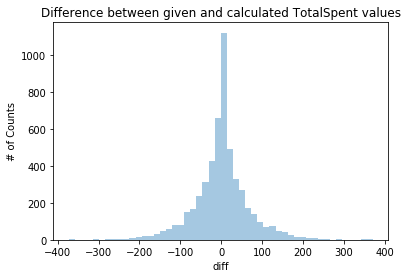

In [8]:
complete_data = data[~data["TotalSpent"].isna()]
complete_data["diff"] = complete_data["MonthlySpending"] * complete_data["ClientPeriod"] - data["TotalSpent"] 

sns.distplot(complete_data["diff"], kde=False)
plt.title("Difference between given and calculated TotalSpent values")
plt.ylabel("# of Counts")
plt.show()

We can clearly observe, that the difference between given and calculated TotalSpent values is mostly located around 0. 
Therefore, we can replace TotalSpent empty values with the product of **MonthlySpending** X **ClientPeriod** which is equal to 0 for all 9 rows.

In [9]:
# Let's replace empty TotalSpent values with 0
def impute_values(_data, _col_name, _value):
    _data.loc[_data[_col_name].isna(), _col_name] = _value
    return _data
    
data = impute_values(data, "TotalSpent", 0)

In [10]:
# Now load test dataset and go through the same process as for train dataset
test_data = pd.read_csv('./test.csv')
print(test_data.shape)

(1761, 19)


In [11]:
# Look at column types for test dataset
test_data.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
ClientPeriod                1761 non-null int64
MonthlySpending             1761 non-null float64
TotalSpent                  1761 non-null object
Sex                         1761 non-null object
IsSeniorCitizen             1761 non-null int64
HasPartner                  1761 non-null object
HasChild                    1761 non-null object
HasPhoneService             1761 non-null object
HasMultiplePhoneNumbers     1761 non-null object
HasInternetService          1761 non-null object
HasOnlineSecurityService    1761 non-null object
HasOnlineBackup             1761 non-null object
HasDeviceProtection         1761 non-null object
HasTechSupportAccess        1761 non-null object
HasOnlineTV                 1761 non-null object
HasMovieSubscription        1761 non-null object
HasContractPhone            1761 non-null object
IsBillingPaperless          1761 non-null object
PaymentMetho

In [12]:
# Change TotalSpent datatype to numerical
test_data["TotalSpent"] = pd.to_numeric(test_data["TotalSpent"], errors = "coerce")

In [13]:
# Check empty values
check_empty_values(test_data)

,Сolumn,NumEmptyValues
0,ClientPeriod,0
1,MonthlySpending,0
2,TotalSpent,2
3,Sex,0
4,IsSeniorCitizen,0
5,HasPartner,0
6,HasChild,0
7,HasPhoneService,0
8,HasMultiplePhoneNumbers,0
9,HasInternetService,0


In [14]:
# We have 2 empty TotalSpent values, so let's replace them with 0s
test_data = impute_values(test_data, "TotalSpent", 0)

## Part 2. Exploratory Data Analysis

### Numerical Variables

In [15]:
data[num_cols].describe()

,ClientPeriod,MonthlySpending,TotalSpent
count,5282.000000,5282.000000,5282.000000
mean,32.397009,64.924754,2287.486161
std,24.550326,30.176464,2269.049195
min,0.000000,18.250000,0.000000
25%,9.000000,35.462500,395.725000
50%,29.000000,70.400000,1405.650000
75%,55.000000,90.050000,3795.212500
max,72.000000,118.750000,8684.800000


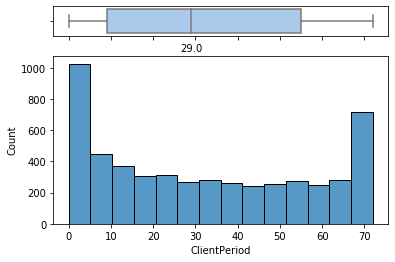

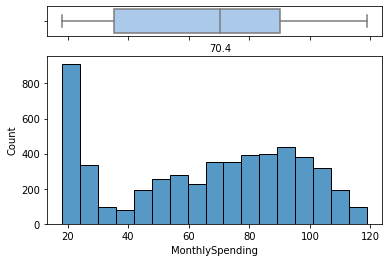

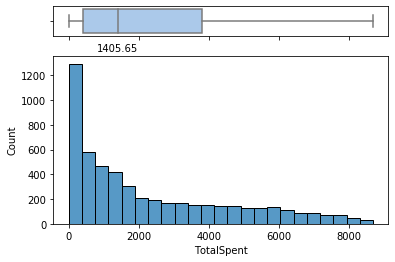

In [16]:
# Visualize the distribution of numerical values with histograms
for c in num_cols:
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    sns.boxplot(data[c], ax=ax_box, palette = "pastel")
    sns.histplot(data[c], ax=ax_hist, palette = "pastel")
    ax_box.text(
        x = data[c].median(), 
        y = 1, 
        s = "{}".format(data[c].median()),
        horizontalalignment='center',
        color='black')
    plt.xlabel(c)
    plt.ylabel("Count")

    ax_box.set(xlabel='')

We can see that the distribution of the **ClientPeriod** is bimodal meaning that most of clients are either have been using the service for **less than a year**, or for around **70 months (5 years)**. 

The distribution of **MonthlySpending** variable has a clear peak of values around 20 which indicates quite a big group of clients with a low price for service. The rest of values are distributed quite evenly. 

The distribution of **TotalSpent** variable is right skewed demonstrating that **a half** of the clients presented in the training dataset spent under **USD 1405 (the median)**.

### Categorical Variables

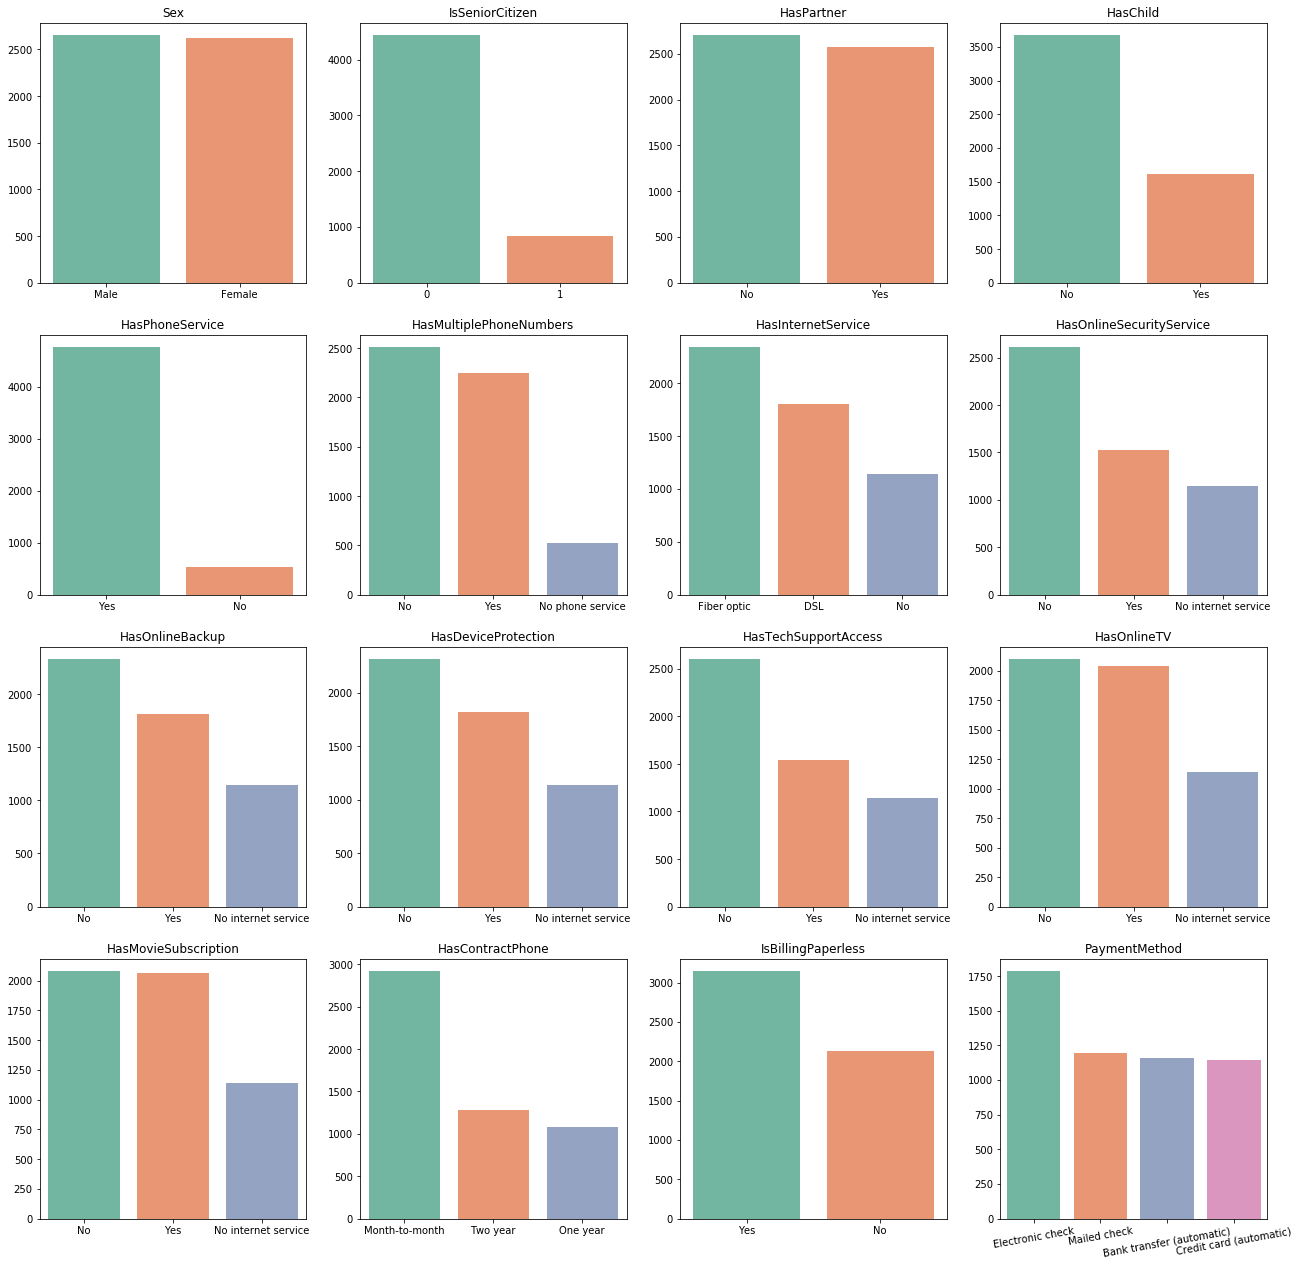

In [17]:
# Let's look at the distribution of categorical values in the training dataset
fig = plt.figure(figsize = [22, 22])
index = 1

for c in cat_cols:
    ax = fig.add_subplot(4, 4, index)
    value_count = data[c].value_counts()
    sns.barplot(value_count.index, value_count.values, palette="Set2")
    plt.title(c)
    if c == "PaymentMethod":
        plt.setp(ax.get_xticklabels(), rotation=10, ha='center')
    index += 1

From the plots above, we can observe that two variables (**IsSeniorCitizen** and **HasPhoneService**) are imbalanced and can affect the model performance.

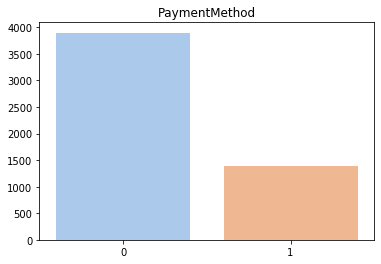

In [18]:
# Now let's take a look at distribution of the target variable
churn_count = data["Churn"].value_counts()
sns.barplot(churn_count.index, churn_count.values, palette="pastel")
plt.title(c)
plt.show()

Two classes belonged to the **Churn** variable are imbalanced: the number of **churned clients** (Churn=1) is approximately 3 times less than **clients who continued use the service** (Churn=0). Therefore, we cannot use accuracy as a metric since it is too sensitive to classes' size.

## Part 3. Building Models

### Logistic Regression

I will start with a logistic regression built on all input variables. As a part of data preprocessing process, I will use:

- scaling of numerical values
- one hot encoding for categorical values

The best parameters of the model will be searched using **GridSearchCV**.

In [19]:
# Combine standardising and encoding
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder()

transformer = ColumnTransformer(transformers = [
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols)
])

In [132]:
# Create a pipeline and fit a model
pipeline = make_pipeline(
    transformer,
    SelectKBest(mutual_info_classif),
    LogisticRegression(solver = "saga")
        )
CV_model_lr = GridSearchCV(
    estimator = pipeline,
    param_grid = [{"logisticregression__C": [100, 10, 1, 0.1],
                  "logisticregression__penalty": ['l1', 'l2'],
                  "selectkbest__k": [18, 19, 20, 21]},
                  {"logisticregression__C": [100, 10, 1, 0.1],
                  "logisticregression__penalty": ['elasticnet'],
                  "selectkbest__k": [18, 19, 20, 21],
                  "logisticregression__l1_ratio":[0.2, 0.5, 0.8]}],
    cv = 5,
    scoring = "roc_auc",
    n_jobs = None,
    verbose = 10
)
CV_model_lr.fit(data.iloc[:,:-1], data["Churn"])

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] logisticregression__C=100, logisticregression__penalty=l1, selectkbest__k=18 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  logisticregression__C=100, logisticregression__penalty=l1, selectkbest__k=18, score=0.858, total=   1.2s
[CV] logisticregression__C=100, logisticregression__penalty=l1, selectkbest__k=18 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV]  logisticregression__C=100, logisticregression__penalty=l1, selectkbest__k=18, score=0.832, total=   1.1s
[CV] logisticregression__C=100, logisticregression__penalty=l1, selectkbest__k=18 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s


[CV]  logisticregression__C=100, logisticregression__penalty=l1, selectkbest__k=18, score=0.832, total=   1.2s
[CV] logisticregression__C=100, logisticregression__penalty=l1, selectkbest__k=18 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.5s remaining:    0.0s


[CV]  logisticregression__C=100, logisticregression__penalty=l1, selectkbest__k=18, score=0.850, total=   1.2s
[CV] logisticregression__C=100, logisticregression__penalty=l1, selectkbest__k=18 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.7s remaining:    0.0s


[CV]  logisticregression__C=100, logisticregression__penalty=l1, selectkbest__k=18, score=0.835, total=   1.2s
[CV] logisticregression__C=100, logisticregression__penalty=l1, selectkbest__k=19 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.9s remaining:    0.0s


[CV]  logisticregression__C=100, logisticregression__penalty=l1, selectkbest__k=19, score=0.859, total=   1.2s
[CV] logisticregression__C=100, logisticregression__penalty=l1, selectkbest__k=19 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    7.1s remaining:    0.0s


[CV]  logisticregression__C=100, logisticregression__penalty=l1, selectkbest__k=19, score=0.829, total=   1.2s
[CV] logisticregression__C=100, logisticregression__penalty=l1, selectkbest__k=19 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    8.3s remaining:    0.0s


[CV]  logisticregression__C=100, logisticregression__penalty=l1, selectkbest__k=19, score=0.836, total=   1.1s
[CV] logisticregression__C=100, logisticregression__penalty=l1, selectkbest__k=19 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    9.4s remaining:    0.0s


[CV]  logisticregression__C=100, logisticregression__penalty=l1, selectkbest__k=19, score=0.853, total=   1.2s
[CV] logisticregression__C=100, logisticregression__penalty=l1, selectkbest__k=19 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   10.6s remaining:    0.0s


[CV]  logisticregression__C=100, logisticregression__penalty=l1, selectkbest__k=19, score=0.835, total=   1.1s
[CV] logisticregression__C=100, logisticregression__penalty=l1, selectkbest__k=20 
[CV]  logisticregression__C=100, logisticregression__penalty=l1, selectkbest__k=20, score=0.857, total=   1.2s
[CV] logisticregression__C=100, logisticregression__penalty=l1, selectkbest__k=20 
[CV]  logisticregression__C=100, logisticregression__penalty=l1, selectkbest__k=20, score=0.830, total=   1.2s
[CV] logisticregression__C=100, logisticregression__penalty=l1, selectkbest__k=20 
[CV]  logisticregression__C=100, logisticregression__penalty=l1, selectkbest__k=20, score=0.836, total=   1.2s
[CV] logisticregression__C=100, logisticregression__penalty=l1, selectkbest__k=20 
[CV]  logisticregression__C=100, logisticregression__penalty=l1, selectkbest__k=20, score=0.854, total=   1.2s
[CV] logisticregression__C=100, logisticregression__penalty=l1, selectkbest__k=20 
[CV]  logisticregression__C=10

[CV]  logisticregression__C=10, logisticregression__penalty=l1, selectkbest__k=20, score=0.834, total=   1.3s
[CV] logisticregression__C=10, logisticregression__penalty=l1, selectkbest__k=20 
[CV]  logisticregression__C=10, logisticregression__penalty=l1, selectkbest__k=20, score=0.855, total=   1.5s
[CV] logisticregression__C=10, logisticregression__penalty=l1, selectkbest__k=20 
[CV]  logisticregression__C=10, logisticregression__penalty=l1, selectkbest__k=20, score=0.836, total=   1.4s
[CV] logisticregression__C=10, logisticregression__penalty=l1, selectkbest__k=21 
[CV]  logisticregression__C=10, logisticregression__penalty=l1, selectkbest__k=21, score=0.862, total=   1.2s
[CV] logisticregression__C=10, logisticregression__penalty=l1, selectkbest__k=21 
[CV]  logisticregression__C=10, logisticregression__penalty=l1, selectkbest__k=21, score=0.834, total=   1.2s
[CV] logisticregression__C=10, logisticregression__penalty=l1, selectkbest__k=21 
[CV]  logisticregression__C=10, logistic

[CV]  logisticregression__C=1, logisticregression__penalty=l1, selectkbest__k=21, score=0.859, total=   1.2s
[CV] logisticregression__C=1, logisticregression__penalty=l1, selectkbest__k=21 
[CV]  logisticregression__C=1, logisticregression__penalty=l1, selectkbest__k=21, score=0.833, total=   1.2s
[CV] logisticregression__C=1, logisticregression__penalty=l1, selectkbest__k=21 
[CV]  logisticregression__C=1, logisticregression__penalty=l1, selectkbest__k=21, score=0.835, total=   1.2s
[CV] logisticregression__C=1, logisticregression__penalty=l1, selectkbest__k=21 
[CV]  logisticregression__C=1, logisticregression__penalty=l1, selectkbest__k=21, score=0.855, total=   1.2s
[CV] logisticregression__C=1, logisticregression__penalty=l1, selectkbest__k=21 
[CV]  logisticregression__C=1, logisticregression__penalty=l1, selectkbest__k=21, score=0.834, total=   1.2s
[CV] logisticregression__C=1, logisticregression__penalty=l2, selectkbest__k=18 
[CV]  logisticregression__C=1, logisticregression_

[CV]  logisticregression__C=0.1, logisticregression__penalty=l1, selectkbest__k=21, score=0.851, total=   1.1s
[CV] logisticregression__C=0.1, logisticregression__penalty=l1, selectkbest__k=21 
[CV]  logisticregression__C=0.1, logisticregression__penalty=l1, selectkbest__k=21, score=0.832, total=   1.2s
[CV] logisticregression__C=0.1, logisticregression__penalty=l2, selectkbest__k=18 
[CV]  logisticregression__C=0.1, logisticregression__penalty=l2, selectkbest__k=18, score=0.856, total=   1.2s
[CV] logisticregression__C=0.1, logisticregression__penalty=l2, selectkbest__k=18 
[CV]  logisticregression__C=0.1, logisticregression__penalty=l2, selectkbest__k=18, score=0.831, total=   1.2s
[CV] logisticregression__C=0.1, logisticregression__penalty=l2, selectkbest__k=18 
[CV]  logisticregression__C=0.1, logisticregression__penalty=l2, selectkbest__k=18, score=0.832, total=   1.2s
[CV] logisticregression__C=0.1, logisticregression__penalty=l2, selectkbest__k=18 
[CV]  logisticregression__C=0.

[CV]  logisticregression__C=100, logisticregression__l1_ratio=0.2, logisticregression__penalty=elasticnet, selectkbest__k=20, score=0.835, total=   1.3s
[CV] logisticregression__C=100, logisticregression__l1_ratio=0.2, logisticregression__penalty=elasticnet, selectkbest__k=21 
[CV]  logisticregression__C=100, logisticregression__l1_ratio=0.2, logisticregression__penalty=elasticnet, selectkbest__k=21, score=0.859, total=   1.2s
[CV] logisticregression__C=100, logisticregression__l1_ratio=0.2, logisticregression__penalty=elasticnet, selectkbest__k=21 
[CV]  logisticregression__C=100, logisticregression__l1_ratio=0.2, logisticregression__penalty=elasticnet, selectkbest__k=21, score=0.832, total=   1.3s
[CV] logisticregression__C=100, logisticregression__l1_ratio=0.2, logisticregression__penalty=elasticnet, selectkbest__k=21 
[CV]  logisticregression__C=100, logisticregression__l1_ratio=0.2, logisticregression__penalty=elasticnet, selectkbest__k=21, score=0.834, total=   1.3s
[CV] logistic

[CV]  logisticregression__C=100, logisticregression__l1_ratio=0.8, logisticregression__penalty=elasticnet, selectkbest__k=18, score=0.837, total=   1.3s
[CV] logisticregression__C=100, logisticregression__l1_ratio=0.8, logisticregression__penalty=elasticnet, selectkbest__k=19 
[CV]  logisticregression__C=100, logisticregression__l1_ratio=0.8, logisticregression__penalty=elasticnet, selectkbest__k=19, score=0.857, total=   1.2s
[CV] logisticregression__C=100, logisticregression__l1_ratio=0.8, logisticregression__penalty=elasticnet, selectkbest__k=19 
[CV]  logisticregression__C=100, logisticregression__l1_ratio=0.8, logisticregression__penalty=elasticnet, selectkbest__k=19, score=0.832, total=   1.2s
[CV] logisticregression__C=100, logisticregression__l1_ratio=0.8, logisticregression__penalty=elasticnet, selectkbest__k=19 
[CV]  logisticregression__C=100, logisticregression__l1_ratio=0.8, logisticregression__penalty=elasticnet, selectkbest__k=19, score=0.832, total=   1.2s
[CV] logistic

[CV]  logisticregression__C=10, logisticregression__l1_ratio=0.2, logisticregression__penalty=elasticnet, selectkbest__k=20, score=0.834, total=   1.4s
[CV] logisticregression__C=10, logisticregression__l1_ratio=0.2, logisticregression__penalty=elasticnet, selectkbest__k=21 
[CV]  logisticregression__C=10, logisticregression__l1_ratio=0.2, logisticregression__penalty=elasticnet, selectkbest__k=21, score=0.858, total=   1.2s
[CV] logisticregression__C=10, logisticregression__l1_ratio=0.2, logisticregression__penalty=elasticnet, selectkbest__k=21 
[CV]  logisticregression__C=10, logisticregression__l1_ratio=0.2, logisticregression__penalty=elasticnet, selectkbest__k=21, score=0.832, total=   1.3s
[CV] logisticregression__C=10, logisticregression__l1_ratio=0.2, logisticregression__penalty=elasticnet, selectkbest__k=21 
[CV]  logisticregression__C=10, logisticregression__l1_ratio=0.2, logisticregression__penalty=elasticnet, selectkbest__k=21, score=0.832, total=   1.3s
[CV] logisticregress

[CV]  logisticregression__C=10, logisticregression__l1_ratio=0.8, logisticregression__penalty=elasticnet, selectkbest__k=18, score=0.837, total=   1.2s
[CV] logisticregression__C=10, logisticregression__l1_ratio=0.8, logisticregression__penalty=elasticnet, selectkbest__k=19 
[CV]  logisticregression__C=10, logisticregression__l1_ratio=0.8, logisticregression__penalty=elasticnet, selectkbest__k=19, score=0.857, total=   1.2s
[CV] logisticregression__C=10, logisticregression__l1_ratio=0.8, logisticregression__penalty=elasticnet, selectkbest__k=19 
[CV]  logisticregression__C=10, logisticregression__l1_ratio=0.8, logisticregression__penalty=elasticnet, selectkbest__k=19, score=0.830, total=   1.3s
[CV] logisticregression__C=10, logisticregression__l1_ratio=0.8, logisticregression__penalty=elasticnet, selectkbest__k=19 
[CV]  logisticregression__C=10, logisticregression__l1_ratio=0.8, logisticregression__penalty=elasticnet, selectkbest__k=19, score=0.832, total=   1.2s
[CV] logisticregress

[CV]  logisticregression__C=1, logisticregression__l1_ratio=0.2, logisticregression__penalty=elasticnet, selectkbest__k=20, score=0.836, total=   1.2s
[CV] logisticregression__C=1, logisticregression__l1_ratio=0.2, logisticregression__penalty=elasticnet, selectkbest__k=21 
[CV]  logisticregression__C=1, logisticregression__l1_ratio=0.2, logisticregression__penalty=elasticnet, selectkbest__k=21, score=0.858, total=   1.2s
[CV] logisticregression__C=1, logisticregression__l1_ratio=0.2, logisticregression__penalty=elasticnet, selectkbest__k=21 
[CV]  logisticregression__C=1, logisticregression__l1_ratio=0.2, logisticregression__penalty=elasticnet, selectkbest__k=21, score=0.833, total=   1.2s
[CV] logisticregression__C=1, logisticregression__l1_ratio=0.2, logisticregression__penalty=elasticnet, selectkbest__k=21 
[CV]  logisticregression__C=1, logisticregression__l1_ratio=0.2, logisticregression__penalty=elasticnet, selectkbest__k=21, score=0.836, total=   1.2s
[CV] logisticregression__C=

[CV]  logisticregression__C=1, logisticregression__l1_ratio=0.8, logisticregression__penalty=elasticnet, selectkbest__k=18, score=0.837, total=   1.1s
[CV] logisticregression__C=1, logisticregression__l1_ratio=0.8, logisticregression__penalty=elasticnet, selectkbest__k=19 
[CV]  logisticregression__C=1, logisticregression__l1_ratio=0.8, logisticregression__penalty=elasticnet, selectkbest__k=19, score=0.858, total=   1.1s
[CV] logisticregression__C=1, logisticregression__l1_ratio=0.8, logisticregression__penalty=elasticnet, selectkbest__k=19 
[CV]  logisticregression__C=1, logisticregression__l1_ratio=0.8, logisticregression__penalty=elasticnet, selectkbest__k=19, score=0.833, total=   1.1s
[CV] logisticregression__C=1, logisticregression__l1_ratio=0.8, logisticregression__penalty=elasticnet, selectkbest__k=19 
[CV]  logisticregression__C=1, logisticregression__l1_ratio=0.8, logisticregression__penalty=elasticnet, selectkbest__k=19, score=0.835, total=   1.1s
[CV] logisticregression__C=

[CV]  logisticregression__C=0.1, logisticregression__l1_ratio=0.2, logisticregression__penalty=elasticnet, selectkbest__k=20, score=0.835, total=   1.2s
[CV] logisticregression__C=0.1, logisticregression__l1_ratio=0.2, logisticregression__penalty=elasticnet, selectkbest__k=21 
[CV]  logisticregression__C=0.1, logisticregression__l1_ratio=0.2, logisticregression__penalty=elasticnet, selectkbest__k=21, score=0.856, total=   1.7s
[CV] logisticregression__C=0.1, logisticregression__l1_ratio=0.2, logisticregression__penalty=elasticnet, selectkbest__k=21 
[CV]  logisticregression__C=0.1, logisticregression__l1_ratio=0.2, logisticregression__penalty=elasticnet, selectkbest__k=21, score=0.831, total=   1.3s
[CV] logisticregression__C=0.1, logisticregression__l1_ratio=0.2, logisticregression__penalty=elasticnet, selectkbest__k=21 
[CV]  logisticregression__C=0.1, logisticregression__l1_ratio=0.2, logisticregression__penalty=elasticnet, selectkbest__k=21, score=0.832, total=   1.1s
[CV] logistic

[CV]  logisticregression__C=0.1, logisticregression__l1_ratio=0.8, logisticregression__penalty=elasticnet, selectkbest__k=18, score=0.832, total=   1.1s
[CV] logisticregression__C=0.1, logisticregression__l1_ratio=0.8, logisticregression__penalty=elasticnet, selectkbest__k=19 
[CV]  logisticregression__C=0.1, logisticregression__l1_ratio=0.8, logisticregression__penalty=elasticnet, selectkbest__k=19, score=0.854, total=   1.1s
[CV] logisticregression__C=0.1, logisticregression__l1_ratio=0.8, logisticregression__penalty=elasticnet, selectkbest__k=19 
[CV]  logisticregression__C=0.1, logisticregression__l1_ratio=0.8, logisticregression__penalty=elasticnet, selectkbest__k=19, score=0.827, total=   1.1s
[CV] logisticregression__C=0.1, logisticregression__l1_ratio=0.8, logisticregression__penalty=elasticnet, selectkbest__k=19 
[CV]  logisticregression__C=0.1, logisticregression__l1_ratio=0.8, logisticregression__penalty=elasticnet, selectkbest__k=19, score=0.838, total=   1.2s
[CV] logistic

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  8.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         ['ClientPeriod',
                                                      

In [147]:
# Let's look at the results
results = pd.DataFrame(CV_model_lr.cv_results_)
best_score = results.loc[results["rank_test_score"] == 1, "mean_test_score"].item()
best_param = results.loc[results["rank_test_score"] == 1, "params"].item()
print("""Best ROC-AUC value {0} can be reached if regularization coefficient C = {1}, \
penalty={2} and k={3}""".format(round(best_score,4), best_param['logisticregression__C'], best_param['logisticregression__penalty'], best_param['selectkbest__k']))

Best ROC-AUC value 0.8441 can be reached if regularization coefficient C = 10, penalty=l1 and k=21


### Random Forest

Now let's try Random Forest Ensemble Model.

Same techniques will be used to pre-process the data.

The best parameters of the model will be again searched using **GridSearchCV**.

In [133]:
# Create a pipeline and fit a model
pipeline = make_pipeline(
    transformer,
    RandomForestClassifier()
        )
CV_model_forest = GridSearchCV(
    estimator = pipeline,
    param_grid = {
                  "randomforestclassifier__n_estimators": [20, 50, 75, 80, 85],
                  "randomforestclassifier__criterion":["entropy", "gini"],
                  "randomforestclassifier__max_depth":[5, 6, 7, 8, 9, 10]},
    cv = 5,
    scoring = "roc_auc",
    n_jobs = None,
    verbose = 10
)
CV_model_forest.fit(data.iloc[:,:-1], data["Churn"])

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=20 
[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=20, score=0.852, total=   0.1s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=20 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=20, score=0.825, total=   0.1s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=20 
[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=20, score=0.835, total=   0.1s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=20 
[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=20, score=0.857, total=   0.1s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=20 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=20, score=0.832, total=   0.1s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=50 
[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=50, score=0.854, total=   0.2s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=50 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.7s remaining:    0.0s


[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=50, score=0.830, total=   0.2s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=50 
[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=50, score=0.840, total=   0.2s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=50 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.0s remaining:    0.0s


[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=50, score=0.856, total=   0.2s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=50 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.2s remaining:    0.0s


[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=50, score=0.835, total=   0.2s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=75 
[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=75, score=0.854, total=   0.3s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=75 
[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=75, score=0.832, total=   0.2s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=75 
[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=75, score=0.839, total=   0.2s
[CV] r

[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=6, randomforestclassifier__n_estimators=75, score=0.836, total=   0.3s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=6, randomforestclassifier__n_estimators=80 
[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=6, randomforestclassifier__n_estimators=80, score=0.854, total=   0.3s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=6, randomforestclassifier__n_estimators=80 
[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=6, randomforestclassifier__n_estimators=80, score=0.833, total=   0.3s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=6, randomforestclassifier__n_estimators=80 
[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=6, randomforestclassifier__n_estimators=80, score=0.840, total=   0.3s
[CV] r

[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=7, randomforestclassifier__n_estimators=80, score=0.838, total=   0.3s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=7, randomforestclassifier__n_estimators=85 
[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=7, randomforestclassifier__n_estimators=85, score=0.850, total=   0.3s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=7, randomforestclassifier__n_estimators=85 
[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=7, randomforestclassifier__n_estimators=85, score=0.833, total=   0.3s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=7, randomforestclassifier__n_estimators=85 
[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=7, randomforestclassifier__n_estimators=85, score=0.839, total=   0.3s
[CV] r

[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=8, randomforestclassifier__n_estimators=85, score=0.840, total=   0.3s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=9, randomforestclassifier__n_estimators=20 
[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=9, randomforestclassifier__n_estimators=20, score=0.843, total=   0.1s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=9, randomforestclassifier__n_estimators=20 
[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=9, randomforestclassifier__n_estimators=20, score=0.823, total=   0.1s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=9, randomforestclassifier__n_estimators=20 
[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=9, randomforestclassifier__n_estimators=20, score=0.831, total=   0.1s
[CV] r

[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=10, randomforestclassifier__n_estimators=50, score=0.844, total=   0.2s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=10, randomforestclassifier__n_estimators=50 
[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=10, randomforestclassifier__n_estimators=50, score=0.828, total=   0.2s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=10, randomforestclassifier__n_estimators=50 
[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=10, randomforestclassifier__n_estimators=50, score=0.830, total=   0.2s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=10, randomforestclassifier__n_estimators=50 
[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=10, randomforestclassifier__n_estimators=50, score=0.847, total=   0.2s

[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=75, score=0.853, total=   0.2s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=75 
[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=75, score=0.831, total=   0.2s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=75 
[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=75, score=0.840, total=   0.2s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=75 
[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=75, score=0.851, total=   0.2s
[CV] randomforestclassifier

[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=6, randomforestclassifier__n_estimators=80, score=0.856, total=   0.2s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=6, randomforestclassifier__n_estimators=80 
[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=6, randomforestclassifier__n_estimators=80, score=0.834, total=   0.2s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=6, randomforestclassifier__n_estimators=80 
[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=6, randomforestclassifier__n_estimators=80, score=0.839, total=   0.2s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=6, randomforestclassifier__n_estimators=80 
[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=6, randomforestclassifier__n_estimators=80, score=0.856, total=   0.2s
[CV] randomforestclassifier

[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=7, randomforestclassifier__n_estimators=85, score=0.852, total=   0.3s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=7, randomforestclassifier__n_estimators=85 
[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=7, randomforestclassifier__n_estimators=85, score=0.835, total=   0.3s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=7, randomforestclassifier__n_estimators=85 
[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=7, randomforestclassifier__n_estimators=85, score=0.836, total=   0.3s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=7, randomforestclassifier__n_estimators=85 
[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=7, randomforestclassifier__n_estimators=85, score=0.852, total=   0.3s
[CV] randomforestclassifier

[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=9, randomforestclassifier__n_estimators=20, score=0.826, total=   0.1s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=9, randomforestclassifier__n_estimators=20 
[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=9, randomforestclassifier__n_estimators=20, score=0.844, total=   0.1s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=9, randomforestclassifier__n_estimators=20 
[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=9, randomforestclassifier__n_estimators=20, score=0.837, total=   0.1s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=9, randomforestclassifier__n_estimators=50 
[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=9, randomforestclassifier__n_estimators=50, score=0.848, total=   0.2s
[CV] randomforestclassifier

[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=10, randomforestclassifier__n_estimators=50, score=0.844, total=   0.2s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=10, randomforestclassifier__n_estimators=50 
[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=10, randomforestclassifier__n_estimators=50, score=0.832, total=   0.2s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=10, randomforestclassifier__n_estimators=75 
[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=10, randomforestclassifier__n_estimators=75, score=0.841, total=   0.3s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=10, randomforestclassifier__n_estimators=75 
[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=10, randomforestclassifier__n_estimators=75, score=0.824, total=   0.3s
[CV] randomforestcla

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         ['ClientPeriod',
                                                      

In [171]:
# Let's look at the results
results = pd.DataFrame(CV_model_forest.cv_results_)
best_score = results.loc[results["rank_test_score"] == 1, "mean_test_score"].item()
best_param = results.loc[results["rank_test_score"] == 1, "params"].item()
print("""Best ROC-AUC value {0} can be reached if criterion = {1}, \
max_depth={2} and n_estimators={3}""".format(round(best_score,4), best_param['randomforestclassifier__criterion'], best_param['randomforestclassifier__max_depth'], best_param['randomforestclassifier__n_estimators']))

Best ROC-AUC value 0.8447 can be reached if criterion = gini, max_depth=6 and n_estimators=80


### Gradient Boosting

In [165]:
# Let's try to add previous predictions as new columns
data["Forest_Predict"] = CV_model_forest.predict(data.iloc[:,:-1])
data["LR_Predict"] = CV_model_lr.predict(data.iloc[:,:-1])
data = data[[ col for col in data.columns if col != 'Churn' ] + ['Churn'] ]

In [178]:
# Now let's try to fit catboost model using different parameters
depth = np.arange(6, 11, 1)
n_estimators = [200, 250, 300]
learning_rate = [0.01, 0.02, 0.03, 0.04, 0.05]
l2_leaf_reg = [10, 20, 50]

results = []

for i in n_estimators:
    for j in learning_rate:
        for d in depth:
            for leaf in l2_leaf_reg:
                boosting_model_new = catboost.CatBoostClassifier(cat_features=cat_cols,
                                                                n_estimators=i,
                                                                learning_rate=j,
                                                                depth = d,
                                                                l2_leaf_reg = leaf)
                boosting_model_new.fit(X_train, y_train)
                y_test_predicted = boosting_model_new.predict_proba(X_test)[:, 1]
                results.append((i, j, d, leaf, roc_auc_score(y_test, y_test_predicted)))

0:	learn: 0.6873239	total: 6.61ms	remaining: 1.31s
1:	learn: 0.6806418	total: 13.4ms	remaining: 1.33s
2:	learn: 0.6741720	total: 24.3ms	remaining: 1.6s
3:	learn: 0.6682761	total: 30ms	remaining: 1.47s
4:	learn: 0.6640239	total: 32.2ms	remaining: 1.26s
5:	learn: 0.6584125	total: 41.8ms	remaining: 1.35s
6:	learn: 0.6528792	total: 48.2ms	remaining: 1.33s
7:	learn: 0.6476350	total: 53.6ms	remaining: 1.29s
8:	learn: 0.6423906	total: 58.1ms	remaining: 1.23s
9:	learn: 0.6377187	total: 62.7ms	remaining: 1.19s
10:	learn: 0.6324130	total: 69.3ms	remaining: 1.19s
11:	learn: 0.6276154	total: 72ms	remaining: 1.13s
12:	learn: 0.6227325	total: 77.3ms	remaining: 1.11s
13:	learn: 0.6179913	total: 83.4ms	remaining: 1.11s
14:	learn: 0.6130386	total: 89.7ms	remaining: 1.1s
15:	learn: 0.6083777	total: 96ms	remaining: 1.1s
16:	learn: 0.6037450	total: 101ms	remaining: 1.09s
17:	learn: 0.5998114	total: 108ms	remaining: 1.09s
18:	learn: 0.5952953	total: 113ms	remaining: 1.07s
19:	learn: 0.5912757	total: 117ms	

176:	learn: 0.4208896	total: 990ms	remaining: 129ms
177:	learn: 0.4205636	total: 996ms	remaining: 123ms
178:	learn: 0.4202578	total: 1s	remaining: 117ms
179:	learn: 0.4199299	total: 1.01s	remaining: 112ms
180:	learn: 0.4197467	total: 1.01s	remaining: 107ms
181:	learn: 0.4194084	total: 1.02s	remaining: 101ms
182:	learn: 0.4190880	total: 1.03s	remaining: 95.3ms
183:	learn: 0.4190157	total: 1.03s	remaining: 89.4ms
184:	learn: 0.4188057	total: 1.03s	remaining: 83.7ms
185:	learn: 0.4186694	total: 1.04s	remaining: 78.1ms
186:	learn: 0.4185418	total: 1.04s	remaining: 72.3ms
187:	learn: 0.4183079	total: 1.04s	remaining: 66.8ms
188:	learn: 0.4180636	total: 1.05s	remaining: 61.1ms
189:	learn: 0.4176915	total: 1.06s	remaining: 55.6ms
190:	learn: 0.4175431	total: 1.06s	remaining: 50ms
191:	learn: 0.4174650	total: 1.06s	remaining: 44.3ms
192:	learn: 0.4172003	total: 1.07s	remaining: 38.7ms
193:	learn: 0.4170672	total: 1.07s	remaining: 33.1ms
194:	learn: 0.4168410	total: 1.07s	remaining: 27.6ms
195:

165:	learn: 0.4231343	total: 852ms	remaining: 174ms
166:	learn: 0.4230455	total: 854ms	remaining: 169ms
167:	learn: 0.4227106	total: 858ms	remaining: 164ms
168:	learn: 0.4223414	total: 864ms	remaining: 158ms
169:	learn: 0.4220398	total: 871ms	remaining: 154ms
170:	learn: 0.4218544	total: 877ms	remaining: 149ms
171:	learn: 0.4215740	total: 884ms	remaining: 144ms
172:	learn: 0.4213306	total: 890ms	remaining: 139ms
173:	learn: 0.4210255	total: 895ms	remaining: 134ms
174:	learn: 0.4207508	total: 902ms	remaining: 129ms
175:	learn: 0.4205887	total: 905ms	remaining: 123ms
176:	learn: 0.4204006	total: 909ms	remaining: 118ms
177:	learn: 0.4201692	total: 916ms	remaining: 113ms
178:	learn: 0.4200232	total: 922ms	remaining: 108ms
179:	learn: 0.4197631	total: 927ms	remaining: 103ms
180:	learn: 0.4196348	total: 934ms	remaining: 98ms
181:	learn: 0.4194865	total: 938ms	remaining: 92.7ms
182:	learn: 0.4191875	total: 943ms	remaining: 87.6ms
183:	learn: 0.4190860	total: 947ms	remaining: 82.4ms
184:	learn

169:	learn: 0.4259914	total: 784ms	remaining: 138ms
170:	learn: 0.4257155	total: 790ms	remaining: 134ms
171:	learn: 0.4255377	total: 794ms	remaining: 129ms
172:	learn: 0.4252288	total: 800ms	remaining: 125ms
173:	learn: 0.4249084	total: 805ms	remaining: 120ms
174:	learn: 0.4246336	total: 810ms	remaining: 116ms
175:	learn: 0.4243216	total: 814ms	remaining: 111ms
176:	learn: 0.4240679	total: 820ms	remaining: 107ms
177:	learn: 0.4238450	total: 825ms	remaining: 102ms
178:	learn: 0.4236167	total: 830ms	remaining: 97.3ms
179:	learn: 0.4233921	total: 834ms	remaining: 92.7ms
180:	learn: 0.4231723	total: 839ms	remaining: 88.1ms
181:	learn: 0.4229612	total: 844ms	remaining: 83.5ms
182:	learn: 0.4228242	total: 847ms	remaining: 78.6ms
183:	learn: 0.4226139	total: 850ms	remaining: 73.9ms
184:	learn: 0.4225491	total: 852ms	remaining: 69ms
185:	learn: 0.4223799	total: 856ms	remaining: 64.4ms
186:	learn: 0.4221364	total: 860ms	remaining: 59.8ms
187:	learn: 0.4219304	total: 865ms	remaining: 55.2ms
188:

146:	learn: 0.4262408	total: 821ms	remaining: 296ms
147:	learn: 0.4257692	total: 828ms	remaining: 291ms
148:	learn: 0.4253982	total: 836ms	remaining: 286ms
149:	learn: 0.4250292	total: 844ms	remaining: 281ms
150:	learn: 0.4245193	total: 851ms	remaining: 276ms
151:	learn: 0.4240304	total: 859ms	remaining: 271ms
152:	learn: 0.4239095	total: 863ms	remaining: 265ms
153:	learn: 0.4238084	total: 865ms	remaining: 258ms
154:	learn: 0.4234708	total: 871ms	remaining: 253ms
155:	learn: 0.4233120	total: 875ms	remaining: 247ms
156:	learn: 0.4230525	total: 881ms	remaining: 241ms
157:	learn: 0.4226490	total: 888ms	remaining: 236ms
158:	learn: 0.4223255	total: 895ms	remaining: 231ms
159:	learn: 0.4220982	total: 900ms	remaining: 225ms
160:	learn: 0.4219962	total: 902ms	remaining: 218ms
161:	learn: 0.4218388	total: 903ms	remaining: 212ms
162:	learn: 0.4215191	total: 910ms	remaining: 207ms
163:	learn: 0.4213558	total: 913ms	remaining: 200ms
164:	learn: 0.4208623	total: 920ms	remaining: 195ms
165:	learn: 

136:	learn: 0.4340511	total: 645ms	remaining: 297ms
137:	learn: 0.4336925	total: 649ms	remaining: 292ms
138:	learn: 0.4332624	total: 656ms	remaining: 288ms
139:	learn: 0.4329754	total: 662ms	remaining: 284ms
140:	learn: 0.4326130	total: 670ms	remaining: 280ms
141:	learn: 0.4320452	total: 677ms	remaining: 276ms
142:	learn: 0.4317763	total: 681ms	remaining: 271ms
143:	learn: 0.4312558	total: 687ms	remaining: 267ms
144:	learn: 0.4310038	total: 692ms	remaining: 263ms
145:	learn: 0.4307823	total: 696ms	remaining: 257ms
146:	learn: 0.4303415	total: 702ms	remaining: 253ms
147:	learn: 0.4300760	total: 705ms	remaining: 248ms
148:	learn: 0.4296159	total: 712ms	remaining: 244ms
149:	learn: 0.4291180	total: 719ms	remaining: 240ms
150:	learn: 0.4286148	total: 726ms	remaining: 236ms
151:	learn: 0.4284281	total: 730ms	remaining: 231ms
152:	learn: 0.4279047	total: 736ms	remaining: 226ms
153:	learn: 0.4274783	total: 743ms	remaining: 222ms
154:	learn: 0.4272357	total: 751ms	remaining: 218ms
155:	learn: 

119:	learn: 0.4427496	total: 577ms	remaining: 385ms
120:	learn: 0.4423656	total: 581ms	remaining: 379ms
121:	learn: 0.4419646	total: 584ms	remaining: 374ms
122:	learn: 0.4414322	total: 591ms	remaining: 370ms
123:	learn: 0.4410423	total: 595ms	remaining: 365ms
124:	learn: 0.4405945	total: 600ms	remaining: 360ms
125:	learn: 0.4400533	total: 608ms	remaining: 357ms
126:	learn: 0.4398303	total: 611ms	remaining: 351ms
127:	learn: 0.4395680	total: 615ms	remaining: 346ms
128:	learn: 0.4390940	total: 621ms	remaining: 342ms
129:	learn: 0.4386616	total: 627ms	remaining: 338ms
130:	learn: 0.4383441	total: 631ms	remaining: 332ms
131:	learn: 0.4380927	total: 633ms	remaining: 326ms
132:	learn: 0.4376107	total: 639ms	remaining: 322ms
133:	learn: 0.4372233	total: 646ms	remaining: 318ms
134:	learn: 0.4367746	total: 652ms	remaining: 314ms
135:	learn: 0.4362564	total: 659ms	remaining: 310ms
136:	learn: 0.4357519	total: 666ms	remaining: 306ms
137:	learn: 0.4352801	total: 672ms	remaining: 302ms
138:	learn: 

83:	learn: 0.4625549	total: 517ms	remaining: 715ms
84:	learn: 0.4615578	total: 531ms	remaining: 718ms
85:	learn: 0.4602877	total: 542ms	remaining: 719ms
86:	learn: 0.4593243	total: 551ms	remaining: 716ms
87:	learn: 0.4580933	total: 561ms	remaining: 714ms
88:	learn: 0.4572961	total: 565ms	remaining: 705ms
89:	learn: 0.4562105	total: 573ms	remaining: 701ms
90:	learn: 0.4551855	total: 583ms	remaining: 699ms
91:	learn: 0.4543010	total: 592ms	remaining: 695ms
92:	learn: 0.4537681	total: 595ms	remaining: 685ms
93:	learn: 0.4527136	total: 604ms	remaining: 681ms
94:	learn: 0.4520798	total: 612ms	remaining: 677ms
95:	learn: 0.4510324	total: 621ms	remaining: 673ms
96:	learn: 0.4506171	total: 625ms	remaining: 664ms
97:	learn: 0.4499999	total: 632ms	remaining: 657ms
98:	learn: 0.4489533	total: 641ms	remaining: 654ms
99:	learn: 0.4479998	total: 651ms	remaining: 651ms
100:	learn: 0.4471580	total: 656ms	remaining: 643ms
101:	learn: 0.4463450	total: 667ms	remaining: 641ms
102:	learn: 0.4457270	total: 

72:	learn: 0.4752235	total: 414ms	remaining: 721ms
73:	learn: 0.4744807	total: 418ms	remaining: 711ms
74:	learn: 0.4734002	total: 422ms	remaining: 704ms
75:	learn: 0.4720162	total: 431ms	remaining: 703ms
76:	learn: 0.4707535	total: 438ms	remaining: 700ms
77:	learn: 0.4695725	total: 445ms	remaining: 696ms
78:	learn: 0.4683968	total: 455ms	remaining: 697ms
79:	learn: 0.4675730	total: 459ms	remaining: 688ms
80:	learn: 0.4664860	total: 462ms	remaining: 678ms
81:	learn: 0.4658355	total: 465ms	remaining: 669ms
82:	learn: 0.4646464	total: 472ms	remaining: 665ms
83:	learn: 0.4637060	total: 476ms	remaining: 658ms
84:	learn: 0.4625956	total: 486ms	remaining: 658ms
85:	learn: 0.4615062	total: 493ms	remaining: 653ms
86:	learn: 0.4604249	total: 500ms	remaining: 649ms
87:	learn: 0.4592413	total: 509ms	remaining: 648ms
88:	learn: 0.4587756	total: 513ms	remaining: 640ms
89:	learn: 0.4578935	total: 519ms	remaining: 634ms
90:	learn: 0.4574049	total: 521ms	remaining: 625ms
91:	learn: 0.4568974	total: 523

55:	learn: 0.5030292	total: 261ms	remaining: 671ms
56:	learn: 0.5010822	total: 271ms	remaining: 680ms
57:	learn: 0.4998246	total: 277ms	remaining: 677ms
58:	learn: 0.4986835	total: 280ms	remaining: 668ms
59:	learn: 0.4970383	total: 291ms	remaining: 680ms
60:	learn: 0.4957622	total: 300ms	remaining: 683ms
61:	learn: 0.4944929	total: 304ms	remaining: 677ms
62:	learn: 0.4929562	total: 309ms	remaining: 672ms
63:	learn: 0.4913632	total: 315ms	remaining: 668ms
64:	learn: 0.4897953	total: 325ms	remaining: 674ms
65:	learn: 0.4882096	total: 335ms	remaining: 680ms
66:	learn: 0.4866790	total: 341ms	remaining: 677ms
67:	learn: 0.4852935	total: 347ms	remaining: 674ms
68:	learn: 0.4843988	total: 350ms	remaining: 664ms
69:	learn: 0.4835234	total: 352ms	remaining: 653ms
70:	learn: 0.4821635	total: 358ms	remaining: 651ms
71:	learn: 0.4813286	total: 361ms	remaining: 641ms
72:	learn: 0.4800464	total: 363ms	remaining: 632ms
73:	learn: 0.4788550	total: 369ms	remaining: 629ms
74:	learn: 0.4776494	total: 374

17:	learn: 0.5989353	total: 130ms	remaining: 1.31s
18:	learn: 0.5944759	total: 137ms	remaining: 1.31s
19:	learn: 0.5901337	total: 143ms	remaining: 1.28s
20:	learn: 0.5864092	total: 156ms	remaining: 1.33s
21:	learn: 0.5836459	total: 160ms	remaining: 1.29s
22:	learn: 0.5799458	total: 164ms	remaining: 1.26s
23:	learn: 0.5764964	total: 167ms	remaining: 1.22s
24:	learn: 0.5731180	total: 172ms	remaining: 1.2s
25:	learn: 0.5697282	total: 181ms	remaining: 1.21s
26:	learn: 0.5667118	total: 195ms	remaining: 1.25s
27:	learn: 0.5640720	total: 200ms	remaining: 1.23s
28:	learn: 0.5614994	total: 203ms	remaining: 1.2s
29:	learn: 0.5580409	total: 208ms	remaining: 1.18s
30:	learn: 0.5558482	total: 211ms	remaining: 1.15s
31:	learn: 0.5535176	total: 213ms	remaining: 1.12s
32:	learn: 0.5505744	total: 215ms	remaining: 1.09s
33:	learn: 0.5482127	total: 219ms	remaining: 1.07s
34:	learn: 0.5459270	total: 222ms	remaining: 1.05s
35:	learn: 0.5435722	total: 226ms	remaining: 1.03s
36:	learn: 0.5407760	total: 231ms

179:	learn: 0.4101323	total: 1.76s	remaining: 196ms
180:	learn: 0.4100366	total: 1.77s	remaining: 186ms
181:	learn: 0.4097854	total: 1.77s	remaining: 175ms
182:	learn: 0.4092978	total: 1.79s	remaining: 166ms
183:	learn: 0.4087827	total: 1.81s	remaining: 157ms
184:	learn: 0.4083091	total: 1.83s	remaining: 148ms
185:	learn: 0.4082235	total: 1.84s	remaining: 138ms
186:	learn: 0.4079143	total: 1.85s	remaining: 129ms
187:	learn: 0.4077491	total: 1.86s	remaining: 119ms
188:	learn: 0.4074144	total: 1.88s	remaining: 109ms
189:	learn: 0.4071690	total: 1.9s	remaining: 99.9ms
190:	learn: 0.4066727	total: 1.92s	remaining: 90.3ms
191:	learn: 0.4064070	total: 1.93s	remaining: 80.6ms
192:	learn: 0.4059460	total: 1.95s	remaining: 70.8ms
193:	learn: 0.4056022	total: 1.97s	remaining: 60.9ms
194:	learn: 0.4055593	total: 1.97s	remaining: 50.6ms
195:	learn: 0.4051826	total: 1.99s	remaining: 40.6ms
196:	learn: 0.4049229	total: 2s	remaining: 30.5ms
197:	learn: 0.4044636	total: 2.02s	remaining: 20.4ms
198:	le

144:	learn: 0.4285612	total: 1.13s	remaining: 430ms
145:	learn: 0.4279787	total: 1.15s	remaining: 427ms
146:	learn: 0.4275527	total: 1.17s	remaining: 422ms
147:	learn: 0.4272111	total: 1.18s	remaining: 414ms
148:	learn: 0.4268577	total: 1.18s	remaining: 405ms
149:	learn: 0.4265058	total: 1.19s	remaining: 396ms
150:	learn: 0.4261044	total: 1.2s	remaining: 391ms
151:	learn: 0.4259450	total: 1.21s	remaining: 382ms
152:	learn: 0.4256725	total: 1.21s	remaining: 373ms
153:	learn: 0.4255084	total: 1.22s	remaining: 364ms
154:	learn: 0.4250247	total: 1.23s	remaining: 358ms
155:	learn: 0.4246246	total: 1.25s	remaining: 353ms
156:	learn: 0.4241351	total: 1.27s	remaining: 348ms
157:	learn: 0.4239336	total: 1.27s	remaining: 339ms
158:	learn: 0.4235384	total: 1.29s	remaining: 332ms
159:	learn: 0.4232939	total: 1.29s	remaining: 324ms
160:	learn: 0.4231180	total: 1.3s	remaining: 314ms
161:	learn: 0.4226693	total: 1.31s	remaining: 308ms
162:	learn: 0.4224993	total: 1.32s	remaining: 299ms
163:	learn: 0.

119:	learn: 0.4433018	total: 877ms	remaining: 585ms
120:	learn: 0.4429798	total: 883ms	remaining: 577ms
121:	learn: 0.4426460	total: 886ms	remaining: 566ms
122:	learn: 0.4420347	total: 891ms	remaining: 557ms
123:	learn: 0.4414944	total: 895ms	remaining: 549ms
124:	learn: 0.4408866	total: 901ms	remaining: 540ms
125:	learn: 0.4403802	total: 907ms	remaining: 533ms
126:	learn: 0.4398976	total: 912ms	remaining: 524ms
127:	learn: 0.4394154	total: 921ms	remaining: 518ms
128:	learn: 0.4388966	total: 930ms	remaining: 512ms
129:	learn: 0.4386860	total: 935ms	remaining: 504ms
130:	learn: 0.4382001	total: 949ms	remaining: 500ms
131:	learn: 0.4379734	total: 953ms	remaining: 491ms
132:	learn: 0.4377151	total: 956ms	remaining: 482ms
133:	learn: 0.4373770	total: 959ms	remaining: 472ms
134:	learn: 0.4368284	total: 974ms	remaining: 469ms
135:	learn: 0.4362910	total: 992ms	remaining: 467ms
136:	learn: 0.4360237	total: 1s	remaining: 460ms
137:	learn: 0.4358196	total: 1s	remaining: 451ms
138:	learn: 0.4353

84:	learn: 0.4590436	total: 541ms	remaining: 731ms
85:	learn: 0.4579896	total: 548ms	remaining: 727ms
86:	learn: 0.4573307	total: 552ms	remaining: 717ms
87:	learn: 0.4565084	total: 554ms	remaining: 705ms
88:	learn: 0.4556484	total: 557ms	remaining: 695ms
89:	learn: 0.4549203	total: 559ms	remaining: 683ms
90:	learn: 0.4541933	total: 562ms	remaining: 673ms
91:	learn: 0.4532709	total: 564ms	remaining: 662ms
92:	learn: 0.4523475	total: 570ms	remaining: 656ms
93:	learn: 0.4514604	total: 574ms	remaining: 647ms
94:	learn: 0.4507365	total: 577ms	remaining: 638ms
95:	learn: 0.4502687	total: 580ms	remaining: 629ms
96:	learn: 0.4497426	total: 583ms	remaining: 619ms
97:	learn: 0.4493143	total: 585ms	remaining: 609ms
98:	learn: 0.4485259	total: 589ms	remaining: 601ms
99:	learn: 0.4480796	total: 591ms	remaining: 591ms
100:	learn: 0.4471161	total: 604ms	remaining: 592ms
101:	learn: 0.4465000	total: 607ms	remaining: 583ms
102:	learn: 0.4455873	total: 623ms	remaining: 587ms
103:	learn: 0.4449606	total:

64:	learn: 0.4870951	total: 310ms	remaining: 645ms
65:	learn: 0.4860801	total: 313ms	remaining: 636ms
66:	learn: 0.4851756	total: 316ms	remaining: 626ms
67:	learn: 0.4840584	total: 319ms	remaining: 620ms
68:	learn: 0.4826220	total: 331ms	remaining: 629ms
69:	learn: 0.4811914	total: 347ms	remaining: 645ms
70:	learn: 0.4799897	total: 350ms	remaining: 637ms
71:	learn: 0.4786468	total: 368ms	remaining: 653ms
72:	learn: 0.4775019	total: 370ms	remaining: 645ms
73:	learn: 0.4762109	total: 380ms	remaining: 646ms
74:	learn: 0.4747407	total: 396ms	remaining: 660ms
75:	learn: 0.4734981	total: 401ms	remaining: 654ms
76:	learn: 0.4726716	total: 404ms	remaining: 645ms
77:	learn: 0.4712264	total: 411ms	remaining: 643ms
78:	learn: 0.4700300	total: 425ms	remaining: 651ms
79:	learn: 0.4691793	total: 429ms	remaining: 643ms
80:	learn: 0.4677765	total: 444ms	remaining: 652ms
81:	learn: 0.4666801	total: 457ms	remaining: 658ms
82:	learn: 0.4657691	total: 460ms	remaining: 649ms
83:	learn: 0.4648434	total: 463

24:	learn: 0.5761695	total: 101ms	remaining: 708ms
25:	learn: 0.5734635	total: 105ms	remaining: 703ms
26:	learn: 0.5700818	total: 109ms	remaining: 696ms
27:	learn: 0.5667296	total: 115ms	remaining: 705ms
28:	learn: 0.5635098	total: 122ms	remaining: 717ms
29:	learn: 0.5604071	total: 124ms	remaining: 704ms
30:	learn: 0.5573752	total: 127ms	remaining: 693ms
31:	learn: 0.5544537	total: 131ms	remaining: 687ms
32:	learn: 0.5516120	total: 144ms	remaining: 730ms
33:	learn: 0.5488231	total: 148ms	remaining: 722ms
34:	learn: 0.5457963	total: 153ms	remaining: 720ms
35:	learn: 0.5438468	total: 155ms	remaining: 704ms
36:	learn: 0.5411908	total: 159ms	remaining: 701ms
37:	learn: 0.5391588	total: 161ms	remaining: 688ms
38:	learn: 0.5366321	total: 164ms	remaining: 676ms
39:	learn: 0.5340741	total: 167ms	remaining: 669ms
40:	learn: 0.5322970	total: 170ms	remaining: 658ms
41:	learn: 0.5305643	total: 171ms	remaining: 644ms
42:	learn: 0.5288644	total: 173ms	remaining: 633ms
43:	learn: 0.5262540	total: 179

189:	learn: 0.4211972	total: 1.1s	remaining: 57.9ms
190:	learn: 0.4211129	total: 1.1s	remaining: 52ms
191:	learn: 0.4208904	total: 1.12s	remaining: 46.5ms
192:	learn: 0.4205941	total: 1.13s	remaining: 41ms
193:	learn: 0.4203666	total: 1.13s	remaining: 35ms
194:	learn: 0.4201627	total: 1.14s	remaining: 29.1ms
195:	learn: 0.4198302	total: 1.15s	remaining: 23.5ms
196:	learn: 0.4195073	total: 1.16s	remaining: 17.7ms
197:	learn: 0.4192169	total: 1.18s	remaining: 11.9ms
198:	learn: 0.4190430	total: 1.18s	remaining: 5.94ms
199:	learn: 0.4187571	total: 1.19s	remaining: 0us
0:	learn: 0.6815847	total: 5.23ms	remaining: 1.04s
1:	learn: 0.6686071	total: 10.4ms	remaining: 1.03s
2:	learn: 0.6563610	total: 14.9ms	remaining: 978ms
3:	learn: 0.6455027	total: 19ms	remaining: 930ms
4:	learn: 0.6378949	total: 20.9ms	remaining: 817ms
5:	learn: 0.6283848	total: 23.3ms	remaining: 754ms
6:	learn: 0.6184462	total: 26.6ms	remaining: 733ms
7:	learn: 0.6088392	total: 31.5ms	remaining: 755ms
8:	learn: 0.6003515	to

154:	learn: 0.4012865	total: 656ms	remaining: 190ms
155:	learn: 0.4009591	total: 661ms	remaining: 186ms
156:	learn: 0.4006974	total: 667ms	remaining: 183ms
157:	learn: 0.4004219	total: 672ms	remaining: 179ms
158:	learn: 0.4003337	total: 677ms	remaining: 175ms
159:	learn: 0.4001978	total: 683ms	remaining: 171ms
160:	learn: 0.4000596	total: 688ms	remaining: 167ms
161:	learn: 0.3998986	total: 692ms	remaining: 162ms
162:	learn: 0.3997168	total: 697ms	remaining: 158ms
163:	learn: 0.3994851	total: 701ms	remaining: 154ms
164:	learn: 0.3994616	total: 704ms	remaining: 149ms
165:	learn: 0.3994601	total: 706ms	remaining: 145ms
166:	learn: 0.3994367	total: 711ms	remaining: 140ms
167:	learn: 0.3992427	total: 716ms	remaining: 136ms
168:	learn: 0.3992291	total: 719ms	remaining: 132ms
169:	learn: 0.3991575	total: 723ms	remaining: 128ms
170:	learn: 0.3990082	total: 728ms	remaining: 123ms
171:	learn: 0.3987186	total: 733ms	remaining: 119ms
172:	learn: 0.3986564	total: 735ms	remaining: 115ms
173:	learn: 

127:	learn: 0.4083171	total: 536ms	remaining: 302ms
128:	learn: 0.4078820	total: 542ms	remaining: 298ms
129:	learn: 0.4076156	total: 548ms	remaining: 295ms
130:	learn: 0.4072961	total: 553ms	remaining: 291ms
131:	learn: 0.4070227	total: 558ms	remaining: 287ms
132:	learn: 0.4068138	total: 562ms	remaining: 283ms
133:	learn: 0.4065967	total: 567ms	remaining: 279ms
134:	learn: 0.4062916	total: 572ms	remaining: 275ms
135:	learn: 0.4060732	total: 577ms	remaining: 272ms
136:	learn: 0.4058242	total: 582ms	remaining: 268ms
137:	learn: 0.4055690	total: 587ms	remaining: 264ms
138:	learn: 0.4053886	total: 590ms	remaining: 259ms
139:	learn: 0.4051692	total: 595ms	remaining: 255ms
140:	learn: 0.4050609	total: 600ms	remaining: 251ms
141:	learn: 0.4048761	total: 605ms	remaining: 247ms
142:	learn: 0.4046525	total: 610ms	remaining: 243ms
143:	learn: 0.4045446	total: 616ms	remaining: 239ms
144:	learn: 0.4043039	total: 620ms	remaining: 235ms
145:	learn: 0.4040693	total: 626ms	remaining: 231ms
146:	learn: 

105:	learn: 0.4183964	total: 435ms	remaining: 386ms
106:	learn: 0.4180954	total: 439ms	remaining: 381ms
107:	learn: 0.4178114	total: 444ms	remaining: 378ms
108:	learn: 0.4174247	total: 449ms	remaining: 375ms
109:	learn: 0.4170393	total: 454ms	remaining: 372ms
110:	learn: 0.4168294	total: 458ms	remaining: 367ms
111:	learn: 0.4164364	total: 463ms	remaining: 364ms
112:	learn: 0.4161435	total: 467ms	remaining: 360ms
113:	learn: 0.4157858	total: 472ms	remaining: 356ms
114:	learn: 0.4154014	total: 478ms	remaining: 353ms
115:	learn: 0.4150905	total: 482ms	remaining: 349ms
116:	learn: 0.4150046	total: 485ms	remaining: 344ms
117:	learn: 0.4147272	total: 489ms	remaining: 340ms
118:	learn: 0.4144650	total: 494ms	remaining: 336ms
119:	learn: 0.4141195	total: 498ms	remaining: 332ms
120:	learn: 0.4140258	total: 501ms	remaining: 327ms
121:	learn: 0.4137926	total: 503ms	remaining: 322ms
122:	learn: 0.4136132	total: 506ms	remaining: 317ms
123:	learn: 0.4135248	total: 508ms	remaining: 312ms
124:	learn: 

68:	learn: 0.4288866	total: 338ms	remaining: 642ms
69:	learn: 0.4279422	total: 345ms	remaining: 641ms
70:	learn: 0.4269675	total: 352ms	remaining: 640ms
71:	learn: 0.4268791	total: 354ms	remaining: 630ms
72:	learn: 0.4258813	total: 360ms	remaining: 627ms
73:	learn: 0.4255299	total: 367ms	remaining: 625ms
74:	learn: 0.4246375	total: 374ms	remaining: 623ms
75:	learn: 0.4244492	total: 377ms	remaining: 615ms
76:	learn: 0.4237138	total: 383ms	remaining: 612ms
77:	learn: 0.4234879	total: 386ms	remaining: 604ms
78:	learn: 0.4227230	total: 392ms	remaining: 601ms
79:	learn: 0.4219536	total: 399ms	remaining: 599ms
80:	learn: 0.4211532	total: 406ms	remaining: 596ms
81:	learn: 0.4207661	total: 411ms	remaining: 591ms
82:	learn: 0.4199284	total: 417ms	remaining: 588ms
83:	learn: 0.4194524	total: 422ms	remaining: 583ms
84:	learn: 0.4191173	total: 426ms	remaining: 576ms
85:	learn: 0.4184024	total: 432ms	remaining: 573ms
86:	learn: 0.4178134	total: 439ms	remaining: 571ms
87:	learn: 0.4171314	total: 446

43:	learn: 0.4600598	total: 215ms	remaining: 763ms
44:	learn: 0.4583693	total: 223ms	remaining: 768ms
45:	learn: 0.4568211	total: 230ms	remaining: 769ms
46:	learn: 0.4556664	total: 234ms	remaining: 763ms
47:	learn: 0.4537858	total: 241ms	remaining: 765ms
48:	learn: 0.4528453	total: 245ms	remaining: 754ms
49:	learn: 0.4514973	total: 251ms	remaining: 753ms
50:	learn: 0.4497435	total: 259ms	remaining: 755ms
51:	learn: 0.4483664	total: 266ms	remaining: 756ms
52:	learn: 0.4469545	total: 273ms	remaining: 757ms
53:	learn: 0.4455163	total: 278ms	remaining: 752ms
54:	learn: 0.4441105	total: 285ms	remaining: 751ms
55:	learn: 0.4432964	total: 289ms	remaining: 744ms
56:	learn: 0.4423595	total: 293ms	remaining: 736ms
57:	learn: 0.4413085	total: 297ms	remaining: 728ms
58:	learn: 0.4400918	total: 304ms	remaining: 725ms
59:	learn: 0.4389324	total: 310ms	remaining: 723ms
60:	learn: 0.4382398	total: 313ms	remaining: 712ms
61:	learn: 0.4371363	total: 319ms	remaining: 709ms
62:	learn: 0.4364798	total: 323

12:	learn: 0.5887139	total: 58.3ms	remaining: 838ms
13:	learn: 0.5814518	total: 65.1ms	remaining: 865ms
14:	learn: 0.5740791	total: 72.7ms	remaining: 896ms
15:	learn: 0.5675450	total: 80.1ms	remaining: 921ms
16:	learn: 0.5609653	total: 84.8ms	remaining: 913ms
17:	learn: 0.5539637	total: 90.3ms	remaining: 913ms
18:	learn: 0.5479695	total: 94.6ms	remaining: 902ms
19:	learn: 0.5423817	total: 102ms	remaining: 915ms
20:	learn: 0.5365199	total: 108ms	remaining: 922ms
21:	learn: 0.5317242	total: 113ms	remaining: 918ms
22:	learn: 0.5264218	total: 119ms	remaining: 914ms
23:	learn: 0.5216675	total: 126ms	remaining: 922ms
24:	learn: 0.5172440	total: 132ms	remaining: 926ms
25:	learn: 0.5126355	total: 136ms	remaining: 908ms
26:	learn: 0.5091499	total: 142ms	remaining: 907ms
27:	learn: 0.5067001	total: 144ms	remaining: 886ms
28:	learn: 0.5024785	total: 151ms	remaining: 890ms
29:	learn: 0.5001586	total: 153ms	remaining: 869ms
30:	learn: 0.4968773	total: 156ms	remaining: 852ms
31:	learn: 0.4938990	tot

192:	learn: 0.3980998	total: 1.05s	remaining: 38.1ms
193:	learn: 0.3980898	total: 1.05s	remaining: 32.6ms
194:	learn: 0.3980028	total: 1.06s	remaining: 27.2ms
195:	learn: 0.3978293	total: 1.07s	remaining: 21.8ms
196:	learn: 0.3976056	total: 1.08s	remaining: 16.4ms
197:	learn: 0.3974750	total: 1.08s	remaining: 11ms
198:	learn: 0.3972978	total: 1.09s	remaining: 5.48ms
199:	learn: 0.3972907	total: 1.09s	remaining: 0us
0:	learn: 0.6806317	total: 8.79ms	remaining: 1.75s
1:	learn: 0.6702144	total: 14.7ms	remaining: 1.46s
2:	learn: 0.6606229	total: 17.8ms	remaining: 1.17s
3:	learn: 0.6491968	total: 26.2ms	remaining: 1.28s
4:	learn: 0.6395915	total: 35.6ms	remaining: 1.39s
5:	learn: 0.6308658	total: 40.3ms	remaining: 1.3s
6:	learn: 0.6205067	total: 48.8ms	remaining: 1.34s
7:	learn: 0.6113144	total: 53ms	remaining: 1.27s
8:	learn: 0.6026695	total: 55.6ms	remaining: 1.18s
9:	learn: 0.5936126	total: 61.9ms	remaining: 1.18s
10:	learn: 0.5858751	total: 64.5ms	remaining: 1.11s
11:	learn: 0.5785243	t

158:	learn: 0.3893158	total: 1.12s	remaining: 289ms
159:	learn: 0.3891915	total: 1.12s	remaining: 281ms
160:	learn: 0.3888579	total: 1.13s	remaining: 275ms
161:	learn: 0.3884530	total: 1.14s	remaining: 269ms
162:	learn: 0.3882381	total: 1.16s	remaining: 262ms
163:	learn: 0.3881536	total: 1.16s	remaining: 254ms
164:	learn: 0.3876664	total: 1.17s	remaining: 248ms
165:	learn: 0.3873568	total: 1.18s	remaining: 242ms
166:	learn: 0.3872497	total: 1.19s	remaining: 235ms
167:	learn: 0.3871339	total: 1.19s	remaining: 227ms
168:	learn: 0.3868203	total: 1.2s	remaining: 221ms
169:	learn: 0.3868084	total: 1.21s	remaining: 213ms
170:	learn: 0.3862800	total: 1.22s	remaining: 206ms
171:	learn: 0.3862056	total: 1.22s	remaining: 198ms
172:	learn: 0.3861562	total: 1.22s	remaining: 191ms
173:	learn: 0.3859754	total: 1.23s	remaining: 184ms
174:	learn: 0.3859033	total: 1.24s	remaining: 176ms
175:	learn: 0.3857682	total: 1.24s	remaining: 170ms
176:	learn: 0.3853217	total: 1.25s	remaining: 163ms
177:	learn: 0

122:	learn: 0.4047126	total: 830ms	remaining: 519ms
123:	learn: 0.4043682	total: 840ms	remaining: 515ms
124:	learn: 0.4042124	total: 844ms	remaining: 507ms
125:	learn: 0.4036849	total: 855ms	remaining: 502ms
126:	learn: 0.4032386	total: 865ms	remaining: 497ms
127:	learn: 0.4028653	total: 875ms	remaining: 492ms
128:	learn: 0.4028180	total: 880ms	remaining: 484ms
129:	learn: 0.4023905	total: 889ms	remaining: 479ms
130:	learn: 0.4020832	total: 899ms	remaining: 473ms
131:	learn: 0.4017556	total: 909ms	remaining: 468ms
132:	learn: 0.4013797	total: 921ms	remaining: 464ms
133:	learn: 0.4009721	total: 931ms	remaining: 459ms
134:	learn: 0.4006808	total: 944ms	remaining: 454ms
135:	learn: 0.4004254	total: 951ms	remaining: 448ms
136:	learn: 0.4003490	total: 954ms	remaining: 439ms
137:	learn: 0.4002208	total: 957ms	remaining: 430ms
138:	learn: 0.3998778	total: 967ms	remaining: 424ms
139:	learn: 0.3995435	total: 978ms	remaining: 419ms
140:	learn: 0.3991177	total: 988ms	remaining: 414ms
141:	learn: 

94:	learn: 0.4208950	total: 559ms	remaining: 618ms
95:	learn: 0.4205568	total: 562ms	remaining: 609ms
96:	learn: 0.4202224	total: 566ms	remaining: 601ms
97:	learn: 0.4198812	total: 573ms	remaining: 596ms
98:	learn: 0.4193846	total: 582ms	remaining: 594ms
99:	learn: 0.4189984	total: 592ms	remaining: 592ms
100:	learn: 0.4185892	total: 603ms	remaining: 591ms
101:	learn: 0.4181165	total: 613ms	remaining: 589ms
102:	learn: 0.4176220	total: 623ms	remaining: 587ms
103:	learn: 0.4172069	total: 631ms	remaining: 582ms
104:	learn: 0.4168758	total: 635ms	remaining: 574ms
105:	learn: 0.4164411	total: 644ms	remaining: 571ms
106:	learn: 0.4160093	total: 655ms	remaining: 570ms
107:	learn: 0.4154907	total: 666ms	remaining: 567ms
108:	learn: 0.4152393	total: 671ms	remaining: 560ms
109:	learn: 0.4150768	total: 674ms	remaining: 551ms
110:	learn: 0.4148461	total: 678ms	remaining: 543ms
111:	learn: 0.4144967	total: 683ms	remaining: 536ms
112:	learn: 0.4142066	total: 692ms	remaining: 533ms
113:	learn: 0.4137

65:	learn: 0.4281418	total: 574ms	remaining: 1.17s
66:	learn: 0.4271562	total: 582ms	remaining: 1.15s
67:	learn: 0.4264923	total: 586ms	remaining: 1.14s
68:	learn: 0.4258859	total: 590ms	remaining: 1.12s
69:	learn: 0.4254801	total: 596ms	remaining: 1.11s
70:	learn: 0.4251699	total: 598ms	remaining: 1.08s
71:	learn: 0.4246273	total: 603ms	remaining: 1.07s
72:	learn: 0.4241216	total: 606ms	remaining: 1.05s
73:	learn: 0.4232500	total: 613ms	remaining: 1.04s
74:	learn: 0.4227599	total: 616ms	remaining: 1.03s
75:	learn: 0.4216314	total: 630ms	remaining: 1.03s
76:	learn: 0.4209322	total: 646ms	remaining: 1.03s
77:	learn: 0.4207433	total: 650ms	remaining: 1.02s
78:	learn: 0.4192999	total: 664ms	remaining: 1.02s
79:	learn: 0.4182287	total: 681ms	remaining: 1.02s
80:	learn: 0.4178852	total: 687ms	remaining: 1.01s
81:	learn: 0.4168714	total: 702ms	remaining: 1.01s
82:	learn: 0.4158103	total: 720ms	remaining: 1.01s
83:	learn: 0.4146025	total: 738ms	remaining: 1.02s
84:	learn: 0.4140477	total: 744

37:	learn: 0.4737613	total: 304ms	remaining: 1.29s
38:	learn: 0.4721827	total: 309ms	remaining: 1.27s
39:	learn: 0.4699501	total: 318ms	remaining: 1.27s
40:	learn: 0.4683219	total: 324ms	remaining: 1.26s
41:	learn: 0.4655992	total: 339ms	remaining: 1.27s
42:	learn: 0.4641443	total: 344ms	remaining: 1.26s
43:	learn: 0.4624951	total: 349ms	remaining: 1.24s
44:	learn: 0.4610999	total: 353ms	remaining: 1.22s
45:	learn: 0.4590556	total: 358ms	remaining: 1.2s
46:	learn: 0.4570569	total: 372ms	remaining: 1.21s
47:	learn: 0.4551116	total: 389ms	remaining: 1.23s
48:	learn: 0.4530364	total: 404ms	remaining: 1.25s
49:	learn: 0.4508377	total: 420ms	remaining: 1.26s
50:	learn: 0.4493869	total: 437ms	remaining: 1.28s
51:	learn: 0.4478202	total: 454ms	remaining: 1.29s
52:	learn: 0.4464142	total: 470ms	remaining: 1.3s
53:	learn: 0.4454990	total: 476ms	remaining: 1.29s
54:	learn: 0.4441488	total: 481ms	remaining: 1.27s
55:	learn: 0.4432880	total: 485ms	remaining: 1.25s
56:	learn: 0.4419041	total: 491ms

197:	learn: 0.3799458	total: 2.34s	remaining: 23.7ms
198:	learn: 0.3799169	total: 2.35s	remaining: 11.8ms
199:	learn: 0.3799127	total: 2.35s	remaining: 0us
0:	learn: 0.6820582	total: 9.32ms	remaining: 1.85s
1:	learn: 0.6725328	total: 13.2ms	remaining: 1.31s
2:	learn: 0.6623992	total: 18.4ms	remaining: 1.21s
3:	learn: 0.6534075	total: 22.8ms	remaining: 1.12s
4:	learn: 0.6427469	total: 30.9ms	remaining: 1.2s
5:	learn: 0.6327179	total: 36.7ms	remaining: 1.19s
6:	learn: 0.6234535	total: 40.1ms	remaining: 1.11s
7:	learn: 0.6138756	total: 51.9ms	remaining: 1.24s
8:	learn: 0.6051232	total: 57.7ms	remaining: 1.22s
9:	learn: 0.5970036	total: 73.2ms	remaining: 1.39s
10:	learn: 0.5886673	total: 85ms	remaining: 1.46s
11:	learn: 0.5808361	total: 91.6ms	remaining: 1.44s
12:	learn: 0.5732433	total: 108ms	remaining: 1.55s
13:	learn: 0.5664007	total: 118ms	remaining: 1.57s
14:	learn: 0.5596609	total: 124ms	remaining: 1.52s
15:	learn: 0.5532446	total: 130ms	remaining: 1.5s
16:	learn: 0.5490117	total: 13

174:	learn: 0.3971374	total: 1.81s	remaining: 258ms
175:	learn: 0.3970895	total: 1.81s	remaining: 247ms
176:	learn: 0.3970176	total: 1.82s	remaining: 236ms
177:	learn: 0.3970156	total: 1.82s	remaining: 225ms
178:	learn: 0.3969505	total: 1.82s	remaining: 214ms
179:	learn: 0.3969487	total: 1.82s	remaining: 203ms
180:	learn: 0.3967007	total: 1.84s	remaining: 193ms
181:	learn: 0.3965064	total: 1.86s	remaining: 184ms
182:	learn: 0.3963447	total: 1.86s	remaining: 173ms
183:	learn: 0.3960473	total: 1.88s	remaining: 163ms
184:	learn: 0.3960264	total: 1.88s	remaining: 153ms
185:	learn: 0.3956884	total: 1.9s	remaining: 143ms
186:	learn: 0.3953987	total: 1.92s	remaining: 133ms
187:	learn: 0.3953888	total: 1.92s	remaining: 123ms
188:	learn: 0.3953836	total: 1.92s	remaining: 112ms
189:	learn: 0.3950315	total: 1.94s	remaining: 102ms
190:	learn: 0.3949226	total: 1.94s	remaining: 91.6ms
191:	learn: 0.3948415	total: 1.95s	remaining: 81.2ms
192:	learn: 0.3946779	total: 1.96s	remaining: 71.2ms
193:	learn

150:	learn: 0.3767317	total: 1.17s	remaining: 378ms
151:	learn: 0.3766721	total: 1.17s	remaining: 369ms
152:	learn: 0.3760359	total: 1.18s	remaining: 364ms
153:	learn: 0.3754791	total: 1.2s	remaining: 358ms
154:	learn: 0.3754227	total: 1.2s	remaining: 349ms
155:	learn: 0.3749165	total: 1.22s	remaining: 343ms
156:	learn: 0.3743725	total: 1.23s	remaining: 338ms
157:	learn: 0.3737775	total: 1.25s	remaining: 331ms
158:	learn: 0.3736750	total: 1.25s	remaining: 322ms
159:	learn: 0.3736403	total: 1.25s	remaining: 313ms
160:	learn: 0.3729604	total: 1.26s	remaining: 306ms
161:	learn: 0.3728027	total: 1.27s	remaining: 297ms
162:	learn: 0.3726383	total: 1.27s	remaining: 289ms
163:	learn: 0.3723539	total: 1.28s	remaining: 282ms
164:	learn: 0.3719359	total: 1.3s	remaining: 276ms
165:	learn: 0.3714263	total: 1.31s	remaining: 269ms
166:	learn: 0.3705664	total: 1.33s	remaining: 262ms
167:	learn: 0.3699269	total: 1.34s	remaining: 256ms
168:	learn: 0.3696184	total: 1.36s	remaining: 249ms
169:	learn: 0.3

121:	learn: 0.3991466	total: 914ms	remaining: 584ms
122:	learn: 0.3985504	total: 931ms	remaining: 583ms
123:	learn: 0.3982791	total: 934ms	remaining: 572ms
124:	learn: 0.3981328	total: 936ms	remaining: 562ms
125:	learn: 0.3975594	total: 960ms	remaining: 564ms
126:	learn: 0.3969679	total: 976ms	remaining: 561ms
127:	learn: 0.3969055	total: 978ms	remaining: 550ms
128:	learn: 0.3962646	total: 994ms	remaining: 547ms
129:	learn: 0.3960493	total: 1000ms	remaining: 538ms
130:	learn: 0.3953680	total: 1.02s	remaining: 536ms
131:	learn: 0.3945909	total: 1.03s	remaining: 532ms
132:	learn: 0.3940979	total: 1.05s	remaining: 529ms
133:	learn: 0.3937854	total: 1.06s	remaining: 524ms
134:	learn: 0.3932856	total: 1.08s	remaining: 520ms
135:	learn: 0.3930718	total: 1.09s	remaining: 512ms
136:	learn: 0.3925929	total: 1.1s	remaining: 508ms
137:	learn: 0.3918802	total: 1.12s	remaining: 503ms
138:	learn: 0.3918434	total: 1.12s	remaining: 492ms
139:	learn: 0.3913212	total: 1.14s	remaining: 486ms
140:	learn: 

101:	learn: 0.4177455	total: 649ms	remaining: 624ms
102:	learn: 0.4173102	total: 665ms	remaining: 626ms
103:	learn: 0.4171886	total: 667ms	remaining: 616ms
104:	learn: 0.4167099	total: 682ms	remaining: 617ms
105:	learn: 0.4165168	total: 684ms	remaining: 606ms
106:	learn: 0.4159068	total: 698ms	remaining: 607ms
107:	learn: 0.4154722	total: 714ms	remaining: 608ms
108:	learn: 0.4149748	total: 728ms	remaining: 608ms
109:	learn: 0.4144812	total: 744ms	remaining: 608ms
110:	learn: 0.4140916	total: 760ms	remaining: 609ms
111:	learn: 0.4139956	total: 761ms	remaining: 598ms
112:	learn: 0.4134973	total: 777ms	remaining: 598ms
113:	learn: 0.4130752	total: 796ms	remaining: 601ms
114:	learn: 0.4129951	total: 798ms	remaining: 590ms
115:	learn: 0.4128456	total: 799ms	remaining: 579ms
116:	learn: 0.4123940	total: 814ms	remaining: 578ms
117:	learn: 0.4122937	total: 817ms	remaining: 568ms
118:	learn: 0.4118937	total: 821ms	remaining: 559ms
119:	learn: 0.4115176	total: 826ms	remaining: 551ms
120:	learn: 

64:	learn: 0.4178164	total: 272ms	remaining: 565ms
65:	learn: 0.4173737	total: 281ms	remaining: 570ms
66:	learn: 0.4166126	total: 288ms	remaining: 572ms
67:	learn: 0.4160064	total: 293ms	remaining: 570ms
68:	learn: 0.4157998	total: 296ms	remaining: 562ms
69:	learn: 0.4154026	total: 300ms	remaining: 557ms
70:	learn: 0.4147398	total: 306ms	remaining: 555ms
71:	learn: 0.4143843	total: 311ms	remaining: 553ms
72:	learn: 0.4135950	total: 316ms	remaining: 550ms
73:	learn: 0.4130370	total: 322ms	remaining: 548ms
74:	learn: 0.4129316	total: 324ms	remaining: 540ms
75:	learn: 0.4122163	total: 329ms	remaining: 537ms
76:	learn: 0.4120300	total: 334ms	remaining: 534ms
77:	learn: 0.4114787	total: 340ms	remaining: 532ms
78:	learn: 0.4108104	total: 346ms	remaining: 530ms
79:	learn: 0.4106297	total: 349ms	remaining: 523ms
80:	learn: 0.4101121	total: 354ms	remaining: 520ms
81:	learn: 0.4095539	total: 359ms	remaining: 516ms
82:	learn: 0.4089725	total: 364ms	remaining: 513ms
83:	learn: 0.4085758	total: 370

64:	learn: 0.4171927	total: 298ms	remaining: 620ms
65:	learn: 0.4165603	total: 304ms	remaining: 618ms
66:	learn: 0.4158259	total: 310ms	remaining: 616ms
67:	learn: 0.4154436	total: 312ms	remaining: 606ms
68:	learn: 0.4150864	total: 317ms	remaining: 602ms
69:	learn: 0.4144446	total: 322ms	remaining: 598ms
70:	learn: 0.4138493	total: 327ms	remaining: 595ms
71:	learn: 0.4134234	total: 332ms	remaining: 591ms
72:	learn: 0.4127347	total: 338ms	remaining: 588ms
73:	learn: 0.4121418	total: 344ms	remaining: 585ms
74:	learn: 0.4114570	total: 349ms	remaining: 582ms
75:	learn: 0.4109574	total: 354ms	remaining: 578ms
76:	learn: 0.4103903	total: 359ms	remaining: 574ms
77:	learn: 0.4100620	total: 364ms	remaining: 569ms
78:	learn: 0.4099155	total: 367ms	remaining: 562ms
79:	learn: 0.4094730	total: 371ms	remaining: 556ms
80:	learn: 0.4093644	total: 375ms	remaining: 550ms
81:	learn: 0.4090893	total: 379ms	remaining: 545ms
82:	learn: 0.4085483	total: 384ms	remaining: 541ms
83:	learn: 0.4080566	total: 389

34:	learn: 0.4510445	total: 147ms	remaining: 695ms
35:	learn: 0.4491322	total: 153ms	remaining: 696ms
36:	learn: 0.4472402	total: 157ms	remaining: 690ms
37:	learn: 0.4457411	total: 162ms	remaining: 689ms
38:	learn: 0.4444642	total: 164ms	remaining: 679ms
39:	learn: 0.4427851	total: 169ms	remaining: 675ms
40:	learn: 0.4415810	total: 172ms	remaining: 667ms
41:	learn: 0.4400453	total: 177ms	remaining: 667ms
42:	learn: 0.4388953	total: 183ms	remaining: 667ms
43:	learn: 0.4374094	total: 188ms	remaining: 668ms
44:	learn: 0.4367272	total: 192ms	remaining: 663ms
45:	learn: 0.4353050	total: 197ms	remaining: 660ms
46:	learn: 0.4346810	total: 199ms	remaining: 648ms
47:	learn: 0.4333196	total: 204ms	remaining: 646ms
48:	learn: 0.4321868	total: 209ms	remaining: 643ms
49:	learn: 0.4312414	total: 212ms	remaining: 637ms
50:	learn: 0.4303008	total: 216ms	remaining: 632ms
51:	learn: 0.4291676	total: 221ms	remaining: 629ms
52:	learn: 0.4288419	total: 223ms	remaining: 618ms
53:	learn: 0.4282790	total: 225

2:	learn: 0.6474928	total: 15.7ms	remaining: 1.03s
3:	learn: 0.6342008	total: 19.8ms	remaining: 969ms
4:	learn: 0.6190838	total: 25.7ms	remaining: 1s
5:	learn: 0.6055721	total: 32.4ms	remaining: 1.05s
6:	learn: 0.5939794	total: 37.4ms	remaining: 1.03s
7:	learn: 0.5849275	total: 41.7ms	remaining: 1s
8:	learn: 0.5772399	total: 44.3ms	remaining: 941ms
9:	learn: 0.5700615	total: 46ms	remaining: 874ms
10:	learn: 0.5605239	total: 52.5ms	remaining: 903ms
11:	learn: 0.5530043	total: 56.2ms	remaining: 880ms
12:	learn: 0.5431295	total: 63.5ms	remaining: 913ms
13:	learn: 0.5342073	total: 70.1ms	remaining: 932ms
14:	learn: 0.5270319	total: 73.1ms	remaining: 902ms
15:	learn: 0.5190451	total: 80.4ms	remaining: 925ms
16:	learn: 0.5126617	total: 86ms	remaining: 926ms
17:	learn: 0.5057788	total: 93ms	remaining: 941ms
18:	learn: 0.4992108	total: 102ms	remaining: 967ms
19:	learn: 0.4934332	total: 107ms	remaining: 961ms
20:	learn: 0.4887818	total: 110ms	remaining: 941ms
21:	learn: 0.4854018	total: 114ms	r

181:	learn: 0.3791649	total: 1.01s	remaining: 99.6ms
182:	learn: 0.3791501	total: 1.01s	remaining: 93.8ms
183:	learn: 0.3791016	total: 1.01s	remaining: 88.1ms
184:	learn: 0.3790995	total: 1.02s	remaining: 82.4ms
185:	learn: 0.3790910	total: 1.02s	remaining: 76.6ms
186:	learn: 0.3788268	total: 1.02s	remaining: 71.2ms
187:	learn: 0.3787923	total: 1.03s	remaining: 65.6ms
188:	learn: 0.3787503	total: 1.03s	remaining: 60.1ms
189:	learn: 0.3785035	total: 1.04s	remaining: 54.7ms
190:	learn: 0.3782075	total: 1.05s	remaining: 49.3ms
191:	learn: 0.3778135	total: 1.05s	remaining: 43.9ms
192:	learn: 0.3778111	total: 1.06s	remaining: 38.3ms
193:	learn: 0.3777813	total: 1.06s	remaining: 32.8ms
194:	learn: 0.3777741	total: 1.06s	remaining: 27.3ms
195:	learn: 0.3775566	total: 1.07s	remaining: 21.8ms
196:	learn: 0.3775541	total: 1.08s	remaining: 16.4ms
197:	learn: 0.3772986	total: 1.08s	remaining: 10.9ms
198:	learn: 0.3772986	total: 1.09s	remaining: 5.46ms
199:	learn: 0.3771633	total: 1.09s	remaining: 

160:	learn: 0.3891324	total: 869ms	remaining: 211ms
161:	learn: 0.3890685	total: 876ms	remaining: 205ms
162:	learn: 0.3890685	total: 877ms	remaining: 199ms
163:	learn: 0.3888705	total: 884ms	remaining: 194ms
164:	learn: 0.3888624	total: 887ms	remaining: 188ms
165:	learn: 0.3888606	total: 892ms	remaining: 183ms
166:	learn: 0.3888135	total: 894ms	remaining: 177ms
167:	learn: 0.3886201	total: 900ms	remaining: 172ms
168:	learn: 0.3886118	total: 905ms	remaining: 166ms
169:	learn: 0.3886116	total: 907ms	remaining: 160ms
170:	learn: 0.3885870	total: 909ms	remaining: 154ms
171:	learn: 0.3885749	total: 913ms	remaining: 149ms
172:	learn: 0.3885737	total: 917ms	remaining: 143ms
173:	learn: 0.3884734	total: 923ms	remaining: 138ms
174:	learn: 0.3884348	total: 926ms	remaining: 132ms
175:	learn: 0.3883294	total: 932ms	remaining: 127ms
176:	learn: 0.3879258	total: 939ms	remaining: 122ms
177:	learn: 0.3878941	total: 946ms	remaining: 117ms
178:	learn: 0.3878864	total: 951ms	remaining: 112ms
179:	learn: 

141:	learn: 0.3980139	total: 769ms	remaining: 314ms
142:	learn: 0.3979983	total: 772ms	remaining: 308ms
143:	learn: 0.3979708	total: 776ms	remaining: 302ms
144:	learn: 0.3975405	total: 782ms	remaining: 297ms
145:	learn: 0.3973054	total: 790ms	remaining: 292ms
146:	learn: 0.3970746	total: 797ms	remaining: 287ms
147:	learn: 0.3968683	total: 803ms	remaining: 282ms
148:	learn: 0.3967953	total: 811ms	remaining: 278ms
149:	learn: 0.3964472	total: 817ms	remaining: 272ms
150:	learn: 0.3963323	total: 824ms	remaining: 267ms
151:	learn: 0.3960536	total: 832ms	remaining: 263ms
152:	learn: 0.3960468	total: 836ms	remaining: 257ms
153:	learn: 0.3960392	total: 843ms	remaining: 252ms
154:	learn: 0.3958978	total: 851ms	remaining: 247ms
155:	learn: 0.3958960	total: 853ms	remaining: 241ms
156:	learn: 0.3958847	total: 855ms	remaining: 234ms
157:	learn: 0.3958797	total: 858ms	remaining: 228ms
158:	learn: 0.3956764	total: 865ms	remaining: 223ms
159:	learn: 0.3956683	total: 868ms	remaining: 217ms
160:	learn: 

109:	learn: 0.3873884	total: 861ms	remaining: 705ms
110:	learn: 0.3868727	total: 873ms	remaining: 700ms
111:	learn: 0.3865900	total: 886ms	remaining: 696ms
112:	learn: 0.3865749	total: 889ms	remaining: 685ms
113:	learn: 0.3860344	total: 900ms	remaining: 679ms
114:	learn: 0.3857516	total: 911ms	remaining: 674ms
115:	learn: 0.3854850	total: 924ms	remaining: 669ms
116:	learn: 0.3851829	total: 935ms	remaining: 663ms
117:	learn: 0.3851001	total: 943ms	remaining: 655ms
118:	learn: 0.3845683	total: 954ms	remaining: 649ms
119:	learn: 0.3843682	total: 960ms	remaining: 640ms
120:	learn: 0.3841431	total: 971ms	remaining: 634ms
121:	learn: 0.3840802	total: 975ms	remaining: 624ms
122:	learn: 0.3837312	total: 986ms	remaining: 617ms
123:	learn: 0.3837055	total: 991ms	remaining: 607ms
124:	learn: 0.3830576	total: 1000ms	remaining: 600ms
125:	learn: 0.3824506	total: 1.01s	remaining: 594ms
126:	learn: 0.3824374	total: 1.01s	remaining: 584ms
127:	learn: 0.3824115	total: 1.02s	remaining: 572ms
128:	learn:

86:	learn: 0.4009596	total: 657ms	remaining: 854ms
87:	learn: 0.4004880	total: 670ms	remaining: 852ms
88:	learn: 0.4003171	total: 681ms	remaining: 849ms
89:	learn: 0.3996878	total: 695ms	remaining: 850ms
90:	learn: 0.3990000	total: 707ms	remaining: 847ms
91:	learn: 0.3984340	total: 718ms	remaining: 843ms
92:	learn: 0.3977010	total: 729ms	remaining: 839ms
93:	learn: 0.3971272	total: 739ms	remaining: 834ms
94:	learn: 0.3968985	total: 746ms	remaining: 824ms
95:	learn: 0.3968400	total: 754ms	remaining: 817ms
96:	learn: 0.3967962	total: 757ms	remaining: 804ms
97:	learn: 0.3964802	total: 766ms	remaining: 797ms
98:	learn: 0.3962075	total: 775ms	remaining: 791ms
99:	learn: 0.3961630	total: 778ms	remaining: 778ms
100:	learn: 0.3961342	total: 781ms	remaining: 766ms
101:	learn: 0.3961176	total: 784ms	remaining: 754ms
102:	learn: 0.3959367	total: 787ms	remaining: 741ms
103:	learn: 0.3955141	total: 796ms	remaining: 735ms
104:	learn: 0.3949817	total: 807ms	remaining: 730ms
105:	learn: 0.3942877	tota

72:	learn: 0.4162457	total: 473ms	remaining: 823ms
73:	learn: 0.4156418	total: 483ms	remaining: 823ms
74:	learn: 0.4151324	total: 494ms	remaining: 824ms
75:	learn: 0.4143644	total: 505ms	remaining: 824ms
76:	learn: 0.4139485	total: 513ms	remaining: 819ms
77:	learn: 0.4133304	total: 522ms	remaining: 816ms
78:	learn: 0.4128000	total: 532ms	remaining: 815ms
79:	learn: 0.4124096	total: 543ms	remaining: 814ms
80:	learn: 0.4120733	total: 549ms	remaining: 807ms
81:	learn: 0.4117309	total: 558ms	remaining: 804ms
82:	learn: 0.4112662	total: 569ms	remaining: 802ms
83:	learn: 0.4105831	total: 579ms	remaining: 800ms
84:	learn: 0.4101602	total: 589ms	remaining: 796ms
85:	learn: 0.4096613	total: 599ms	remaining: 794ms
86:	learn: 0.4095690	total: 603ms	remaining: 783ms
87:	learn: 0.4094211	total: 605ms	remaining: 770ms
88:	learn: 0.4088820	total: 614ms	remaining: 766ms
89:	learn: 0.4083457	total: 626ms	remaining: 765ms
90:	learn: 0.4082646	total: 629ms	remaining: 754ms
91:	learn: 0.4078075	total: 640

39:	learn: 0.4363676	total: 322ms	remaining: 1.29s
40:	learn: 0.4355580	total: 328ms	remaining: 1.27s
41:	learn: 0.4348713	total: 330ms	remaining: 1.24s
42:	learn: 0.4327610	total: 345ms	remaining: 1.26s
43:	learn: 0.4306550	total: 362ms	remaining: 1.28s
44:	learn: 0.4290158	total: 373ms	remaining: 1.28s
45:	learn: 0.4278118	total: 377ms	remaining: 1.26s
46:	learn: 0.4255101	total: 394ms	remaining: 1.28s
47:	learn: 0.4241728	total: 400ms	remaining: 1.27s
48:	learn: 0.4221819	total: 416ms	remaining: 1.28s
49:	learn: 0.4204496	total: 434ms	remaining: 1.3s
50:	learn: 0.4200624	total: 439ms	remaining: 1.28s
51:	learn: 0.4191512	total: 455ms	remaining: 1.29s
52:	learn: 0.4188218	total: 461ms	remaining: 1.28s
53:	learn: 0.4184594	total: 463ms	remaining: 1.25s
54:	learn: 0.4177866	total: 467ms	remaining: 1.23s
55:	learn: 0.4170884	total: 472ms	remaining: 1.21s
56:	learn: 0.4161933	total: 479ms	remaining: 1.2s
57:	learn: 0.4155902	total: 484ms	remaining: 1.19s
58:	learn: 0.4146260	total: 497ms

11:	learn: 0.5539025	total: 89.3ms	remaining: 1.4s
12:	learn: 0.5443872	total: 98ms	remaining: 1.41s
13:	learn: 0.5352408	total: 103ms	remaining: 1.37s
14:	learn: 0.5268830	total: 112ms	remaining: 1.39s
15:	learn: 0.5198774	total: 118ms	remaining: 1.36s
16:	learn: 0.5122461	total: 135ms	remaining: 1.45s
17:	learn: 0.5063761	total: 142ms	remaining: 1.44s
18:	learn: 0.4998237	total: 160ms	remaining: 1.52s
19:	learn: 0.4942947	total: 180ms	remaining: 1.62s
20:	learn: 0.4895408	total: 189ms	remaining: 1.61s
21:	learn: 0.4842451	total: 196ms	remaining: 1.58s
22:	learn: 0.4811992	total: 202ms	remaining: 1.55s
23:	learn: 0.4773750	total: 205ms	remaining: 1.5s
24:	learn: 0.4749370	total: 209ms	remaining: 1.46s
25:	learn: 0.4721763	total: 212ms	remaining: 1.42s
26:	learn: 0.4682841	total: 234ms	remaining: 1.5s
27:	learn: 0.4653323	total: 245ms	remaining: 1.5s
28:	learn: 0.4633463	total: 252ms	remaining: 1.49s
29:	learn: 0.4608600	total: 256ms	remaining: 1.45s
30:	learn: 0.4574339	total: 278ms	r

181:	learn: 0.3696165	total: 2.52s	remaining: 250ms
182:	learn: 0.3696078	total: 2.53s	remaining: 235ms
183:	learn: 0.3691964	total: 2.55s	remaining: 222ms
184:	learn: 0.3691708	total: 2.55s	remaining: 207ms
185:	learn: 0.3691688	total: 2.56s	remaining: 193ms
186:	learn: 0.3687866	total: 2.58s	remaining: 179ms
187:	learn: 0.3687742	total: 2.58s	remaining: 165ms
188:	learn: 0.3687689	total: 2.58s	remaining: 150ms
189:	learn: 0.3684914	total: 2.6s	remaining: 137ms
190:	learn: 0.3679979	total: 2.62s	remaining: 123ms
191:	learn: 0.3679863	total: 2.62s	remaining: 109ms
192:	learn: 0.3679846	total: 2.63s	remaining: 95.3ms
193:	learn: 0.3679757	total: 2.63s	remaining: 81.4ms
194:	learn: 0.3679728	total: 2.64s	remaining: 67.6ms
195:	learn: 0.3679721	total: 2.64s	remaining: 53.9ms
196:	learn: 0.3679168	total: 2.66s	remaining: 40.5ms
197:	learn: 0.3678801	total: 2.66s	remaining: 26.9ms
198:	learn: 0.3678790	total: 2.67s	remaining: 13.4ms
199:	learn: 0.3678363	total: 2.69s	remaining: 0us
0:	learn

143:	learn: 0.3884215	total: 1.9s	remaining: 739ms
144:	learn: 0.3883454	total: 1.91s	remaining: 723ms
145:	learn: 0.3880753	total: 1.92s	remaining: 711ms
146:	learn: 0.3880546	total: 1.93s	remaining: 695ms
147:	learn: 0.3880505	total: 1.93s	remaining: 678ms
148:	learn: 0.3875819	total: 1.95s	remaining: 667ms
149:	learn: 0.3875171	total: 1.96s	remaining: 653ms
150:	learn: 0.3872933	total: 1.97s	remaining: 641ms
151:	learn: 0.3870180	total: 1.99s	remaining: 630ms
152:	learn: 0.3868417	total: 2s	remaining: 614ms
153:	learn: 0.3865838	total: 2.01s	remaining: 602ms
154:	learn: 0.3865834	total: 2.02s	remaining: 586ms
155:	learn: 0.3864052	total: 2.04s	remaining: 574ms
156:	learn: 0.3861905	total: 2.05s	remaining: 563ms
157:	learn: 0.3858444	total: 2.07s	remaining: 552ms
158:	learn: 0.3858007	total: 2.08s	remaining: 536ms
159:	learn: 0.3857529	total: 2.08s	remaining: 521ms
160:	learn: 0.3853963	total: 2.1s	remaining: 508ms
161:	learn: 0.3853704	total: 2.11s	remaining: 496ms
162:	learn: 0.385

112:	learn: 0.3645519	total: 1.06s	remaining: 819ms
113:	learn: 0.3643671	total: 1.07s	remaining: 809ms
114:	learn: 0.3642779	total: 1.08s	remaining: 802ms
115:	learn: 0.3642625	total: 1.09s	remaining: 789ms
116:	learn: 0.3637565	total: 1.11s	remaining: 786ms
117:	learn: 0.3633533	total: 1.12s	remaining: 781ms
118:	learn: 0.3633197	total: 1.13s	remaining: 766ms
119:	learn: 0.3629099	total: 1.14s	remaining: 757ms
120:	learn: 0.3629092	total: 1.14s	remaining: 743ms
121:	learn: 0.3626333	total: 1.15s	remaining: 738ms
122:	learn: 0.3615679	total: 1.17s	remaining: 731ms
123:	learn: 0.3610325	total: 1.18s	remaining: 724ms
124:	learn: 0.3609974	total: 1.18s	remaining: 710ms
125:	learn: 0.3604727	total: 1.2s	remaining: 707ms
126:	learn: 0.3599179	total: 1.22s	remaining: 701ms
127:	learn: 0.3590575	total: 1.24s	remaining: 696ms
128:	learn: 0.3587666	total: 1.25s	remaining: 691ms
129:	learn: 0.3582725	total: 1.27s	remaining: 684ms
130:	learn: 0.3582630	total: 1.27s	remaining: 670ms
131:	learn: 0

73:	learn: 0.4027873	total: 567ms	remaining: 966ms
74:	learn: 0.4024448	total: 570ms	remaining: 950ms
75:	learn: 0.4016215	total: 586ms	remaining: 957ms
76:	learn: 0.4009230	total: 602ms	remaining: 962ms
77:	learn: 0.4001383	total: 617ms	remaining: 966ms
78:	learn: 0.3990309	total: 634ms	remaining: 971ms
79:	learn: 0.3988899	total: 636ms	remaining: 954ms
80:	learn: 0.3978914	total: 650ms	remaining: 956ms
81:	learn: 0.3977782	total: 653ms	remaining: 940ms
82:	learn: 0.3965975	total: 668ms	remaining: 942ms
83:	learn: 0.3957070	total: 684ms	remaining: 944ms
84:	learn: 0.3955180	total: 687ms	remaining: 930ms
85:	learn: 0.3947079	total: 703ms	remaining: 932ms
86:	learn: 0.3938385	total: 718ms	remaining: 932ms
87:	learn: 0.3936787	total: 720ms	remaining: 916ms
88:	learn: 0.3928588	total: 733ms	remaining: 915ms
89:	learn: 0.3922170	total: 750ms	remaining: 916ms
90:	learn: 0.3914466	total: 763ms	remaining: 914ms
91:	learn: 0.3913260	total: 766ms	remaining: 899ms
92:	learn: 0.3910707	total: 769

45:	learn: 0.4385942	total: 251ms	remaining: 841ms
46:	learn: 0.4377228	total: 254ms	remaining: 828ms
47:	learn: 0.4364242	total: 260ms	remaining: 822ms
48:	learn: 0.4354888	total: 275ms	remaining: 847ms
49:	learn: 0.4346853	total: 281ms	remaining: 843ms
50:	learn: 0.4341018	total: 283ms	remaining: 827ms
51:	learn: 0.4329537	total: 299ms	remaining: 851ms
52:	learn: 0.4322754	total: 301ms	remaining: 835ms
53:	learn: 0.4310487	total: 316ms	remaining: 854ms
54:	learn: 0.4299246	total: 332ms	remaining: 876ms
55:	learn: 0.4293190	total: 334ms	remaining: 858ms
56:	learn: 0.4289847	total: 335ms	remaining: 841ms
57:	learn: 0.4279789	total: 349ms	remaining: 855ms
58:	learn: 0.4268318	total: 364ms	remaining: 869ms
59:	learn: 0.4261157	total: 366ms	remaining: 855ms
60:	learn: 0.4252217	total: 381ms	remaining: 868ms
61:	learn: 0.4242478	total: 396ms	remaining: 881ms
62:	learn: 0.4240022	total: 398ms	remaining: 865ms
63:	learn: 0.4231287	total: 413ms	remaining: 877ms
64:	learn: 0.4223768	total: 418

17:	learn: 0.4786192	total: 77.3ms	remaining: 782ms
18:	learn: 0.4734196	total: 84.2ms	remaining: 802ms
19:	learn: 0.4701502	total: 87ms	remaining: 783ms
20:	learn: 0.4648837	total: 92.4ms	remaining: 788ms
21:	learn: 0.4605993	total: 95.8ms	remaining: 775ms
22:	learn: 0.4585661	total: 98.4ms	remaining: 757ms
23:	learn: 0.4557484	total: 102ms	remaining: 746ms
24:	learn: 0.4518332	total: 107ms	remaining: 747ms
25:	learn: 0.4497264	total: 109ms	remaining: 732ms
26:	learn: 0.4472029	total: 114ms	remaining: 732ms
27:	learn: 0.4450442	total: 120ms	remaining: 735ms
28:	learn: 0.4422739	total: 125ms	remaining: 735ms
29:	learn: 0.4405222	total: 128ms	remaining: 723ms
30:	learn: 0.4389804	total: 131ms	remaining: 712ms
31:	learn: 0.4374617	total: 134ms	remaining: 702ms
32:	learn: 0.4354075	total: 139ms	remaining: 704ms
33:	learn: 0.4336517	total: 145ms	remaining: 706ms
34:	learn: 0.4315818	total: 150ms	remaining: 706ms
35:	learn: 0.4298075	total: 155ms	remaining: 707ms
36:	learn: 0.4282277	total:

188:	learn: 0.3829656	total: 854ms	remaining: 49.7ms
189:	learn: 0.3829241	total: 860ms	remaining: 45.2ms
190:	learn: 0.3827845	total: 866ms	remaining: 40.8ms
191:	learn: 0.3827721	total: 871ms	remaining: 36.3ms
192:	learn: 0.3826084	total: 876ms	remaining: 31.8ms
193:	learn: 0.3825495	total: 882ms	remaining: 27.3ms
194:	learn: 0.3825438	total: 884ms	remaining: 22.7ms
195:	learn: 0.3821329	total: 889ms	remaining: 18.1ms
196:	learn: 0.3819255	total: 895ms	remaining: 13.6ms
197:	learn: 0.3819255	total: 896ms	remaining: 9.05ms
198:	learn: 0.3817474	total: 902ms	remaining: 4.53ms
199:	learn: 0.3817323	total: 906ms	remaining: 0us
0:	learn: 0.6707498	total: 5.29ms	remaining: 1.05s
1:	learn: 0.6470303	total: 10.6ms	remaining: 1.05s
2:	learn: 0.6252702	total: 15ms	remaining: 984ms
3:	learn: 0.6068679	total: 19.2ms	remaining: 943ms
4:	learn: 0.5946821	total: 21.4ms	remaining: 835ms
5:	learn: 0.5794483	total: 26.2ms	remaining: 848ms
6:	learn: 0.5636489	total: 31.4ms	remaining: 864ms
7:	learn: 0.

162:	learn: 0.3906208	total: 700ms	remaining: 159ms
163:	learn: 0.3905184	total: 705ms	remaining: 155ms
164:	learn: 0.3905159	total: 710ms	remaining: 151ms
165:	learn: 0.3904690	total: 713ms	remaining: 146ms
166:	learn: 0.3903299	total: 718ms	remaining: 142ms
167:	learn: 0.3899264	total: 723ms	remaining: 138ms
168:	learn: 0.3897566	total: 729ms	remaining: 134ms
169:	learn: 0.3897157	total: 733ms	remaining: 129ms
170:	learn: 0.3893449	total: 739ms	remaining: 125ms
171:	learn: 0.3893275	total: 741ms	remaining: 121ms
172:	learn: 0.3893173	total: 746ms	remaining: 116ms
173:	learn: 0.3890584	total: 751ms	remaining: 112ms
174:	learn: 0.3888282	total: 756ms	remaining: 108ms
175:	learn: 0.3888174	total: 759ms	remaining: 103ms
176:	learn: 0.3888174	total: 761ms	remaining: 98.8ms
177:	learn: 0.3888170	total: 763ms	remaining: 94.3ms
178:	learn: 0.3888138	total: 766ms	remaining: 89.9ms
179:	learn: 0.3886526	total: 771ms	remaining: 85.7ms
180:	learn: 0.3884810	total: 776ms	remaining: 81.5ms
181:	le

126:	learn: 0.3966469	total: 577ms	remaining: 331ms
127:	learn: 0.3964464	total: 582ms	remaining: 327ms
128:	learn: 0.3961985	total: 587ms	remaining: 323ms
129:	learn: 0.3960785	total: 592ms	remaining: 319ms
130:	learn: 0.3959796	total: 597ms	remaining: 315ms
131:	learn: 0.3958418	total: 602ms	remaining: 310ms
132:	learn: 0.3957177	total: 607ms	remaining: 306ms
133:	learn: 0.3957132	total: 611ms	remaining: 301ms
134:	learn: 0.3957121	total: 613ms	remaining: 295ms
135:	learn: 0.3955459	total: 618ms	remaining: 291ms
136:	learn: 0.3955449	total: 620ms	remaining: 285ms
137:	learn: 0.3955448	total: 622ms	remaining: 279ms
138:	learn: 0.3953742	total: 627ms	remaining: 275ms
139:	learn: 0.3951653	total: 632ms	remaining: 271ms
140:	learn: 0.3949528	total: 637ms	remaining: 267ms
141:	learn: 0.3948217	total: 642ms	remaining: 262ms
142:	learn: 0.3946227	total: 647ms	remaining: 258ms
143:	learn: 0.3944329	total: 652ms	remaining: 254ms
144:	learn: 0.3942178	total: 657ms	remaining: 249ms
145:	learn: 

115:	learn: 0.3847707	total: 649ms	remaining: 470ms
116:	learn: 0.3843647	total: 656ms	remaining: 465ms
117:	learn: 0.3843003	total: 663ms	remaining: 460ms
118:	learn: 0.3840776	total: 670ms	remaining: 456ms
119:	learn: 0.3840721	total: 672ms	remaining: 448ms
120:	learn: 0.3840061	total: 674ms	remaining: 440ms
121:	learn: 0.3837073	total: 681ms	remaining: 435ms
122:	learn: 0.3835352	total: 687ms	remaining: 430ms
123:	learn: 0.3835352	total: 690ms	remaining: 423ms
124:	learn: 0.3832284	total: 697ms	remaining: 418ms
125:	learn: 0.3832284	total: 699ms	remaining: 410ms
126:	learn: 0.3832284	total: 700ms	remaining: 403ms
127:	learn: 0.3824613	total: 707ms	remaining: 398ms
128:	learn: 0.3822287	total: 714ms	remaining: 393ms
129:	learn: 0.3822087	total: 716ms	remaining: 386ms
130:	learn: 0.3821757	total: 720ms	remaining: 379ms
131:	learn: 0.3817375	total: 726ms	remaining: 374ms
132:	learn: 0.3816965	total: 733ms	remaining: 369ms
133:	learn: 0.3815445	total: 740ms	remaining: 365ms
134:	learn: 

90:	learn: 0.3952978	total: 505ms	remaining: 605ms
91:	learn: 0.3946493	total: 512ms	remaining: 601ms
92:	learn: 0.3946436	total: 515ms	remaining: 592ms
93:	learn: 0.3941541	total: 521ms	remaining: 588ms
94:	learn: 0.3937422	total: 529ms	remaining: 584ms
95:	learn: 0.3929623	total: 536ms	remaining: 580ms
96:	learn: 0.3929548	total: 539ms	remaining: 572ms
97:	learn: 0.3925834	total: 545ms	remaining: 567ms
98:	learn: 0.3924627	total: 551ms	remaining: 562ms
99:	learn: 0.3921821	total: 558ms	remaining: 558ms
100:	learn: 0.3920263	total: 561ms	remaining: 550ms
101:	learn: 0.3920262	total: 563ms	remaining: 541ms
102:	learn: 0.3913897	total: 570ms	remaining: 537ms
103:	learn: 0.3913839	total: 573ms	remaining: 529ms
104:	learn: 0.3909498	total: 580ms	remaining: 525ms
105:	learn: 0.3907136	total: 588ms	remaining: 521ms
106:	learn: 0.3904464	total: 595ms	remaining: 517ms
107:	learn: 0.3903831	total: 601ms	remaining: 512ms
108:	learn: 0.3903297	total: 607ms	remaining: 506ms
109:	learn: 0.3902440	

73:	learn: 0.4061673	total: 407ms	remaining: 693ms
74:	learn: 0.4057962	total: 413ms	remaining: 689ms
75:	learn: 0.4052825	total: 420ms	remaining: 686ms
76:	learn: 0.4048823	total: 427ms	remaining: 682ms
77:	learn: 0.4045054	total: 434ms	remaining: 679ms
78:	learn: 0.4040403	total: 441ms	remaining: 675ms
79:	learn: 0.4036225	total: 448ms	remaining: 672ms
80:	learn: 0.4030986	total: 455ms	remaining: 668ms
81:	learn: 0.4025782	total: 461ms	remaining: 664ms
82:	learn: 0.4021717	total: 469ms	remaining: 661ms
83:	learn: 0.4017888	total: 476ms	remaining: 657ms
84:	learn: 0.4013876	total: 483ms	remaining: 654ms
85:	learn: 0.4013849	total: 485ms	remaining: 643ms
86:	learn: 0.4013800	total: 487ms	remaining: 633ms
87:	learn: 0.4010683	total: 493ms	remaining: 628ms
88:	learn: 0.4007097	total: 500ms	remaining: 623ms
89:	learn: 0.4003366	total: 507ms	remaining: 619ms
90:	learn: 0.4002396	total: 510ms	remaining: 611ms
91:	learn: 0.4002259	total: 513ms	remaining: 602ms
92:	learn: 0.3999319	total: 519

44:	learn: 0.4106792	total: 301ms	remaining: 1.04s
45:	learn: 0.4096827	total: 312ms	remaining: 1.04s
46:	learn: 0.4087664	total: 322ms	remaining: 1.05s
47:	learn: 0.4072497	total: 333ms	remaining: 1.05s
48:	learn: 0.4060480	total: 343ms	remaining: 1.06s
49:	learn: 0.4049320	total: 354ms	remaining: 1.06s
50:	learn: 0.4043345	total: 359ms	remaining: 1.05s
51:	learn: 0.4035674	total: 369ms	remaining: 1.05s
52:	learn: 0.4026204	total: 380ms	remaining: 1.05s
53:	learn: 0.4016542	total: 391ms	remaining: 1.06s
54:	learn: 0.4005869	total: 402ms	remaining: 1.06s
55:	learn: 0.4003947	total: 406ms	remaining: 1.04s
56:	learn: 0.3995136	total: 415ms	remaining: 1.04s
57:	learn: 0.3988401	total: 426ms	remaining: 1.04s
58:	learn: 0.3982276	total: 437ms	remaining: 1.04s
59:	learn: 0.3980313	total: 441ms	remaining: 1.03s
60:	learn: 0.3966492	total: 451ms	remaining: 1.03s
61:	learn: 0.3965314	total: 454ms	remaining: 1.01s
62:	learn: 0.3952549	total: 463ms	remaining: 1.01s
63:	learn: 0.3944516	total: 474

10:	learn: 0.5220171	total: 61.2ms	remaining: 1.05s
11:	learn: 0.5127983	total: 67.3ms	remaining: 1.05s
12:	learn: 0.5043349	total: 70.6ms	remaining: 1.01s
13:	learn: 0.4958529	total: 81.5ms	remaining: 1.08s
14:	learn: 0.4891309	total: 86.5ms	remaining: 1.07s
15:	learn: 0.4839216	total: 91.2ms	remaining: 1.05s
16:	learn: 0.4789184	total: 94.1ms	remaining: 1.01s
17:	learn: 0.4733968	total: 104ms	remaining: 1.05s
18:	learn: 0.4695787	total: 111ms	remaining: 1.05s
19:	learn: 0.4657657	total: 114ms	remaining: 1.03s
20:	learn: 0.4606901	total: 124ms	remaining: 1.06s
21:	learn: 0.4570018	total: 135ms	remaining: 1.09s
22:	learn: 0.4532924	total: 146ms	remaining: 1.12s
23:	learn: 0.4504149	total: 154ms	remaining: 1.13s
24:	learn: 0.4484820	total: 160ms	remaining: 1.12s
25:	learn: 0.4469556	total: 162ms	remaining: 1.09s
26:	learn: 0.4452785	total: 165ms	remaining: 1.06s
27:	learn: 0.4421457	total: 176ms	remaining: 1.08s
28:	learn: 0.4395163	total: 185ms	remaining: 1.09s
29:	learn: 0.4373531	tot

185:	learn: 0.3687710	total: 1.47s	remaining: 110ms
186:	learn: 0.3687534	total: 1.47s	remaining: 102ms
187:	learn: 0.3683558	total: 1.48s	remaining: 94.4ms
188:	learn: 0.3683486	total: 1.48s	remaining: 86.4ms
189:	learn: 0.3683003	total: 1.49s	remaining: 78.5ms
190:	learn: 0.3680594	total: 1.5s	remaining: 70.9ms
191:	learn: 0.3680151	total: 1.52s	remaining: 63.2ms
192:	learn: 0.3680151	total: 1.52s	remaining: 55.1ms
193:	learn: 0.3674993	total: 1.53s	remaining: 47.3ms
194:	learn: 0.3674780	total: 1.54s	remaining: 39.5ms
195:	learn: 0.3674771	total: 1.54s	remaining: 31.5ms
196:	learn: 0.3672345	total: 1.55s	remaining: 23.6ms
197:	learn: 0.3672051	total: 1.56s	remaining: 15.8ms
198:	learn: 0.3671893	total: 1.57s	remaining: 7.89ms
199:	learn: 0.3667757	total: 1.58s	remaining: 0us
0:	learn: 0.6712686	total: 8.96ms	remaining: 1.78s
1:	learn: 0.6533372	total: 12.9ms	remaining: 1.28s
2:	learn: 0.6337901	total: 22.2ms	remaining: 1.46s
3:	learn: 0.6191289	total: 26.3ms	remaining: 1.29s
4:	lear

175:	learn: 0.3836945	total: 1.24s	remaining: 169ms
176:	learn: 0.3836730	total: 1.25s	remaining: 163ms
177:	learn: 0.3833714	total: 1.26s	remaining: 156ms
178:	learn: 0.3833279	total: 1.26s	remaining: 149ms
179:	learn: 0.3832904	total: 1.27s	remaining: 141ms
180:	learn: 0.3832850	total: 1.27s	remaining: 133ms
181:	learn: 0.3832835	total: 1.27s	remaining: 126ms
182:	learn: 0.3829931	total: 1.28s	remaining: 119ms
183:	learn: 0.3829814	total: 1.29s	remaining: 112ms
184:	learn: 0.3829734	total: 1.29s	remaining: 105ms
185:	learn: 0.3827474	total: 1.3s	remaining: 98ms
186:	learn: 0.3827092	total: 1.31s	remaining: 90.9ms
187:	learn: 0.3824928	total: 1.32s	remaining: 84.1ms
188:	learn: 0.3822593	total: 1.33s	remaining: 77.4ms
189:	learn: 0.3822176	total: 1.34s	remaining: 70.6ms
190:	learn: 0.3822169	total: 1.34s	remaining: 63.4ms
191:	learn: 0.3822118	total: 1.35s	remaining: 56.1ms
192:	learn: 0.3819917	total: 1.36s	remaining: 49.2ms
193:	learn: 0.3818230	total: 1.37s	remaining: 42.3ms
194:	l

143:	learn: 0.3561149	total: 1.65s	remaining: 642ms
144:	learn: 0.3561104	total: 1.66s	remaining: 629ms
145:	learn: 0.3561104	total: 1.66s	remaining: 614ms
146:	learn: 0.3561087	total: 1.66s	remaining: 600ms
147:	learn: 0.3560669	total: 1.68s	remaining: 590ms
148:	learn: 0.3559256	total: 1.7s	remaining: 581ms
149:	learn: 0.3554694	total: 1.71s	remaining: 571ms
150:	learn: 0.3554607	total: 1.72s	remaining: 557ms
151:	learn: 0.3551875	total: 1.73s	remaining: 547ms
152:	learn: 0.3550214	total: 1.75s	remaining: 537ms
153:	learn: 0.3543295	total: 1.77s	remaining: 528ms
154:	learn: 0.3541409	total: 1.78s	remaining: 516ms
155:	learn: 0.3541409	total: 1.78s	remaining: 503ms
156:	learn: 0.3539985	total: 1.8s	remaining: 492ms
157:	learn: 0.3531146	total: 1.81s	remaining: 482ms
158:	learn: 0.3528333	total: 1.83s	remaining: 472ms
159:	learn: 0.3528332	total: 1.83s	remaining: 459ms
160:	learn: 0.3520993	total: 1.85s	remaining: 447ms
161:	learn: 0.3520408	total: 1.85s	remaining: 435ms
162:	learn: 0.

115:	learn: 0.3728416	total: 1.29s	remaining: 937ms
116:	learn: 0.3728415	total: 1.3s	remaining: 922ms
117:	learn: 0.3726854	total: 1.31s	remaining: 913ms
118:	learn: 0.3725233	total: 1.33s	remaining: 907ms
119:	learn: 0.3724915	total: 1.34s	remaining: 892ms
120:	learn: 0.3724107	total: 1.34s	remaining: 876ms
121:	learn: 0.3724091	total: 1.34s	remaining: 860ms
122:	learn: 0.3723578	total: 1.35s	remaining: 844ms
123:	learn: 0.3719066	total: 1.36s	remaining: 836ms
124:	learn: 0.3719009	total: 1.37s	remaining: 822ms
125:	learn: 0.3718868	total: 1.37s	remaining: 806ms
126:	learn: 0.3718250	total: 1.38s	remaining: 791ms
127:	learn: 0.3717835	total: 1.38s	remaining: 777ms
128:	learn: 0.3717440	total: 1.38s	remaining: 761ms
129:	learn: 0.3717440	total: 1.38s	remaining: 745ms
130:	learn: 0.3717397	total: 1.39s	remaining: 731ms
131:	learn: 0.3712072	total: 1.4s	remaining: 721ms
132:	learn: 0.3711863	total: 1.41s	remaining: 708ms
133:	learn: 0.3709253	total: 1.42s	remaining: 700ms
134:	learn: 0.

77:	learn: 0.4007779	total: 745ms	remaining: 1.17s
78:	learn: 0.4006290	total: 750ms	remaining: 1.15s
79:	learn: 0.3999698	total: 767ms	remaining: 1.15s
80:	learn: 0.3997590	total: 772ms	remaining: 1.13s
81:	learn: 0.3991669	total: 786ms	remaining: 1.13s
82:	learn: 0.3984194	total: 803ms	remaining: 1.13s
83:	learn: 0.3980545	total: 822ms	remaining: 1.14s
84:	learn: 0.3974846	total: 839ms	remaining: 1.14s
85:	learn: 0.3973790	total: 845ms	remaining: 1.12s
86:	learn: 0.3970847	total: 849ms	remaining: 1.1s
87:	learn: 0.3966125	total: 862ms	remaining: 1.1s
88:	learn: 0.3965646	total: 867ms	remaining: 1.08s
89:	learn: 0.3959842	total: 880ms	remaining: 1.08s
90:	learn: 0.3956782	total: 899ms	remaining: 1.08s
91:	learn: 0.3955749	total: 905ms	remaining: 1.06s
92:	learn: 0.3954970	total: 908ms	remaining: 1.04s
93:	learn: 0.3949790	total: 922ms	remaining: 1.04s
94:	learn: 0.3946629	total: 940ms	remaining: 1.04s
95:	learn: 0.3942741	total: 959ms	remaining: 1.04s
96:	learn: 0.3942161	total: 967ms

41:	learn: 0.4028810	total: 341ms	remaining: 1.28s
42:	learn: 0.4020057	total: 347ms	remaining: 1.27s
43:	learn: 0.4014961	total: 350ms	remaining: 1.24s
44:	learn: 0.3993206	total: 364ms	remaining: 1.25s
45:	learn: 0.3971267	total: 382ms	remaining: 1.28s
46:	learn: 0.3955464	total: 397ms	remaining: 1.29s
47:	learn: 0.3936223	total: 413ms	remaining: 1.31s
48:	learn: 0.3920602	total: 429ms	remaining: 1.32s
49:	learn: 0.3898558	total: 445ms	remaining: 1.33s
50:	learn: 0.3880054	total: 459ms	remaining: 1.34s
51:	learn: 0.3867300	total: 473ms	remaining: 1.34s
52:	learn: 0.3849206	total: 487ms	remaining: 1.35s
53:	learn: 0.3831840	total: 500ms	remaining: 1.35s
54:	learn: 0.3823067	total: 505ms	remaining: 1.33s
55:	learn: 0.3806386	total: 519ms	remaining: 1.33s
56:	learn: 0.3795658	total: 533ms	remaining: 1.34s
57:	learn: 0.3791604	total: 535ms	remaining: 1.31s
58:	learn: 0.3774040	total: 550ms	remaining: 1.31s
59:	learn: 0.3758572	total: 564ms	remaining: 1.32s
60:	learn: 0.3743330	total: 580

4:	learn: 0.5991219	total: 25.1ms	remaining: 980ms
5:	learn: 0.5829508	total: 29.7ms	remaining: 962ms
6:	learn: 0.5678614	total: 32.5ms	remaining: 897ms
7:	learn: 0.5551418	total: 35.4ms	remaining: 849ms
8:	learn: 0.5424369	total: 38.2ms	remaining: 811ms
9:	learn: 0.5322777	total: 41.7ms	remaining: 792ms
10:	learn: 0.5218784	total: 54.4ms	remaining: 934ms
11:	learn: 0.5123581	total: 60.7ms	remaining: 951ms
12:	learn: 0.5033758	total: 66.4ms	remaining: 955ms
13:	learn: 0.4963960	total: 75.2ms	remaining: 1000ms
14:	learn: 0.4895999	total: 84.1ms	remaining: 1.04s
15:	learn: 0.4844863	total: 87.6ms	remaining: 1.01s
16:	learn: 0.4785067	total: 101ms	remaining: 1.09s
17:	learn: 0.4746706	total: 105ms	remaining: 1.06s
18:	learn: 0.4693274	total: 116ms	remaining: 1.1s
19:	learn: 0.4660582	total: 118ms	remaining: 1.06s
20:	learn: 0.4622687	total: 122ms	remaining: 1.04s
21:	learn: 0.4601169	total: 124ms	remaining: 1s
22:	learn: 0.4575799	total: 126ms	remaining: 972ms
23:	learn: 0.4536970	total: 

181:	learn: 0.3461637	total: 1.67s	remaining: 165ms
182:	learn: 0.3461631	total: 1.67s	remaining: 155ms
183:	learn: 0.3458512	total: 1.69s	remaining: 147ms
184:	learn: 0.3458387	total: 1.71s	remaining: 138ms
185:	learn: 0.3456147	total: 1.72s	remaining: 130ms
186:	learn: 0.3455756	total: 1.73s	remaining: 120ms
187:	learn: 0.3450607	total: 1.75s	remaining: 112ms
188:	learn: 0.3450607	total: 1.75s	remaining: 102ms
189:	learn: 0.3450607	total: 1.75s	remaining: 92.2ms
190:	learn: 0.3449908	total: 1.76s	remaining: 83ms
191:	learn: 0.3441423	total: 1.77s	remaining: 74ms
192:	learn: 0.3441356	total: 1.78s	remaining: 64.5ms
193:	learn: 0.3441331	total: 1.78s	remaining: 55.1ms
194:	learn: 0.3441321	total: 1.78s	remaining: 45.7ms
195:	learn: 0.3440831	total: 1.79s	remaining: 36.5ms
196:	learn: 0.3434129	total: 1.8s	remaining: 27.5ms
197:	learn: 0.3428283	total: 1.82s	remaining: 18.4ms
198:	learn: 0.3424105	total: 1.84s	remaining: 9.24ms
199:	learn: 0.3424104	total: 1.84s	remaining: 0us
0:	learn:

143:	learn: 0.3800413	total: 1.23s	remaining: 477ms
144:	learn: 0.3800366	total: 1.23s	remaining: 467ms
145:	learn: 0.3800318	total: 1.23s	remaining: 456ms
146:	learn: 0.3800318	total: 1.24s	remaining: 446ms
147:	learn: 0.3800139	total: 1.24s	remaining: 435ms
148:	learn: 0.3796241	total: 1.25s	remaining: 428ms
149:	learn: 0.3792916	total: 1.27s	remaining: 424ms
150:	learn: 0.3792883	total: 1.27s	remaining: 413ms
151:	learn: 0.3788154	total: 1.29s	remaining: 408ms
152:	learn: 0.3784134	total: 1.31s	remaining: 402ms
153:	learn: 0.3784121	total: 1.31s	remaining: 391ms
154:	learn: 0.3778504	total: 1.33s	remaining: 385ms
155:	learn: 0.3778499	total: 1.33s	remaining: 375ms
156:	learn: 0.3776081	total: 1.34s	remaining: 368ms
157:	learn: 0.3775704	total: 1.35s	remaining: 358ms
158:	learn: 0.3773092	total: 1.36s	remaining: 351ms
159:	learn: 0.3772454	total: 1.38s	remaining: 345ms
160:	learn: 0.3769831	total: 1.4s	remaining: 339ms
161:	learn: 0.3769741	total: 1.4s	remaining: 329ms
162:	learn: 0.

132:	learn: 0.3844720	total: 630ms	remaining: 317ms
133:	learn: 0.3844683	total: 631ms	remaining: 311ms
134:	learn: 0.3840419	total: 637ms	remaining: 307ms
135:	learn: 0.3838026	total: 642ms	remaining: 302ms
136:	learn: 0.3836963	total: 647ms	remaining: 298ms
137:	learn: 0.3835950	total: 653ms	remaining: 293ms
138:	learn: 0.3834489	total: 658ms	remaining: 289ms
139:	learn: 0.3832767	total: 662ms	remaining: 284ms
140:	learn: 0.3832661	total: 665ms	remaining: 278ms
141:	learn: 0.3832270	total: 668ms	remaining: 273ms
142:	learn: 0.3826727	total: 676ms	remaining: 269ms
143:	learn: 0.3824423	total: 682ms	remaining: 265ms
144:	learn: 0.3820847	total: 687ms	remaining: 261ms
145:	learn: 0.3819740	total: 693ms	remaining: 256ms
146:	learn: 0.3819418	total: 698ms	remaining: 252ms
147:	learn: 0.3817006	total: 703ms	remaining: 247ms
148:	learn: 0.3816585	total: 708ms	remaining: 242ms
149:	learn: 0.3816523	total: 711ms	remaining: 237ms
150:	learn: 0.3815666	total: 717ms	remaining: 233ms
151:	learn: 

135:	learn: 0.3858831	total: 604ms	remaining: 284ms
136:	learn: 0.3856854	total: 610ms	remaining: 280ms
137:	learn: 0.3855461	total: 615ms	remaining: 276ms
138:	learn: 0.3854480	total: 620ms	remaining: 272ms
139:	learn: 0.3854459	total: 622ms	remaining: 267ms
140:	learn: 0.3852435	total: 627ms	remaining: 263ms
141:	learn: 0.3852414	total: 630ms	remaining: 257ms
142:	learn: 0.3850935	total: 635ms	remaining: 253ms
143:	learn: 0.3850917	total: 638ms	remaining: 248ms
144:	learn: 0.3849742	total: 644ms	remaining: 244ms
145:	learn: 0.3849291	total: 649ms	remaining: 240ms
146:	learn: 0.3846448	total: 654ms	remaining: 236ms
147:	learn: 0.3844930	total: 659ms	remaining: 232ms
148:	learn: 0.3844783	total: 662ms	remaining: 226ms
149:	learn: 0.3844783	total: 664ms	remaining: 221ms
150:	learn: 0.3844740	total: 668ms	remaining: 217ms
151:	learn: 0.3843050	total: 673ms	remaining: 213ms
152:	learn: 0.3842650	total: 678ms	remaining: 208ms
153:	learn: 0.3842560	total: 682ms	remaining: 204ms
154:	learn: 

120:	learn: 0.3961427	total: 472ms	remaining: 308ms
121:	learn: 0.3960047	total: 476ms	remaining: 304ms
122:	learn: 0.3958086	total: 481ms	remaining: 301ms
123:	learn: 0.3958067	total: 483ms	remaining: 296ms
124:	learn: 0.3958051	total: 487ms	remaining: 292ms
125:	learn: 0.3955237	total: 493ms	remaining: 289ms
126:	learn: 0.3954777	total: 498ms	remaining: 286ms
127:	learn: 0.3954760	total: 500ms	remaining: 281ms
128:	learn: 0.3949553	total: 505ms	remaining: 278ms
129:	learn: 0.3948208	total: 510ms	remaining: 274ms
130:	learn: 0.3948207	total: 512ms	remaining: 269ms
131:	learn: 0.3947543	total: 515ms	remaining: 265ms
132:	learn: 0.3947442	total: 517ms	remaining: 261ms
133:	learn: 0.3945387	total: 522ms	remaining: 257ms
134:	learn: 0.3944803	total: 525ms	remaining: 253ms
135:	learn: 0.3944461	total: 529ms	remaining: 249ms
136:	learn: 0.3940668	total: 534ms	remaining: 246ms
137:	learn: 0.3938328	total: 540ms	remaining: 242ms
138:	learn: 0.3938273	total: 543ms	remaining: 238ms
139:	learn: 

113:	learn: 0.3807625	total: 621ms	remaining: 468ms
114:	learn: 0.3803875	total: 627ms	remaining: 464ms
115:	learn: 0.3801449	total: 634ms	remaining: 459ms
116:	learn: 0.3799878	total: 641ms	remaining: 455ms
117:	learn: 0.3791093	total: 648ms	remaining: 450ms
118:	learn: 0.3790497	total: 655ms	remaining: 446ms
119:	learn: 0.3790043	total: 658ms	remaining: 438ms
120:	learn: 0.3789133	total: 661ms	remaining: 431ms
121:	learn: 0.3789133	total: 663ms	remaining: 424ms
122:	learn: 0.3779947	total: 671ms	remaining: 420ms
123:	learn: 0.3779786	total: 674ms	remaining: 413ms
124:	learn: 0.3777452	total: 681ms	remaining: 408ms
125:	learn: 0.3777389	total: 684ms	remaining: 402ms
126:	learn: 0.3773733	total: 691ms	remaining: 397ms
127:	learn: 0.3769450	total: 698ms	remaining: 393ms
128:	learn: 0.3767368	total: 705ms	remaining: 388ms
129:	learn: 0.3760702	total: 713ms	remaining: 384ms
130:	learn: 0.3760702	total: 715ms	remaining: 377ms
131:	learn: 0.3754995	total: 722ms	remaining: 372ms
132:	learn: 

73:	learn: 0.3917997	total: 404ms	remaining: 688ms
74:	learn: 0.3910364	total: 411ms	remaining: 685ms
75:	learn: 0.3903832	total: 417ms	remaining: 681ms
76:	learn: 0.3896876	total: 425ms	remaining: 679ms
77:	learn: 0.3896292	total: 428ms	remaining: 670ms
78:	learn: 0.3894699	total: 431ms	remaining: 660ms
79:	learn: 0.3894690	total: 433ms	remaining: 650ms
80:	learn: 0.3891812	total: 439ms	remaining: 645ms
81:	learn: 0.3891771	total: 442ms	remaining: 635ms
82:	learn: 0.3887550	total: 448ms	remaining: 631ms
83:	learn: 0.3887352	total: 451ms	remaining: 623ms
84:	learn: 0.3884253	total: 458ms	remaining: 620ms
85:	learn: 0.3881446	total: 465ms	remaining: 616ms
86:	learn: 0.3877503	total: 472ms	remaining: 613ms
87:	learn: 0.3873154	total: 479ms	remaining: 609ms
88:	learn: 0.3872430	total: 484ms	remaining: 604ms
89:	learn: 0.3872414	total: 487ms	remaining: 595ms
90:	learn: 0.3870130	total: 493ms	remaining: 591ms
91:	learn: 0.3870106	total: 497ms	remaining: 584ms
92:	learn: 0.3867839	total: 504

45:	learn: 0.4119565	total: 243ms	remaining: 814ms
46:	learn: 0.4114876	total: 246ms	remaining: 801ms
47:	learn: 0.4105872	total: 253ms	remaining: 800ms
48:	learn: 0.4097837	total: 260ms	remaining: 801ms
49:	learn: 0.4090730	total: 268ms	remaining: 804ms
50:	learn: 0.4086336	total: 272ms	remaining: 795ms
51:	learn: 0.4080938	total: 279ms	remaining: 794ms
52:	learn: 0.4074032	total: 286ms	remaining: 793ms
53:	learn: 0.4066433	total: 293ms	remaining: 791ms
54:	learn: 0.4059733	total: 300ms	remaining: 790ms
55:	learn: 0.4058830	total: 302ms	remaining: 777ms
56:	learn: 0.4053696	total: 308ms	remaining: 772ms
57:	learn: 0.4052734	total: 311ms	remaining: 762ms
58:	learn: 0.4048137	total: 316ms	remaining: 756ms
59:	learn: 0.4046753	total: 319ms	remaining: 744ms
60:	learn: 0.4044848	total: 322ms	remaining: 734ms
61:	learn: 0.4040458	total: 328ms	remaining: 730ms
62:	learn: 0.4034123	total: 335ms	remaining: 729ms
63:	learn: 0.4027696	total: 342ms	remaining: 728ms
64:	learn: 0.4021009	total: 350

19:	learn: 0.4483281	total: 125ms	remaining: 1.13s
20:	learn: 0.4438144	total: 134ms	remaining: 1.14s
21:	learn: 0.4412605	total: 139ms	remaining: 1.13s
22:	learn: 0.4387404	total: 143ms	remaining: 1.1s
23:	learn: 0.4357231	total: 152ms	remaining: 1.11s
24:	learn: 0.4335076	total: 157ms	remaining: 1.1s
25:	learn: 0.4310743	total: 162ms	remaining: 1.08s
26:	learn: 0.4281031	total: 172ms	remaining: 1.1s
27:	learn: 0.4251357	total: 181ms	remaining: 1.11s
28:	learn: 0.4234344	total: 188ms	remaining: 1.11s
29:	learn: 0.4207199	total: 197ms	remaining: 1.12s
30:	learn: 0.4199689	total: 200ms	remaining: 1.09s
31:	learn: 0.4187388	total: 204ms	remaining: 1.07s
32:	learn: 0.4179986	total: 209ms	remaining: 1.06s
33:	learn: 0.4165974	total: 219ms	remaining: 1.07s
34:	learn: 0.4160166	total: 223ms	remaining: 1.05s
35:	learn: 0.4154775	total: 226ms	remaining: 1.03s
36:	learn: 0.4130604	total: 235ms	remaining: 1.03s
37:	learn: 0.4126453	total: 240ms	remaining: 1.02s
38:	learn: 0.4110808	total: 249ms	

190:	learn: 0.3466041	total: 1.54s	remaining: 72.5ms
191:	learn: 0.3458233	total: 1.55s	remaining: 64.5ms
192:	learn: 0.3457528	total: 1.56s	remaining: 56.6ms
193:	learn: 0.3453247	total: 1.57s	remaining: 48.5ms
194:	learn: 0.3452976	total: 1.58s	remaining: 40.5ms
195:	learn: 0.3450070	total: 1.59s	remaining: 32.5ms
196:	learn: 0.3446301	total: 1.6s	remaining: 24.4ms
197:	learn: 0.3446269	total: 1.61s	remaining: 16.2ms
198:	learn: 0.3444453	total: 1.61s	remaining: 8.12ms
199:	learn: 0.3440340	total: 1.63s	remaining: 0us
0:	learn: 0.6646400	total: 8.8ms	remaining: 1.75s
1:	learn: 0.6430138	total: 12.7ms	remaining: 1.25s
2:	learn: 0.6208053	total: 18.1ms	remaining: 1.19s
3:	learn: 0.6009087	total: 27.5ms	remaining: 1.34s
4:	learn: 0.5787520	total: 33.7ms	remaining: 1.31s
5:	learn: 0.5611538	total: 43.3ms	remaining: 1.4s
6:	learn: 0.5456101	total: 48.7ms	remaining: 1.34s
7:	learn: 0.5327492	total: 51.1ms	remaining: 1.23s
8:	learn: 0.5211433	total: 53.4ms	remaining: 1.13s
9:	learn: 0.51191

173:	learn: 0.3639024	total: 1.27s	remaining: 190ms
174:	learn: 0.3639017	total: 1.27s	remaining: 182ms
175:	learn: 0.3638793	total: 1.28s	remaining: 174ms
176:	learn: 0.3636772	total: 1.29s	remaining: 168ms
177:	learn: 0.3635328	total: 1.3s	remaining: 161ms
178:	learn: 0.3634557	total: 1.31s	remaining: 154ms
179:	learn: 0.3630261	total: 1.32s	remaining: 147ms
180:	learn: 0.3629562	total: 1.33s	remaining: 140ms
181:	learn: 0.3628967	total: 1.34s	remaining: 133ms
182:	learn: 0.3625050	total: 1.35s	remaining: 126ms
183:	learn: 0.3624743	total: 1.36s	remaining: 119ms
184:	learn: 0.3624075	total: 1.38s	remaining: 112ms
185:	learn: 0.3623450	total: 1.39s	remaining: 104ms
186:	learn: 0.3617640	total: 1.4s	remaining: 97.2ms
187:	learn: 0.3609340	total: 1.41s	remaining: 89.9ms
188:	learn: 0.3608395	total: 1.42s	remaining: 82.6ms
189:	learn: 0.3607530	total: 1.43s	remaining: 75.3ms
190:	learn: 0.3607296	total: 1.44s	remaining: 68ms
191:	learn: 0.3606965	total: 1.45s	remaining: 60.5ms
192:	learn

152:	learn: 0.3784964	total: 1.1s	remaining: 340ms
153:	learn: 0.3780352	total: 1.12s	remaining: 334ms
154:	learn: 0.3780240	total: 1.12s	remaining: 326ms
155:	learn: 0.3780096	total: 1.12s	remaining: 317ms
156:	learn: 0.3779806	total: 1.13s	remaining: 310ms
157:	learn: 0.3774889	total: 1.14s	remaining: 304ms
158:	learn: 0.3774766	total: 1.15s	remaining: 296ms
159:	learn: 0.3772057	total: 1.16s	remaining: 289ms
160:	learn: 0.3771746	total: 1.17s	remaining: 283ms
161:	learn: 0.3771636	total: 1.18s	remaining: 276ms
162:	learn: 0.3771416	total: 1.19s	remaining: 269ms
163:	learn: 0.3771314	total: 1.19s	remaining: 262ms
164:	learn: 0.3771018	total: 1.2s	remaining: 254ms
165:	learn: 0.3770961	total: 1.21s	remaining: 247ms
166:	learn: 0.3769145	total: 1.22s	remaining: 241ms
167:	learn: 0.3768921	total: 1.23s	remaining: 234ms
168:	learn: 0.3765658	total: 1.24s	remaining: 227ms
169:	learn: 0.3765354	total: 1.25s	remaining: 221ms
170:	learn: 0.3759570	total: 1.26s	remaining: 214ms
171:	learn: 0.

127:	learn: 0.3567662	total: 1.38s	remaining: 778ms
128:	learn: 0.3564291	total: 1.4s	remaining: 772ms
129:	learn: 0.3555506	total: 1.42s	remaining: 766ms
130:	learn: 0.3547773	total: 1.44s	remaining: 758ms
131:	learn: 0.3547663	total: 1.44s	remaining: 744ms
132:	learn: 0.3540112	total: 1.46s	remaining: 735ms
133:	learn: 0.3540058	total: 1.47s	remaining: 722ms
134:	learn: 0.3539451	total: 1.47s	remaining: 708ms
135:	learn: 0.3532860	total: 1.49s	remaining: 700ms
136:	learn: 0.3532212	total: 1.49s	remaining: 687ms
137:	learn: 0.3530198	total: 1.51s	remaining: 678ms
138:	learn: 0.3530176	total: 1.51s	remaining: 665ms
139:	learn: 0.3527343	total: 1.53s	remaining: 656ms
140:	learn: 0.3521288	total: 1.55s	remaining: 649ms
141:	learn: 0.3518760	total: 1.57s	remaining: 641ms
142:	learn: 0.3518120	total: 1.59s	remaining: 633ms
143:	learn: 0.3517917	total: 1.59s	remaining: 621ms
144:	learn: 0.3513857	total: 1.61s	remaining: 611ms
145:	learn: 0.3500492	total: 1.63s	remaining: 603ms
146:	learn: 0

99:	learn: 0.3694838	total: 1.1s	remaining: 1.1s
100:	learn: 0.3688193	total: 1.12s	remaining: 1.1s
101:	learn: 0.3687735	total: 1.13s	remaining: 1.08s
102:	learn: 0.3684553	total: 1.15s	remaining: 1.08s
103:	learn: 0.3684246	total: 1.15s	remaining: 1.06s
104:	learn: 0.3683677	total: 1.15s	remaining: 1.04s
105:	learn: 0.3674892	total: 1.17s	remaining: 1.04s
106:	learn: 0.3674827	total: 1.17s	remaining: 1.02s
107:	learn: 0.3673430	total: 1.18s	remaining: 1s
108:	learn: 0.3669585	total: 1.19s	remaining: 995ms
109:	learn: 0.3668702	total: 1.2s	remaining: 981ms
110:	learn: 0.3667470	total: 1.21s	remaining: 969ms
111:	learn: 0.3664368	total: 1.23s	remaining: 963ms
112:	learn: 0.3663564	total: 1.24s	remaining: 952ms
113:	learn: 0.3654995	total: 1.25s	remaining: 944ms
114:	learn: 0.3654840	total: 1.25s	remaining: 928ms
115:	learn: 0.3651671	total: 1.27s	remaining: 920ms
116:	learn: 0.3640825	total: 1.29s	remaining: 914ms
117:	learn: 0.3640464	total: 1.3s	remaining: 907ms
118:	learn: 0.3630660

76:	learn: 0.3962851	total: 721ms	remaining: 1.15s
77:	learn: 0.3955049	total: 739ms	remaining: 1.16s
78:	learn: 0.3947673	total: 756ms	remaining: 1.16s
79:	learn: 0.3941013	total: 775ms	remaining: 1.16s
80:	learn: 0.3936464	total: 793ms	remaining: 1.17s
81:	learn: 0.3932062	total: 813ms	remaining: 1.17s
82:	learn: 0.3926808	total: 830ms	remaining: 1.17s
83:	learn: 0.3926749	total: 836ms	remaining: 1.15s
84:	learn: 0.3923383	total: 843ms	remaining: 1.14s
85:	learn: 0.3919077	total: 859ms	remaining: 1.14s
86:	learn: 0.3913468	total: 876ms	remaining: 1.14s
87:	learn: 0.3906644	total: 893ms	remaining: 1.14s
88:	learn: 0.3906108	total: 898ms	remaining: 1.12s
89:	learn: 0.3900468	total: 913ms	remaining: 1.11s
90:	learn: 0.3899593	total: 918ms	remaining: 1.1s
91:	learn: 0.3897412	total: 923ms	remaining: 1.08s
92:	learn: 0.3894257	total: 929ms	remaining: 1.07s
93:	learn: 0.3889072	total: 945ms	remaining: 1.06s
94:	learn: 0.3887186	total: 949ms	remaining: 1.05s
95:	learn: 0.3886710	total: 952m

35:	learn: 0.4145021	total: 215ms	remaining: 980ms
36:	learn: 0.4134220	total: 220ms	remaining: 970ms
37:	learn: 0.4101436	total: 235ms	remaining: 1s
38:	learn: 0.4073700	total: 251ms	remaining: 1.03s
39:	learn: 0.4048022	total: 267ms	remaining: 1.07s
40:	learn: 0.4022394	total: 284ms	remaining: 1.1s
41:	learn: 0.4019473	total: 286ms	remaining: 1.07s
42:	learn: 0.4004457	total: 300ms	remaining: 1.1s
43:	learn: 0.3982689	total: 316ms	remaining: 1.12s
44:	learn: 0.3970773	total: 321ms	remaining: 1.11s
45:	learn: 0.3953147	total: 336ms	remaining: 1.12s
46:	learn: 0.3918860	total: 350ms	remaining: 1.14s
47:	learn: 0.3903199	total: 365ms	remaining: 1.16s
48:	learn: 0.3884667	total: 379ms	remaining: 1.17s
49:	learn: 0.3867260	total: 393ms	remaining: 1.18s
50:	learn: 0.3849102	total: 407ms	remaining: 1.19s
51:	learn: 0.3840230	total: 411ms	remaining: 1.17s
52:	learn: 0.3838337	total: 413ms	remaining: 1.15s
53:	learn: 0.3816463	total: 428ms	remaining: 1.16s
54:	learn: 0.3799203	total: 442ms	re

196:	learn: 0.3001774	total: 2.06s	remaining: 31.4ms
197:	learn: 0.2991611	total: 2.07s	remaining: 20.9ms
198:	learn: 0.2982735	total: 2.09s	remaining: 10.5ms
199:	learn: 0.2978690	total: 2.1s	remaining: 0us
0:	learn: 0.6646400	total: 6.7ms	remaining: 1.33s
1:	learn: 0.6430138	total: 9.15ms	remaining: 906ms
2:	learn: 0.6208053	total: 13.4ms	remaining: 878ms
3:	learn: 0.5971789	total: 26.3ms	remaining: 1.29s
4:	learn: 0.5765535	total: 32.7ms	remaining: 1.27s
5:	learn: 0.5581342	total: 40.1ms	remaining: 1.3s
6:	learn: 0.5421075	total: 44.7ms	remaining: 1.23s
7:	learn: 0.5284901	total: 47.8ms	remaining: 1.15s
8:	learn: 0.5161342	total: 51ms	remaining: 1.08s
9:	learn: 0.5053105	total: 59.6ms	remaining: 1.13s
10:	learn: 0.4992319	total: 61.3ms	remaining: 1.05s
11:	learn: 0.4903927	total: 67.9ms	remaining: 1.06s
12:	learn: 0.4834143	total: 70.8ms	remaining: 1.02s
13:	learn: 0.4758199	total: 85.9ms	remaining: 1.14s
14:	learn: 0.4682445	total: 94.6ms	remaining: 1.17s
15:	learn: 0.4646238	total

163:	learn: 0.3446664	total: 1.5s	remaining: 330ms
164:	learn: 0.3438834	total: 1.52s	remaining: 323ms
165:	learn: 0.3438764	total: 1.52s	remaining: 312ms
166:	learn: 0.3438057	total: 1.54s	remaining: 305ms
167:	learn: 0.3432820	total: 1.56s	remaining: 297ms
168:	learn: 0.3425588	total: 1.57s	remaining: 289ms
169:	learn: 0.3425285	total: 1.58s	remaining: 278ms
170:	learn: 0.3425156	total: 1.58s	remaining: 268ms
171:	learn: 0.3424310	total: 1.59s	remaining: 260ms
172:	learn: 0.3424233	total: 1.6s	remaining: 250ms
173:	learn: 0.3422918	total: 1.61s	remaining: 241ms
174:	learn: 0.3422659	total: 1.62s	remaining: 231ms
175:	learn: 0.3421988	total: 1.63s	remaining: 223ms
176:	learn: 0.3413270	total: 1.65s	remaining: 214ms
177:	learn: 0.3408242	total: 1.66s	remaining: 205ms
178:	learn: 0.3407470	total: 1.68s	remaining: 197ms
179:	learn: 0.3407291	total: 1.68s	remaining: 187ms
180:	learn: 0.3400036	total: 1.7s	remaining: 178ms
181:	learn: 0.3388462	total: 1.72s	remaining: 170ms
182:	learn: 0.3

124:	learn: 0.3748998	total: 1.16s	remaining: 694ms
125:	learn: 0.3748995	total: 1.16s	remaining: 680ms
126:	learn: 0.3745833	total: 1.17s	remaining: 674ms
127:	learn: 0.3745825	total: 1.18s	remaining: 661ms
128:	learn: 0.3745663	total: 1.18s	remaining: 651ms
129:	learn: 0.3741540	total: 1.2s	remaining: 647ms
130:	learn: 0.3741249	total: 1.21s	remaining: 635ms
131:	learn: 0.3739894	total: 1.21s	remaining: 624ms
132:	learn: 0.3739753	total: 1.21s	remaining: 611ms
133:	learn: 0.3739673	total: 1.21s	remaining: 598ms
134:	learn: 0.3739166	total: 1.23s	remaining: 593ms
135:	learn: 0.3738567	total: 1.24s	remaining: 581ms
136:	learn: 0.3738551	total: 1.24s	remaining: 570ms
137:	learn: 0.3732120	total: 1.26s	remaining: 565ms
138:	learn: 0.3731992	total: 1.27s	remaining: 558ms
139:	learn: 0.3724618	total: 1.29s	remaining: 552ms
140:	learn: 0.3716892	total: 1.3s	remaining: 545ms
141:	learn: 0.3716422	total: 1.3s	remaining: 533ms
142:	learn: 0.3716421	total: 1.31s	remaining: 521ms
143:	learn: 0.3

94:	learn: 0.4556742	total: 394ms	remaining: 642ms
95:	learn: 0.4547388	total: 397ms	remaining: 637ms
96:	learn: 0.4538775	total: 401ms	remaining: 633ms
97:	learn: 0.4532474	total: 404ms	remaining: 626ms
98:	learn: 0.4525847	total: 407ms	remaining: 621ms
99:	learn: 0.4518805	total: 414ms	remaining: 620ms
100:	learn: 0.4509744	total: 419ms	remaining: 618ms
101:	learn: 0.4503952	total: 424ms	remaining: 616ms
102:	learn: 0.4495707	total: 429ms	remaining: 613ms
103:	learn: 0.4490187	total: 433ms	remaining: 608ms
104:	learn: 0.4486097	total: 435ms	remaining: 601ms
105:	learn: 0.4479255	total: 440ms	remaining: 597ms
106:	learn: 0.4473778	total: 444ms	remaining: 594ms
107:	learn: 0.4467843	total: 448ms	remaining: 589ms
108:	learn: 0.4462366	total: 454ms	remaining: 587ms
109:	learn: 0.4457239	total: 458ms	remaining: 583ms
110:	learn: 0.4450952	total: 467ms	remaining: 585ms
111:	learn: 0.4446358	total: 470ms	remaining: 579ms
112:	learn: 0.4440393	total: 475ms	remaining: 576ms
113:	learn: 0.4433

9:	learn: 0.6381506	total: 43.7ms	remaining: 1.05s
10:	learn: 0.6328749	total: 48.8ms	remaining: 1.06s
11:	learn: 0.6280680	total: 51.2ms	remaining: 1.02s
12:	learn: 0.6231821	total: 55.7ms	remaining: 1.02s
13:	learn: 0.6185068	total: 60.8ms	remaining: 1.02s
14:	learn: 0.6136084	total: 66.1ms	remaining: 1.04s
15:	learn: 0.6089037	total: 70.9ms	remaining: 1.04s
16:	learn: 0.6042637	total: 75.4ms	remaining: 1.03s
17:	learn: 0.6003307	total: 80.5ms	remaining: 1.04s
18:	learn: 0.5958403	total: 85.4ms	remaining: 1.04s
19:	learn: 0.5918316	total: 89ms	remaining: 1.02s
20:	learn: 0.5877110	total: 94.1ms	remaining: 1.02s
21:	learn: 0.5841303	total: 98.7ms	remaining: 1.02s
22:	learn: 0.5801258	total: 104ms	remaining: 1.03s
23:	learn: 0.5762644	total: 109ms	remaining: 1.03s
24:	learn: 0.5724902	total: 113ms	remaining: 1.01s
25:	learn: 0.5697127	total: 115ms	remaining: 990ms
26:	learn: 0.5662266	total: 119ms	remaining: 986ms
27:	learn: 0.5625545	total: 124ms	remaining: 981ms
28:	learn: 0.5590860	

193:	learn: 0.4174577	total: 823ms	remaining: 238ms
194:	learn: 0.4173900	total: 826ms	remaining: 233ms
195:	learn: 0.4172579	total: 829ms	remaining: 228ms
196:	learn: 0.4169727	total: 833ms	remaining: 224ms
197:	learn: 0.4167106	total: 838ms	remaining: 220ms
198:	learn: 0.4165025	total: 842ms	remaining: 216ms
199:	learn: 0.4162427	total: 846ms	remaining: 211ms
200:	learn: 0.4161171	total: 849ms	remaining: 207ms
201:	learn: 0.4160199	total: 852ms	remaining: 202ms
202:	learn: 0.4158646	total: 857ms	remaining: 198ms
203:	learn: 0.4156095	total: 861ms	remaining: 194ms
204:	learn: 0.4155395	total: 865ms	remaining: 190ms
205:	learn: 0.4154235	total: 868ms	remaining: 185ms
206:	learn: 0.4152283	total: 872ms	remaining: 181ms
207:	learn: 0.4150904	total: 876ms	remaining: 177ms
208:	learn: 0.4149722	total: 879ms	remaining: 172ms
209:	learn: 0.4147666	total: 883ms	remaining: 168ms
210:	learn: 0.4145948	total: 888ms	remaining: 164ms
211:	learn: 0.4144242	total: 893ms	remaining: 160ms
212:	learn: 

130:	learn: 0.4385775	total: 515ms	remaining: 468ms
131:	learn: 0.4381591	total: 519ms	remaining: 464ms
132:	learn: 0.4377535	total: 523ms	remaining: 460ms
133:	learn: 0.4373151	total: 528ms	remaining: 457ms
134:	learn: 0.4370370	total: 531ms	remaining: 453ms
135:	learn: 0.4368215	total: 534ms	remaining: 448ms
136:	learn: 0.4363232	total: 539ms	remaining: 444ms
137:	learn: 0.4361315	total: 540ms	remaining: 439ms
138:	learn: 0.4358383	total: 545ms	remaining: 435ms
139:	learn: 0.4354434	total: 550ms	remaining: 432ms
140:	learn: 0.4350445	total: 554ms	remaining: 428ms
141:	learn: 0.4346943	total: 559ms	remaining: 425ms
142:	learn: 0.4343351	total: 562ms	remaining: 421ms
143:	learn: 0.4339659	total: 566ms	remaining: 417ms
144:	learn: 0.4337598	total: 569ms	remaining: 412ms
145:	learn: 0.4333654	total: 574ms	remaining: 409ms
146:	learn: 0.4329709	total: 577ms	remaining: 404ms
147:	learn: 0.4326820	total: 582ms	remaining: 401ms
148:	learn: 0.4323146	total: 588ms	remaining: 398ms
149:	learn: 

44:	learn: 0.5203347	total: 219ms	remaining: 996ms
45:	learn: 0.5181788	total: 222ms	remaining: 985ms
46:	learn: 0.5162379	total: 226ms	remaining: 978ms
47:	learn: 0.5136340	total: 233ms	remaining: 983ms
48:	learn: 0.5115094	total: 241ms	remaining: 987ms
49:	learn: 0.5094062	total: 245ms	remaining: 979ms
50:	learn: 0.5071391	total: 252ms	remaining: 982ms
51:	learn: 0.5050073	total: 257ms	remaining: 978ms
52:	learn: 0.5037698	total: 259ms	remaining: 962ms
53:	learn: 0.5015329	total: 265ms	remaining: 962ms
54:	learn: 0.4995772	total: 272ms	remaining: 965ms
55:	learn: 0.4974852	total: 280ms	remaining: 970ms
56:	learn: 0.4958205	total: 287ms	remaining: 972ms
57:	learn: 0.4942153	total: 290ms	remaining: 961ms
58:	learn: 0.4927761	total: 297ms	remaining: 960ms
59:	learn: 0.4909100	total: 303ms	remaining: 961ms
60:	learn: 0.4895750	total: 307ms	remaining: 951ms
61:	learn: 0.4882034	total: 314ms	remaining: 951ms
62:	learn: 0.4866696	total: 320ms	remaining: 951ms
63:	learn: 0.4857354	total: 323

225:	learn: 0.4062526	total: 1.2s	remaining: 128ms
226:	learn: 0.4061631	total: 1.21s	remaining: 122ms
227:	learn: 0.4060547	total: 1.21s	remaining: 117ms
228:	learn: 0.4060103	total: 1.22s	remaining: 111ms
229:	learn: 0.4057144	total: 1.22s	remaining: 106ms
230:	learn: 0.4056469	total: 1.23s	remaining: 101ms
231:	learn: 0.4054600	total: 1.23s	remaining: 95.6ms
232:	learn: 0.4052705	total: 1.24s	remaining: 90.4ms
233:	learn: 0.4050601	total: 1.25s	remaining: 85.2ms
234:	learn: 0.4049451	total: 1.25s	remaining: 80ms
235:	learn: 0.4048103	total: 1.26s	remaining: 74.7ms
236:	learn: 0.4045630	total: 1.27s	remaining: 69.5ms
237:	learn: 0.4043971	total: 1.27s	remaining: 64.2ms
238:	learn: 0.4042115	total: 1.28s	remaining: 58.9ms
239:	learn: 0.4040249	total: 1.29s	remaining: 53.6ms
240:	learn: 0.4038825	total: 1.29s	remaining: 48.3ms
241:	learn: 0.4036979	total: 1.3s	remaining: 43ms
242:	learn: 0.4035166	total: 1.31s	remaining: 37.7ms
243:	learn: 0.4031542	total: 1.31s	remaining: 32.3ms
244:	

166:	learn: 0.4226517	total: 813ms	remaining: 404ms
167:	learn: 0.4223203	total: 820ms	remaining: 400ms
168:	learn: 0.4219386	total: 827ms	remaining: 396ms
169:	learn: 0.4216092	total: 834ms	remaining: 392ms
170:	learn: 0.4214980	total: 837ms	remaining: 387ms
171:	learn: 0.4210559	total: 843ms	remaining: 382ms
172:	learn: 0.4209034	total: 846ms	remaining: 377ms
173:	learn: 0.4207487	total: 851ms	remaining: 372ms
174:	learn: 0.4205278	total: 854ms	remaining: 366ms
175:	learn: 0.4202231	total: 860ms	remaining: 362ms
176:	learn: 0.4198627	total: 867ms	remaining: 358ms
177:	learn: 0.4194351	total: 874ms	remaining: 354ms
178:	learn: 0.4191441	total: 881ms	remaining: 349ms
179:	learn: 0.4188060	total: 888ms	remaining: 345ms
180:	learn: 0.4187267	total: 891ms	remaining: 340ms
181:	learn: 0.4185316	total: 896ms	remaining: 335ms
182:	learn: 0.4183240	total: 903ms	remaining: 330ms
183:	learn: 0.4179569	total: 910ms	remaining: 326ms
184:	learn: 0.4178258	total: 912ms	remaining: 321ms
185:	learn: 

95:	learn: 0.4563274	total: 464ms	remaining: 745ms
96:	learn: 0.4558255	total: 468ms	remaining: 739ms
97:	learn: 0.4551305	total: 475ms	remaining: 737ms
98:	learn: 0.4544757	total: 480ms	remaining: 732ms
99:	learn: 0.4536704	total: 487ms	remaining: 731ms
100:	learn: 0.4529571	total: 492ms	remaining: 726ms
101:	learn: 0.4524467	total: 496ms	remaining: 720ms
102:	learn: 0.4517069	total: 503ms	remaining: 719ms
103:	learn: 0.4513276	total: 506ms	remaining: 711ms
104:	learn: 0.4505569	total: 512ms	remaining: 707ms
105:	learn: 0.4500989	total: 515ms	remaining: 700ms
106:	learn: 0.4496878	total: 518ms	remaining: 692ms
107:	learn: 0.4493417	total: 520ms	remaining: 684ms
108:	learn: 0.4489203	total: 522ms	remaining: 676ms
109:	learn: 0.4483397	total: 529ms	remaining: 674ms
110:	learn: 0.4477414	total: 534ms	remaining: 668ms
111:	learn: 0.4471721	total: 537ms	remaining: 661ms
112:	learn: 0.4464969	total: 543ms	remaining: 659ms
113:	learn: 0.4459242	total: 550ms	remaining: 656ms
114:	learn: 0.445

18:	learn: 0.6031126	total: 100ms	remaining: 1.22s
19:	learn: 0.5982409	total: 115ms	remaining: 1.32s
20:	learn: 0.5942454	total: 124ms	remaining: 1.35s
21:	learn: 0.5902170	total: 133ms	remaining: 1.38s
22:	learn: 0.5860854	total: 145ms	remaining: 1.43s
23:	learn: 0.5823113	total: 150ms	remaining: 1.41s
24:	learn: 0.5787867	total: 153ms	remaining: 1.37s
25:	learn: 0.5747462	total: 157ms	remaining: 1.35s
26:	learn: 0.5713083	total: 162ms	remaining: 1.34s
27:	learn: 0.5679365	total: 165ms	remaining: 1.3s
28:	learn: 0.5643585	total: 174ms	remaining: 1.33s
29:	learn: 0.5605882	total: 184ms	remaining: 1.34s
30:	learn: 0.5570675	total: 193ms	remaining: 1.36s
31:	learn: 0.5547106	total: 196ms	remaining: 1.34s
32:	learn: 0.5516062	total: 203ms	remaining: 1.33s
33:	learn: 0.5493798	total: 206ms	remaining: 1.31s
34:	learn: 0.5462117	total: 210ms	remaining: 1.29s
35:	learn: 0.5430506	total: 216ms	remaining: 1.29s
36:	learn: 0.5401131	total: 225ms	remaining: 1.3s
37:	learn: 0.5371574	total: 235ms

179:	learn: 0.4117057	total: 1.31s	remaining: 508ms
180:	learn: 0.4111647	total: 1.32s	remaining: 502ms
181:	learn: 0.4106684	total: 1.33s	remaining: 496ms
182:	learn: 0.4103937	total: 1.34s	remaining: 490ms
183:	learn: 0.4100638	total: 1.35s	remaining: 483ms
184:	learn: 0.4098425	total: 1.36s	remaining: 477ms
185:	learn: 0.4095470	total: 1.37s	remaining: 471ms
186:	learn: 0.4094156	total: 1.37s	remaining: 462ms
187:	learn: 0.4090850	total: 1.38s	remaining: 456ms
188:	learn: 0.4087731	total: 1.39s	remaining: 449ms
189:	learn: 0.4084845	total: 1.4s	remaining: 443ms
190:	learn: 0.4084359	total: 1.41s	remaining: 434ms
191:	learn: 0.4082400	total: 1.42s	remaining: 428ms
192:	learn: 0.4081269	total: 1.42s	remaining: 420ms
193:	learn: 0.4077940	total: 1.43s	remaining: 413ms
194:	learn: 0.4075390	total: 1.44s	remaining: 407ms
195:	learn: 0.4072613	total: 1.45s	remaining: 401ms
196:	learn: 0.4071241	total: 1.47s	remaining: 394ms
197:	learn: 0.4068105	total: 1.48s	remaining: 388ms
198:	learn: 0

98:	learn: 0.4513632	total: 550ms	remaining: 838ms
99:	learn: 0.4508718	total: 553ms	remaining: 830ms
100:	learn: 0.4501021	total: 562ms	remaining: 829ms
101:	learn: 0.4492392	total: 572ms	remaining: 830ms
102:	learn: 0.4488472	total: 575ms	remaining: 821ms
103:	learn: 0.4478737	total: 584ms	remaining: 820ms
104:	learn: 0.4471985	total: 588ms	remaining: 813ms
105:	learn: 0.4467351	total: 591ms	remaining: 803ms
106:	learn: 0.4460745	total: 594ms	remaining: 794ms
107:	learn: 0.4457256	total: 596ms	remaining: 784ms
108:	learn: 0.4450291	total: 604ms	remaining: 782ms
109:	learn: 0.4441936	total: 614ms	remaining: 781ms
110:	learn: 0.4436883	total: 623ms	remaining: 781ms
111:	learn: 0.4431010	total: 634ms	remaining: 781ms
112:	learn: 0.4427518	total: 638ms	remaining: 773ms
113:	learn: 0.4423614	total: 642ms	remaining: 766ms
114:	learn: 0.4420119	total: 645ms	remaining: 757ms
115:	learn: 0.4416938	total: 647ms	remaining: 748ms
116:	learn: 0.4410102	total: 655ms	remaining: 745ms
117:	learn: 0.

43:	learn: 0.5261078	total: 205ms	remaining: 958ms
44:	learn: 0.5241354	total: 208ms	remaining: 948ms
45:	learn: 0.5218543	total: 217ms	remaining: 961ms
46:	learn: 0.5195636	total: 221ms	remaining: 954ms
47:	learn: 0.5174800	total: 224ms	remaining: 944ms
48:	learn: 0.5152405	total: 227ms	remaining: 932ms
49:	learn: 0.5138576	total: 229ms	remaining: 916ms
50:	learn: 0.5119097	total: 231ms	remaining: 902ms
51:	learn: 0.5104226	total: 234ms	remaining: 891ms
52:	learn: 0.5083959	total: 236ms	remaining: 878ms
53:	learn: 0.5065729	total: 241ms	remaining: 875ms
54:	learn: 0.5047712	total: 245ms	remaining: 870ms
55:	learn: 0.5030292	total: 252ms	remaining: 873ms
56:	learn: 0.5010822	total: 260ms	remaining: 882ms
57:	learn: 0.4998246	total: 264ms	remaining: 876ms
58:	learn: 0.4986835	total: 266ms	remaining: 862ms
59:	learn: 0.4970383	total: 276ms	remaining: 873ms
60:	learn: 0.4957622	total: 283ms	remaining: 876ms
61:	learn: 0.4944929	total: 287ms	remaining: 870ms
62:	learn: 0.4929562	total: 291

205:	learn: 0.4181089	total: 1.21s	remaining: 257ms
206:	learn: 0.4178183	total: 1.22s	remaining: 253ms
207:	learn: 0.4177066	total: 1.22s	remaining: 247ms
208:	learn: 0.4175017	total: 1.23s	remaining: 241ms
209:	learn: 0.4172568	total: 1.24s	remaining: 236ms
210:	learn: 0.4170601	total: 1.25s	remaining: 231ms
211:	learn: 0.4169447	total: 1.25s	remaining: 225ms
212:	learn: 0.4167019	total: 1.27s	remaining: 220ms
213:	learn: 0.4164546	total: 1.28s	remaining: 215ms
214:	learn: 0.4162990	total: 1.28s	remaining: 209ms
215:	learn: 0.4161458	total: 1.29s	remaining: 203ms
216:	learn: 0.4159073	total: 1.3s	remaining: 198ms
217:	learn: 0.4157058	total: 1.31s	remaining: 193ms
218:	learn: 0.4155736	total: 1.32s	remaining: 186ms
219:	learn: 0.4154000	total: 1.33s	remaining: 181ms
220:	learn: 0.4153518	total: 1.33s	remaining: 175ms
221:	learn: 0.4151289	total: 1.34s	remaining: 169ms
222:	learn: 0.4149744	total: 1.35s	remaining: 163ms
223:	learn: 0.4147513	total: 1.36s	remaining: 157ms
224:	learn: 0

123:	learn: 0.4328763	total: 1.02s	remaining: 1.04s
124:	learn: 0.4321583	total: 1.05s	remaining: 1.05s
125:	learn: 0.4314955	total: 1.06s	remaining: 1.05s
126:	learn: 0.4309484	total: 1.07s	remaining: 1.04s
127:	learn: 0.4301685	total: 1.09s	remaining: 1.04s
128:	learn: 0.4296861	total: 1.1s	remaining: 1.03s
129:	learn: 0.4294823	total: 1.1s	remaining: 1.02s
130:	learn: 0.4289487	total: 1.12s	remaining: 1.01s
131:	learn: 0.4286219	total: 1.12s	remaining: 1s
132:	learn: 0.4282935	total: 1.13s	remaining: 993ms
133:	learn: 0.4280981	total: 1.13s	remaining: 982ms
134:	learn: 0.4275469	total: 1.15s	remaining: 979ms
135:	learn: 0.4270836	total: 1.16s	remaining: 974ms
136:	learn: 0.4269071	total: 1.17s	remaining: 961ms
137:	learn: 0.4264742	total: 1.17s	remaining: 952ms
138:	learn: 0.4258693	total: 1.19s	remaining: 950ms
139:	learn: 0.4255371	total: 1.2s	remaining: 940ms
140:	learn: 0.4248885	total: 1.21s	remaining: 936ms
141:	learn: 0.4245792	total: 1.22s	remaining: 925ms
142:	learn: 0.4239

43:	learn: 0.5252489	total: 338ms	remaining: 1.58s
44:	learn: 0.5236656	total: 343ms	remaining: 1.56s
45:	learn: 0.5215001	total: 348ms	remaining: 1.54s
46:	learn: 0.5191571	total: 352ms	remaining: 1.52s
47:	learn: 0.5169469	total: 359ms	remaining: 1.51s
48:	learn: 0.5146771	total: 365ms	remaining: 1.5s
49:	learn: 0.5123424	total: 374ms	remaining: 1.5s
50:	learn: 0.5101699	total: 381ms	remaining: 1.49s
51:	learn: 0.5080012	total: 395ms	remaining: 1.5s
52:	learn: 0.5059278	total: 403ms	remaining: 1.5s
53:	learn: 0.5038605	total: 417ms	remaining: 1.51s
54:	learn: 0.5026585	total: 422ms	remaining: 1.5s
55:	learn: 0.5011647	total: 426ms	remaining: 1.48s
56:	learn: 0.4992528	total: 440ms	remaining: 1.49s
57:	learn: 0.4974751	total: 446ms	remaining: 1.48s
58:	learn: 0.4957040	total: 450ms	remaining: 1.46s
59:	learn: 0.4940311	total: 454ms	remaining: 1.44s
60:	learn: 0.4923869	total: 460ms	remaining: 1.42s
61:	learn: 0.4906412	total: 475ms	remaining: 1.44s
62:	learn: 0.4896315	total: 480ms	re

204:	learn: 0.4095361	total: 2.16s	remaining: 475ms
205:	learn: 0.4092052	total: 2.19s	remaining: 467ms
206:	learn: 0.4089039	total: 2.21s	remaining: 459ms
207:	learn: 0.4087843	total: 2.22s	remaining: 448ms
208:	learn: 0.4083547	total: 2.23s	remaining: 438ms
209:	learn: 0.4079678	total: 2.25s	remaining: 429ms
210:	learn: 0.4077439	total: 2.27s	remaining: 420ms
211:	learn: 0.4076631	total: 2.28s	remaining: 409ms
212:	learn: 0.4075796	total: 2.29s	remaining: 397ms
213:	learn: 0.4072638	total: 2.31s	remaining: 388ms
214:	learn: 0.4069963	total: 2.33s	remaining: 379ms
215:	learn: 0.4067180	total: 2.35s	remaining: 370ms
216:	learn: 0.4063715	total: 2.38s	remaining: 362ms
217:	learn: 0.4060507	total: 2.41s	remaining: 354ms
218:	learn: 0.4056714	total: 2.44s	remaining: 346ms
219:	learn: 0.4053765	total: 2.47s	remaining: 336ms
220:	learn: 0.4051361	total: 2.49s	remaining: 326ms
221:	learn: 0.4048326	total: 2.51s	remaining: 316ms
222:	learn: 0.4045329	total: 2.53s	remaining: 306ms
223:	learn: 

119:	learn: 0.4433018	total: 924ms	remaining: 1s
120:	learn: 0.4429798	total: 930ms	remaining: 991ms
121:	learn: 0.4426460	total: 932ms	remaining: 978ms
122:	learn: 0.4420347	total: 937ms	remaining: 967ms
123:	learn: 0.4414944	total: 941ms	remaining: 957ms
124:	learn: 0.4408866	total: 947ms	remaining: 947ms
125:	learn: 0.4403802	total: 953ms	remaining: 938ms
126:	learn: 0.4398976	total: 958ms	remaining: 928ms
127:	learn: 0.4394154	total: 967ms	remaining: 922ms
128:	learn: 0.4388966	total: 977ms	remaining: 917ms
129:	learn: 0.4386860	total: 982ms	remaining: 907ms
130:	learn: 0.4382001	total: 995ms	remaining: 904ms
131:	learn: 0.4379734	total: 999ms	remaining: 893ms
132:	learn: 0.4377151	total: 1s	remaining: 881ms
133:	learn: 0.4373770	total: 1s	remaining: 870ms
134:	learn: 0.4368284	total: 1.02s	remaining: 868ms
135:	learn: 0.4362910	total: 1.04s	remaining: 869ms
136:	learn: 0.4360237	total: 1.04s	remaining: 860ms
137:	learn: 0.4358196	total: 1.04s	remaining: 849ms
138:	learn: 0.4353231

56:	learn: 0.4974456	total: 333ms	remaining: 1.13s
57:	learn: 0.4954691	total: 341ms	remaining: 1.13s
58:	learn: 0.4938428	total: 343ms	remaining: 1.11s
59:	learn: 0.4920319	total: 348ms	remaining: 1.1s
60:	learn: 0.4904905	total: 351ms	remaining: 1.09s
61:	learn: 0.4889787	total: 354ms	remaining: 1.07s
62:	learn: 0.4874477	total: 368ms	remaining: 1.09s
63:	learn: 0.4857618	total: 372ms	remaining: 1.08s
64:	learn: 0.4848375	total: 373ms	remaining: 1.06s
65:	learn: 0.4831445	total: 385ms	remaining: 1.07s
66:	learn: 0.4815497	total: 392ms	remaining: 1.07s
67:	learn: 0.4806691	total: 393ms	remaining: 1.05s
68:	learn: 0.4790698	total: 400ms	remaining: 1.05s
69:	learn: 0.4781232	total: 404ms	remaining: 1.04s
70:	learn: 0.4766575	total: 409ms	remaining: 1.03s
71:	learn: 0.4754043	total: 415ms	remaining: 1.02s
72:	learn: 0.4736177	total: 429ms	remaining: 1.04s
73:	learn: 0.4721151	total: 440ms	remaining: 1.05s
74:	learn: 0.4708059	total: 443ms	remaining: 1.03s
75:	learn: 0.4700386	total: 445m

222:	learn: 0.3927823	total: 1.75s	remaining: 211ms
223:	learn: 0.3927525	total: 1.75s	remaining: 203ms
224:	learn: 0.3922909	total: 1.76s	remaining: 196ms
225:	learn: 0.3920787	total: 1.78s	remaining: 189ms
226:	learn: 0.3915137	total: 1.79s	remaining: 182ms
227:	learn: 0.3912536	total: 1.81s	remaining: 175ms
228:	learn: 0.3912251	total: 1.81s	remaining: 166ms
229:	learn: 0.3908683	total: 1.83s	remaining: 159ms
230:	learn: 0.3905702	total: 1.84s	remaining: 151ms
231:	learn: 0.3905412	total: 1.84s	remaining: 143ms
232:	learn: 0.3902839	total: 1.86s	remaining: 136ms
233:	learn: 0.3902426	total: 1.86s	remaining: 127ms
234:	learn: 0.3898189	total: 1.88s	remaining: 120ms
235:	learn: 0.3894995	total: 1.89s	remaining: 112ms
236:	learn: 0.3894534	total: 1.89s	remaining: 104ms
237:	learn: 0.3891621	total: 1.91s	remaining: 96.3ms
238:	learn: 0.3888371	total: 1.93s	remaining: 88.6ms
239:	learn: 0.3886107	total: 1.94s	remaining: 80.9ms
240:	learn: 0.3883413	total: 1.96s	remaining: 73.2ms
241:	lea

146:	learn: 0.4270689	total: 826ms	remaining: 578ms
147:	learn: 0.4265152	total: 834ms	remaining: 575ms
148:	learn: 0.4261002	total: 841ms	remaining: 570ms
149:	learn: 0.4258777	total: 845ms	remaining: 563ms
150:	learn: 0.4254369	total: 854ms	remaining: 560ms
151:	learn: 0.4249671	total: 867ms	remaining: 559ms
152:	learn: 0.4245356	total: 882ms	remaining: 559ms
153:	learn: 0.4243692	total: 885ms	remaining: 552ms
154:	learn: 0.4239379	total: 901ms	remaining: 552ms
155:	learn: 0.4233684	total: 917ms	remaining: 553ms
156:	learn: 0.4230773	total: 922ms	remaining: 546ms
157:	learn: 0.4225161	total: 938ms	remaining: 546ms
158:	learn: 0.4220042	total: 954ms	remaining: 546ms
159:	learn: 0.4217370	total: 959ms	remaining: 540ms
160:	learn: 0.4212772	total: 973ms	remaining: 538ms
161:	learn: 0.4208803	total: 987ms	remaining: 536ms
162:	learn: 0.4204435	total: 1s	remaining: 534ms
163:	learn: 0.4200305	total: 1.01s	remaining: 532ms
164:	learn: 0.4198848	total: 1.02s	remaining: 524ms
165:	learn: 0.4

74:	learn: 0.4773864	total: 611ms	remaining: 1.43s
75:	learn: 0.4762925	total: 615ms	remaining: 1.41s
76:	learn: 0.4752581	total: 619ms	remaining: 1.39s
77:	learn: 0.4741752	total: 622ms	remaining: 1.37s
78:	learn: 0.4731227	total: 625ms	remaining: 1.35s
79:	learn: 0.4722771	total: 631ms	remaining: 1.34s
80:	learn: 0.4714264	total: 635ms	remaining: 1.32s
81:	learn: 0.4702993	total: 638ms	remaining: 1.31s
82:	learn: 0.4695426	total: 640ms	remaining: 1.29s
83:	learn: 0.4685430	total: 643ms	remaining: 1.27s
84:	learn: 0.4674886	total: 648ms	remaining: 1.26s
85:	learn: 0.4668947	total: 650ms	remaining: 1.24s
86:	learn: 0.4661036	total: 654ms	remaining: 1.22s
87:	learn: 0.4651958	total: 656ms	remaining: 1.21s
88:	learn: 0.4644981	total: 660ms	remaining: 1.19s
89:	learn: 0.4635687	total: 663ms	remaining: 1.18s
90:	learn: 0.4625969	total: 666ms	remaining: 1.16s
91:	learn: 0.4618481	total: 669ms	remaining: 1.15s
92:	learn: 0.4612592	total: 671ms	remaining: 1.13s
93:	learn: 0.4603476	total: 679

241:	learn: 0.4106055	total: 2.07s	remaining: 68.3ms
242:	learn: 0.4104222	total: 2.07s	remaining: 59.6ms
243:	learn: 0.4102829	total: 2.07s	remaining: 51ms
244:	learn: 0.4100544	total: 2.09s	remaining: 42.7ms
245:	learn: 0.4098347	total: 2.1s	remaining: 34.2ms
246:	learn: 0.4096049	total: 2.12s	remaining: 25.8ms
247:	learn: 0.4094661	total: 2.12s	remaining: 17.1ms
248:	learn: 0.4092995	total: 2.13s	remaining: 8.54ms
249:	learn: 0.4091420	total: 2.13s	remaining: 0us
0:	learn: 0.6815847	total: 5.63ms	remaining: 1.4s
1:	learn: 0.6686071	total: 11.3ms	remaining: 1.4s
2:	learn: 0.6563610	total: 16ms	remaining: 1.32s
3:	learn: 0.6455027	total: 20.4ms	remaining: 1.26s
4:	learn: 0.6378949	total: 22.5ms	remaining: 1.1s
5:	learn: 0.6283848	total: 24.7ms	remaining: 1.01s
6:	learn: 0.6184462	total: 28.2ms	remaining: 978ms
7:	learn: 0.6088392	total: 33.1ms	remaining: 1s
8:	learn: 0.6003515	total: 39ms	remaining: 1.04s
9:	learn: 0.5923304	total: 43.4ms	remaining: 1.04s
10:	learn: 0.5856129	total: 4

191:	learn: 0.3962741	total: 876ms	remaining: 265ms
192:	learn: 0.3961260	total: 882ms	remaining: 260ms
193:	learn: 0.3961048	total: 887ms	remaining: 256ms
194:	learn: 0.3960870	total: 893ms	remaining: 252ms
195:	learn: 0.3960604	total: 899ms	remaining: 248ms
196:	learn: 0.3958336	total: 904ms	remaining: 243ms
197:	learn: 0.3956150	total: 909ms	remaining: 239ms
198:	learn: 0.3955308	total: 915ms	remaining: 235ms
199:	learn: 0.3953818	total: 920ms	remaining: 230ms
200:	learn: 0.3952757	total: 925ms	remaining: 225ms
201:	learn: 0.3952409	total: 928ms	remaining: 220ms
202:	learn: 0.3950420	total: 932ms	remaining: 216ms
203:	learn: 0.3948584	total: 938ms	remaining: 211ms
204:	learn: 0.3946890	total: 943ms	remaining: 207ms
205:	learn: 0.3946851	total: 945ms	remaining: 202ms
206:	learn: 0.3945355	total: 950ms	remaining: 197ms
207:	learn: 0.3945275	total: 953ms	remaining: 192ms
208:	learn: 0.3942207	total: 957ms	remaining: 188ms
209:	learn: 0.3942001	total: 960ms	remaining: 183ms
210:	learn: 

114:	learn: 0.4119587	total: 483ms	remaining: 567ms
115:	learn: 0.4119009	total: 493ms	remaining: 570ms
116:	learn: 0.4115518	total: 512ms	remaining: 582ms
117:	learn: 0.4114417	total: 518ms	remaining: 579ms
118:	learn: 0.4110195	total: 523ms	remaining: 576ms
119:	learn: 0.4106206	total: 531ms	remaining: 575ms
120:	learn: 0.4103489	total: 536ms	remaining: 572ms
121:	learn: 0.4100153	total: 541ms	remaining: 568ms
122:	learn: 0.4096767	total: 548ms	remaining: 566ms
123:	learn: 0.4094804	total: 555ms	remaining: 564ms
124:	learn: 0.4091979	total: 560ms	remaining: 560ms
125:	learn: 0.4088363	total: 566ms	remaining: 557ms
126:	learn: 0.4086223	total: 571ms	remaining: 553ms
127:	learn: 0.4083171	total: 577ms	remaining: 550ms
128:	learn: 0.4078820	total: 587ms	remaining: 551ms
129:	learn: 0.4076156	total: 596ms	remaining: 550ms
130:	learn: 0.4072961	total: 601ms	remaining: 546ms
131:	learn: 0.4070227	total: 606ms	remaining: 542ms
132:	learn: 0.4068138	total: 610ms	remaining: 537ms
133:	learn: 

49:	learn: 0.4566593	total: 200ms	remaining: 800ms
50:	learn: 0.4552078	total: 206ms	remaining: 803ms
51:	learn: 0.4535808	total: 212ms	remaining: 809ms
52:	learn: 0.4526473	total: 217ms	remaining: 807ms
53:	learn: 0.4512745	total: 222ms	remaining: 807ms
54:	learn: 0.4502430	total: 225ms	remaining: 798ms
55:	learn: 0.4490151	total: 230ms	remaining: 795ms
56:	learn: 0.4479739	total: 233ms	remaining: 789ms
57:	learn: 0.4465364	total: 239ms	remaining: 791ms
58:	learn: 0.4454620	total: 244ms	remaining: 791ms
59:	learn: 0.4442325	total: 250ms	remaining: 791ms
60:	learn: 0.4434360	total: 254ms	remaining: 788ms
61:	learn: 0.4424424	total: 260ms	remaining: 788ms
62:	learn: 0.4419437	total: 262ms	remaining: 777ms
63:	learn: 0.4412394	total: 265ms	remaining: 769ms
64:	learn: 0.4403718	total: 269ms	remaining: 766ms
65:	learn: 0.4397165	total: 272ms	remaining: 759ms
66:	learn: 0.4388724	total: 277ms	remaining: 755ms
67:	learn: 0.4378497	total: 282ms	remaining: 755ms
68:	learn: 0.4368873	total: 288

218:	learn: 0.3992792	total: 982ms	remaining: 139ms
219:	learn: 0.3990879	total: 987ms	remaining: 135ms
220:	learn: 0.3990217	total: 993ms	remaining: 130ms
221:	learn: 0.3990060	total: 995ms	remaining: 126ms
222:	learn: 0.3989176	total: 1s	remaining: 121ms
223:	learn: 0.3988368	total: 1.01s	remaining: 117ms
224:	learn: 0.3987206	total: 1.01s	remaining: 112ms
225:	learn: 0.3986055	total: 1.02s	remaining: 108ms
226:	learn: 0.3986008	total: 1.02s	remaining: 103ms
227:	learn: 0.3984445	total: 1.02s	remaining: 98.8ms
228:	learn: 0.3983548	total: 1.03s	remaining: 94.3ms
229:	learn: 0.3982873	total: 1.03s	remaining: 89.9ms
230:	learn: 0.3982872	total: 1.04s	remaining: 85.3ms
231:	learn: 0.3982726	total: 1.04s	remaining: 80.8ms
232:	learn: 0.3982495	total: 1.04s	remaining: 76.2ms
233:	learn: 0.3981128	total: 1.05s	remaining: 71.6ms
234:	learn: 0.3979655	total: 1.05s	remaining: 67.2ms
235:	learn: 0.3979606	total: 1.05s	remaining: 62.6ms
236:	learn: 0.3977861	total: 1.06s	remaining: 58.1ms
237:	

144:	learn: 0.3986605	total: 1.04s	remaining: 752ms
145:	learn: 0.3985343	total: 1.05s	remaining: 747ms
146:	learn: 0.3983306	total: 1.06s	remaining: 741ms
147:	learn: 0.3980487	total: 1.07s	remaining: 738ms
148:	learn: 0.3977875	total: 1.08s	remaining: 734ms
149:	learn: 0.3976385	total: 1.09s	remaining: 727ms
150:	learn: 0.3973753	total: 1.1s	remaining: 722ms
151:	learn: 0.3972562	total: 1.11s	remaining: 715ms
152:	learn: 0.3970451	total: 1.12s	remaining: 709ms
153:	learn: 0.3970436	total: 1.12s	remaining: 700ms
154:	learn: 0.3968533	total: 1.13s	remaining: 693ms
155:	learn: 0.3967064	total: 1.14s	remaining: 685ms
156:	learn: 0.3966345	total: 1.14s	remaining: 675ms
157:	learn: 0.3965245	total: 1.15s	remaining: 668ms
158:	learn: 0.3964896	total: 1.15s	remaining: 659ms
159:	learn: 0.3963672	total: 1.16s	remaining: 652ms
160:	learn: 0.3963069	total: 1.16s	remaining: 643ms
161:	learn: 0.3960393	total: 1.17s	remaining: 637ms
162:	learn: 0.3958022	total: 1.18s	remaining: 631ms
163:	learn: 0

62:	learn: 0.4364798	total: 408ms	remaining: 1.21s
63:	learn: 0.4353703	total: 416ms	remaining: 1.21s
64:	learn: 0.4347942	total: 420ms	remaining: 1.2s
65:	learn: 0.4337413	total: 427ms	remaining: 1.19s
66:	learn: 0.4333650	total: 430ms	remaining: 1.17s
67:	learn: 0.4327721	total: 438ms	remaining: 1.17s
68:	learn: 0.4317221	total: 447ms	remaining: 1.17s
69:	learn: 0.4309812	total: 458ms	remaining: 1.18s
70:	learn: 0.4301386	total: 469ms	remaining: 1.18s
71:	learn: 0.4294050	total: 476ms	remaining: 1.18s
72:	learn: 0.4284899	total: 485ms	remaining: 1.18s
73:	learn: 0.4279648	total: 490ms	remaining: 1.16s
74:	learn: 0.4276046	total: 492ms	remaining: 1.15s
75:	learn: 0.4267911	total: 501ms	remaining: 1.15s
76:	learn: 0.4260953	total: 510ms	remaining: 1.15s
77:	learn: 0.4257797	total: 515ms	remaining: 1.14s
78:	learn: 0.4251706	total: 523ms	remaining: 1.13s
79:	learn: 0.4246681	total: 528ms	remaining: 1.12s
80:	learn: 0.4239516	total: 536ms	remaining: 1.12s
81:	learn: 0.4232041	total: 546m

234:	learn: 0.3885631	total: 1.59s	remaining: 102ms
235:	learn: 0.3884188	total: 1.61s	remaining: 95.3ms
236:	learn: 0.3883978	total: 1.61s	remaining: 88.5ms
237:	learn: 0.3882202	total: 1.62s	remaining: 81.7ms
238:	learn: 0.3880936	total: 1.63s	remaining: 74.9ms
239:	learn: 0.3879637	total: 1.63s	remaining: 68.1ms
240:	learn: 0.3878235	total: 1.64s	remaining: 61.4ms
241:	learn: 0.3876909	total: 1.65s	remaining: 54.6ms
242:	learn: 0.3876403	total: 1.66s	remaining: 47.8ms
243:	learn: 0.3875851	total: 1.67s	remaining: 41ms
244:	learn: 0.3875722	total: 1.67s	remaining: 34.1ms
245:	learn: 0.3874730	total: 1.68s	remaining: 27.3ms
246:	learn: 0.3872999	total: 1.69s	remaining: 20.5ms
247:	learn: 0.3872999	total: 1.69s	remaining: 13.6ms
248:	learn: 0.3872979	total: 1.69s	remaining: 6.81ms
249:	learn: 0.3872951	total: 1.7s	remaining: 0us
0:	learn: 0.6820582	total: 7.33ms	remaining: 1.82s
1:	learn: 0.6720980	total: 14.3ms	remaining: 1.77s
2:	learn: 0.6629360	total: 18.6ms	remaining: 1.53s
3:	lea

174:	learn: 0.4006639	total: 1.05s	remaining: 451ms
175:	learn: 0.4004778	total: 1.06s	remaining: 446ms
176:	learn: 0.4003988	total: 1.07s	remaining: 441ms
177:	learn: 0.4003458	total: 1.07s	remaining: 434ms
178:	learn: 0.4003038	total: 1.08s	remaining: 427ms
179:	learn: 0.4000925	total: 1.08s	remaining: 421ms
180:	learn: 0.3998322	total: 1.09s	remaining: 416ms
181:	learn: 0.3997006	total: 1.1s	remaining: 410ms
182:	learn: 0.3994559	total: 1.1s	remaining: 405ms
183:	learn: 0.3993688	total: 1.11s	remaining: 399ms
184:	learn: 0.3991343	total: 1.12s	remaining: 393ms
185:	learn: 0.3989072	total: 1.13s	remaining: 387ms
186:	learn: 0.3987536	total: 1.13s	remaining: 382ms
187:	learn: 0.3987286	total: 1.14s	remaining: 374ms
188:	learn: 0.3986145	total: 1.14s	remaining: 368ms
189:	learn: 0.3985307	total: 1.15s	remaining: 362ms
190:	learn: 0.3983171	total: 1.15s	remaining: 356ms
191:	learn: 0.3982035	total: 1.16s	remaining: 349ms
192:	learn: 0.3980998	total: 1.16s	remaining: 344ms
193:	learn: 0.

104:	learn: 0.4074981	total: 720ms	remaining: 995ms
105:	learn: 0.4067053	total: 732ms	remaining: 995ms
106:	learn: 0.4064788	total: 736ms	remaining: 983ms
107:	learn: 0.4063088	total: 740ms	remaining: 973ms
108:	learn: 0.4062457	total: 742ms	remaining: 960ms
109:	learn: 0.4058783	total: 750ms	remaining: 955ms
110:	learn: 0.4057165	total: 756ms	remaining: 946ms
111:	learn: 0.4053728	total: 766ms	remaining: 944ms
112:	learn: 0.4048017	total: 777ms	remaining: 942ms
113:	learn: 0.4042565	total: 788ms	remaining: 940ms
114:	learn: 0.4037036	total: 799ms	remaining: 939ms
115:	learn: 0.4031220	total: 812ms	remaining: 938ms
116:	learn: 0.4022918	total: 824ms	remaining: 937ms
117:	learn: 0.4018671	total: 835ms	remaining: 934ms
118:	learn: 0.4013144	total: 845ms	remaining: 930ms
119:	learn: 0.4009037	total: 856ms	remaining: 927ms
120:	learn: 0.4008137	total: 866ms	remaining: 923ms
121:	learn: 0.4005324	total: 877ms	remaining: 920ms
122:	learn: 0.4000630	total: 887ms	remaining: 916ms
123:	learn: 

29:	learn: 0.4928220	total: 165ms	remaining: 1.21s
30:	learn: 0.4907258	total: 167ms	remaining: 1.18s
31:	learn: 0.4876585	total: 171ms	remaining: 1.16s
32:	learn: 0.4849103	total: 174ms	remaining: 1.15s
33:	learn: 0.4818143	total: 183ms	remaining: 1.16s
34:	learn: 0.4791738	total: 190ms	remaining: 1.17s
35:	learn: 0.4775206	total: 192ms	remaining: 1.14s
36:	learn: 0.4759383	total: 194ms	remaining: 1.11s
37:	learn: 0.4734896	total: 198ms	remaining: 1.1s
38:	learn: 0.4717823	total: 202ms	remaining: 1.09s
39:	learn: 0.4689906	total: 211ms	remaining: 1.11s
40:	learn: 0.4676896	total: 214ms	remaining: 1.09s
41:	learn: 0.4658358	total: 216ms	remaining: 1.07s
42:	learn: 0.4644468	total: 219ms	remaining: 1.06s
43:	learn: 0.4625293	total: 222ms	remaining: 1.04s
44:	learn: 0.4604378	total: 230ms	remaining: 1.05s
45:	learn: 0.4594164	total: 233ms	remaining: 1.03s
46:	learn: 0.4583754	total: 236ms	remaining: 1.02s
47:	learn: 0.4573646	total: 239ms	remaining: 1.01s
48:	learn: 0.4554239	total: 249m

191:	learn: 0.3892399	total: 1.37s	remaining: 413ms
192:	learn: 0.3892346	total: 1.37s	remaining: 404ms
193:	learn: 0.3891993	total: 1.37s	remaining: 396ms
194:	learn: 0.3890243	total: 1.38s	remaining: 388ms
195:	learn: 0.3887963	total: 1.39s	remaining: 384ms
196:	learn: 0.3887867	total: 1.4s	remaining: 376ms
197:	learn: 0.3884083	total: 1.41s	remaining: 370ms
198:	learn: 0.3883934	total: 1.41s	remaining: 362ms
199:	learn: 0.3880817	total: 1.42s	remaining: 356ms
200:	learn: 0.3880321	total: 1.43s	remaining: 348ms
201:	learn: 0.3878453	total: 1.44s	remaining: 342ms
202:	learn: 0.3876186	total: 1.45s	remaining: 336ms
203:	learn: 0.3874321	total: 1.46s	remaining: 330ms
204:	learn: 0.3872678	total: 1.47s	remaining: 323ms
205:	learn: 0.3872431	total: 1.48s	remaining: 316ms
206:	learn: 0.3869800	total: 1.49s	remaining: 310ms
207:	learn: 0.3869721	total: 1.49s	remaining: 302ms
208:	learn: 0.3867998	total: 1.5s	remaining: 295ms
209:	learn: 0.3867731	total: 1.51s	remaining: 287ms
210:	learn: 0.

122:	learn: 0.4111427	total: 807ms	remaining: 834ms
123:	learn: 0.4109055	total: 813ms	remaining: 827ms
124:	learn: 0.4104650	total: 824ms	remaining: 824ms
125:	learn: 0.4103293	total: 828ms	remaining: 815ms
126:	learn: 0.4100308	total: 837ms	remaining: 811ms
127:	learn: 0.4098185	total: 842ms	remaining: 803ms
128:	learn: 0.4094674	total: 851ms	remaining: 798ms
129:	learn: 0.4091270	total: 862ms	remaining: 796ms
130:	learn: 0.4089853	total: 867ms	remaining: 788ms
131:	learn: 0.4086699	total: 877ms	remaining: 784ms
132:	learn: 0.4084302	total: 886ms	remaining: 780ms
133:	learn: 0.4081451	total: 896ms	remaining: 775ms
134:	learn: 0.4080946	total: 898ms	remaining: 765ms
135:	learn: 0.4077102	total: 907ms	remaining: 760ms
136:	learn: 0.4073982	total: 917ms	remaining: 757ms
137:	learn: 0.4071297	total: 928ms	remaining: 753ms
138:	learn: 0.4067848	total: 940ms	remaining: 751ms
139:	learn: 0.4064858	total: 952ms	remaining: 748ms
140:	learn: 0.4061942	total: 963ms	remaining: 744ms
141:	learn: 

43:	learn: 0.4568441	total: 373ms	remaining: 1.74s
44:	learn: 0.4550944	total: 379ms	remaining: 1.73s
45:	learn: 0.4531266	total: 398ms	remaining: 1.77s
46:	learn: 0.4521796	total: 404ms	remaining: 1.75s
47:	learn: 0.4497618	total: 421ms	remaining: 1.77s
48:	learn: 0.4480798	total: 440ms	remaining: 1.8s
49:	learn: 0.4461615	total: 458ms	remaining: 1.83s
50:	learn: 0.4451975	total: 465ms	remaining: 1.81s
51:	learn: 0.4436378	total: 469ms	remaining: 1.78s
52:	learn: 0.4421597	total: 474ms	remaining: 1.76s
53:	learn: 0.4403870	total: 491ms	remaining: 1.78s
54:	learn: 0.4395737	total: 499ms	remaining: 1.77s
55:	learn: 0.4378992	total: 513ms	remaining: 1.78s
56:	learn: 0.4364522	total: 529ms	remaining: 1.79s
57:	learn: 0.4350005	total: 547ms	remaining: 1.81s
58:	learn: 0.4333261	total: 565ms	remaining: 1.83s
59:	learn: 0.4328260	total: 570ms	remaining: 1.8s
60:	learn: 0.4323466	total: 572ms	remaining: 1.77s
61:	learn: 0.4319152	total: 575ms	remaining: 1.74s
62:	learn: 0.4306187	total: 592ms

212:	learn: 0.3647173	total: 2.63s	remaining: 458ms
213:	learn: 0.3643568	total: 2.65s	remaining: 446ms
214:	learn: 0.3643445	total: 2.66s	remaining: 433ms
215:	learn: 0.3640357	total: 2.67s	remaining: 421ms
216:	learn: 0.3640150	total: 2.68s	remaining: 407ms
217:	learn: 0.3640144	total: 2.68s	remaining: 394ms
218:	learn: 0.3639516	total: 2.69s	remaining: 381ms
219:	learn: 0.3639480	total: 2.69s	remaining: 367ms
220:	learn: 0.3637046	total: 2.71s	remaining: 355ms
221:	learn: 0.3633068	total: 2.72s	remaining: 344ms
222:	learn: 0.3632999	total: 2.73s	remaining: 331ms
223:	learn: 0.3629654	total: 2.75s	remaining: 319ms
224:	learn: 0.3627652	total: 2.77s	remaining: 307ms
225:	learn: 0.3625850	total: 2.78s	remaining: 295ms
226:	learn: 0.3625683	total: 2.79s	remaining: 282ms
227:	learn: 0.3622316	total: 2.8s	remaining: 271ms
228:	learn: 0.3620870	total: 2.82s	remaining: 259ms
229:	learn: 0.3619806	total: 2.84s	remaining: 247ms
230:	learn: 0.3616616	total: 2.86s	remaining: 235ms
231:	learn: 0

126:	learn: 0.3981483	total: 1.36s	remaining: 1.32s
127:	learn: 0.3975703	total: 1.38s	remaining: 1.31s
128:	learn: 0.3970720	total: 1.4s	remaining: 1.31s
129:	learn: 0.3969771	total: 1.4s	remaining: 1.29s
130:	learn: 0.3965469	total: 1.42s	remaining: 1.29s
131:	learn: 0.3962189	total: 1.43s	remaining: 1.28s
132:	learn: 0.3958421	total: 1.45s	remaining: 1.28s
133:	learn: 0.3953633	total: 1.47s	remaining: 1.27s
134:	learn: 0.3951085	total: 1.48s	remaining: 1.26s
135:	learn: 0.3948629	total: 1.5s	remaining: 1.26s
136:	learn: 0.3944073	total: 1.52s	remaining: 1.25s
137:	learn: 0.3942130	total: 1.53s	remaining: 1.24s
138:	learn: 0.3941350	total: 1.53s	remaining: 1.22s
139:	learn: 0.3938403	total: 1.54s	remaining: 1.21s
140:	learn: 0.3933882	total: 1.56s	remaining: 1.21s
141:	learn: 0.3929731	total: 1.58s	remaining: 1.2s
142:	learn: 0.3927388	total: 1.59s	remaining: 1.19s
143:	learn: 0.3924561	total: 1.61s	remaining: 1.19s
144:	learn: 0.3920926	total: 1.63s	remaining: 1.18s
145:	learn: 0.39

56:	learn: 0.4454023	total: 430ms	remaining: 1.46s
57:	learn: 0.4446231	total: 435ms	remaining: 1.44s
58:	learn: 0.4437510	total: 439ms	remaining: 1.42s
59:	learn: 0.4425613	total: 449ms	remaining: 1.42s
60:	learn: 0.4415165	total: 457ms	remaining: 1.42s
61:	learn: 0.4409772	total: 460ms	remaining: 1.39s
62:	learn: 0.4399286	total: 473ms	remaining: 1.4s
63:	learn: 0.4388400	total: 490ms	remaining: 1.42s
64:	learn: 0.4380405	total: 497ms	remaining: 1.41s
65:	learn: 0.4371895	total: 503ms	remaining: 1.4s
66:	learn: 0.4367522	total: 506ms	remaining: 1.38s
67:	learn: 0.4359090	total: 509ms	remaining: 1.36s
68:	learn: 0.4347922	total: 524ms	remaining: 1.37s
69:	learn: 0.4339431	total: 532ms	remaining: 1.37s
70:	learn: 0.4331037	total: 540ms	remaining: 1.36s
71:	learn: 0.4322466	total: 555ms	remaining: 1.37s
72:	learn: 0.4314840	total: 574ms	remaining: 1.39s
73:	learn: 0.4307155	total: 591ms	remaining: 1.41s
74:	learn: 0.4304521	total: 595ms	remaining: 1.39s
75:	learn: 0.4296718	total: 610ms

230:	learn: 0.3890408	total: 2.29s	remaining: 189ms
231:	learn: 0.3889988	total: 2.3s	remaining: 179ms
232:	learn: 0.3889811	total: 2.3s	remaining: 168ms
233:	learn: 0.3889588	total: 2.31s	remaining: 158ms
234:	learn: 0.3889585	total: 2.31s	remaining: 147ms
235:	learn: 0.3887957	total: 2.32s	remaining: 138ms
236:	learn: 0.3887954	total: 2.33s	remaining: 128ms
237:	learn: 0.3886567	total: 2.34s	remaining: 118ms
238:	learn: 0.3885381	total: 2.36s	remaining: 109ms
239:	learn: 0.3885299	total: 2.37s	remaining: 98.7ms
240:	learn: 0.3885211	total: 2.37s	remaining: 88.6ms
241:	learn: 0.3885012	total: 2.38s	remaining: 78.6ms
242:	learn: 0.3884118	total: 2.38s	remaining: 68.6ms
243:	learn: 0.3883341	total: 2.38s	remaining: 58.7ms
244:	learn: 0.3881832	total: 2.4s	remaining: 49ms
245:	learn: 0.3880742	total: 2.42s	remaining: 39.4ms
246:	learn: 0.3880735	total: 2.42s	remaining: 29.5ms
247:	learn: 0.3878156	total: 2.44s	remaining: 19.7ms
248:	learn: 0.3876260	total: 2.46s	remaining: 9.88ms
249:	le

141:	learn: 0.3813435	total: 1.03s	remaining: 783ms
142:	learn: 0.3809841	total: 1.04s	remaining: 780ms
143:	learn: 0.3805304	total: 1.05s	remaining: 776ms
144:	learn: 0.3804189	total: 1.06s	remaining: 765ms
145:	learn: 0.3797448	total: 1.07s	remaining: 762ms
146:	learn: 0.3789961	total: 1.08s	remaining: 760ms
147:	learn: 0.3785595	total: 1.1s	remaining: 758ms
148:	learn: 0.3780282	total: 1.11s	remaining: 756ms
149:	learn: 0.3774505	total: 1.13s	remaining: 755ms
150:	learn: 0.3767317	total: 1.15s	remaining: 753ms
151:	learn: 0.3766721	total: 1.15s	remaining: 742ms
152:	learn: 0.3760359	total: 1.16s	remaining: 739ms
153:	learn: 0.3754791	total: 1.18s	remaining: 735ms
154:	learn: 0.3754227	total: 1.18s	remaining: 725ms
155:	learn: 0.3749165	total: 1.2s	remaining: 722ms
156:	learn: 0.3743725	total: 1.21s	remaining: 718ms
157:	learn: 0.3737775	total: 1.23s	remaining: 713ms
158:	learn: 0.3736750	total: 1.23s	remaining: 703ms
159:	learn: 0.3736403	total: 1.23s	remaining: 692ms
160:	learn: 0.

71:	learn: 0.4287424	total: 444ms	remaining: 1.1s
72:	learn: 0.4282121	total: 448ms	remaining: 1.08s
73:	learn: 0.4277135	total: 450ms	remaining: 1.07s
74:	learn: 0.4273027	total: 452ms	remaining: 1.05s
75:	learn: 0.4263675	total: 466ms	remaining: 1.07s
76:	learn: 0.4257172	total: 470ms	remaining: 1.06s
77:	learn: 0.4246094	total: 485ms	remaining: 1.07s
78:	learn: 0.4242133	total: 488ms	remaining: 1.05s
79:	learn: 0.4230737	total: 501ms	remaining: 1.06s
80:	learn: 0.4222035	total: 516ms	remaining: 1.08s
81:	learn: 0.4212574	total: 529ms	remaining: 1.08s
82:	learn: 0.4203875	total: 543ms	remaining: 1.09s
83:	learn: 0.4193622	total: 557ms	remaining: 1.1s
84:	learn: 0.4190443	total: 559ms	remaining: 1.08s
85:	learn: 0.4188098	total: 560ms	remaining: 1.07s
86:	learn: 0.4177118	total: 574ms	remaining: 1.07s
87:	learn: 0.4170085	total: 586ms	remaining: 1.08s
88:	learn: 0.4166384	total: 589ms	remaining: 1.06s
89:	learn: 0.4162506	total: 592ms	remaining: 1.05s
90:	learn: 0.4154484	total: 607ms

0:	learn: 0.6820582	total: 7.14ms	remaining: 1.78s
1:	learn: 0.6725328	total: 9.91ms	remaining: 1.23s
2:	learn: 0.6623992	total: 14.9ms	remaining: 1.22s
3:	learn: 0.6534075	total: 18.3ms	remaining: 1.13s
4:	learn: 0.6427469	total: 23.7ms	remaining: 1.16s
5:	learn: 0.6327179	total: 28.5ms	remaining: 1.16s
6:	learn: 0.6234535	total: 31ms	remaining: 1.08s
7:	learn: 0.6138756	total: 39.7ms	remaining: 1.2s
8:	learn: 0.6051232	total: 43.2ms	remaining: 1.16s
9:	learn: 0.5970036	total: 53.3ms	remaining: 1.28s
10:	learn: 0.5886673	total: 60.3ms	remaining: 1.31s
11:	learn: 0.5808361	total: 63.6ms	remaining: 1.26s
12:	learn: 0.5733303	total: 77.7ms	remaining: 1.42s
13:	learn: 0.5665555	total: 81.1ms	remaining: 1.37s
14:	learn: 0.5600980	total: 90.7ms	remaining: 1.42s
15:	learn: 0.5536148	total: 98.9ms	remaining: 1.45s
16:	learn: 0.5492434	total: 102ms	remaining: 1.4s
17:	learn: 0.5434472	total: 105ms	remaining: 1.36s
18:	learn: 0.5373893	total: 116ms	remaining: 1.41s
19:	learn: 0.5337307	total: 1

169:	learn: 0.3978969	total: 1.43s	remaining: 671ms
170:	learn: 0.3975201	total: 1.44s	remaining: 665ms
171:	learn: 0.3972625	total: 1.45s	remaining: 660ms
172:	learn: 0.3970103	total: 1.47s	remaining: 655ms
173:	learn: 0.3968769	total: 1.48s	remaining: 645ms
174:	learn: 0.3967574	total: 1.48s	remaining: 634ms
175:	learn: 0.3964173	total: 1.5s	remaining: 629ms
176:	learn: 0.3963489	total: 1.5s	remaining: 618ms
177:	learn: 0.3961479	total: 1.51s	remaining: 613ms
178:	learn: 0.3957939	total: 1.53s	remaining: 608ms
179:	learn: 0.3954235	total: 1.55s	remaining: 602ms
180:	learn: 0.3950823	total: 1.56s	remaining: 595ms
181:	learn: 0.3950387	total: 1.56s	remaining: 585ms
182:	learn: 0.3947973	total: 1.58s	remaining: 578ms
183:	learn: 0.3944973	total: 1.59s	remaining: 572ms
184:	learn: 0.3944805	total: 1.6s	remaining: 561ms
185:	learn: 0.3943567	total: 1.6s	remaining: 551ms
186:	learn: 0.3943158	total: 1.6s	remaining: 540ms
187:	learn: 0.3940142	total: 1.62s	remaining: 533ms
188:	learn: 0.393

94:	learn: 0.4041292	total: 488ms	remaining: 796ms
95:	learn: 0.4039150	total: 494ms	remaining: 793ms
96:	learn: 0.4036431	total: 501ms	remaining: 791ms
97:	learn: 0.4034291	total: 507ms	remaining: 786ms
98:	learn: 0.4032671	total: 512ms	remaining: 782ms
99:	learn: 0.4030245	total: 518ms	remaining: 776ms
100:	learn: 0.4026373	total: 523ms	remaining: 772ms
101:	learn: 0.4021325	total: 528ms	remaining: 767ms
102:	learn: 0.4018910	total: 534ms	remaining: 762ms
103:	learn: 0.4015665	total: 539ms	remaining: 757ms
104:	learn: 0.4014623	total: 543ms	remaining: 749ms
105:	learn: 0.4010751	total: 548ms	remaining: 744ms
106:	learn: 0.4008308	total: 553ms	remaining: 739ms
107:	learn: 0.4007486	total: 556ms	remaining: 731ms
108:	learn: 0.4004890	total: 560ms	remaining: 725ms
109:	learn: 0.4004011	total: 564ms	remaining: 717ms
110:	learn: 0.4001491	total: 569ms	remaining: 713ms
111:	learn: 0.4001473	total: 571ms	remaining: 704ms
112:	learn: 0.3999400	total: 576ms	remaining: 698ms
113:	learn: 0.3996

3:	learn: 0.6256513	total: 19.5ms	remaining: 1.2s
4:	learn: 0.6154179	total: 21.9ms	remaining: 1.07s
5:	learn: 0.6023570	total: 27ms	remaining: 1.1s
6:	learn: 0.5902088	total: 32.6ms	remaining: 1.13s
7:	learn: 0.5792049	total: 36.6ms	remaining: 1.11s
8:	learn: 0.5687145	total: 40.6ms	remaining: 1.09s
9:	learn: 0.5597324	total: 44.5ms	remaining: 1.07s
10:	learn: 0.5501302	total: 49.4ms	remaining: 1.07s
11:	learn: 0.5410924	total: 54.2ms	remaining: 1.07s
12:	learn: 0.5321966	total: 59ms	remaining: 1.07s
13:	learn: 0.5251032	total: 63.8ms	remaining: 1.07s
14:	learn: 0.5185335	total: 66.9ms	remaining: 1.05s
15:	learn: 0.5118132	total: 72.3ms	remaining: 1.06s
16:	learn: 0.5062841	total: 76.9ms	remaining: 1.05s
17:	learn: 0.5017195	total: 81ms	remaining: 1.04s
18:	learn: 0.4982010	total: 82.9ms	remaining: 1.01s
19:	learn: 0.4937433	total: 87.6ms	remaining: 1.01s
20:	learn: 0.4890943	total: 92.6ms	remaining: 1.01s
21:	learn: 0.4858501	total: 95.2ms	remaining: 986ms
22:	learn: 0.4808672	total:

187:	learn: 0.3904248	total: 801ms	remaining: 264ms
188:	learn: 0.3904247	total: 803ms	remaining: 259ms
189:	learn: 0.3904161	total: 808ms	remaining: 255ms
190:	learn: 0.3904136	total: 811ms	remaining: 250ms
191:	learn: 0.3901548	total: 815ms	remaining: 246ms
192:	learn: 0.3901542	total: 819ms	remaining: 242ms
193:	learn: 0.3900116	total: 823ms	remaining: 238ms
194:	learn: 0.3898225	total: 828ms	remaining: 233ms
195:	learn: 0.3898135	total: 831ms	remaining: 229ms
196:	learn: 0.3895960	total: 837ms	remaining: 225ms
197:	learn: 0.3895886	total: 839ms	remaining: 220ms
198:	learn: 0.3895662	total: 843ms	remaining: 216ms
199:	learn: 0.3895636	total: 846ms	remaining: 211ms
200:	learn: 0.3893898	total: 850ms	remaining: 207ms
201:	learn: 0.3892324	total: 855ms	remaining: 203ms
202:	learn: 0.3891495	total: 860ms	remaining: 199ms
203:	learn: 0.3891493	total: 862ms	remaining: 194ms
204:	learn: 0.3891174	total: 866ms	remaining: 190ms
205:	learn: 0.3891005	total: 869ms	remaining: 186ms
206:	learn: 

118:	learn: 0.4034160	total: 494ms	remaining: 544ms
119:	learn: 0.4030980	total: 498ms	remaining: 540ms
120:	learn: 0.4028384	total: 504ms	remaining: 537ms
121:	learn: 0.4026353	total: 509ms	remaining: 534ms
122:	learn: 0.4022779	total: 515ms	remaining: 531ms
123:	learn: 0.4020749	total: 520ms	remaining: 528ms
124:	learn: 0.4018925	total: 525ms	remaining: 525ms
125:	learn: 0.4016771	total: 529ms	remaining: 521ms
126:	learn: 0.4014320	total: 535ms	remaining: 518ms
127:	learn: 0.4012601	total: 539ms	remaining: 514ms
128:	learn: 0.4011744	total: 541ms	remaining: 507ms
129:	learn: 0.4010321	total: 545ms	remaining: 503ms
130:	learn: 0.4008330	total: 550ms	remaining: 500ms
131:	learn: 0.4006513	total: 555ms	remaining: 496ms
132:	learn: 0.4006273	total: 557ms	remaining: 490ms
133:	learn: 0.4003928	total: 562ms	remaining: 486ms
134:	learn: 0.4000400	total: 566ms	remaining: 483ms
135:	learn: 0.4000299	total: 572ms	remaining: 479ms
136:	learn: 0.3997956	total: 577ms	remaining: 476ms
137:	learn: 

49:	learn: 0.4269374	total: 234ms	remaining: 934ms
50:	learn: 0.4255511	total: 240ms	remaining: 936ms
51:	learn: 0.4241916	total: 247ms	remaining: 940ms
52:	learn: 0.4226898	total: 253ms	remaining: 942ms
53:	learn: 0.4214355	total: 260ms	remaining: 944ms
54:	learn: 0.4198218	total: 266ms	remaining: 945ms
55:	learn: 0.4195275	total: 270ms	remaining: 934ms
56:	learn: 0.4182172	total: 277ms	remaining: 937ms
57:	learn: 0.4178711	total: 279ms	remaining: 923ms
58:	learn: 0.4169685	total: 286ms	remaining: 925ms
59:	learn: 0.4155627	total: 292ms	remaining: 926ms
60:	learn: 0.4147457	total: 299ms	remaining: 926ms
61:	learn: 0.4143014	total: 303ms	remaining: 917ms
62:	learn: 0.4138495	total: 306ms	remaining: 909ms
63:	learn: 0.4132181	total: 310ms	remaining: 902ms
64:	learn: 0.4123742	total: 316ms	remaining: 900ms
65:	learn: 0.4114109	total: 323ms	remaining: 899ms
66:	learn: 0.4106458	total: 329ms	remaining: 899ms
67:	learn: 0.4102124	total: 336ms	remaining: 898ms
68:	learn: 0.4092461	total: 342

228:	learn: 0.3728931	total: 1.21s	remaining: 111ms
229:	learn: 0.3728031	total: 1.22s	remaining: 106ms
230:	learn: 0.3726613	total: 1.23s	remaining: 101ms
231:	learn: 0.3725596	total: 1.23s	remaining: 95.7ms
232:	learn: 0.3725144	total: 1.24s	remaining: 90.3ms
233:	learn: 0.3725144	total: 1.24s	remaining: 84.8ms
234:	learn: 0.3725028	total: 1.24s	remaining: 79.3ms
235:	learn: 0.3723036	total: 1.25s	remaining: 74.1ms
236:	learn: 0.3720285	total: 1.26s	remaining: 68.9ms
237:	learn: 0.3719992	total: 1.26s	remaining: 63.7ms
238:	learn: 0.3719706	total: 1.27s	remaining: 58.5ms
239:	learn: 0.3718165	total: 1.28s	remaining: 53.3ms
240:	learn: 0.3717971	total: 1.28s	remaining: 48ms
241:	learn: 0.3717917	total: 1.29s	remaining: 42.7ms
242:	learn: 0.3716849	total: 1.3s	remaining: 37.4ms
243:	learn: 0.3713517	total: 1.3s	remaining: 32.1ms
244:	learn: 0.3710977	total: 1.31s	remaining: 26.8ms
245:	learn: 0.3709601	total: 1.32s	remaining: 21.5ms
246:	learn: 0.3705947	total: 1.33s	remaining: 16.1ms


150:	learn: 0.3906387	total: 826ms	remaining: 541ms
151:	learn: 0.3905347	total: 832ms	remaining: 536ms
152:	learn: 0.3904353	total: 839ms	remaining: 532ms
153:	learn: 0.3902708	total: 846ms	remaining: 527ms
154:	learn: 0.3900891	total: 853ms	remaining: 523ms
155:	learn: 0.3900497	total: 856ms	remaining: 516ms
156:	learn: 0.3900111	total: 858ms	remaining: 508ms
157:	learn: 0.3896855	total: 865ms	remaining: 504ms
158:	learn: 0.3893587	total: 872ms	remaining: 499ms
159:	learn: 0.3892432	total: 879ms	remaining: 495ms
160:	learn: 0.3891324	total: 886ms	remaining: 490ms
161:	learn: 0.3890685	total: 893ms	remaining: 485ms
162:	learn: 0.3890685	total: 895ms	remaining: 477ms
163:	learn: 0.3888705	total: 901ms	remaining: 473ms
164:	learn: 0.3888624	total: 905ms	remaining: 466ms
165:	learn: 0.3888606	total: 908ms	remaining: 460ms
166:	learn: 0.3888135	total: 910ms	remaining: 452ms
167:	learn: 0.3886201	total: 916ms	remaining: 447ms
168:	learn: 0.3886118	total: 921ms	remaining: 441ms
169:	learn: 

83:	learn: 0.4111649	total: 449ms	remaining: 887ms
84:	learn: 0.4109598	total: 455ms	remaining: 883ms
85:	learn: 0.4108279	total: 458ms	remaining: 873ms
86:	learn: 0.4104878	total: 464ms	remaining: 869ms
87:	learn: 0.4099520	total: 471ms	remaining: 867ms
88:	learn: 0.4098065	total: 474ms	remaining: 857ms
89:	learn: 0.4092180	total: 480ms	remaining: 854ms
90:	learn: 0.4088296	total: 487ms	remaining: 851ms
91:	learn: 0.4084207	total: 494ms	remaining: 848ms
92:	learn: 0.4079752	total: 501ms	remaining: 845ms
93:	learn: 0.4076925	total: 508ms	remaining: 842ms
94:	learn: 0.4072679	total: 514ms	remaining: 839ms
95:	learn: 0.4070914	total: 517ms	remaining: 829ms
96:	learn: 0.4069555	total: 520ms	remaining: 820ms
97:	learn: 0.4068758	total: 523ms	remaining: 811ms
98:	learn: 0.4067556	total: 526ms	remaining: 803ms
99:	learn: 0.4066395	total: 530ms	remaining: 795ms
100:	learn: 0.4060218	total: 537ms	remaining: 792ms
101:	learn: 0.4056918	total: 544ms	remaining: 790ms
102:	learn: 0.4056179	total: 

6:	learn: 0.5910838	total: 50.7ms	remaining: 1.76s
7:	learn: 0.5794366	total: 55.5ms	remaining: 1.68s
8:	learn: 0.5687661	total: 58.4ms	remaining: 1.56s
9:	learn: 0.5573072	total: 66.5ms	remaining: 1.6s
10:	learn: 0.5470605	total: 77.2ms	remaining: 1.68s
11:	learn: 0.5387190	total: 81.8ms	remaining: 1.62s
12:	learn: 0.5310548	total: 84.7ms	remaining: 1.54s
13:	learn: 0.5259689	total: 87ms	remaining: 1.47s
14:	learn: 0.5180410	total: 93.5ms	remaining: 1.47s
15:	learn: 0.5111611	total: 102ms	remaining: 1.5s
16:	learn: 0.5070791	total: 105ms	remaining: 1.44s
17:	learn: 0.5015857	total: 107ms	remaining: 1.39s
18:	learn: 0.4980540	total: 109ms	remaining: 1.33s
19:	learn: 0.4927616	total: 114ms	remaining: 1.31s
20:	learn: 0.4882107	total: 119ms	remaining: 1.3s
21:	learn: 0.4836459	total: 128ms	remaining: 1.33s
22:	learn: 0.4793540	total: 139ms	remaining: 1.37s
23:	learn: 0.4768700	total: 142ms	remaining: 1.33s
24:	learn: 0.4730363	total: 148ms	remaining: 1.33s
25:	learn: 0.4692211	total: 157

188:	learn: 0.3681748	total: 1.47s	remaining: 473ms
189:	learn: 0.3676576	total: 1.48s	remaining: 467ms
190:	learn: 0.3675776	total: 1.49s	remaining: 460ms
191:	learn: 0.3675761	total: 1.49s	remaining: 451ms
192:	learn: 0.3675319	total: 1.5s	remaining: 443ms
193:	learn: 0.3675159	total: 1.5s	remaining: 434ms
194:	learn: 0.3674941	total: 1.51s	remaining: 425ms
195:	learn: 0.3674749	total: 1.51s	remaining: 416ms
196:	learn: 0.3674682	total: 1.51s	remaining: 407ms
197:	learn: 0.3670757	total: 1.52s	remaining: 400ms
198:	learn: 0.3669905	total: 1.54s	remaining: 394ms
199:	learn: 0.3669349	total: 1.54s	remaining: 386ms
200:	learn: 0.3666116	total: 1.55s	remaining: 379ms
201:	learn: 0.3660385	total: 1.57s	remaining: 372ms
202:	learn: 0.3656933	total: 1.57s	remaining: 365ms
203:	learn: 0.3655594	total: 1.58s	remaining: 357ms
204:	learn: 0.3655564	total: 1.59s	remaining: 349ms
205:	learn: 0.3654765	total: 1.6s	remaining: 341ms
206:	learn: 0.3654164	total: 1.61s	remaining: 335ms
207:	learn: 0.3

112:	learn: 0.3911989	total: 875ms	remaining: 1.06s
113:	learn: 0.3910738	total: 878ms	remaining: 1.05s
114:	learn: 0.3905941	total: 887ms	remaining: 1.04s
115:	learn: 0.3902183	total: 899ms	remaining: 1.04s
116:	learn: 0.3901543	total: 904ms	remaining: 1.03s
117:	learn: 0.3900490	total: 914ms	remaining: 1.02s
118:	learn: 0.3898302	total: 924ms	remaining: 1.02s
119:	learn: 0.3891588	total: 935ms	remaining: 1.01s
120:	learn: 0.3888723	total: 946ms	remaining: 1.01s
121:	learn: 0.3886141	total: 958ms	remaining: 1s
122:	learn: 0.3885848	total: 963ms	remaining: 994ms
123:	learn: 0.3881255	total: 972ms	remaining: 988ms
124:	learn: 0.3880153	total: 978ms	remaining: 978ms
125:	learn: 0.3878161	total: 988ms	remaining: 972ms
126:	learn: 0.3877126	total: 993ms	remaining: 961ms
127:	learn: 0.3876894	total: 995ms	remaining: 949ms
128:	learn: 0.3875318	total: 1.01s	remaining: 944ms
129:	learn: 0.3875018	total: 1.01s	remaining: 935ms
130:	learn: 0.3871433	total: 1.02s	remaining: 930ms
131:	learn: 0.3

47:	learn: 0.4339096	total: 289ms	remaining: 1.22s
48:	learn: 0.4327323	total: 299ms	remaining: 1.23s
49:	learn: 0.4317537	total: 304ms	remaining: 1.21s
50:	learn: 0.4306110	total: 313ms	remaining: 1.22s
51:	learn: 0.4295457	total: 324ms	remaining: 1.24s
52:	learn: 0.4289506	total: 329ms	remaining: 1.22s
53:	learn: 0.4279050	total: 334ms	remaining: 1.21s
54:	learn: 0.4268879	total: 345ms	remaining: 1.22s
55:	learn: 0.4261775	total: 349ms	remaining: 1.21s
56:	learn: 0.4252413	total: 358ms	remaining: 1.21s
57:	learn: 0.4241967	total: 368ms	remaining: 1.22s
58:	learn: 0.4236890	total: 379ms	remaining: 1.23s
59:	learn: 0.4234218	total: 383ms	remaining: 1.21s
60:	learn: 0.4231708	total: 384ms	remaining: 1.19s
61:	learn: 0.4227237	total: 387ms	remaining: 1.17s
62:	learn: 0.4221034	total: 391ms	remaining: 1.16s
63:	learn: 0.4213033	total: 396ms	remaining: 1.15s
64:	learn: 0.4205208	total: 406ms	remaining: 1.16s
65:	learn: 0.4195698	total: 417ms	remaining: 1.16s
66:	learn: 0.4189271	total: 427

232:	learn: 0.3834823	total: 1.7s	remaining: 124ms
233:	learn: 0.3833678	total: 1.71s	remaining: 117ms
234:	learn: 0.3831635	total: 1.72s	remaining: 110ms
235:	learn: 0.3831038	total: 1.73s	remaining: 103ms
236:	learn: 0.3828835	total: 1.74s	remaining: 95.7ms
237:	learn: 0.3826486	total: 1.76s	remaining: 88.5ms
238:	learn: 0.3825550	total: 1.77s	remaining: 81.4ms
239:	learn: 0.3825526	total: 1.77s	remaining: 73.8ms
240:	learn: 0.3825517	total: 1.77s	remaining: 66.3ms
241:	learn: 0.3825495	total: 1.78s	remaining: 58.8ms
242:	learn: 0.3825494	total: 1.78s	remaining: 51.3ms
243:	learn: 0.3822566	total: 1.79s	remaining: 44ms
244:	learn: 0.3822239	total: 1.8s	remaining: 36.7ms
245:	learn: 0.3822209	total: 1.8s	remaining: 29.3ms
246:	learn: 0.3821514	total: 1.81s	remaining: 22ms
247:	learn: 0.3821365	total: 1.82s	remaining: 14.7ms
248:	learn: 0.3817443	total: 1.83s	remaining: 7.36ms
249:	learn: 0.3815274	total: 1.84s	remaining: 0us
0:	learn: 0.6745166	total: 13.5ms	remaining: 3.36s
1:	learn:

147:	learn: 0.3698337	total: 1.68s	remaining: 1.16s
148:	learn: 0.3698327	total: 1.69s	remaining: 1.14s
149:	learn: 0.3696419	total: 1.71s	remaining: 1.14s
150:	learn: 0.3696152	total: 1.72s	remaining: 1.13s
151:	learn: 0.3692342	total: 1.73s	remaining: 1.12s
152:	learn: 0.3688476	total: 1.75s	remaining: 1.11s
153:	learn: 0.3682455	total: 1.77s	remaining: 1.11s
154:	learn: 0.3682414	total: 1.78s	remaining: 1.09s
155:	learn: 0.3682345	total: 1.79s	remaining: 1.08s
156:	learn: 0.3677229	total: 1.8s	remaining: 1.07s
157:	learn: 0.3671835	total: 1.82s	remaining: 1.06s
158:	learn: 0.3671802	total: 1.83s	remaining: 1.05s
159:	learn: 0.3668404	total: 1.85s	remaining: 1.04s
160:	learn: 0.3663972	total: 1.87s	remaining: 1.03s
161:	learn: 0.3663970	total: 1.87s	remaining: 1.02s
162:	learn: 0.3663927	total: 1.88s	remaining: 1s
163:	learn: 0.3663832	total: 1.88s	remaining: 987ms
164:	learn: 0.3655274	total: 1.9s	remaining: 978ms
165:	learn: 0.3648199	total: 1.92s	remaining: 971ms
166:	learn: 0.364

68:	learn: 0.4109429	total: 659ms	remaining: 1.73s
69:	learn: 0.4101340	total: 677ms	remaining: 1.74s
70:	learn: 0.4091903	total: 696ms	remaining: 1.75s
71:	learn: 0.4090602	total: 701ms	remaining: 1.73s
72:	learn: 0.4083407	total: 716ms	remaining: 1.74s
73:	learn: 0.4073498	total: 736ms	remaining: 1.75s
74:	learn: 0.4072016	total: 742ms	remaining: 1.73s
75:	learn: 0.4063140	total: 756ms	remaining: 1.73s
76:	learn: 0.4060061	total: 763ms	remaining: 1.71s
77:	learn: 0.4050316	total: 778ms	remaining: 1.72s
78:	learn: 0.4042687	total: 796ms	remaining: 1.72s
79:	learn: 0.4038423	total: 814ms	remaining: 1.73s
80:	learn: 0.4030594	total: 832ms	remaining: 1.74s
81:	learn: 0.4022696	total: 849ms	remaining: 1.74s
82:	learn: 0.4015851	total: 868ms	remaining: 1.75s
83:	learn: 0.4007596	total: 885ms	remaining: 1.75s
84:	learn: 0.4007051	total: 890ms	remaining: 1.73s
85:	learn: 0.4006459	total: 891ms	remaining: 1.7s
86:	learn: 0.3999263	total: 908ms	remaining: 1.7s
87:	learn: 0.3989137	total: 925ms

237:	learn: 0.3611640	total: 2.72s	remaining: 137ms
238:	learn: 0.3611640	total: 2.72s	remaining: 125ms
239:	learn: 0.3609538	total: 2.73s	remaining: 114ms
240:	learn: 0.3604189	total: 2.75s	remaining: 103ms
241:	learn: 0.3602187	total: 2.77s	remaining: 91.6ms
242:	learn: 0.3600554	total: 2.79s	remaining: 80.3ms
243:	learn: 0.3599250	total: 2.8s	remaining: 68.9ms
244:	learn: 0.3597765	total: 2.81s	remaining: 57.5ms
245:	learn: 0.3593732	total: 2.83s	remaining: 46.1ms
246:	learn: 0.3593721	total: 2.84s	remaining: 34.5ms
247:	learn: 0.3593153	total: 2.85s	remaining: 23ms
248:	learn: 0.3588627	total: 2.87s	remaining: 11.5ms
249:	learn: 0.3587621	total: 2.89s	remaining: 0us
0:	learn: 0.6766260	total: 9.29ms	remaining: 2.31s
1:	learn: 0.6627628	total: 14.1ms	remaining: 1.75s
2:	learn: 0.6483104	total: 19ms	remaining: 1.56s
3:	learn: 0.6357920	total: 22.8ms	remaining: 1.4s
4:	learn: 0.6225693	total: 28.7ms	remaining: 1.41s
5:	learn: 0.6101459	total: 34.1ms	remaining: 1.38s
6:	learn: 0.599710

160:	learn: 0.3853963	total: 1.86s	remaining: 1.03s
161:	learn: 0.3853704	total: 1.88s	remaining: 1.02s
162:	learn: 0.3853691	total: 1.88s	remaining: 1s
163:	learn: 0.3850457	total: 1.9s	remaining: 995ms
164:	learn: 0.3848471	total: 1.91s	remaining: 984ms
165:	learn: 0.3846294	total: 1.93s	remaining: 975ms
166:	learn: 0.3845832	total: 1.93s	remaining: 961ms
167:	learn: 0.3843972	total: 1.95s	remaining: 951ms
168:	learn: 0.3843568	total: 1.96s	remaining: 937ms
169:	learn: 0.3843437	total: 1.96s	remaining: 925ms
170:	learn: 0.3842482	total: 1.98s	remaining: 915ms
171:	learn: 0.3842267	total: 1.99s	remaining: 901ms
172:	learn: 0.3840204	total: 2s	remaining: 891ms
173:	learn: 0.3838164	total: 2.02s	remaining: 882ms
174:	learn: 0.3837414	total: 2.02s	remaining: 868ms
175:	learn: 0.3836899	total: 2.03s	remaining: 853ms
176:	learn: 0.3836778	total: 2.03s	remaining: 838ms
177:	learn: 0.3836722	total: 2.04s	remaining: 823ms
178:	learn: 0.3836704	total: 2.04s	remaining: 808ms
179:	learn: 0.38366

88:	learn: 0.3792857	total: 765ms	remaining: 1.38s
89:	learn: 0.3781047	total: 780ms	remaining: 1.39s
90:	learn: 0.3779289	total: 782ms	remaining: 1.36s
91:	learn: 0.3777842	total: 784ms	remaining: 1.35s
92:	learn: 0.3777029	total: 786ms	remaining: 1.33s
93:	learn: 0.3768756	total: 802ms	remaining: 1.33s
94:	learn: 0.3768153	total: 804ms	remaining: 1.31s
95:	learn: 0.3767257	total: 806ms	remaining: 1.29s
96:	learn: 0.3764773	total: 811ms	remaining: 1.28s
97:	learn: 0.3754318	total: 826ms	remaining: 1.28s
98:	learn: 0.3737353	total: 841ms	remaining: 1.28s
99:	learn: 0.3722092	total: 855ms	remaining: 1.28s
100:	learn: 0.3713096	total: 868ms	remaining: 1.28s
101:	learn: 0.3707865	total: 878ms	remaining: 1.27s
102:	learn: 0.3707416	total: 880ms	remaining: 1.25s
103:	learn: 0.3706099	total: 883ms	remaining: 1.24s
104:	learn: 0.3692537	total: 896ms	remaining: 1.24s
105:	learn: 0.3690008	total: 910ms	remaining: 1.24s
106:	learn: 0.3687421	total: 924ms	remaining: 1.23s
107:	learn: 0.3676817	to

1:	learn: 0.6619677	total: 10.7ms	remaining: 1.32s
2:	learn: 0.6471900	total: 15.6ms	remaining: 1.29s
3:	learn: 0.6345585	total: 19.4ms	remaining: 1.19s
4:	learn: 0.6210007	total: 25ms	remaining: 1.23s
5:	learn: 0.6085978	total: 30.2ms	remaining: 1.23s
6:	learn: 0.5981755	total: 35ms	remaining: 1.22s
7:	learn: 0.5897478	total: 37.4ms	remaining: 1.13s
8:	learn: 0.5785823	total: 46.4ms	remaining: 1.24s
9:	learn: 0.5713094	total: 48.2ms	remaining: 1.16s
10:	learn: 0.5626213	total: 53.9ms	remaining: 1.17s
11:	learn: 0.5539025	total: 57.8ms	remaining: 1.15s
12:	learn: 0.5443872	total: 62.9ms	remaining: 1.15s
13:	learn: 0.5352408	total: 65.5ms	remaining: 1.1s
14:	learn: 0.5268830	total: 70.6ms	remaining: 1.1s
15:	learn: 0.5198774	total: 74.6ms	remaining: 1.09s
16:	learn: 0.5123400	total: 88.8ms	remaining: 1.22s
17:	learn: 0.5063763	total: 93.9ms	remaining: 1.21s
18:	learn: 0.5001297	total: 101ms	remaining: 1.22s
19:	learn: 0.4942302	total: 105ms	remaining: 1.2s
20:	learn: 0.4892351	total: 10

175:	learn: 0.3601757	total: 1.86s	remaining: 781ms
176:	learn: 0.3598498	total: 1.88s	remaining: 774ms
177:	learn: 0.3597805	total: 1.88s	remaining: 761ms
178:	learn: 0.3594434	total: 1.9s	remaining: 755ms
179:	learn: 0.3594291	total: 1.91s	remaining: 741ms
180:	learn: 0.3591761	total: 1.92s	remaining: 732ms
181:	learn: 0.3584652	total: 1.94s	remaining: 726ms
182:	learn: 0.3584478	total: 1.94s	remaining: 712ms
183:	learn: 0.3584474	total: 1.95s	remaining: 699ms
184:	learn: 0.3584463	total: 1.95s	remaining: 685ms
185:	learn: 0.3582114	total: 1.97s	remaining: 677ms
186:	learn: 0.3581422	total: 1.97s	remaining: 664ms
187:	learn: 0.3581399	total: 1.97s	remaining: 651ms
188:	learn: 0.3580041	total: 1.99s	remaining: 643ms
189:	learn: 0.3579720	total: 2s	remaining: 630ms
190:	learn: 0.3577050	total: 2.02s	remaining: 622ms
191:	learn: 0.3570130	total: 2.03s	remaining: 614ms
192:	learn: 0.3568485	total: 2.04s	remaining: 602ms
193:	learn: 0.3568478	total: 2.04s	remaining: 589ms
194:	learn: 0.35

99:	learn: 0.4033674	total: 746ms	remaining: 1.12s
100:	learn: 0.4028072	total: 764ms	remaining: 1.13s
101:	learn: 0.4027062	total: 767ms	remaining: 1.11s
102:	learn: 0.4021564	total: 783ms	remaining: 1.12s
103:	learn: 0.4021030	total: 785ms	remaining: 1.1s
104:	learn: 0.4020133	total: 786ms	remaining: 1.08s
105:	learn: 0.4018402	total: 789ms	remaining: 1.07s
106:	learn: 0.4015520	total: 792ms	remaining: 1.06s
107:	learn: 0.4014157	total: 798ms	remaining: 1.05s
108:	learn: 0.4008638	total: 814ms	remaining: 1.05s
109:	learn: 0.4003133	total: 830ms	remaining: 1.06s
110:	learn: 0.4000210	total: 833ms	remaining: 1.04s
111:	learn: 0.3995163	total: 847ms	remaining: 1.04s
112:	learn: 0.3990364	total: 864ms	remaining: 1.05s
113:	learn: 0.3988843	total: 866ms	remaining: 1.03s
114:	learn: 0.3982320	total: 881ms	remaining: 1.03s
115:	learn: 0.3977365	total: 897ms	remaining: 1.03s
116:	learn: 0.3975648	total: 900ms	remaining: 1.02s
117:	learn: 0.3974000	total: 903ms	remaining: 1.01s
118:	learn: 0.

46:	learn: 0.4174017	total: 199ms	remaining: 861ms
47:	learn: 0.4164795	total: 205ms	remaining: 861ms
48:	learn: 0.4154979	total: 210ms	remaining: 861ms
49:	learn: 0.4145222	total: 215ms	remaining: 860ms
50:	learn: 0.4142256	total: 220ms	remaining: 859ms
51:	learn: 0.4136218	total: 225ms	remaining: 858ms
52:	learn: 0.4126716	total: 231ms	remaining: 857ms
53:	learn: 0.4120773	total: 236ms	remaining: 856ms
54:	learn: 0.4106077	total: 241ms	remaining: 855ms
55:	learn: 0.4102627	total: 245ms	remaining: 848ms
56:	learn: 0.4095177	total: 250ms	remaining: 846ms
57:	learn: 0.4091402	total: 255ms	remaining: 844ms
58:	learn: 0.4082513	total: 260ms	remaining: 842ms
59:	learn: 0.4074023	total: 265ms	remaining: 840ms
60:	learn: 0.4067451	total: 270ms	remaining: 837ms
61:	learn: 0.4060755	total: 276ms	remaining: 835ms
62:	learn: 0.4056255	total: 282ms	remaining: 836ms
63:	learn: 0.4052570	total: 287ms	remaining: 835ms
64:	learn: 0.4048115	total: 292ms	remaining: 832ms
65:	learn: 0.4043040	total: 298

212:	learn: 0.3791530	total: 978ms	remaining: 170ms
213:	learn: 0.3791437	total: 982ms	remaining: 165ms
214:	learn: 0.3789758	total: 987ms	remaining: 161ms
215:	learn: 0.3787866	total: 992ms	remaining: 156ms
216:	learn: 0.3787477	total: 998ms	remaining: 152ms
217:	learn: 0.3785681	total: 1s	remaining: 147ms
218:	learn: 0.3785663	total: 1.01s	remaining: 142ms
219:	learn: 0.3784052	total: 1.01s	remaining: 138ms
220:	learn: 0.3783078	total: 1.02s	remaining: 133ms
221:	learn: 0.3781775	total: 1.02s	remaining: 129ms
222:	learn: 0.3780604	total: 1.03s	remaining: 124ms
223:	learn: 0.3780290	total: 1.03s	remaining: 120ms
224:	learn: 0.3778423	total: 1.04s	remaining: 115ms
225:	learn: 0.3776276	total: 1.04s	remaining: 111ms
226:	learn: 0.3775974	total: 1.05s	remaining: 106ms
227:	learn: 0.3774081	total: 1.05s	remaining: 102ms
228:	learn: 0.3773075	total: 1.06s	remaining: 97.1ms
229:	learn: 0.3772997	total: 1.06s	remaining: 92.5ms
230:	learn: 0.3768448	total: 1.07s	remaining: 88ms
231:	learn: 0.

134:	learn: 0.3926503	total: 594ms	remaining: 506ms
135:	learn: 0.3925099	total: 599ms	remaining: 502ms
136:	learn: 0.3922020	total: 604ms	remaining: 498ms
137:	learn: 0.3921986	total: 606ms	remaining: 492ms
138:	learn: 0.3921515	total: 610ms	remaining: 487ms
139:	learn: 0.3921471	total: 613ms	remaining: 482ms
140:	learn: 0.3919843	total: 618ms	remaining: 477ms
141:	learn: 0.3919697	total: 619ms	remaining: 471ms
142:	learn: 0.3919562	total: 625ms	remaining: 467ms
143:	learn: 0.3919100	total: 627ms	remaining: 462ms
144:	learn: 0.3918840	total: 631ms	remaining: 457ms
145:	learn: 0.3918829	total: 633ms	remaining: 451ms
146:	learn: 0.3918787	total: 636ms	remaining: 446ms
147:	learn: 0.3917360	total: 641ms	remaining: 442ms
148:	learn: 0.3916110	total: 645ms	remaining: 437ms
149:	learn: 0.3915124	total: 650ms	remaining: 434ms
150:	learn: 0.3913627	total: 655ms	remaining: 430ms
151:	learn: 0.3913306	total: 661ms	remaining: 426ms
152:	learn: 0.3913253	total: 664ms	remaining: 421ms
153:	learn: 

61:	learn: 0.4130109	total: 267ms	remaining: 809ms
62:	learn: 0.4124646	total: 272ms	remaining: 807ms
63:	learn: 0.4119688	total: 277ms	remaining: 805ms
64:	learn: 0.4114855	total: 282ms	remaining: 803ms
65:	learn: 0.4110410	total: 288ms	remaining: 802ms
66:	learn: 0.4104626	total: 293ms	remaining: 799ms
67:	learn: 0.4101393	total: 298ms	remaining: 798ms
68:	learn: 0.4100397	total: 300ms	remaining: 787ms
69:	learn: 0.4094325	total: 305ms	remaining: 784ms
70:	learn: 0.4091341	total: 308ms	remaining: 776ms
71:	learn: 0.4087125	total: 311ms	remaining: 770ms
72:	learn: 0.4080784	total: 316ms	remaining: 767ms
73:	learn: 0.4076861	total: 321ms	remaining: 764ms
74:	learn: 0.4073237	total: 326ms	remaining: 760ms
75:	learn: 0.4068806	total: 331ms	remaining: 757ms
76:	learn: 0.4065307	total: 336ms	remaining: 755ms
77:	learn: 0.4064141	total: 339ms	remaining: 747ms
78:	learn: 0.4058163	total: 344ms	remaining: 744ms
79:	learn: 0.4054441	total: 348ms	remaining: 740ms
80:	learn: 0.4050096	total: 354

243:	learn: 0.3846310	total: 1.05s	remaining: 25.8ms
244:	learn: 0.3845623	total: 1.05s	remaining: 21.5ms
245:	learn: 0.3845437	total: 1.06s	remaining: 17.2ms
246:	learn: 0.3845429	total: 1.06s	remaining: 12.9ms
247:	learn: 0.3845277	total: 1.07s	remaining: 8.6ms
248:	learn: 0.3845239	total: 1.07s	remaining: 4.3ms
249:	learn: 0.3844889	total: 1.08s	remaining: 0us
0:	learn: 0.6697482	total: 6.4ms	remaining: 1.59s
1:	learn: 0.6505101	total: 10.8ms	remaining: 1.34s
2:	learn: 0.6340029	total: 14.2ms	remaining: 1.17s
3:	learn: 0.6183619	total: 18.3ms	remaining: 1.13s
4:	learn: 0.6001038	total: 24.9ms	remaining: 1.22s
5:	learn: 0.5847249	total: 31.3ms	remaining: 1.27s
6:	learn: 0.5733856	total: 34.6ms	remaining: 1.2s
7:	learn: 0.5623232	total: 38.5ms	remaining: 1.16s
8:	learn: 0.5516122	total: 42ms	remaining: 1.12s
9:	learn: 0.5401273	total: 48.8ms	remaining: 1.17s
10:	learn: 0.5304111	total: 55.9ms	remaining: 1.21s
11:	learn: 0.5197140	total: 63.1ms	remaining: 1.25s
12:	learn: 0.5101858	tot

168:	learn: 0.3745239	total: 913ms	remaining: 437ms
169:	learn: 0.3745239	total: 915ms	remaining: 431ms
170:	learn: 0.3744922	total: 917ms	remaining: 424ms
171:	learn: 0.3743607	total: 924ms	remaining: 419ms
172:	learn: 0.3740529	total: 930ms	remaining: 414ms
173:	learn: 0.3738373	total: 938ms	remaining: 409ms
174:	learn: 0.3738360	total: 940ms	remaining: 403ms
175:	learn: 0.3734771	total: 948ms	remaining: 398ms
176:	learn: 0.3734142	total: 954ms	remaining: 393ms
177:	learn: 0.3730614	total: 962ms	remaining: 389ms
178:	learn: 0.3730614	total: 964ms	remaining: 382ms
179:	learn: 0.3730373	total: 971ms	remaining: 377ms
180:	learn: 0.3729589	total: 978ms	remaining: 373ms
181:	learn: 0.3728766	total: 986ms	remaining: 368ms
182:	learn: 0.3728711	total: 991ms	remaining: 363ms
183:	learn: 0.3728535	total: 998ms	remaining: 358ms
184:	learn: 0.3727640	total: 1s	remaining: 353ms
185:	learn: 0.3726914	total: 1.01s	remaining: 348ms
186:	learn: 0.3725674	total: 1.02s	remaining: 343ms
187:	learn: 0.3

94:	learn: 0.3937422	total: 562ms	remaining: 917ms
95:	learn: 0.3929623	total: 570ms	remaining: 914ms
96:	learn: 0.3929548	total: 573ms	remaining: 904ms
97:	learn: 0.3925834	total: 580ms	remaining: 900ms
98:	learn: 0.3924627	total: 587ms	remaining: 895ms
99:	learn: 0.3921821	total: 594ms	remaining: 891ms
100:	learn: 0.3920263	total: 597ms	remaining: 881ms
101:	learn: 0.3920262	total: 599ms	remaining: 870ms
102:	learn: 0.3913897	total: 607ms	remaining: 866ms
103:	learn: 0.3913839	total: 610ms	remaining: 857ms
104:	learn: 0.3909498	total: 618ms	remaining: 854ms
105:	learn: 0.3907136	total: 626ms	remaining: 850ms
106:	learn: 0.3904464	total: 633ms	remaining: 846ms
107:	learn: 0.3903831	total: 638ms	remaining: 839ms
108:	learn: 0.3903297	total: 644ms	remaining: 833ms
109:	learn: 0.3902440	total: 649ms	remaining: 827ms
110:	learn: 0.3901586	total: 653ms	remaining: 818ms
111:	learn: 0.3898007	total: 660ms	remaining: 813ms
112:	learn: 0.3895435	total: 667ms	remaining: 809ms
113:	learn: 0.3894

14:	learn: 0.5040480	total: 87.8ms	remaining: 1.38s
15:	learn: 0.4961229	total: 92.7ms	remaining: 1.36s
16:	learn: 0.4892277	total: 97.4ms	remaining: 1.33s
17:	learn: 0.4827954	total: 105ms	remaining: 1.35s
18:	learn: 0.4776914	total: 112ms	remaining: 1.36s
19:	learn: 0.4730515	total: 119ms	remaining: 1.36s
20:	learn: 0.4688048	total: 121ms	remaining: 1.32s
21:	learn: 0.4649976	total: 125ms	remaining: 1.3s
22:	learn: 0.4625609	total: 128ms	remaining: 1.26s
23:	learn: 0.4586500	total: 133ms	remaining: 1.25s
24:	learn: 0.4553633	total: 140ms	remaining: 1.26s
25:	learn: 0.4525469	total: 147ms	remaining: 1.27s
26:	learn: 0.4496294	total: 153ms	remaining: 1.27s
27:	learn: 0.4466340	total: 161ms	remaining: 1.27s
28:	learn: 0.4442506	total: 169ms	remaining: 1.29s
29:	learn: 0.4417917	total: 176ms	remaining: 1.29s
30:	learn: 0.4401839	total: 180ms	remaining: 1.27s
31:	learn: 0.4379326	total: 186ms	remaining: 1.27s
32:	learn: 0.4363959	total: 193ms	remaining: 1.27s
33:	learn: 0.4345002	total: 2

192:	learn: 0.3866772	total: 1.06s	remaining: 313ms
193:	learn: 0.3864261	total: 1.07s	remaining: 308ms
194:	learn: 0.3863605	total: 1.08s	remaining: 304ms
195:	learn: 0.3861570	total: 1.08s	remaining: 299ms
196:	learn: 0.3859126	total: 1.09s	remaining: 293ms
197:	learn: 0.3859125	total: 1.09s	remaining: 287ms
198:	learn: 0.3859077	total: 1.09s	remaining: 281ms
199:	learn: 0.3858974	total: 1.1s	remaining: 275ms
200:	learn: 0.3858953	total: 1.1s	remaining: 269ms
201:	learn: 0.3855796	total: 1.11s	remaining: 264ms
202:	learn: 0.3854913	total: 1.12s	remaining: 259ms
203:	learn: 0.3853101	total: 1.12s	remaining: 253ms
204:	learn: 0.3850673	total: 1.13s	remaining: 248ms
205:	learn: 0.3847939	total: 1.14s	remaining: 243ms
206:	learn: 0.3845292	total: 1.15s	remaining: 238ms
207:	learn: 0.3844640	total: 1.15s	remaining: 233ms
208:	learn: 0.3841430	total: 1.16s	remaining: 228ms
209:	learn: 0.3841255	total: 1.17s	remaining: 223ms
210:	learn: 0.3840859	total: 1.18s	remaining: 217ms
211:	learn: 0.

105:	learn: 0.3776957	total: 811ms	remaining: 1.1s
106:	learn: 0.3772038	total: 823ms	remaining: 1.1s
107:	learn: 0.3763301	total: 835ms	remaining: 1.1s
108:	learn: 0.3762997	total: 844ms	remaining: 1.09s
109:	learn: 0.3759372	total: 855ms	remaining: 1.09s
110:	learn: 0.3759372	total: 858ms	remaining: 1.07s
111:	learn: 0.3755363	total: 867ms	remaining: 1.07s
112:	learn: 0.3752757	total: 878ms	remaining: 1.06s
113:	learn: 0.3749900	total: 889ms	remaining: 1.06s
114:	learn: 0.3749000	total: 896ms	remaining: 1.05s
115:	learn: 0.3746608	total: 907ms	remaining: 1.05s
116:	learn: 0.3746500	total: 911ms	remaining: 1.03s
117:	learn: 0.3739074	total: 921ms	remaining: 1.03s
118:	learn: 0.3738482	total: 930ms	remaining: 1.02s
119:	learn: 0.3738076	total: 935ms	remaining: 1.01s
120:	learn: 0.3737193	total: 944ms	remaining: 1.01s
121:	learn: 0.3732044	total: 956ms	remaining: 1s
122:	learn: 0.3727437	total: 967ms	remaining: 999ms
123:	learn: 0.3724313	total: 978ms	remaining: 994ms
124:	learn: 0.3715

39:	learn: 0.4214639	total: 256ms	remaining: 1.35s
40:	learn: 0.4200535	total: 267ms	remaining: 1.36s
41:	learn: 0.4196641	total: 271ms	remaining: 1.34s
42:	learn: 0.4184504	total: 280ms	remaining: 1.35s
43:	learn: 0.4171242	total: 294ms	remaining: 1.38s
44:	learn: 0.4156755	total: 305ms	remaining: 1.39s
45:	learn: 0.4145937	total: 311ms	remaining: 1.38s
46:	learn: 0.4136234	total: 321ms	remaining: 1.39s
47:	learn: 0.4133969	total: 325ms	remaining: 1.37s
48:	learn: 0.4128726	total: 328ms	remaining: 1.34s
49:	learn: 0.4117672	total: 337ms	remaining: 1.35s
50:	learn: 0.4108819	total: 348ms	remaining: 1.36s
51:	learn: 0.4097193	total: 358ms	remaining: 1.36s
52:	learn: 0.4093066	total: 362ms	remaining: 1.35s
53:	learn: 0.4081826	total: 372ms	remaining: 1.35s
54:	learn: 0.4074405	total: 382ms	remaining: 1.35s
55:	learn: 0.4062827	total: 393ms	remaining: 1.36s
56:	learn: 0.4053871	total: 403ms	remaining: 1.36s
57:	learn: 0.4047267	total: 412ms	remaining: 1.36s
58:	learn: 0.4039659	total: 421

219:	learn: 0.3618895	total: 1.67s	remaining: 228ms
220:	learn: 0.3616894	total: 1.68s	remaining: 221ms
221:	learn: 0.3616894	total: 1.69s	remaining: 213ms
222:	learn: 0.3616004	total: 1.69s	remaining: 205ms
223:	learn: 0.3609882	total: 1.7s	remaining: 198ms
224:	learn: 0.3606419	total: 1.72s	remaining: 191ms
225:	learn: 0.3605724	total: 1.73s	remaining: 183ms
226:	learn: 0.3601728	total: 1.74s	remaining: 176ms
227:	learn: 0.3601563	total: 1.74s	remaining: 168ms
228:	learn: 0.3596535	total: 1.75s	remaining: 161ms
229:	learn: 0.3594171	total: 1.76s	remaining: 154ms
230:	learn: 0.3590634	total: 1.78s	remaining: 146ms
231:	learn: 0.3590567	total: 1.78s	remaining: 138ms
232:	learn: 0.3583176	total: 1.79s	remaining: 131ms
233:	learn: 0.3582485	total: 1.8s	remaining: 123ms
234:	learn: 0.3581375	total: 1.81s	remaining: 116ms
235:	learn: 0.3581345	total: 1.82s	remaining: 108ms
236:	learn: 0.3581250	total: 1.82s	remaining: 100ms
237:	learn: 0.3579480	total: 1.84s	remaining: 92.6ms
238:	learn: 0

131:	learn: 0.3892883	total: 907ms	remaining: 811ms
132:	learn: 0.3891956	total: 913ms	remaining: 803ms
133:	learn: 0.3888246	total: 921ms	remaining: 798ms
134:	learn: 0.3887972	total: 926ms	remaining: 789ms
135:	learn: 0.3884468	total: 936ms	remaining: 784ms
136:	learn: 0.3883541	total: 946ms	remaining: 780ms
137:	learn: 0.3883476	total: 949ms	remaining: 771ms
138:	learn: 0.3883366	total: 953ms	remaining: 761ms
139:	learn: 0.3881624	total: 962ms	remaining: 756ms
140:	learn: 0.3880835	total: 969ms	remaining: 749ms
141:	learn: 0.3880754	total: 973ms	remaining: 740ms
142:	learn: 0.3880754	total: 975ms	remaining: 729ms
143:	learn: 0.3876529	total: 984ms	remaining: 725ms
144:	learn: 0.3874875	total: 995ms	remaining: 721ms
145:	learn: 0.3872491	total: 1s	remaining: 716ms
146:	learn: 0.3869492	total: 1.02s	remaining: 712ms
147:	learn: 0.3867648	total: 1.03s	remaining: 708ms
148:	learn: 0.3867490	total: 1.03s	remaining: 699ms
149:	learn: 0.3866517	total: 1.04s	remaining: 694ms
150:	learn: 0.3

56:	learn: 0.3980536	total: 555ms	remaining: 1.88s
57:	learn: 0.3966732	total: 572ms	remaining: 1.89s
58:	learn: 0.3958774	total: 590ms	remaining: 1.91s
59:	learn: 0.3947383	total: 608ms	remaining: 1.92s
60:	learn: 0.3937986	total: 624ms	remaining: 1.93s
61:	learn: 0.3934969	total: 629ms	remaining: 1.91s
62:	learn: 0.3933420	total: 631ms	remaining: 1.87s
63:	learn: 0.3927933	total: 636ms	remaining: 1.85s
64:	learn: 0.3924775	total: 646ms	remaining: 1.84s
65:	learn: 0.3909103	total: 662ms	remaining: 1.84s
66:	learn: 0.3894728	total: 679ms	remaining: 1.85s
67:	learn: 0.3884520	total: 697ms	remaining: 1.86s
68:	learn: 0.3878843	total: 713ms	remaining: 1.87s
69:	learn: 0.3865775	total: 731ms	remaining: 1.88s
70:	learn: 0.3863834	total: 736ms	remaining: 1.85s
71:	learn: 0.3854732	total: 750ms	remaining: 1.85s
72:	learn: 0.3854527	total: 754ms	remaining: 1.83s
73:	learn: 0.3849921	total: 769ms	remaining: 1.83s
74:	learn: 0.3838733	total: 787ms	remaining: 1.84s
75:	learn: 0.3829901	total: 805

223:	learn: 0.3307426	total: 2.8s	remaining: 325ms
224:	learn: 0.3304962	total: 2.82s	remaining: 314ms
225:	learn: 0.3302590	total: 2.84s	remaining: 302ms
226:	learn: 0.3297216	total: 2.86s	remaining: 290ms
227:	learn: 0.3293218	total: 2.88s	remaining: 278ms
228:	learn: 0.3287960	total: 2.9s	remaining: 266ms
229:	learn: 0.3287931	total: 2.91s	remaining: 253ms
230:	learn: 0.3286336	total: 2.92s	remaining: 241ms
231:	learn: 0.3279496	total: 2.94s	remaining: 228ms
232:	learn: 0.3272417	total: 2.96s	remaining: 216ms
233:	learn: 0.3271572	total: 2.98s	remaining: 204ms
234:	learn: 0.3270113	total: 3s	remaining: 191ms
235:	learn: 0.3267473	total: 3.02s	remaining: 179ms
236:	learn: 0.3263067	total: 3.04s	remaining: 167ms
237:	learn: 0.3259440	total: 3.06s	remaining: 154ms
238:	learn: 0.3258380	total: 3.08s	remaining: 142ms
239:	learn: 0.3251249	total: 3.1s	remaining: 129ms
240:	learn: 0.3249312	total: 3.12s	remaining: 116ms
241:	learn: 0.3244580	total: 3.14s	remaining: 104ms
242:	learn: 0.3244

141:	learn: 0.3696898	total: 1.54s	remaining: 1.17s
142:	learn: 0.3692922	total: 1.56s	remaining: 1.16s
143:	learn: 0.3691300	total: 1.57s	remaining: 1.16s
144:	learn: 0.3690553	total: 1.58s	remaining: 1.14s
145:	learn: 0.3690495	total: 1.58s	remaining: 1.13s
146:	learn: 0.3689950	total: 1.59s	remaining: 1.11s
147:	learn: 0.3686331	total: 1.61s	remaining: 1.11s
148:	learn: 0.3685594	total: 1.61s	remaining: 1.09s
149:	learn: 0.3685594	total: 1.61s	remaining: 1.08s
150:	learn: 0.3685560	total: 1.62s	remaining: 1.06s
151:	learn: 0.3674567	total: 1.64s	remaining: 1.05s
152:	learn: 0.3672216	total: 1.66s	remaining: 1.05s
153:	learn: 0.3668675	total: 1.68s	remaining: 1.04s
154:	learn: 0.3668520	total: 1.68s	remaining: 1.03s
155:	learn: 0.3668184	total: 1.69s	remaining: 1.02s
156:	learn: 0.3664239	total: 1.71s	remaining: 1.01s
157:	learn: 0.3663750	total: 1.71s	remaining: 998ms
158:	learn: 0.3663745	total: 1.72s	remaining: 983ms
159:	learn: 0.3662795	total: 1.72s	remaining: 969ms
160:	learn: 

65:	learn: 0.4057850	total: 628ms	remaining: 1.75s
66:	learn: 0.4051892	total: 647ms	remaining: 1.77s
67:	learn: 0.4047656	total: 653ms	remaining: 1.75s
68:	learn: 0.4040548	total: 668ms	remaining: 1.75s
69:	learn: 0.4036169	total: 684ms	remaining: 1.76s
70:	learn: 0.4035448	total: 688ms	remaining: 1.73s
71:	learn: 0.4035310	total: 689ms	remaining: 1.7s
72:	learn: 0.4030467	total: 698ms	remaining: 1.69s
73:	learn: 0.4023149	total: 713ms	remaining: 1.69s
74:	learn: 0.4018565	total: 729ms	remaining: 1.7s
75:	learn: 0.4017221	total: 734ms	remaining: 1.68s
76:	learn: 0.4012468	total: 748ms	remaining: 1.68s
77:	learn: 0.4007779	total: 760ms	remaining: 1.67s
78:	learn: 0.4006290	total: 764ms	remaining: 1.65s
79:	learn: 0.3999698	total: 778ms	remaining: 1.65s
80:	learn: 0.3997590	total: 783ms	remaining: 1.63s
81:	learn: 0.3991669	total: 797ms	remaining: 1.63s
82:	learn: 0.3984194	total: 813ms	remaining: 1.64s
83:	learn: 0.3980545	total: 832ms	remaining: 1.64s
84:	learn: 0.3974846	total: 850ms

238:	learn: 0.3673732	total: 2.47s	remaining: 114ms
239:	learn: 0.3669938	total: 2.49s	remaining: 104ms
240:	learn: 0.3669031	total: 2.5s	remaining: 93.2ms
241:	learn: 0.3668843	total: 2.5s	remaining: 82.7ms
242:	learn: 0.3668781	total: 2.51s	remaining: 72.3ms
243:	learn: 0.3668704	total: 2.52s	remaining: 62ms
244:	learn: 0.3662546	total: 2.54s	remaining: 51.8ms
245:	learn: 0.3657302	total: 2.55s	remaining: 41.5ms
246:	learn: 0.3657174	total: 2.57s	remaining: 31.2ms
247:	learn: 0.3656688	total: 2.58s	remaining: 20.8ms
248:	learn: 0.3656417	total: 2.6s	remaining: 10.4ms
249:	learn: 0.3653781	total: 2.62s	remaining: 0us
0:	learn: 0.6684965	total: 8.63ms	remaining: 2.15s
1:	learn: 0.6491626	total: 11.7ms	remaining: 1.45s
2:	learn: 0.6320403	total: 14.3ms	remaining: 1.17s
3:	learn: 0.6129728	total: 27.8ms	remaining: 1.71s
4:	learn: 0.5965124	total: 31.5ms	remaining: 1.54s
5:	learn: 0.5796628	total: 38ms	remaining: 1.54s
6:	learn: 0.5631411	total: 47.4ms	remaining: 1.65s
7:	learn: 0.5539403

158:	learn: 0.3299662	total: 1.66s	remaining: 950ms
159:	learn: 0.3298384	total: 1.67s	remaining: 940ms
160:	learn: 0.3298383	total: 1.67s	remaining: 925ms
161:	learn: 0.3298376	total: 1.68s	remaining: 911ms
162:	learn: 0.3298353	total: 1.68s	remaining: 896ms
163:	learn: 0.3291634	total: 1.7s	remaining: 889ms
164:	learn: 0.3291634	total: 1.7s	remaining: 874ms
165:	learn: 0.3288585	total: 1.71s	remaining: 868ms
166:	learn: 0.3285799	total: 1.73s	remaining: 861ms
167:	learn: 0.3285257	total: 1.74s	remaining: 847ms
168:	learn: 0.3280635	total: 1.75s	remaining: 840ms
169:	learn: 0.3280546	total: 1.75s	remaining: 826ms
170:	learn: 0.3280542	total: 1.76s	remaining: 812ms
171:	learn: 0.3275190	total: 1.77s	remaining: 805ms
172:	learn: 0.3270054	total: 1.79s	remaining: 799ms
173:	learn: 0.3269877	total: 1.8s	remaining: 785ms
174:	learn: 0.3266270	total: 1.82s	remaining: 779ms
175:	learn: 0.3265076	total: 1.83s	remaining: 771ms
176:	learn: 0.3265000	total: 1.84s	remaining: 758ms
177:	learn: 0.3

85:	learn: 0.3792862	total: 760ms	remaining: 1.45s
86:	learn: 0.3792545	total: 762ms	remaining: 1.43s
87:	learn: 0.3781918	total: 778ms	remaining: 1.43s
88:	learn: 0.3773937	total: 794ms	remaining: 1.44s
89:	learn: 0.3766348	total: 810ms	remaining: 1.44s
90:	learn: 0.3761440	total: 825ms	remaining: 1.44s
91:	learn: 0.3755000	total: 842ms	remaining: 1.45s
92:	learn: 0.3750073	total: 859ms	remaining: 1.45s
93:	learn: 0.3742774	total: 874ms	remaining: 1.45s
94:	learn: 0.3737824	total: 889ms	remaining: 1.45s
95:	learn: 0.3737522	total: 891ms	remaining: 1.43s
96:	learn: 0.3737510	total: 893ms	remaining: 1.41s
97:	learn: 0.3726101	total: 907ms	remaining: 1.41s
98:	learn: 0.3716295	total: 922ms	remaining: 1.41s
99:	learn: 0.3714354	total: 926ms	remaining: 1.39s
100:	learn: 0.3712007	total: 944ms	remaining: 1.39s
101:	learn: 0.3700453	total: 959ms	remaining: 1.39s
102:	learn: 0.3692822	total: 976ms	remaining: 1.39s
103:	learn: 0.3687391	total: 994ms	remaining: 1.39s
104:	learn: 0.3686826	total

3:	learn: 0.6179711	total: 23.4ms	remaining: 1.44s
4:	learn: 0.6019695	total: 30ms	remaining: 1.47s
5:	learn: 0.5883462	total: 34.7ms	remaining: 1.41s
6:	learn: 0.5761899	total: 44.4ms	remaining: 1.54s
7:	learn: 0.5665414	total: 46.5ms	remaining: 1.41s
8:	learn: 0.5526773	total: 54.2ms	remaining: 1.45s
9:	learn: 0.5403040	total: 58.3ms	remaining: 1.4s
10:	learn: 0.5288421	total: 61.2ms	remaining: 1.33s
11:	learn: 0.5196537	total: 64.5ms	remaining: 1.28s
12:	learn: 0.5113176	total: 67.4ms	remaining: 1.23s
13:	learn: 0.5041135	total: 70.2ms	remaining: 1.18s
14:	learn: 0.4995868	total: 71.9ms	remaining: 1.13s
15:	learn: 0.4922368	total: 76.7ms	remaining: 1.12s
16:	learn: 0.4858506	total: 80.9ms	remaining: 1.11s
17:	learn: 0.4808902	total: 90.6ms	remaining: 1.17s
18:	learn: 0.4774652	total: 93.6ms	remaining: 1.14s
19:	learn: 0.4721257	total: 99.4ms	remaining: 1.14s
20:	learn: 0.4682596	total: 103ms	remaining: 1.12s
21:	learn: 0.4646998	total: 107ms	remaining: 1.1s
22:	learn: 0.4610237	tota

180:	learn: 0.3737565	total: 1.69s	remaining: 646ms
181:	learn: 0.3737151	total: 1.7s	remaining: 635ms
182:	learn: 0.3732575	total: 1.72s	remaining: 631ms
183:	learn: 0.3732334	total: 1.72s	remaining: 619ms
184:	learn: 0.3730285	total: 1.74s	remaining: 611ms
185:	learn: 0.3730267	total: 1.74s	remaining: 599ms
186:	learn: 0.3729931	total: 1.74s	remaining: 587ms
187:	learn: 0.3724093	total: 1.76s	remaining: 581ms
188:	learn: 0.3724013	total: 1.76s	remaining: 570ms
189:	learn: 0.3721404	total: 1.78s	remaining: 562ms
190:	learn: 0.3721404	total: 1.78s	remaining: 551ms
191:	learn: 0.3716370	total: 1.8s	remaining: 543ms
192:	learn: 0.3716107	total: 1.8s	remaining: 531ms
193:	learn: 0.3709757	total: 1.82s	remaining: 525ms
194:	learn: 0.3704621	total: 1.84s	remaining: 518ms
195:	learn: 0.3700477	total: 1.85s	remaining: 511ms
196:	learn: 0.3695187	total: 1.87s	remaining: 503ms
197:	learn: 0.3689252	total: 1.89s	remaining: 495ms
198:	learn: 0.3684443	total: 1.9s	remaining: 487ms
199:	learn: 0.36

123:	learn: 0.3854180	total: 675ms	remaining: 686ms
124:	learn: 0.3851472	total: 682ms	remaining: 682ms
125:	learn: 0.3848414	total: 688ms	remaining: 677ms
126:	learn: 0.3847831	total: 692ms	remaining: 670ms
127:	learn: 0.3847696	total: 695ms	remaining: 663ms
128:	learn: 0.3845908	total: 700ms	remaining: 657ms
129:	learn: 0.3845516	total: 704ms	remaining: 649ms
130:	learn: 0.3845328	total: 706ms	remaining: 641ms
131:	learn: 0.3845022	total: 711ms	remaining: 636ms
132:	learn: 0.3844720	total: 715ms	remaining: 629ms
133:	learn: 0.3844683	total: 716ms	remaining: 620ms
134:	learn: 0.3840419	total: 722ms	remaining: 615ms
135:	learn: 0.3838026	total: 727ms	remaining: 610ms
136:	learn: 0.3836963	total: 734ms	remaining: 605ms
137:	learn: 0.3835950	total: 740ms	remaining: 601ms
138:	learn: 0.3834489	total: 746ms	remaining: 596ms
139:	learn: 0.3832767	total: 752ms	remaining: 591ms
140:	learn: 0.3832661	total: 754ms	remaining: 583ms
141:	learn: 0.3832270	total: 758ms	remaining: 576ms
142:	learn: 

44:	learn: 0.4099350	total: 223ms	remaining: 1.01s
45:	learn: 0.4091392	total: 228ms	remaining: 1.01s
46:	learn: 0.4081180	total: 233ms	remaining: 1.01s
47:	learn: 0.4073711	total: 239ms	remaining: 1s
48:	learn: 0.4071130	total: 243ms	remaining: 998ms
49:	learn: 0.4063973	total: 248ms	remaining: 994ms
50:	learn: 0.4054199	total: 254ms	remaining: 989ms
51:	learn: 0.4052603	total: 257ms	remaining: 977ms
52:	learn: 0.4051935	total: 258ms	remaining: 960ms
53:	learn: 0.4047404	total: 263ms	remaining: 956ms
54:	learn: 0.4044719	total: 269ms	remaining: 953ms
55:	learn: 0.4037135	total: 274ms	remaining: 948ms
56:	learn: 0.4030881	total: 280ms	remaining: 947ms
57:	learn: 0.4023774	total: 287ms	remaining: 949ms
58:	learn: 0.4010998	total: 293ms	remaining: 947ms
59:	learn: 0.4006875	total: 298ms	remaining: 943ms
60:	learn: 0.4002808	total: 303ms	remaining: 939ms
61:	learn: 0.3999284	total: 307ms	remaining: 932ms
62:	learn: 0.3996448	total: 313ms	remaining: 930ms
63:	learn: 0.3987803	total: 319ms	

227:	learn: 0.3751960	total: 1.21s	remaining: 116ms
228:	learn: 0.3751442	total: 1.21s	remaining: 111ms
229:	learn: 0.3751365	total: 1.22s	remaining: 106ms
230:	learn: 0.3748670	total: 1.22s	remaining: 101ms
231:	learn: 0.3747009	total: 1.23s	remaining: 95.5ms
232:	learn: 0.3745872	total: 1.24s	remaining: 90.2ms
233:	learn: 0.3743366	total: 1.24s	remaining: 84.9ms
234:	learn: 0.3741104	total: 1.25s	remaining: 79.6ms
235:	learn: 0.3740971	total: 1.25s	remaining: 74.3ms
236:	learn: 0.3740712	total: 1.26s	remaining: 69ms
237:	learn: 0.3740576	total: 1.26s	remaining: 63.7ms
238:	learn: 0.3740445	total: 1.27s	remaining: 58.4ms
239:	learn: 0.3738896	total: 1.27s	remaining: 53.1ms
240:	learn: 0.3738714	total: 1.28s	remaining: 47.8ms
241:	learn: 0.3738700	total: 1.28s	remaining: 42.5ms
242:	learn: 0.3736027	total: 1.29s	remaining: 37.2ms
243:	learn: 0.3732659	total: 1.29s	remaining: 31.9ms
244:	learn: 0.3729938	total: 1.3s	remaining: 26.5ms
245:	learn: 0.3729902	total: 1.3s	remaining: 21.2ms
2

151:	learn: 0.3921496	total: 623ms	remaining: 402ms
152:	learn: 0.3921462	total: 626ms	remaining: 397ms
153:	learn: 0.3919115	total: 631ms	remaining: 393ms
154:	learn: 0.3913326	total: 637ms	remaining: 391ms
155:	learn: 0.3913325	total: 640ms	remaining: 386ms
156:	learn: 0.3913223	total: 642ms	remaining: 381ms
157:	learn: 0.3913223	total: 644ms	remaining: 375ms
158:	learn: 0.3912955	total: 649ms	remaining: 371ms
159:	learn: 0.3912893	total: 653ms	remaining: 367ms
160:	learn: 0.3909897	total: 658ms	remaining: 364ms
161:	learn: 0.3908919	total: 663ms	remaining: 360ms
162:	learn: 0.3906685	total: 668ms	remaining: 357ms
163:	learn: 0.3906481	total: 672ms	remaining: 352ms
164:	learn: 0.3906466	total: 674ms	remaining: 347ms
165:	learn: 0.3904336	total: 679ms	remaining: 344ms
166:	learn: 0.3899179	total: 684ms	remaining: 340ms
167:	learn: 0.3899125	total: 689ms	remaining: 336ms
168:	learn: 0.3899107	total: 691ms	remaining: 331ms
169:	learn: 0.3898282	total: 696ms	remaining: 327ms
170:	learn: 

69:	learn: 0.3900265	total: 434ms	remaining: 1.12s
70:	learn: 0.3894759	total: 444ms	remaining: 1.12s
71:	learn: 0.3893135	total: 447ms	remaining: 1.1s
72:	learn: 0.3892652	total: 450ms	remaining: 1.09s
73:	learn: 0.3886891	total: 458ms	remaining: 1.09s
74:	learn: 0.3886286	total: 461ms	remaining: 1.07s
75:	learn: 0.3886038	total: 463ms	remaining: 1.06s
76:	learn: 0.3882488	total: 471ms	remaining: 1.06s
77:	learn: 0.3879092	total: 479ms	remaining: 1.06s
78:	learn: 0.3878700	total: 486ms	remaining: 1.05s
79:	learn: 0.3878165	total: 491ms	remaining: 1.04s
80:	learn: 0.3875640	total: 498ms	remaining: 1.04s
81:	learn: 0.3872552	total: 505ms	remaining: 1.03s
82:	learn: 0.3867657	total: 513ms	remaining: 1.03s
83:	learn: 0.3866272	total: 520ms	remaining: 1.03s
84:	learn: 0.3866260	total: 522ms	remaining: 1.01s
85:	learn: 0.3865762	total: 531ms	remaining: 1.01s
86:	learn: 0.3865713	total: 538ms	remaining: 1.01s
87:	learn: 0.3863360	total: 544ms	remaining: 1s
88:	learn: 0.3863349	total: 547ms	r

240:	learn: 0.3502425	total: 1.61s	remaining: 60.2ms
241:	learn: 0.3497300	total: 1.62s	remaining: 53.7ms
242:	learn: 0.3494517	total: 1.63s	remaining: 47ms
243:	learn: 0.3492307	total: 1.64s	remaining: 40.4ms
244:	learn: 0.3486285	total: 1.65s	remaining: 33.7ms
245:	learn: 0.3480119	total: 1.66s	remaining: 27ms
246:	learn: 0.3478471	total: 1.67s	remaining: 20.3ms
247:	learn: 0.3477987	total: 1.68s	remaining: 13.5ms
248:	learn: 0.3476435	total: 1.69s	remaining: 6.78ms
249:	learn: 0.3475811	total: 1.7s	remaining: 0us
0:	learn: 0.6646400	total: 8.68ms	remaining: 2.16s
1:	learn: 0.6402241	total: 16.9ms	remaining: 2.09s
2:	learn: 0.6209640	total: 20.3ms	remaining: 1.67s
3:	learn: 0.6037778	total: 23.5ms	remaining: 1.44s
4:	learn: 0.5813299	total: 30.4ms	remaining: 1.49s
5:	learn: 0.5644721	total: 33.9ms	remaining: 1.38s
6:	learn: 0.5484465	total: 38.9ms	remaining: 1.35s
7:	learn: 0.5349355	total: 42ms	remaining: 1.27s
8:	learn: 0.5232118	total: 46.3ms	remaining: 1.24s
9:	learn: 0.5103264	t

168:	learn: 0.3716861	total: 1.06s	remaining: 508ms
169:	learn: 0.3716089	total: 1.07s	remaining: 503ms
170:	learn: 0.3715733	total: 1.08s	remaining: 498ms
171:	learn: 0.3715453	total: 1.08s	remaining: 492ms
172:	learn: 0.3715373	total: 1.09s	remaining: 485ms
173:	learn: 0.3715332	total: 1.09s	remaining: 478ms
174:	learn: 0.3715309	total: 1.1s	remaining: 471ms
175:	learn: 0.3706933	total: 1.1s	remaining: 465ms
176:	learn: 0.3706913	total: 1.11s	remaining: 457ms
177:	learn: 0.3706532	total: 1.11s	remaining: 451ms
178:	learn: 0.3701489	total: 1.12s	remaining: 446ms
179:	learn: 0.3701424	total: 1.13s	remaining: 439ms
180:	learn: 0.3701410	total: 1.13s	remaining: 433ms
181:	learn: 0.3700249	total: 1.14s	remaining: 427ms
182:	learn: 0.3696215	total: 1.15s	remaining: 421ms
183:	learn: 0.3694160	total: 1.16s	remaining: 415ms
184:	learn: 0.3692879	total: 1.17s	remaining: 409ms
185:	learn: 0.3692879	total: 1.17s	remaining: 402ms
186:	learn: 0.3690716	total: 1.17s	remaining: 396ms
187:	learn: 0.

101:	learn: 0.3906546	total: 600ms	remaining: 871ms
102:	learn: 0.3906461	total: 603ms	remaining: 861ms
103:	learn: 0.3904834	total: 612ms	remaining: 859ms
104:	learn: 0.3904426	total: 615ms	remaining: 849ms
105:	learn: 0.3904426	total: 617ms	remaining: 839ms
106:	learn: 0.3903320	total: 620ms	remaining: 829ms
107:	learn: 0.3902758	total: 623ms	remaining: 819ms
108:	learn: 0.3898754	total: 631ms	remaining: 816ms
109:	learn: 0.3897327	total: 639ms	remaining: 814ms
110:	learn: 0.3897307	total: 643ms	remaining: 805ms
111:	learn: 0.3894730	total: 651ms	remaining: 802ms
112:	learn: 0.3894703	total: 656ms	remaining: 796ms
113:	learn: 0.3894622	total: 659ms	remaining: 786ms
114:	learn: 0.3892842	total: 665ms	remaining: 781ms
115:	learn: 0.3892824	total: 669ms	remaining: 773ms
116:	learn: 0.3888417	total: 676ms	remaining: 768ms
117:	learn: 0.3884289	total: 684ms	remaining: 765ms
118:	learn: 0.3884203	total: 687ms	remaining: 756ms
119:	learn: 0.3882637	total: 694ms	remaining: 752ms
120:	learn: 

35:	learn: 0.4154775	total: 245ms	remaining: 1.46s
36:	learn: 0.4130604	total: 257ms	remaining: 1.48s
37:	learn: 0.4126453	total: 263ms	remaining: 1.46s
38:	learn: 0.4110808	total: 273ms	remaining: 1.48s
39:	learn: 0.4097638	total: 285ms	remaining: 1.5s
40:	learn: 0.4090459	total: 297ms	remaining: 1.51s
41:	learn: 0.4083917	total: 303ms	remaining: 1.5s
42:	learn: 0.4066522	total: 314ms	remaining: 1.51s
43:	learn: 0.4047183	total: 326ms	remaining: 1.52s
44:	learn: 0.4045414	total: 330ms	remaining: 1.5s
45:	learn: 0.4037829	total: 334ms	remaining: 1.48s
46:	learn: 0.4020775	total: 344ms	remaining: 1.49s
47:	learn: 0.4009041	total: 356ms	remaining: 1.5s
48:	learn: 0.3993847	total: 368ms	remaining: 1.51s
49:	learn: 0.3992985	total: 372ms	remaining: 1.49s
50:	learn: 0.3983883	total: 383ms	remaining: 1.5s
51:	learn: 0.3978969	total: 390ms	remaining: 1.49s
52:	learn: 0.3967079	total: 402ms	remaining: 1.49s
53:	learn: 0.3963975	total: 406ms	remaining: 1.47s
54:	learn: 0.3955997	total: 416ms	re

208:	learn: 0.3404119	total: 1.88s	remaining: 368ms
209:	learn: 0.3399536	total: 1.89s	remaining: 360ms
210:	learn: 0.3398941	total: 1.9s	remaining: 351ms
211:	learn: 0.3398373	total: 1.91s	remaining: 343ms
212:	learn: 0.3397936	total: 1.92s	remaining: 334ms
213:	learn: 0.3392017	total: 1.93s	remaining: 325ms
214:	learn: 0.3386680	total: 1.94s	remaining: 316ms
215:	learn: 0.3386165	total: 1.95s	remaining: 308ms
216:	learn: 0.3382694	total: 1.97s	remaining: 299ms
217:	learn: 0.3380695	total: 1.98s	remaining: 290ms
218:	learn: 0.3379161	total: 1.99s	remaining: 281ms
219:	learn: 0.3374487	total: 2s	remaining: 273ms
220:	learn: 0.3371217	total: 2.01s	remaining: 264ms
221:	learn: 0.3370736	total: 2.02s	remaining: 255ms
222:	learn: 0.3367911	total: 2.03s	remaining: 246ms
223:	learn: 0.3367446	total: 2.04s	remaining: 237ms
224:	learn: 0.3360409	total: 2.05s	remaining: 228ms
225:	learn: 0.3357215	total: 2.06s	remaining: 219ms
226:	learn: 0.3353197	total: 2.08s	remaining: 210ms
227:	learn: 0.33

140:	learn: 0.3699296	total: 1.11s	remaining: 861ms
141:	learn: 0.3699191	total: 1.12s	remaining: 851ms
142:	learn: 0.3694221	total: 1.13s	remaining: 845ms
143:	learn: 0.3694221	total: 1.13s	remaining: 834ms
144:	learn: 0.3691768	total: 1.14s	remaining: 829ms
145:	learn: 0.3691634	total: 1.15s	remaining: 819ms
146:	learn: 0.3688449	total: 1.16s	remaining: 813ms
147:	learn: 0.3688424	total: 1.16s	remaining: 803ms
148:	learn: 0.3688405	total: 1.17s	remaining: 794ms
149:	learn: 0.3682831	total: 1.18s	remaining: 788ms
150:	learn: 0.3681677	total: 1.19s	remaining: 782ms
151:	learn: 0.3681654	total: 1.2s	remaining: 772ms
152:	learn: 0.3678637	total: 1.21s	remaining: 767ms
153:	learn: 0.3675633	total: 1.22s	remaining: 761ms
154:	learn: 0.3675628	total: 1.22s	remaining: 751ms
155:	learn: 0.3672702	total: 1.23s	remaining: 744ms
156:	learn: 0.3672397	total: 1.24s	remaining: 733ms
157:	learn: 0.3668018	total: 1.25s	remaining: 727ms
158:	learn: 0.3668018	total: 1.25s	remaining: 716ms
159:	learn: 0

68:	learn: 0.4013854	total: 494ms	remaining: 1.3s
69:	learn: 0.4011044	total: 502ms	remaining: 1.29s
70:	learn: 0.4004588	total: 512ms	remaining: 1.29s
71:	learn: 0.4002542	total: 516ms	remaining: 1.27s
72:	learn: 0.3995328	total: 525ms	remaining: 1.27s
73:	learn: 0.3988896	total: 539ms	remaining: 1.28s
74:	learn: 0.3983061	total: 551ms	remaining: 1.28s
75:	learn: 0.3977047	total: 561ms	remaining: 1.28s
76:	learn: 0.3976014	total: 564ms	remaining: 1.27s
77:	learn: 0.3968959	total: 575ms	remaining: 1.27s
78:	learn: 0.3967396	total: 582ms	remaining: 1.26s
79:	learn: 0.3964921	total: 586ms	remaining: 1.24s
80:	learn: 0.3958860	total: 597ms	remaining: 1.25s
81:	learn: 0.3954619	total: 607ms	remaining: 1.24s
82:	learn: 0.3953754	total: 611ms	remaining: 1.23s
83:	learn: 0.3953191	total: 621ms	remaining: 1.23s
84:	learn: 0.3953047	total: 623ms	remaining: 1.21s
85:	learn: 0.3952839	total: 627ms	remaining: 1.2s
86:	learn: 0.3946000	total: 637ms	remaining: 1.19s
87:	learn: 0.3943118	total: 648ms

227:	learn: 0.3689065	total: 1.92s	remaining: 185ms
228:	learn: 0.3685632	total: 1.93s	remaining: 177ms
229:	learn: 0.3685015	total: 1.94s	remaining: 168ms
230:	learn: 0.3684657	total: 1.95s	remaining: 160ms
231:	learn: 0.3684636	total: 1.96s	remaining: 152ms
232:	learn: 0.3684612	total: 1.97s	remaining: 144ms
233:	learn: 0.3684448	total: 1.98s	remaining: 136ms
234:	learn: 0.3684079	total: 2s	remaining: 127ms
235:	learn: 0.3681787	total: 2.01s	remaining: 119ms
236:	learn: 0.3681191	total: 2.03s	remaining: 111ms
237:	learn: 0.3681166	total: 2.04s	remaining: 103ms
238:	learn: 0.3680643	total: 2.05s	remaining: 94.3ms
239:	learn: 0.3680616	total: 2.06s	remaining: 85.9ms
240:	learn: 0.3676638	total: 2.07s	remaining: 77.4ms
241:	learn: 0.3676470	total: 2.08s	remaining: 68.9ms
242:	learn: 0.3675705	total: 2.09s	remaining: 60.3ms
243:	learn: 0.3675682	total: 2.1s	remaining: 51.7ms
244:	learn: 0.3675115	total: 2.11s	remaining: 43.2ms
245:	learn: 0.3675081	total: 2.13s	remaining: 34.6ms
246:	lea

137:	learn: 0.3530198	total: 1.53s	remaining: 1.24s
138:	learn: 0.3530176	total: 1.53s	remaining: 1.23s
139:	learn: 0.3527343	total: 1.56s	remaining: 1.22s
140:	learn: 0.3521288	total: 1.58s	remaining: 1.22s
141:	learn: 0.3518760	total: 1.6s	remaining: 1.22s
142:	learn: 0.3518120	total: 1.62s	remaining: 1.21s
143:	learn: 0.3517917	total: 1.63s	remaining: 1.2s
144:	learn: 0.3513857	total: 1.65s	remaining: 1.19s
145:	learn: 0.3500492	total: 1.66s	remaining: 1.19s
146:	learn: 0.3500391	total: 1.67s	remaining: 1.17s
147:	learn: 0.3487733	total: 1.69s	remaining: 1.16s
148:	learn: 0.3485593	total: 1.7s	remaining: 1.15s
149:	learn: 0.3470080	total: 1.72s	remaining: 1.15s
150:	learn: 0.3464123	total: 1.74s	remaining: 1.14s
151:	learn: 0.3464123	total: 1.74s	remaining: 1.12s
152:	learn: 0.3460019	total: 1.76s	remaining: 1.11s
153:	learn: 0.3453912	total: 1.77s	remaining: 1.1s
154:	learn: 0.3438304	total: 1.79s	remaining: 1.1s
155:	learn: 0.3437362	total: 1.81s	remaining: 1.09s
156:	learn: 0.343

57:	learn: 0.3903511	total: 633ms	remaining: 2.1s
58:	learn: 0.3895273	total: 651ms	remaining: 2.11s
59:	learn: 0.3892577	total: 659ms	remaining: 2.09s
60:	learn: 0.3883099	total: 675ms	remaining: 2.09s
61:	learn: 0.3867564	total: 694ms	remaining: 2.1s
62:	learn: 0.3861016	total: 711ms	remaining: 2.11s
63:	learn: 0.3860937	total: 716ms	remaining: 2.08s
64:	learn: 0.3852786	total: 732ms	remaining: 2.08s
65:	learn: 0.3844775	total: 749ms	remaining: 2.09s
66:	learn: 0.3833540	total: 766ms	remaining: 2.09s
67:	learn: 0.3832607	total: 770ms	remaining: 2.06s
68:	learn: 0.3824379	total: 785ms	remaining: 2.06s
69:	learn: 0.3819756	total: 803ms	remaining: 2.06s
70:	learn: 0.3810835	total: 819ms	remaining: 2.06s
71:	learn: 0.3809403	total: 823ms	remaining: 2.03s
72:	learn: 0.3799781	total: 839ms	remaining: 2.03s
73:	learn: 0.3790219	total: 857ms	remaining: 2.04s
74:	learn: 0.3783592	total: 879ms	remaining: 2.05s
75:	learn: 0.3777197	total: 898ms	remaining: 2.06s
76:	learn: 0.3777055	total: 904ms

221:	learn: 0.3325957	total: 2.91s	remaining: 368ms
222:	learn: 0.3320011	total: 2.93s	remaining: 355ms
223:	learn: 0.3319186	total: 2.95s	remaining: 342ms
224:	learn: 0.3316253	total: 2.96s	remaining: 330ms
225:	learn: 0.3315348	total: 2.98s	remaining: 317ms
226:	learn: 0.3314040	total: 3s	remaining: 304ms
227:	learn: 0.3313726	total: 3.02s	remaining: 291ms
228:	learn: 0.3310261	total: 3.04s	remaining: 278ms
229:	learn: 0.3310211	total: 3.05s	remaining: 265ms
230:	learn: 0.3309914	total: 3.07s	remaining: 253ms
231:	learn: 0.3302024	total: 3.09s	remaining: 240ms
232:	learn: 0.3296167	total: 3.1s	remaining: 227ms
233:	learn: 0.3294434	total: 3.13s	remaining: 214ms
234:	learn: 0.3293906	total: 3.15s	remaining: 201ms
235:	learn: 0.3293754	total: 3.17s	remaining: 188ms
236:	learn: 0.3292297	total: 3.18s	remaining: 175ms
237:	learn: 0.3291515	total: 3.2s	remaining: 161ms
238:	learn: 0.3285004	total: 3.22s	remaining: 148ms
239:	learn: 0.3282435	total: 3.23s	remaining: 135ms
240:	learn: 0.327

138:	learn: 0.3763146	total: 1.52s	remaining: 1.22s
139:	learn: 0.3762996	total: 1.53s	remaining: 1.2s
140:	learn: 0.3755289	total: 1.54s	remaining: 1.19s
141:	learn: 0.3755220	total: 1.55s	remaining: 1.18s
142:	learn: 0.3751477	total: 1.56s	remaining: 1.17s
143:	learn: 0.3751271	total: 1.58s	remaining: 1.16s
144:	learn: 0.3751141	total: 1.58s	remaining: 1.15s
145:	learn: 0.3751140	total: 1.58s	remaining: 1.13s
146:	learn: 0.3751041	total: 1.59s	remaining: 1.11s
147:	learn: 0.3749811	total: 1.59s	remaining: 1.1s
148:	learn: 0.3745373	total: 1.61s	remaining: 1.09s
149:	learn: 0.3745329	total: 1.61s	remaining: 1.08s
150:	learn: 0.3744649	total: 1.62s	remaining: 1.06s
151:	learn: 0.3744525	total: 1.62s	remaining: 1.05s
152:	learn: 0.3744388	total: 1.63s	remaining: 1.03s
153:	learn: 0.3744380	total: 1.63s	remaining: 1.02s
154:	learn: 0.3742144	total: 1.64s	remaining: 1.01s
155:	learn: 0.3741987	total: 1.66s	remaining: 1s
156:	learn: 0.3741520	total: 1.67s	remaining: 988ms
157:	learn: 0.374

55:	learn: 0.3789193	total: 481ms	remaining: 1.67s
56:	learn: 0.3767703	total: 497ms	remaining: 1.68s
57:	learn: 0.3758240	total: 512ms	remaining: 1.7s
58:	learn: 0.3755539	total: 514ms	remaining: 1.67s
59:	learn: 0.3741679	total: 529ms	remaining: 1.68s
60:	learn: 0.3725662	total: 543ms	remaining: 1.68s
61:	learn: 0.3712141	total: 559ms	remaining: 1.7s
62:	learn: 0.3711317	total: 562ms	remaining: 1.67s
63:	learn: 0.3694225	total: 576ms	remaining: 1.67s
64:	learn: 0.3683059	total: 593ms	remaining: 1.69s
65:	learn: 0.3678376	total: 610ms	remaining: 1.7s
66:	learn: 0.3669288	total: 627ms	remaining: 1.71s
67:	learn: 0.3669059	total: 629ms	remaining: 1.68s
68:	learn: 0.3666450	total: 632ms	remaining: 1.66s
69:	learn: 0.3664684	total: 635ms	remaining: 1.63s
70:	learn: 0.3652988	total: 649ms	remaining: 1.64s
71:	learn: 0.3640326	total: 663ms	remaining: 1.64s
72:	learn: 0.3639719	total: 665ms	remaining: 1.61s
73:	learn: 0.3632830	total: 678ms	remaining: 1.61s
74:	learn: 0.3630902	total: 685ms	

227:	learn: 0.2828417	total: 2.56s	remaining: 247ms
228:	learn: 0.2820367	total: 2.57s	remaining: 236ms
229:	learn: 0.2814628	total: 2.59s	remaining: 225ms
230:	learn: 0.2808075	total: 2.61s	remaining: 215ms
231:	learn: 0.2802020	total: 2.62s	remaining: 203ms
232:	learn: 0.2793763	total: 2.64s	remaining: 192ms
233:	learn: 0.2789633	total: 2.65s	remaining: 181ms
234:	learn: 0.2777404	total: 2.67s	remaining: 170ms
235:	learn: 0.2773247	total: 2.68s	remaining: 159ms
236:	learn: 0.2769771	total: 2.69s	remaining: 148ms
237:	learn: 0.2764442	total: 2.71s	remaining: 137ms
238:	learn: 0.2755334	total: 2.73s	remaining: 126ms
239:	learn: 0.2754534	total: 2.75s	remaining: 114ms
240:	learn: 0.2752613	total: 2.76s	remaining: 103ms
241:	learn: 0.2740377	total: 2.78s	remaining: 91.8ms
242:	learn: 0.2735953	total: 2.79s	remaining: 80.5ms
243:	learn: 0.2732950	total: 2.81s	remaining: 69.1ms
244:	learn: 0.2730950	total: 2.83s	remaining: 57.7ms
245:	learn: 0.2730242	total: 2.85s	remaining: 46.3ms
246:	le

157:	learn: 0.3471295	total: 1.45s	remaining: 844ms
158:	learn: 0.3471250	total: 1.45s	remaining: 831ms
159:	learn: 0.3461976	total: 1.47s	remaining: 827ms
160:	learn: 0.3451315	total: 1.49s	remaining: 826ms
161:	learn: 0.3451140	total: 1.5s	remaining: 814ms
162:	learn: 0.3450867	total: 1.5s	remaining: 801ms
163:	learn: 0.3446664	total: 1.52s	remaining: 797ms
164:	learn: 0.3438834	total: 1.53s	remaining: 791ms
165:	learn: 0.3438764	total: 1.54s	remaining: 778ms
166:	learn: 0.3438057	total: 1.56s	remaining: 776ms
167:	learn: 0.3432820	total: 1.58s	remaining: 771ms
168:	learn: 0.3425588	total: 1.59s	remaining: 765ms
169:	learn: 0.3425285	total: 1.6s	remaining: 753ms
170:	learn: 0.3425156	total: 1.6s	remaining: 740ms
171:	learn: 0.3424310	total: 1.62s	remaining: 735ms
172:	learn: 0.3424233	total: 1.62s	remaining: 723ms
173:	learn: 0.3422918	total: 1.64s	remaining: 717ms
174:	learn: 0.3422659	total: 1.64s	remaining: 705ms
175:	learn: 0.3421988	total: 1.67s	remaining: 700ms
176:	learn: 0.34

76:	learn: 0.3933719	total: 704ms	remaining: 1.58s
77:	learn: 0.3925872	total: 720ms	remaining: 1.59s
78:	learn: 0.3925616	total: 723ms	remaining: 1.56s
79:	learn: 0.3916997	total: 739ms	remaining: 1.57s
80:	learn: 0.3911389	total: 756ms	remaining: 1.58s
81:	learn: 0.3904080	total: 774ms	remaining: 1.58s
82:	learn: 0.3902069	total: 780ms	remaining: 1.57s
83:	learn: 0.3902033	total: 781ms	remaining: 1.54s
84:	learn: 0.3894723	total: 797ms	remaining: 1.55s
85:	learn: 0.3888963	total: 810ms	remaining: 1.54s
86:	learn: 0.3888641	total: 812ms	remaining: 1.52s
87:	learn: 0.3881759	total: 828ms	remaining: 1.52s
88:	learn: 0.3873746	total: 843ms	remaining: 1.52s
89:	learn: 0.3873322	total: 845ms	remaining: 1.5s
90:	learn: 0.3867490	total: 858ms	remaining: 1.5s
91:	learn: 0.3859378	total: 874ms	remaining: 1.5s
92:	learn: 0.3853158	total: 891ms	remaining: 1.5s
93:	learn: 0.3848020	total: 909ms	remaining: 1.51s
94:	learn: 0.3840606	total: 922ms	remaining: 1.5s
95:	learn: 0.3840511	total: 925ms	re

242:	learn: 0.3502518	total: 2.75s	remaining: 79.3ms
243:	learn: 0.3500549	total: 2.77s	remaining: 68.1ms
244:	learn: 0.3500247	total: 2.79s	remaining: 56.9ms
245:	learn: 0.3500192	total: 2.8s	remaining: 45.6ms
246:	learn: 0.3499966	total: 2.82s	remaining: 34.3ms
247:	learn: 0.3499899	total: 2.84s	remaining: 22.9ms
248:	learn: 0.3499760	total: 2.86s	remaining: 11.5ms
249:	learn: 0.3493638	total: 2.87s	remaining: 0us
0:	learn: 0.6873239	total: 5.69ms	remaining: 1.7s
1:	learn: 0.6806418	total: 11.6ms	remaining: 1.72s
2:	learn: 0.6741720	total: 16.9ms	remaining: 1.68s
3:	learn: 0.6682761	total: 21.5ms	remaining: 1.59s
4:	learn: 0.6640239	total: 23.5ms	remaining: 1.39s
5:	learn: 0.6584125	total: 28.3ms	remaining: 1.39s
6:	learn: 0.6528792	total: 34.3ms	remaining: 1.44s
7:	learn: 0.6476350	total: 39.2ms	remaining: 1.43s
8:	learn: 0.6423906	total: 44ms	remaining: 1.42s
9:	learn: 0.6377187	total: 48.7ms	remaining: 1.41s
10:	learn: 0.6324130	total: 54.5ms	remaining: 1.43s
11:	learn: 0.6276154	

175:	learn: 0.4210675	total: 796ms	remaining: 561ms
176:	learn: 0.4208896	total: 799ms	remaining: 555ms
177:	learn: 0.4205636	total: 804ms	remaining: 551ms
178:	learn: 0.4202578	total: 810ms	remaining: 547ms
179:	learn: 0.4199299	total: 816ms	remaining: 544ms
180:	learn: 0.4197467	total: 821ms	remaining: 540ms
181:	learn: 0.4194084	total: 826ms	remaining: 536ms
182:	learn: 0.4190880	total: 831ms	remaining: 532ms
183:	learn: 0.4190157	total: 833ms	remaining: 525ms
184:	learn: 0.4188057	total: 837ms	remaining: 520ms
185:	learn: 0.4186694	total: 842ms	remaining: 516ms
186:	learn: 0.4185418	total: 844ms	remaining: 510ms
187:	learn: 0.4183079	total: 849ms	remaining: 506ms
188:	learn: 0.4180636	total: 854ms	remaining: 502ms
189:	learn: 0.4176915	total: 859ms	remaining: 497ms
190:	learn: 0.4175431	total: 863ms	remaining: 492ms
191:	learn: 0.4174650	total: 864ms	remaining: 486ms
192:	learn: 0.4172003	total: 869ms	remaining: 482ms
193:	learn: 0.4170672	total: 872ms	remaining: 476ms
194:	learn: 

47:	learn: 0.5135865	total: 201ms	remaining: 1.05s
48:	learn: 0.5114456	total: 207ms	remaining: 1.06s
49:	learn: 0.5092717	total: 213ms	remaining: 1.06s
50:	learn: 0.5072281	total: 219ms	remaining: 1.07s
51:	learn: 0.5053271	total: 223ms	remaining: 1.06s
52:	learn: 0.5035460	total: 228ms	remaining: 1.06s
53:	learn: 0.5015429	total: 234ms	remaining: 1.06s
54:	learn: 0.5002133	total: 237ms	remaining: 1.06s
55:	learn: 0.4984841	total: 242ms	remaining: 1.05s
56:	learn: 0.4969515	total: 247ms	remaining: 1.05s
57:	learn: 0.4952877	total: 251ms	remaining: 1.04s
58:	learn: 0.4942185	total: 253ms	remaining: 1.03s
59:	learn: 0.4927774	total: 257ms	remaining: 1.03s
60:	learn: 0.4917234	total: 260ms	remaining: 1.02s
61:	learn: 0.4899435	total: 265ms	remaining: 1.02s
62:	learn: 0.4883515	total: 269ms	remaining: 1.01s
63:	learn: 0.4867958	total: 273ms	remaining: 1.01s
64:	learn: 0.4856906	total: 277ms	remaining: 1s
65:	learn: 0.4841038	total: 282ms	remaining: 1000ms
66:	learn: 0.4826149	total: 286ms

229:	learn: 0.4118899	total: 978ms	remaining: 298ms
230:	learn: 0.4117287	total: 984ms	remaining: 294ms
231:	learn: 0.4116080	total: 989ms	remaining: 290ms
232:	learn: 0.4114951	total: 993ms	remaining: 286ms
233:	learn: 0.4113507	total: 998ms	remaining: 282ms
234:	learn: 0.4113037	total: 1s	remaining: 277ms
235:	learn: 0.4111113	total: 1.01s	remaining: 273ms
236:	learn: 0.4109711	total: 1.01s	remaining: 269ms
237:	learn: 0.4108464	total: 1.02s	remaining: 266ms
238:	learn: 0.4108257	total: 1.02s	remaining: 261ms
239:	learn: 0.4106793	total: 1.03s	remaining: 257ms
240:	learn: 0.4106487	total: 1.03s	remaining: 252ms
241:	learn: 0.4104977	total: 1.03s	remaining: 248ms
242:	learn: 0.4103739	total: 1.04s	remaining: 244ms
243:	learn: 0.4102667	total: 1.04s	remaining: 240ms
244:	learn: 0.4101006	total: 1.05s	remaining: 236ms
245:	learn: 0.4099585	total: 1.05s	remaining: 232ms
246:	learn: 0.4098881	total: 1.06s	remaining: 227ms
247:	learn: 0.4097445	total: 1.06s	remaining: 223ms
248:	learn: 0.4

101:	learn: 0.4537549	total: 410ms	remaining: 796ms
102:	learn: 0.4531091	total: 416ms	remaining: 795ms
103:	learn: 0.4523869	total: 420ms	remaining: 792ms
104:	learn: 0.4516432	total: 423ms	remaining: 786ms
105:	learn: 0.4508908	total: 428ms	remaining: 784ms
106:	learn: 0.4501890	total: 433ms	remaining: 781ms
107:	learn: 0.4495285	total: 438ms	remaining: 779ms
108:	learn: 0.4488279	total: 444ms	remaining: 779ms
109:	learn: 0.4482789	total: 448ms	remaining: 775ms
110:	learn: 0.4476516	total: 453ms	remaining: 772ms
111:	learn: 0.4470862	total: 458ms	remaining: 770ms
112:	learn: 0.4467287	total: 461ms	remaining: 763ms
113:	learn: 0.4461702	total: 466ms	remaining: 760ms
114:	learn: 0.4456605	total: 471ms	remaining: 757ms
115:	learn: 0.4452588	total: 474ms	remaining: 753ms
116:	learn: 0.4447422	total: 479ms	remaining: 750ms
117:	learn: 0.4441231	total: 484ms	remaining: 747ms
118:	learn: 0.4438398	total: 486ms	remaining: 739ms
119:	learn: 0.4435623	total: 488ms	remaining: 732ms
120:	learn: 

268:	learn: 0.4093324	total: 1.19s	remaining: 138ms
269:	learn: 0.4092603	total: 1.2s	remaining: 133ms
270:	learn: 0.4092286	total: 1.2s	remaining: 129ms
271:	learn: 0.4091248	total: 1.21s	remaining: 124ms
272:	learn: 0.4091226	total: 1.21s	remaining: 119ms
273:	learn: 0.4090416	total: 1.21s	remaining: 115ms
274:	learn: 0.4088755	total: 1.22s	remaining: 111ms
275:	learn: 0.4087674	total: 1.22s	remaining: 106ms
276:	learn: 0.4086456	total: 1.23s	remaining: 102ms
277:	learn: 0.4085229	total: 1.23s	remaining: 97.6ms
278:	learn: 0.4084338	total: 1.24s	remaining: 93.2ms
279:	learn: 0.4082883	total: 1.24s	remaining: 88.9ms
280:	learn: 0.4081599	total: 1.25s	remaining: 84.5ms
281:	learn: 0.4081084	total: 1.25s	remaining: 79.9ms
282:	learn: 0.4080676	total: 1.25s	remaining: 75.3ms
283:	learn: 0.4079746	total: 1.26s	remaining: 70.9ms
284:	learn: 0.4078705	total: 1.26s	remaining: 66.6ms
285:	learn: 0.4077453	total: 1.27s	remaining: 62.2ms
286:	learn: 0.4076898	total: 1.27s	remaining: 57.7ms
287:

150:	learn: 0.4245193	total: 806ms	remaining: 795ms
151:	learn: 0.4240304	total: 816ms	remaining: 794ms
152:	learn: 0.4239095	total: 820ms	remaining: 788ms
153:	learn: 0.4238084	total: 822ms	remaining: 779ms
154:	learn: 0.4234708	total: 828ms	remaining: 775ms
155:	learn: 0.4233120	total: 832ms	remaining: 768ms
156:	learn: 0.4230525	total: 840ms	remaining: 765ms
157:	learn: 0.4226490	total: 847ms	remaining: 762ms
158:	learn: 0.4223255	total: 856ms	remaining: 759ms
159:	learn: 0.4220982	total: 861ms	remaining: 753ms
160:	learn: 0.4219962	total: 863ms	remaining: 745ms
161:	learn: 0.4218388	total: 865ms	remaining: 737ms
162:	learn: 0.4215191	total: 872ms	remaining: 733ms
163:	learn: 0.4213558	total: 876ms	remaining: 727ms
164:	learn: 0.4208623	total: 884ms	remaining: 723ms
165:	learn: 0.4203703	total: 890ms	remaining: 719ms
166:	learn: 0.4199336	total: 897ms	remaining: 715ms
167:	learn: 0.4196073	total: 904ms	remaining: 711ms
168:	learn: 0.4193381	total: 911ms	remaining: 706ms
169:	learn: 

36:	learn: 0.5386017	total: 206ms	remaining: 1.46s
37:	learn: 0.5366115	total: 210ms	remaining: 1.45s
38:	learn: 0.5346701	total: 213ms	remaining: 1.43s
39:	learn: 0.5323487	total: 216ms	remaining: 1.4s
40:	learn: 0.5299736	total: 220ms	remaining: 1.39s
41:	learn: 0.5278390	total: 227ms	remaining: 1.39s
42:	learn: 0.5254203	total: 230ms	remaining: 1.37s
43:	learn: 0.5230730	total: 233ms	remaining: 1.35s
44:	learn: 0.5206287	total: 239ms	remaining: 1.35s
45:	learn: 0.5183569	total: 245ms	remaining: 1.35s
46:	learn: 0.5168629	total: 247ms	remaining: 1.33s
47:	learn: 0.5151782	total: 251ms	remaining: 1.31s
48:	learn: 0.5127966	total: 256ms	remaining: 1.31s
49:	learn: 0.5113069	total: 260ms	remaining: 1.3s
50:	learn: 0.5093977	total: 263ms	remaining: 1.28s
51:	learn: 0.5080709	total: 265ms	remaining: 1.26s
52:	learn: 0.5060094	total: 271ms	remaining: 1.26s
53:	learn: 0.5041889	total: 276ms	remaining: 1.26s
54:	learn: 0.5027511	total: 281ms	remaining: 1.25s
55:	learn: 0.5008304	total: 287ms

213:	learn: 0.4113866	total: 1.19s	remaining: 478ms
214:	learn: 0.4113256	total: 1.19s	remaining: 472ms
215:	learn: 0.4112656	total: 1.2s	remaining: 465ms
216:	learn: 0.4111339	total: 1.2s	remaining: 460ms
217:	learn: 0.4108584	total: 1.21s	remaining: 456ms
218:	learn: 0.4106062	total: 1.22s	remaining: 451ms
219:	learn: 0.4104200	total: 1.23s	remaining: 446ms
220:	learn: 0.4104010	total: 1.23s	remaining: 439ms
221:	learn: 0.4102338	total: 1.24s	remaining: 434ms
222:	learn: 0.4100089	total: 1.24s	remaining: 429ms
223:	learn: 0.4097671	total: 1.25s	remaining: 425ms
224:	learn: 0.4095789	total: 1.26s	remaining: 420ms
225:	learn: 0.4094970	total: 1.26s	remaining: 413ms
226:	learn: 0.4092953	total: 1.27s	remaining: 408ms
227:	learn: 0.4090510	total: 1.28s	remaining: 403ms
228:	learn: 0.4088840	total: 1.28s	remaining: 397ms
229:	learn: 0.4086681	total: 1.29s	remaining: 392ms
230:	learn: 0.4084482	total: 1.29s	remaining: 387ms
231:	learn: 0.4084432	total: 1.3s	remaining: 380ms
232:	learn: 0.4

87:	learn: 0.4633076	total: 429ms	remaining: 1.03s
88:	learn: 0.4623342	total: 437ms	remaining: 1.04s
89:	learn: 0.4614917	total: 441ms	remaining: 1.03s
90:	learn: 0.4606453	total: 445ms	remaining: 1.02s
91:	learn: 0.4598111	total: 451ms	remaining: 1.02s
92:	learn: 0.4588469	total: 457ms	remaining: 1.02s
93:	learn: 0.4580392	total: 461ms	remaining: 1.01s
94:	learn: 0.4572659	total: 468ms	remaining: 1.01s
95:	learn: 0.4563274	total: 475ms	remaining: 1.01s
96:	learn: 0.4558255	total: 480ms	remaining: 1s
97:	learn: 0.4551305	total: 487ms	remaining: 1s
98:	learn: 0.4544757	total: 491ms	remaining: 998ms
99:	learn: 0.4536704	total: 498ms	remaining: 996ms
100:	learn: 0.4529571	total: 503ms	remaining: 991ms
101:	learn: 0.4524467	total: 506ms	remaining: 983ms
102:	learn: 0.4517069	total: 513ms	remaining: 981ms
103:	learn: 0.4513276	total: 515ms	remaining: 971ms
104:	learn: 0.4505569	total: 521ms	remaining: 967ms
105:	learn: 0.4500989	total: 524ms	remaining: 958ms
106:	learn: 0.4496878	total: 52

260:	learn: 0.4092725	total: 1.41s	remaining: 211ms
261:	learn: 0.4091605	total: 1.42s	remaining: 205ms
262:	learn: 0.4091411	total: 1.42s	remaining: 199ms
263:	learn: 0.4089910	total: 1.42s	remaining: 194ms
264:	learn: 0.4088982	total: 1.43s	remaining: 189ms
265:	learn: 0.4088640	total: 1.43s	remaining: 183ms
266:	learn: 0.4086845	total: 1.44s	remaining: 178ms
267:	learn: 0.4085120	total: 1.45s	remaining: 173ms
268:	learn: 0.4083284	total: 1.46s	remaining: 168ms
269:	learn: 0.4081546	total: 1.46s	remaining: 162ms
270:	learn: 0.4080296	total: 1.47s	remaining: 157ms
271:	learn: 0.4079105	total: 1.48s	remaining: 152ms
272:	learn: 0.4078410	total: 1.48s	remaining: 147ms
273:	learn: 0.4076544	total: 1.49s	remaining: 141ms
274:	learn: 0.4075290	total: 1.5s	remaining: 136ms
275:	learn: 0.4074528	total: 1.5s	remaining: 131ms
276:	learn: 0.4073308	total: 1.51s	remaining: 125ms
277:	learn: 0.4071814	total: 1.52s	remaining: 120ms
278:	learn: 0.4070426	total: 1.52s	remaining: 115ms
279:	learn: 0.

137:	learn: 0.4267135	total: 934ms	remaining: 1.1s
138:	learn: 0.4262818	total: 944ms	remaining: 1.09s
139:	learn: 0.4260823	total: 949ms	remaining: 1.08s
140:	learn: 0.4256605	total: 958ms	remaining: 1.08s
141:	learn: 0.4251346	total: 968ms	remaining: 1.08s
142:	learn: 0.4245167	total: 978ms	remaining: 1.07s
143:	learn: 0.4240680	total: 989ms	remaining: 1.07s
144:	learn: 0.4236996	total: 1s	remaining: 1.07s
145:	learn: 0.4233147	total: 1.01s	remaining: 1.07s
146:	learn: 0.4227702	total: 1.02s	remaining: 1.06s
147:	learn: 0.4224385	total: 1.03s	remaining: 1.06s
148:	learn: 0.4220358	total: 1.04s	remaining: 1.05s
149:	learn: 0.4214657	total: 1.05s	remaining: 1.05s
150:	learn: 0.4210182	total: 1.06s	remaining: 1.04s
151:	learn: 0.4208566	total: 1.06s	remaining: 1.03s
152:	learn: 0.4203711	total: 1.07s	remaining: 1.03s
153:	learn: 0.4199363	total: 1.08s	remaining: 1.03s
154:	learn: 0.4195607	total: 1.09s	remaining: 1.02s
155:	learn: 0.4193996	total: 1.09s	remaining: 1.01s
156:	learn: 0.41

18:	learn: 0.6032921	total: 95.5ms	remaining: 1.41s
19:	learn: 0.5985510	total: 104ms	remaining: 1.46s
20:	learn: 0.5947301	total: 108ms	remaining: 1.43s
21:	learn: 0.5909661	total: 110ms	remaining: 1.4s
22:	learn: 0.5866147	total: 117ms	remaining: 1.41s
23:	learn: 0.5826995	total: 123ms	remaining: 1.42s
24:	learn: 0.5792438	total: 128ms	remaining: 1.41s
25:	learn: 0.5757667	total: 131ms	remaining: 1.38s
26:	learn: 0.5724807	total: 134ms	remaining: 1.35s
27:	learn: 0.5686753	total: 141ms	remaining: 1.37s
28:	learn: 0.5650087	total: 149ms	remaining: 1.39s
29:	learn: 0.5614728	total: 154ms	remaining: 1.38s
30:	learn: 0.5579873	total: 163ms	remaining: 1.41s
31:	learn: 0.5548888	total: 169ms	remaining: 1.42s
32:	learn: 0.5516691	total: 178ms	remaining: 1.44s
33:	learn: 0.5490612	total: 183ms	remaining: 1.43s
34:	learn: 0.5463235	total: 186ms	remaining: 1.41s
35:	learn: 0.5432440	total: 195ms	remaining: 1.43s
36:	learn: 0.5404045	total: 201ms	remaining: 1.43s
37:	learn: 0.5373484	total: 211

186:	learn: 0.4149809	total: 1.53s	remaining: 924ms
187:	learn: 0.4148439	total: 1.53s	remaining: 914ms
188:	learn: 0.4146437	total: 1.54s	remaining: 907ms
189:	learn: 0.4142609	total: 1.55s	remaining: 900ms
190:	learn: 0.4142177	total: 1.56s	remaining: 889ms
191:	learn: 0.4139364	total: 1.56s	remaining: 878ms
192:	learn: 0.4137004	total: 1.57s	remaining: 871ms
193:	learn: 0.4133576	total: 1.58s	remaining: 865ms
194:	learn: 0.4132449	total: 1.59s	remaining: 855ms
195:	learn: 0.4130907	total: 1.59s	remaining: 844ms
196:	learn: 0.4128003	total: 1.6s	remaining: 836ms
197:	learn: 0.4125093	total: 1.61s	remaining: 830ms
198:	learn: 0.4122707	total: 1.61s	remaining: 820ms
199:	learn: 0.4120587	total: 1.62s	remaining: 812ms
200:	learn: 0.4119057	total: 1.63s	remaining: 803ms
201:	learn: 0.4116781	total: 1.64s	remaining: 794ms
202:	learn: 0.4113416	total: 1.65s	remaining: 787ms
203:	learn: 0.4110423	total: 1.66s	remaining: 780ms
204:	learn: 0.4109212	total: 1.66s	remaining: 770ms
205:	learn: 0

64:	learn: 0.4897953	total: 358ms	remaining: 1.29s
65:	learn: 0.4882096	total: 367ms	remaining: 1.3s
66:	learn: 0.4866790	total: 373ms	remaining: 1.3s
67:	learn: 0.4852935	total: 379ms	remaining: 1.29s
68:	learn: 0.4843988	total: 381ms	remaining: 1.28s
69:	learn: 0.4835234	total: 383ms	remaining: 1.26s
70:	learn: 0.4821635	total: 389ms	remaining: 1.25s
71:	learn: 0.4813286	total: 391ms	remaining: 1.24s
72:	learn: 0.4800464	total: 393ms	remaining: 1.22s
73:	learn: 0.4788550	total: 399ms	remaining: 1.22s
74:	learn: 0.4776494	total: 404ms	remaining: 1.21s
75:	learn: 0.4765629	total: 407ms	remaining: 1.2s
76:	learn: 0.4758123	total: 410ms	remaining: 1.19s
77:	learn: 0.4750878	total: 412ms	remaining: 1.17s
78:	learn: 0.4739122	total: 419ms	remaining: 1.17s
79:	learn: 0.4731417	total: 423ms	remaining: 1.16s
80:	learn: 0.4719311	total: 431ms	remaining: 1.17s
81:	learn: 0.4707823	total: 438ms	remaining: 1.16s
82:	learn: 0.4697673	total: 442ms	remaining: 1.15s
83:	learn: 0.4687210	total: 445ms	

227:	learn: 0.4142684	total: 1.57s	remaining: 496ms
228:	learn: 0.4140949	total: 1.58s	remaining: 490ms
229:	learn: 0.4139079	total: 1.59s	remaining: 485ms
230:	learn: 0.4137290	total: 1.6s	remaining: 480ms
231:	learn: 0.4135933	total: 1.62s	remaining: 474ms
232:	learn: 0.4134103	total: 1.63s	remaining: 468ms
233:	learn: 0.4132101	total: 1.64s	remaining: 463ms
234:	learn: 0.4130849	total: 1.65s	remaining: 458ms
235:	learn: 0.4128295	total: 1.67s	remaining: 452ms
236:	learn: 0.4127518	total: 1.67s	remaining: 444ms
237:	learn: 0.4125437	total: 1.68s	remaining: 438ms
238:	learn: 0.4124416	total: 1.69s	remaining: 432ms
239:	learn: 0.4123136	total: 1.7s	remaining: 426ms
240:	learn: 0.4121916	total: 1.71s	remaining: 419ms
241:	learn: 0.4120583	total: 1.72s	remaining: 413ms
242:	learn: 0.4119663	total: 1.73s	remaining: 405ms
243:	learn: 0.4117474	total: 1.74s	remaining: 399ms
244:	learn: 0.4116373	total: 1.74s	remaining: 391ms
245:	learn: 0.4114476	total: 1.75s	remaining: 385ms
246:	learn: 0.

89:	learn: 0.4564495	total: 735ms	remaining: 1.72s
90:	learn: 0.4554538	total: 745ms	remaining: 1.71s
91:	learn: 0.4545442	total: 752ms	remaining: 1.7s
92:	learn: 0.4536073	total: 757ms	remaining: 1.69s
93:	learn: 0.4529204	total: 760ms	remaining: 1.66s
94:	learn: 0.4519920	total: 767ms	remaining: 1.66s
95:	learn: 0.4509943	total: 775ms	remaining: 1.65s
96:	learn: 0.4499874	total: 791ms	remaining: 1.65s
97:	learn: 0.4495200	total: 796ms	remaining: 1.64s
98:	learn: 0.4489941	total: 800ms	remaining: 1.62s
99:	learn: 0.4482369	total: 805ms	remaining: 1.61s
100:	learn: 0.4472177	total: 821ms	remaining: 1.62s
101:	learn: 0.4466183	total: 826ms	remaining: 1.6s
102:	learn: 0.4456006	total: 843ms	remaining: 1.61s
103:	learn: 0.4451370	total: 849ms	remaining: 1.6s
104:	learn: 0.4444173	total: 864ms	remaining: 1.6s
105:	learn: 0.4438581	total: 869ms	remaining: 1.59s
106:	learn: 0.4428542	total: 885ms	remaining: 1.59s
107:	learn: 0.4424212	total: 890ms	remaining: 1.58s
108:	learn: 0.4415095	total

255:	learn: 0.3904577	total: 2.77s	remaining: 476ms
256:	learn: 0.3904228	total: 2.77s	remaining: 464ms
257:	learn: 0.3901170	total: 2.79s	remaining: 454ms
258:	learn: 0.3900199	total: 2.79s	remaining: 442ms
259:	learn: 0.3899161	total: 2.8s	remaining: 430ms
260:	learn: 0.3897627	total: 2.81s	remaining: 421ms
261:	learn: 0.3893953	total: 2.83s	remaining: 411ms
262:	learn: 0.3893242	total: 2.84s	remaining: 399ms
263:	learn: 0.3892980	total: 2.84s	remaining: 387ms
264:	learn: 0.3891847	total: 2.85s	remaining: 377ms
265:	learn: 0.3888395	total: 2.87s	remaining: 367ms
266:	learn: 0.3886216	total: 2.89s	remaining: 357ms
267:	learn: 0.3883414	total: 2.9s	remaining: 347ms
268:	learn: 0.3881824	total: 2.93s	remaining: 337ms
269:	learn: 0.3880174	total: 2.94s	remaining: 327ms
270:	learn: 0.3879500	total: 2.95s	remaining: 316ms
271:	learn: 0.3877301	total: 2.97s	remaining: 306ms
272:	learn: 0.3874701	total: 2.99s	remaining: 296ms
273:	learn: 0.3873266	total: 3.01s	remaining: 286ms
274:	learn: 0.

126:	learn: 0.4373954	total: 934ms	remaining: 1.27s
127:	learn: 0.4369838	total: 940ms	remaining: 1.26s
128:	learn: 0.4363756	total: 955ms	remaining: 1.26s
129:	learn: 0.4359799	total: 961ms	remaining: 1.26s
130:	learn: 0.4357612	total: 963ms	remaining: 1.24s
131:	learn: 0.4351352	total: 978ms	remaining: 1.24s
132:	learn: 0.4344883	total: 995ms	remaining: 1.25s
133:	learn: 0.4339757	total: 1s	remaining: 1.24s
134:	learn: 0.4336126	total: 1s	remaining: 1.23s
135:	learn: 0.4329912	total: 1.02s	remaining: 1.23s
136:	learn: 0.4323892	total: 1.04s	remaining: 1.23s
137:	learn: 0.4317014	total: 1.06s	remaining: 1.24s
138:	learn: 0.4314327	total: 1.06s	remaining: 1.23s
139:	learn: 0.4311254	total: 1.07s	remaining: 1.22s
140:	learn: 0.4305203	total: 1.08s	remaining: 1.22s
141:	learn: 0.4302144	total: 1.09s	remaining: 1.21s
142:	learn: 0.4297246	total: 1.1s	remaining: 1.21s
143:	learn: 0.4291014	total: 1.12s	remaining: 1.21s
144:	learn: 0.4285612	total: 1.14s	remaining: 1.21s
145:	learn: 0.42797

290:	learn: 0.3927553	total: 3s	remaining: 92.8ms
291:	learn: 0.3925191	total: 3.02s	remaining: 82.7ms
292:	learn: 0.3923670	total: 3.04s	remaining: 72.6ms
293:	learn: 0.3923260	total: 3.04s	remaining: 62.1ms
294:	learn: 0.3921427	total: 3.06s	remaining: 51.9ms
295:	learn: 0.3920376	total: 3.08s	remaining: 41.6ms
296:	learn: 0.3919157	total: 3.09s	remaining: 31.2ms
297:	learn: 0.3916664	total: 3.11s	remaining: 20.9ms
298:	learn: 0.3915396	total: 3.12s	remaining: 10.4ms
299:	learn: 0.3912719	total: 3.14s	remaining: 0us
0:	learn: 0.6875652	total: 8.85ms	remaining: 2.65s
1:	learn: 0.6826580	total: 12.5ms	remaining: 1.87s
2:	learn: 0.6773320	total: 17.5ms	remaining: 1.73s
3:	learn: 0.6724923	total: 22ms	remaining: 1.63s
4:	learn: 0.6666796	total: 29.2ms	remaining: 1.72s
5:	learn: 0.6610636	total: 34.8ms	remaining: 1.71s
6:	learn: 0.6557300	total: 38.1ms	remaining: 1.6s
7:	learn: 0.6501203	total: 50.1ms	remaining: 1.83s
8:	learn: 0.6448370	total: 55.2ms	remaining: 1.78s
9:	learn: 0.6397565	

156:	learn: 0.4292240	total: 1.22s	remaining: 1.11s
157:	learn: 0.4288401	total: 1.23s	remaining: 1.1s
158:	learn: 0.4286679	total: 1.23s	remaining: 1.09s
159:	learn: 0.4283235	total: 1.24s	remaining: 1.08s
160:	learn: 0.4279762	total: 1.25s	remaining: 1.08s
161:	learn: 0.4275887	total: 1.27s	remaining: 1.08s
162:	learn: 0.4272463	total: 1.29s	remaining: 1.08s
163:	learn: 0.4268812	total: 1.3s	remaining: 1.08s
164:	learn: 0.4265200	total: 1.31s	remaining: 1.07s
165:	learn: 0.4262242	total: 1.33s	remaining: 1.07s
166:	learn: 0.4259285	total: 1.35s	remaining: 1.07s
167:	learn: 0.4257831	total: 1.35s	remaining: 1.06s
168:	learn: 0.4254732	total: 1.37s	remaining: 1.06s
169:	learn: 0.4251741	total: 1.38s	remaining: 1.06s
170:	learn: 0.4248653	total: 1.4s	remaining: 1.06s
171:	learn: 0.4247055	total: 1.41s	remaining: 1.05s
172:	learn: 0.4245721	total: 1.41s	remaining: 1.03s
173:	learn: 0.4242361	total: 1.42s	remaining: 1.03s
174:	learn: 0.4239062	total: 1.44s	remaining: 1.03s
175:	learn: 0.4

33:	learn: 0.5526523	total: 205ms	remaining: 1.6s
34:	learn: 0.5495023	total: 208ms	remaining: 1.57s
35:	learn: 0.5467542	total: 210ms	remaining: 1.54s
36:	learn: 0.5432335	total: 216ms	remaining: 1.54s
37:	learn: 0.5402489	total: 225ms	remaining: 1.55s
38:	learn: 0.5375713	total: 227ms	remaining: 1.52s
39:	learn: 0.5344569	total: 232ms	remaining: 1.51s
40:	learn: 0.5320221	total: 234ms	remaining: 1.48s
41:	learn: 0.5290086	total: 247ms	remaining: 1.52s
42:	learn: 0.5270114	total: 252ms	remaining: 1.5s
43:	learn: 0.5243479	total: 265ms	remaining: 1.54s
44:	learn: 0.5220674	total: 268ms	remaining: 1.52s
45:	learn: 0.5195971	total: 272ms	remaining: 1.5s
46:	learn: 0.5173711	total: 278ms	remaining: 1.5s
47:	learn: 0.5152353	total: 280ms	remaining: 1.47s
48:	learn: 0.5125744	total: 289ms	remaining: 1.48s
49:	learn: 0.5101963	total: 303ms	remaining: 1.51s
50:	learn: 0.5080990	total: 307ms	remaining: 1.5s
51:	learn: 0.5061444	total: 311ms	remaining: 1.48s
52:	learn: 0.5037946	total: 324ms	re

196:	learn: 0.4012704	total: 1.6s	remaining: 839ms
197:	learn: 0.4009176	total: 1.62s	remaining: 834ms
198:	learn: 0.4004364	total: 1.64s	remaining: 832ms
199:	learn: 0.4003635	total: 1.64s	remaining: 821ms
200:	learn: 0.3999893	total: 1.66s	remaining: 817ms
201:	learn: 0.3999411	total: 1.66s	remaining: 806ms
202:	learn: 0.3997363	total: 1.67s	remaining: 797ms
203:	learn: 0.3996122	total: 1.67s	remaining: 787ms
204:	learn: 0.3995708	total: 1.67s	remaining: 776ms
205:	learn: 0.3990038	total: 1.69s	remaining: 772ms
206:	learn: 0.3988409	total: 1.7s	remaining: 762ms
207:	learn: 0.3984149	total: 1.71s	remaining: 757ms
208:	learn: 0.3983720	total: 1.71s	remaining: 746ms
209:	learn: 0.3981265	total: 1.72s	remaining: 736ms
210:	learn: 0.3975621	total: 1.73s	remaining: 732ms
211:	learn: 0.3969971	total: 1.75s	remaining: 727ms
212:	learn: 0.3967361	total: 1.77s	remaining: 723ms
213:	learn: 0.3966976	total: 1.77s	remaining: 712ms
214:	learn: 0.3964086	total: 1.79s	remaining: 707ms
215:	learn: 0.

63:	learn: 0.4886011	total: 334ms	remaining: 1.23s
64:	learn: 0.4870951	total: 340ms	remaining: 1.23s
65:	learn: 0.4860801	total: 342ms	remaining: 1.21s
66:	learn: 0.4851756	total: 344ms	remaining: 1.2s
67:	learn: 0.4840584	total: 347ms	remaining: 1.19s
68:	learn: 0.4826220	total: 362ms	remaining: 1.21s
69:	learn: 0.4811914	total: 378ms	remaining: 1.24s
70:	learn: 0.4799897	total: 381ms	remaining: 1.23s
71:	learn: 0.4786468	total: 396ms	remaining: 1.25s
72:	learn: 0.4775019	total: 399ms	remaining: 1.24s
73:	learn: 0.4762109	total: 406ms	remaining: 1.24s
74:	learn: 0.4747407	total: 420ms	remaining: 1.26s
75:	learn: 0.4734981	total: 426ms	remaining: 1.25s
76:	learn: 0.4726716	total: 428ms	remaining: 1.24s
77:	learn: 0.4712264	total: 436ms	remaining: 1.24s
78:	learn: 0.4700300	total: 452ms	remaining: 1.26s
79:	learn: 0.4691793	total: 455ms	remaining: 1.25s
80:	learn: 0.4677765	total: 473ms	remaining: 1.28s
81:	learn: 0.4666801	total: 490ms	remaining: 1.3s
82:	learn: 0.4657691	total: 493ms

238:	learn: 0.3999036	total: 1.97s	remaining: 503ms
239:	learn: 0.3996611	total: 1.99s	remaining: 497ms
240:	learn: 0.3995467	total: 1.99s	remaining: 487ms
241:	learn: 0.3992455	total: 2.01s	remaining: 481ms
242:	learn: 0.3991377	total: 2.01s	remaining: 471ms
243:	learn: 0.3988664	total: 2.02s	remaining: 465ms
244:	learn: 0.3984948	total: 2.04s	remaining: 458ms
245:	learn: 0.3981819	total: 2.05s	remaining: 451ms
246:	learn: 0.3979337	total: 2.07s	remaining: 444ms
247:	learn: 0.3977204	total: 2.08s	remaining: 437ms
248:	learn: 0.3974230	total: 2.1s	remaining: 430ms
249:	learn: 0.3970382	total: 2.11s	remaining: 423ms
250:	learn: 0.3970071	total: 2.12s	remaining: 413ms
251:	learn: 0.3967632	total: 2.13s	remaining: 406ms
252:	learn: 0.3964508	total: 2.15s	remaining: 399ms
253:	learn: 0.3961646	total: 2.16s	remaining: 392ms
254:	learn: 0.3958324	total: 2.18s	remaining: 385ms
255:	learn: 0.3955044	total: 2.2s	remaining: 378ms
256:	learn: 0.3952917	total: 2.22s	remaining: 371ms
257:	learn: 0.

119:	learn: 0.4438872	total: 621ms	remaining: 931ms
120:	learn: 0.4435304	total: 624ms	remaining: 923ms
121:	learn: 0.4431020	total: 626ms	remaining: 914ms
122:	learn: 0.4424780	total: 633ms	remaining: 911ms
123:	learn: 0.4419128	total: 637ms	remaining: 905ms
124:	learn: 0.4414630	total: 641ms	remaining: 897ms
125:	learn: 0.4411991	total: 642ms	remaining: 887ms
126:	learn: 0.4407416	total: 646ms	remaining: 880ms
127:	learn: 0.4401558	total: 652ms	remaining: 877ms
128:	learn: 0.4397504	total: 658ms	remaining: 872ms
129:	learn: 0.4391574	total: 663ms	remaining: 867ms
130:	learn: 0.4388549	total: 666ms	remaining: 860ms
131:	learn: 0.4385373	total: 669ms	remaining: 851ms
132:	learn: 0.4380822	total: 684ms	remaining: 858ms
133:	learn: 0.4375857	total: 698ms	remaining: 864ms
134:	learn: 0.4373657	total: 700ms	remaining: 855ms
135:	learn: 0.4370490	total: 704ms	remaining: 849ms
136:	learn: 0.4367418	total: 707ms	remaining: 842ms
137:	learn: 0.4362801	total: 714ms	remaining: 839ms
138:	learn: 

278:	learn: 0.4044926	total: 2.03s	remaining: 153ms
279:	learn: 0.4043625	total: 2.04s	remaining: 146ms
280:	learn: 0.4041335	total: 2.05s	remaining: 139ms
281:	learn: 0.4038908	total: 2.07s	remaining: 132ms
282:	learn: 0.4036926	total: 2.09s	remaining: 125ms
283:	learn: 0.4036247	total: 2.09s	remaining: 118ms
284:	learn: 0.4034500	total: 2.11s	remaining: 111ms
285:	learn: 0.4033456	total: 2.12s	remaining: 104ms
286:	learn: 0.4031434	total: 2.13s	remaining: 96.6ms
287:	learn: 0.4029274	total: 2.15s	remaining: 89.6ms
288:	learn: 0.4028211	total: 2.15s	remaining: 81.9ms
289:	learn: 0.4026307	total: 2.17s	remaining: 74.8ms
290:	learn: 0.4025165	total: 2.18s	remaining: 67.5ms
291:	learn: 0.4024683	total: 2.19s	remaining: 59.9ms
292:	learn: 0.4023429	total: 2.2s	remaining: 52.7ms
293:	learn: 0.4021768	total: 2.22s	remaining: 45.3ms
294:	learn: 0.4019670	total: 2.24s	remaining: 37.9ms
295:	learn: 0.4019478	total: 2.24s	remaining: 30.3ms
296:	learn: 0.4019081	total: 2.24s	remaining: 22.6ms
29

151:	learn: 0.4017315	total: 698ms	remaining: 680ms
152:	learn: 0.4016177	total: 703ms	remaining: 676ms
153:	learn: 0.4014449	total: 708ms	remaining: 671ms
154:	learn: 0.4012865	total: 713ms	remaining: 667ms
155:	learn: 0.4009591	total: 718ms	remaining: 663ms
156:	learn: 0.4006974	total: 723ms	remaining: 659ms
157:	learn: 0.4004219	total: 729ms	remaining: 655ms
158:	learn: 0.4003337	total: 733ms	remaining: 650ms
159:	learn: 0.4001978	total: 738ms	remaining: 646ms
160:	learn: 0.4000596	total: 743ms	remaining: 642ms
161:	learn: 0.3998986	total: 748ms	remaining: 637ms
162:	learn: 0.3997168	total: 754ms	remaining: 634ms
163:	learn: 0.3994851	total: 760ms	remaining: 630ms
164:	learn: 0.3994616	total: 763ms	remaining: 625ms
165:	learn: 0.3994601	total: 765ms	remaining: 618ms
166:	learn: 0.3994367	total: 771ms	remaining: 614ms
167:	learn: 0.3992427	total: 776ms	remaining: 610ms
168:	learn: 0.3992291	total: 780ms	remaining: 604ms
169:	learn: 0.3991575	total: 784ms	remaining: 600ms
170:	learn: 

47:	learn: 0.4531019	total: 228ms	remaining: 1.19s
48:	learn: 0.4515610	total: 235ms	remaining: 1.21s
49:	learn: 0.4504885	total: 240ms	remaining: 1.2s
50:	learn: 0.4494661	total: 244ms	remaining: 1.19s
51:	learn: 0.4481207	total: 247ms	remaining: 1.18s
52:	learn: 0.4468025	total: 252ms	remaining: 1.18s
53:	learn: 0.4458652	total: 257ms	remaining: 1.17s
54:	learn: 0.4452090	total: 259ms	remaining: 1.15s
55:	learn: 0.4438569	total: 265ms	remaining: 1.15s
56:	learn: 0.4429685	total: 268ms	remaining: 1.14s
57:	learn: 0.4422152	total: 271ms	remaining: 1.13s
58:	learn: 0.4409833	total: 275ms	remaining: 1.13s
59:	learn: 0.4398777	total: 282ms	remaining: 1.13s
60:	learn: 0.4392749	total: 284ms	remaining: 1.11s
61:	learn: 0.4381010	total: 291ms	remaining: 1.12s
62:	learn: 0.4376715	total: 293ms	remaining: 1.1s
63:	learn: 0.4366191	total: 298ms	remaining: 1.1s
64:	learn: 0.4359210	total: 303ms	remaining: 1.09s
65:	learn: 0.4348917	total: 308ms	remaining: 1.09s
66:	learn: 0.4340188	total: 312ms	

217:	learn: 0.3951498	total: 1.02s	remaining: 383ms
218:	learn: 0.3950643	total: 1.02s	remaining: 378ms
219:	learn: 0.3950519	total: 1.02s	remaining: 373ms
220:	learn: 0.3950273	total: 1.03s	remaining: 367ms
221:	learn: 0.3949363	total: 1.03s	remaining: 363ms
222:	learn: 0.3948861	total: 1.04s	remaining: 358ms
223:	learn: 0.3947166	total: 1.04s	remaining: 354ms
224:	learn: 0.3946629	total: 1.05s	remaining: 349ms
225:	learn: 0.3944909	total: 1.05s	remaining: 344ms
226:	learn: 0.3943819	total: 1.06s	remaining: 340ms
227:	learn: 0.3943025	total: 1.06s	remaining: 336ms
228:	learn: 0.3942120	total: 1.07s	remaining: 332ms
229:	learn: 0.3942117	total: 1.07s	remaining: 326ms
230:	learn: 0.3941867	total: 1.08s	remaining: 322ms
231:	learn: 0.3940960	total: 1.08s	remaining: 317ms
232:	learn: 0.3939485	total: 1.09s	remaining: 313ms
233:	learn: 0.3939336	total: 1.09s	remaining: 308ms
234:	learn: 0.3939283	total: 1.09s	remaining: 303ms
235:	learn: 0.3936665	total: 1.1s	remaining: 298ms
236:	learn: 0

101:	learn: 0.4199433	total: 403ms	remaining: 782ms
102:	learn: 0.4196759	total: 408ms	remaining: 780ms
103:	learn: 0.4191640	total: 413ms	remaining: 778ms
104:	learn: 0.4186971	total: 419ms	remaining: 777ms
105:	learn: 0.4183964	total: 423ms	remaining: 774ms
106:	learn: 0.4180954	total: 427ms	remaining: 770ms
107:	learn: 0.4178114	total: 432ms	remaining: 767ms
108:	learn: 0.4174247	total: 437ms	remaining: 765ms
109:	learn: 0.4170393	total: 442ms	remaining: 763ms
110:	learn: 0.4168294	total: 446ms	remaining: 759ms
111:	learn: 0.4164364	total: 451ms	remaining: 756ms
112:	learn: 0.4161435	total: 455ms	remaining: 754ms
113:	learn: 0.4157858	total: 460ms	remaining: 751ms
114:	learn: 0.4154014	total: 465ms	remaining: 748ms
115:	learn: 0.4150905	total: 470ms	remaining: 745ms
116:	learn: 0.4150046	total: 473ms	remaining: 739ms
117:	learn: 0.4147272	total: 477ms	remaining: 736ms
118:	learn: 0.4144650	total: 482ms	remaining: 733ms
119:	learn: 0.4141195	total: 487ms	remaining: 730ms
120:	learn: 

275:	learn: 0.3957063	total: 1.18s	remaining: 103ms
276:	learn: 0.3957058	total: 1.18s	remaining: 98.3ms
277:	learn: 0.3956744	total: 1.19s	remaining: 94.3ms
278:	learn: 0.3954848	total: 1.2s	remaining: 90.2ms
279:	learn: 0.3953964	total: 1.21s	remaining: 86.1ms
280:	learn: 0.3953624	total: 1.21s	remaining: 81.7ms
281:	learn: 0.3952702	total: 1.21s	remaining: 77.4ms
282:	learn: 0.3952273	total: 1.22s	remaining: 73.1ms
283:	learn: 0.3952119	total: 1.22s	remaining: 68.6ms
284:	learn: 0.3951874	total: 1.22s	remaining: 64.4ms
285:	learn: 0.3949696	total: 1.23s	remaining: 60.2ms
286:	learn: 0.3949611	total: 1.23s	remaining: 55.8ms
287:	learn: 0.3948671	total: 1.24s	remaining: 51.6ms
288:	learn: 0.3948205	total: 1.24s	remaining: 47.4ms
289:	learn: 0.3947436	total: 1.25s	remaining: 43.1ms
290:	learn: 0.3946592	total: 1.26s	remaining: 38.8ms
291:	learn: 0.3946545	total: 1.26s	remaining: 34.5ms
292:	learn: 0.3945818	total: 1.26s	remaining: 30.2ms
293:	learn: 0.3945724	total: 1.27s	remaining: 25

153:	learn: 0.3970436	total: 843ms	remaining: 800ms
154:	learn: 0.3968533	total: 850ms	remaining: 795ms
155:	learn: 0.3967064	total: 855ms	remaining: 789ms
156:	learn: 0.3966345	total: 857ms	remaining: 780ms
157:	learn: 0.3965245	total: 863ms	remaining: 776ms
158:	learn: 0.3964896	total: 866ms	remaining: 768ms
159:	learn: 0.3963672	total: 873ms	remaining: 764ms
160:	learn: 0.3963069	total: 878ms	remaining: 758ms
161:	learn: 0.3960393	total: 886ms	remaining: 755ms
162:	learn: 0.3958022	total: 895ms	remaining: 752ms
163:	learn: 0.3956675	total: 901ms	remaining: 747ms
164:	learn: 0.3951154	total: 908ms	remaining: 743ms
165:	learn: 0.3950430	total: 911ms	remaining: 736ms
166:	learn: 0.3948598	total: 917ms	remaining: 730ms
167:	learn: 0.3942064	total: 924ms	remaining: 726ms
168:	learn: 0.3939386	total: 932ms	remaining: 722ms
169:	learn: 0.3939222	total: 934ms	remaining: 714ms
170:	learn: 0.3936630	total: 941ms	remaining: 710ms
171:	learn: 0.3933984	total: 949ms	remaining: 706ms
172:	learn: 

23:	learn: 0.5136270	total: 129ms	remaining: 1.48s
24:	learn: 0.5094371	total: 131ms	remaining: 1.44s
25:	learn: 0.5055770	total: 136ms	remaining: 1.43s
26:	learn: 0.5012935	total: 142ms	remaining: 1.43s
27:	learn: 0.4976825	total: 150ms	remaining: 1.46s
28:	learn: 0.4940676	total: 154ms	remaining: 1.44s
29:	learn: 0.4906277	total: 162ms	remaining: 1.46s
30:	learn: 0.4883034	total: 166ms	remaining: 1.44s
31:	learn: 0.4851184	total: 171ms	remaining: 1.43s
32:	learn: 0.4819553	total: 178ms	remaining: 1.44s
33:	learn: 0.4795490	total: 183ms	remaining: 1.43s
34:	learn: 0.4765989	total: 190ms	remaining: 1.44s
35:	learn: 0.4739008	total: 198ms	remaining: 1.45s
36:	learn: 0.4722372	total: 202ms	remaining: 1.43s
37:	learn: 0.4698467	total: 207ms	remaining: 1.43s
38:	learn: 0.4682865	total: 210ms	remaining: 1.41s
39:	learn: 0.4669764	total: 212ms	remaining: 1.38s
40:	learn: 0.4649943	total: 215ms	remaining: 1.36s
41:	learn: 0.4636963	total: 218ms	remaining: 1.34s
42:	learn: 0.4623643	total: 221

187:	learn: 0.3934690	total: 1.12s	remaining: 666ms
188:	learn: 0.3932881	total: 1.13s	remaining: 661ms
189:	learn: 0.3930789	total: 1.13s	remaining: 656ms
190:	learn: 0.3929562	total: 1.14s	remaining: 650ms
191:	learn: 0.3927868	total: 1.15s	remaining: 644ms
192:	learn: 0.3927679	total: 1.15s	remaining: 637ms
193:	learn: 0.3926080	total: 1.15s	remaining: 631ms
194:	learn: 0.3925494	total: 1.16s	remaining: 625ms
195:	learn: 0.3924193	total: 1.17s	remaining: 619ms
196:	learn: 0.3923414	total: 1.18s	remaining: 614ms
197:	learn: 0.3921684	total: 1.18s	remaining: 609ms
198:	learn: 0.3921318	total: 1.19s	remaining: 602ms
199:	learn: 0.3921017	total: 1.19s	remaining: 595ms
200:	learn: 0.3918919	total: 1.2s	remaining: 589ms
201:	learn: 0.3918902	total: 1.2s	remaining: 582ms
202:	learn: 0.3917520	total: 1.2s	remaining: 576ms
203:	learn: 0.3914482	total: 1.21s	remaining: 571ms
204:	learn: 0.3914381	total: 1.22s	remaining: 565ms
205:	learn: 0.3913254	total: 1.23s	remaining: 559ms
206:	learn: 0.3

54:	learn: 0.4473960	total: 305ms	remaining: 1.36s
55:	learn: 0.4459672	total: 309ms	remaining: 1.35s
56:	learn: 0.4450908	total: 312ms	remaining: 1.33s
57:	learn: 0.4437210	total: 319ms	remaining: 1.33s
58:	learn: 0.4423857	total: 326ms	remaining: 1.33s
59:	learn: 0.4416073	total: 331ms	remaining: 1.32s
60:	learn: 0.4407568	total: 335ms	remaining: 1.31s
61:	learn: 0.4398467	total: 342ms	remaining: 1.31s
62:	learn: 0.4390222	total: 350ms	remaining: 1.31s
63:	learn: 0.4380420	total: 358ms	remaining: 1.32s
64:	learn: 0.4368686	total: 363ms	remaining: 1.31s
65:	learn: 0.4358584	total: 371ms	remaining: 1.31s
66:	learn: 0.4351500	total: 378ms	remaining: 1.31s
67:	learn: 0.4347958	total: 380ms	remaining: 1.3s
68:	learn: 0.4338640	total: 387ms	remaining: 1.29s
69:	learn: 0.4335422	total: 390ms	remaining: 1.28s
70:	learn: 0.4328281	total: 397ms	remaining: 1.28s
71:	learn: 0.4322240	total: 402ms	remaining: 1.27s
72:	learn: 0.4317149	total: 406ms	remaining: 1.26s
73:	learn: 0.4309196	total: 413m

217:	learn: 0.3956474	total: 1.3s	remaining: 490ms
218:	learn: 0.3955573	total: 1.31s	remaining: 485ms
219:	learn: 0.3955571	total: 1.31s	remaining: 477ms
220:	learn: 0.3954055	total: 1.32s	remaining: 472ms
221:	learn: 0.3952282	total: 1.33s	remaining: 466ms
222:	learn: 0.3949863	total: 1.33s	remaining: 461ms
223:	learn: 0.3948676	total: 1.34s	remaining: 455ms
224:	learn: 0.3945451	total: 1.35s	remaining: 450ms
225:	learn: 0.3943527	total: 1.36s	remaining: 445ms
226:	learn: 0.3943126	total: 1.36s	remaining: 438ms
227:	learn: 0.3941997	total: 1.37s	remaining: 432ms
228:	learn: 0.3941984	total: 1.37s	remaining: 426ms
229:	learn: 0.3940517	total: 1.38s	remaining: 420ms
230:	learn: 0.3940020	total: 1.38s	remaining: 413ms
231:	learn: 0.3940019	total: 1.39s	remaining: 406ms
232:	learn: 0.3938223	total: 1.39s	remaining: 401ms
233:	learn: 0.3938052	total: 1.4s	remaining: 394ms
234:	learn: 0.3937990	total: 1.4s	remaining: 387ms
235:	learn: 0.3937987	total: 1.4s	remaining: 380ms
236:	learn: 0.39

82:	learn: 0.4189804	total: 549ms	remaining: 1.43s
83:	learn: 0.4180061	total: 560ms	remaining: 1.44s
84:	learn: 0.4169911	total: 571ms	remaining: 1.44s
85:	learn: 0.4160789	total: 581ms	remaining: 1.45s
86:	learn: 0.4155717	total: 587ms	remaining: 1.44s
87:	learn: 0.4149969	total: 596ms	remaining: 1.44s
88:	learn: 0.4140863	total: 606ms	remaining: 1.44s
89:	learn: 0.4138730	total: 609ms	remaining: 1.42s
90:	learn: 0.4132296	total: 618ms	remaining: 1.42s
91:	learn: 0.4127749	total: 628ms	remaining: 1.42s
92:	learn: 0.4126579	total: 632ms	remaining: 1.41s
93:	learn: 0.4120835	total: 641ms	remaining: 1.41s
94:	learn: 0.4112760	total: 652ms	remaining: 1.41s
95:	learn: 0.4110359	total: 657ms	remaining: 1.4s
96:	learn: 0.4104217	total: 667ms	remaining: 1.4s
97:	learn: 0.4100940	total: 671ms	remaining: 1.38s
98:	learn: 0.4099644	total: 673ms	remaining: 1.37s
99:	learn: 0.4097297	total: 678ms	remaining: 1.35s
100:	learn: 0.4090600	total: 688ms	remaining: 1.35s
101:	learn: 0.4089026	total: 692

252:	learn: 0.3724016	total: 1.97s	remaining: 365ms
253:	learn: 0.3723945	total: 1.97s	remaining: 357ms
254:	learn: 0.3723917	total: 1.98s	remaining: 349ms
255:	learn: 0.3723830	total: 1.98s	remaining: 340ms
256:	learn: 0.3723794	total: 1.98s	remaining: 332ms
257:	learn: 0.3720055	total: 1.99s	remaining: 324ms
258:	learn: 0.3719403	total: 2s	remaining: 317ms
259:	learn: 0.3718708	total: 2.01s	remaining: 309ms
260:	learn: 0.3718618	total: 2.02s	remaining: 301ms
261:	learn: 0.3718430	total: 2.02s	remaining: 293ms
262:	learn: 0.3717919	total: 2.02s	remaining: 285ms
263:	learn: 0.3717919	total: 2.03s	remaining: 276ms
264:	learn: 0.3717876	total: 2.03s	remaining: 268ms
265:	learn: 0.3716832	total: 2.04s	remaining: 261ms
266:	learn: 0.3716793	total: 2.04s	remaining: 253ms
267:	learn: 0.3714590	total: 2.05s	remaining: 245ms
268:	learn: 0.3713381	total: 2.06s	remaining: 238ms
269:	learn: 0.3713053	total: 2.08s	remaining: 231ms
270:	learn: 0.3708901	total: 2.09s	remaining: 224ms
271:	learn: 0.3

119:	learn: 0.4056733	total: 803ms	remaining: 1.21s
120:	learn: 0.4055322	total: 808ms	remaining: 1.2s
121:	learn: 0.4052011	total: 817ms	remaining: 1.19s
122:	learn: 0.4047126	total: 827ms	remaining: 1.19s
123:	learn: 0.4043682	total: 838ms	remaining: 1.19s
124:	learn: 0.4042124	total: 842ms	remaining: 1.18s
125:	learn: 0.4036849	total: 851ms	remaining: 1.18s
126:	learn: 0.4032386	total: 862ms	remaining: 1.17s
127:	learn: 0.4028653	total: 872ms	remaining: 1.17s
128:	learn: 0.4028180	total: 876ms	remaining: 1.16s
129:	learn: 0.4023905	total: 885ms	remaining: 1.16s
130:	learn: 0.4020832	total: 895ms	remaining: 1.15s
131:	learn: 0.4017556	total: 905ms	remaining: 1.15s
132:	learn: 0.4013797	total: 916ms	remaining: 1.15s
133:	learn: 0.4009721	total: 926ms	remaining: 1.15s
134:	learn: 0.4006808	total: 937ms	remaining: 1.14s
135:	learn: 0.4004254	total: 945ms	remaining: 1.14s
136:	learn: 0.4003490	total: 948ms	remaining: 1.13s
137:	learn: 0.4002208	total: 952ms	remaining: 1.12s
138:	learn: 0

297:	learn: 0.3773242	total: 2.21s	remaining: 14.8ms
298:	learn: 0.3773189	total: 2.21s	remaining: 7.39ms
299:	learn: 0.3771233	total: 2.22s	remaining: 0us
0:	learn: 0.6820582	total: 9.11ms	remaining: 2.72s
1:	learn: 0.6725328	total: 12.8ms	remaining: 1.91s
2:	learn: 0.6623992	total: 17.6ms	remaining: 1.74s
3:	learn: 0.6534075	total: 21.7ms	remaining: 1.61s
4:	learn: 0.6427469	total: 28.7ms	remaining: 1.7s
5:	learn: 0.6327179	total: 33.4ms	remaining: 1.64s
6:	learn: 0.6234535	total: 36.2ms	remaining: 1.51s
7:	learn: 0.6138756	total: 44.1ms	remaining: 1.61s
8:	learn: 0.6050077	total: 49.1ms	remaining: 1.59s
9:	learn: 0.5981011	total: 57.5ms	remaining: 1.67s
10:	learn: 0.5904615	total: 66.9ms	remaining: 1.76s
11:	learn: 0.5826329	total: 74.6ms	remaining: 1.79s
12:	learn: 0.5774345	total: 77.1ms	remaining: 1.7s
13:	learn: 0.5700080	total: 85.7ms	remaining: 1.75s
14:	learn: 0.5624599	total: 94.5ms	remaining: 1.79s
15:	learn: 0.5561939	total: 102ms	remaining: 1.8s
16:	learn: 0.5502920	total

163:	learn: 0.4016167	total: 1.15s	remaining: 957ms
164:	learn: 0.4015548	total: 1.16s	remaining: 948ms
165:	learn: 0.4014723	total: 1.16s	remaining: 938ms
166:	learn: 0.4011710	total: 1.17s	remaining: 933ms
167:	learn: 0.4009348	total: 1.18s	remaining: 930ms
168:	learn: 0.4009126	total: 1.19s	remaining: 919ms
169:	learn: 0.4007979	total: 1.19s	remaining: 910ms
170:	learn: 0.4006161	total: 1.2s	remaining: 905ms
171:	learn: 0.4003777	total: 1.21s	remaining: 901ms
172:	learn: 0.4001524	total: 1.22s	remaining: 897ms
173:	learn: 0.3999577	total: 1.23s	remaining: 893ms
174:	learn: 0.3997422	total: 1.24s	remaining: 888ms
175:	learn: 0.3997046	total: 1.25s	remaining: 881ms
176:	learn: 0.3995260	total: 1.26s	remaining: 876ms
177:	learn: 0.3994947	total: 1.27s	remaining: 868ms
178:	learn: 0.3994285	total: 1.28s	remaining: 864ms
179:	learn: 0.3992059	total: 1.29s	remaining: 860ms
180:	learn: 0.3991919	total: 1.29s	remaining: 851ms
181:	learn: 0.3989391	total: 1.3s	remaining: 845ms
182:	learn: 0.

32:	learn: 0.4833372	total: 272ms	remaining: 2.2s
33:	learn: 0.4812994	total: 275ms	remaining: 2.15s
34:	learn: 0.4776140	total: 292ms	remaining: 2.21s
35:	learn: 0.4749627	total: 299ms	remaining: 2.19s
36:	learn: 0.4725597	total: 303ms	remaining: 2.15s
37:	learn: 0.4709051	total: 306ms	remaining: 2.11s
38:	learn: 0.4683870	total: 313ms	remaining: 2.09s
39:	learn: 0.4654813	total: 328ms	remaining: 2.13s
40:	learn: 0.4638193	total: 338ms	remaining: 2.13s
41:	learn: 0.4613718	total: 354ms	remaining: 2.17s
42:	learn: 0.4590384	total: 367ms	remaining: 2.19s
43:	learn: 0.4568441	total: 376ms	remaining: 2.19s
44:	learn: 0.4550944	total: 381ms	remaining: 2.16s
45:	learn: 0.4531266	total: 397ms	remaining: 2.19s
46:	learn: 0.4521796	total: 404ms	remaining: 2.17s
47:	learn: 0.4497618	total: 421ms	remaining: 2.21s
48:	learn: 0.4480798	total: 439ms	remaining: 2.25s
49:	learn: 0.4461615	total: 459ms	remaining: 2.29s
50:	learn: 0.4451975	total: 467ms	remaining: 2.28s
51:	learn: 0.4436378	total: 472m

198:	learn: 0.3664412	total: 2.56s	remaining: 1.3s
199:	learn: 0.3664396	total: 2.56s	remaining: 1.28s
200:	learn: 0.3663670	total: 2.58s	remaining: 1.27s
201:	learn: 0.3660480	total: 2.6s	remaining: 1.26s
202:	learn: 0.3659118	total: 2.63s	remaining: 1.25s
203:	learn: 0.3655812	total: 2.64s	remaining: 1.24s
204:	learn: 0.3655704	total: 2.65s	remaining: 1.23s
205:	learn: 0.3655703	total: 2.65s	remaining: 1.21s
206:	learn: 0.3655572	total: 2.65s	remaining: 1.19s
207:	learn: 0.3655392	total: 2.66s	remaining: 1.18s
208:	learn: 0.3653541	total: 2.68s	remaining: 1.17s
209:	learn: 0.3651004	total: 2.7s	remaining: 1.16s
210:	learn: 0.3648716	total: 2.72s	remaining: 1.15s
211:	learn: 0.3647858	total: 2.73s	remaining: 1.13s
212:	learn: 0.3647173	total: 2.73s	remaining: 1.11s
213:	learn: 0.3643568	total: 2.75s	remaining: 1.11s
214:	learn: 0.3643445	total: 2.76s	remaining: 1.09s
215:	learn: 0.3640357	total: 2.78s	remaining: 1.08s
216:	learn: 0.3640150	total: 2.79s	remaining: 1.06s
217:	learn: 0.3

73:	learn: 0.4272909	total: 660ms	remaining: 2.02s
74:	learn: 0.4263673	total: 678ms	remaining: 2.03s
75:	learn: 0.4252003	total: 700ms	remaining: 2.06s
76:	learn: 0.4243596	total: 724ms	remaining: 2.1s
77:	learn: 0.4237138	total: 731ms	remaining: 2.08s
78:	learn: 0.4233269	total: 736ms	remaining: 2.06s
79:	learn: 0.4222159	total: 751ms	remaining: 2.06s
80:	learn: 0.4217839	total: 759ms	remaining: 2.05s
81:	learn: 0.4214945	total: 761ms	remaining: 2.02s
82:	learn: 0.4206159	total: 776ms	remaining: 2.03s
83:	learn: 0.4198429	total: 793ms	remaining: 2.04s
84:	learn: 0.4187671	total: 811ms	remaining: 2.05s
85:	learn: 0.4182777	total: 818ms	remaining: 2.03s
86:	learn: 0.4174799	total: 837ms	remaining: 2.05s
87:	learn: 0.4173105	total: 842ms	remaining: 2.03s
88:	learn: 0.4165502	total: 862ms	remaining: 2.04s
89:	learn: 0.4159323	total: 886ms	remaining: 2.07s
90:	learn: 0.4152420	total: 914ms	remaining: 2.1s
91:	learn: 0.4145583	total: 937ms	remaining: 2.12s
92:	learn: 0.4139121	total: 958ms

239:	learn: 0.3744764	total: 3.59s	remaining: 898ms
240:	learn: 0.3744495	total: 3.6s	remaining: 881ms
241:	learn: 0.3742831	total: 3.63s	remaining: 871ms
242:	learn: 0.3738777	total: 3.67s	remaining: 861ms
243:	learn: 0.3733914	total: 3.71s	remaining: 852ms
244:	learn: 0.3733913	total: 3.72s	remaining: 835ms
245:	learn: 0.3733225	total: 3.73s	remaining: 819ms
246:	learn: 0.3729788	total: 3.77s	remaining: 809ms
247:	learn: 0.3728088	total: 3.81s	remaining: 799ms
248:	learn: 0.3727113	total: 3.82s	remaining: 783ms
249:	learn: 0.3725930	total: 3.85s	remaining: 771ms
250:	learn: 0.3725889	total: 3.87s	remaining: 755ms
251:	learn: 0.3723963	total: 3.9s	remaining: 743ms
252:	learn: 0.3722459	total: 3.94s	remaining: 732ms
253:	learn: 0.3722415	total: 3.95s	remaining: 715ms
254:	learn: 0.3722394	total: 3.96s	remaining: 698ms
255:	learn: 0.3722391	total: 3.96s	remaining: 681ms
256:	learn: 0.3719500	total: 3.99s	remaining: 668ms
257:	learn: 0.3716645	total: 4.03s	remaining: 656ms
258:	learn: 0.

109:	learn: 0.4137374	total: 2.2s	remaining: 3.81s
110:	learn: 0.4133163	total: 2.23s	remaining: 3.81s
111:	learn: 0.4128812	total: 2.27s	remaining: 3.81s
112:	learn: 0.4125331	total: 2.3s	remaining: 3.81s
113:	learn: 0.4121042	total: 2.34s	remaining: 3.81s
114:	learn: 0.4116192	total: 2.37s	remaining: 3.81s
115:	learn: 0.4111797	total: 2.41s	remaining: 3.82s
116:	learn: 0.4110345	total: 2.42s	remaining: 3.78s
117:	learn: 0.4109410	total: 2.42s	remaining: 3.73s
118:	learn: 0.4105854	total: 2.45s	remaining: 3.72s
119:	learn: 0.4104535	total: 2.46s	remaining: 3.69s
120:	learn: 0.4102302	total: 2.48s	remaining: 3.66s
121:	learn: 0.4102142	total: 2.48s	remaining: 3.62s
122:	learn: 0.4097420	total: 2.52s	remaining: 3.62s
123:	learn: 0.4093605	total: 2.56s	remaining: 3.63s
124:	learn: 0.4091625	total: 2.57s	remaining: 3.6s
125:	learn: 0.4087228	total: 2.6s	remaining: 3.59s
126:	learn: 0.4084127	total: 2.64s	remaining: 3.59s
127:	learn: 0.4083231	total: 2.65s	remaining: 3.56s
128:	learn: 0.40

269:	learn: 0.3858199	total: 5.6s	remaining: 622ms
270:	learn: 0.3855818	total: 5.63s	remaining: 603ms
271:	learn: 0.3854935	total: 5.67s	remaining: 583ms
272:	learn: 0.3854897	total: 5.68s	remaining: 562ms
273:	learn: 0.3854886	total: 5.68s	remaining: 539ms
274:	learn: 0.3854885	total: 5.69s	remaining: 517ms
275:	learn: 0.3853488	total: 5.72s	remaining: 497ms
276:	learn: 0.3852208	total: 5.76s	remaining: 479ms
277:	learn: 0.3852171	total: 5.78s	remaining: 457ms
278:	learn: 0.3849468	total: 5.81s	remaining: 438ms
279:	learn: 0.3849457	total: 5.82s	remaining: 416ms
280:	learn: 0.3849456	total: 5.83s	remaining: 394ms
281:	learn: 0.3847189	total: 5.86s	remaining: 374ms
282:	learn: 0.3845349	total: 5.89s	remaining: 354ms
283:	learn: 0.3843430	total: 5.93s	remaining: 334ms
284:	learn: 0.3841857	total: 5.97s	remaining: 314ms
285:	learn: 0.3841485	total: 5.99s	remaining: 293ms
286:	learn: 0.3841137	total: 6.03s	remaining: 273ms
287:	learn: 0.3838967	total: 6.07s	remaining: 253ms
288:	learn: 0

137:	learn: 0.3825452	total: 2.16s	remaining: 2.54s
138:	learn: 0.3823298	total: 2.17s	remaining: 2.52s
139:	learn: 0.3822709	total: 2.18s	remaining: 2.49s
140:	learn: 0.3814839	total: 2.21s	remaining: 2.49s
141:	learn: 0.3813435	total: 2.21s	remaining: 2.46s
142:	learn: 0.3809841	total: 2.25s	remaining: 2.47s
143:	learn: 0.3805304	total: 2.28s	remaining: 2.47s
144:	learn: 0.3804189	total: 2.28s	remaining: 2.44s
145:	learn: 0.3797448	total: 2.31s	remaining: 2.44s
146:	learn: 0.3789961	total: 2.34s	remaining: 2.44s
147:	learn: 0.3785595	total: 2.38s	remaining: 2.44s
148:	learn: 0.3780282	total: 2.41s	remaining: 2.44s
149:	learn: 0.3774505	total: 2.44s	remaining: 2.44s
150:	learn: 0.3767317	total: 2.47s	remaining: 2.44s
151:	learn: 0.3766721	total: 2.47s	remaining: 2.41s
152:	learn: 0.3760359	total: 2.5s	remaining: 2.4s
153:	learn: 0.3754791	total: 2.53s	remaining: 2.4s
154:	learn: 0.3754227	total: 2.54s	remaining: 2.37s
155:	learn: 0.3749165	total: 2.57s	remaining: 2.37s
156:	learn: 0.3

3:	learn: 0.6499314	total: 25ms	remaining: 1.85s
4:	learn: 0.6386249	total: 31.3ms	remaining: 1.85s
5:	learn: 0.6280222	total: 34.6ms	remaining: 1.7s
6:	learn: 0.6180516	total: 38.4ms	remaining: 1.61s
7:	learn: 0.6075696	total: 43.9ms	remaining: 1.6s
8:	learn: 0.5985834	total: 51.4ms	remaining: 1.66s
9:	learn: 0.5926570	total: 52.9ms	remaining: 1.53s
10:	learn: 0.5864144	total: 55.1ms	remaining: 1.45s
11:	learn: 0.5790065	total: 58ms	remaining: 1.39s
12:	learn: 0.5710591	total: 63.7ms	remaining: 1.41s
13:	learn: 0.5642852	total: 71.4ms	remaining: 1.46s
14:	learn: 0.5571917	total: 80ms	remaining: 1.52s
15:	learn: 0.5508621	total: 83.5ms	remaining: 1.48s
16:	learn: 0.5452621	total: 88ms	remaining: 1.46s
17:	learn: 0.5397987	total: 90.6ms	remaining: 1.42s
18:	learn: 0.5343552	total: 93.3ms	remaining: 1.38s
19:	learn: 0.5307755	total: 94.6ms	remaining: 1.32s
20:	learn: 0.5274136	total: 96.7ms	remaining: 1.28s
21:	learn: 0.5220692	total: 110ms	remaining: 1.38s
22:	learn: 0.5178951	total: 11

165:	learn: 0.3815754	total: 1.45s	remaining: 1.17s
166:	learn: 0.3813097	total: 1.46s	remaining: 1.16s
167:	learn: 0.3812822	total: 1.46s	remaining: 1.15s
168:	learn: 0.3806666	total: 1.48s	remaining: 1.15s
169:	learn: 0.3806466	total: 1.48s	remaining: 1.13s
170:	learn: 0.3805807	total: 1.49s	remaining: 1.12s
171:	learn: 0.3805769	total: 1.49s	remaining: 1.11s
172:	learn: 0.3802618	total: 1.5s	remaining: 1.1s
173:	learn: 0.3800073	total: 1.52s	remaining: 1.1s
174:	learn: 0.3795642	total: 1.54s	remaining: 1.1s
175:	learn: 0.3792061	total: 1.56s	remaining: 1.1s
176:	learn: 0.3791743	total: 1.56s	remaining: 1.08s
177:	learn: 0.3790874	total: 1.56s	remaining: 1.07s
178:	learn: 0.3789847	total: 1.56s	remaining: 1.06s
179:	learn: 0.3786560	total: 1.58s	remaining: 1.05s
180:	learn: 0.3782701	total: 1.6s	remaining: 1.05s
181:	learn: 0.3778766	total: 1.61s	remaining: 1.04s
182:	learn: 0.3773233	total: 1.63s	remaining: 1.04s
183:	learn: 0.3769599	total: 1.64s	remaining: 1.04s
184:	learn: 0.3764

47:	learn: 0.4566814	total: 236ms	remaining: 1.24s
48:	learn: 0.4553332	total: 240ms	remaining: 1.23s
49:	learn: 0.4537085	total: 243ms	remaining: 1.22s
50:	learn: 0.4521188	total: 257ms	remaining: 1.25s
51:	learn: 0.4509944	total: 264ms	remaining: 1.26s
52:	learn: 0.4496584	total: 268ms	remaining: 1.25s
53:	learn: 0.4484095	total: 271ms	remaining: 1.23s
54:	learn: 0.4476120	total: 274ms	remaining: 1.22s
55:	learn: 0.4463890	total: 286ms	remaining: 1.25s
56:	learn: 0.4451127	total: 299ms	remaining: 1.27s
57:	learn: 0.4442103	total: 301ms	remaining: 1.26s
58:	learn: 0.4431939	total: 316ms	remaining: 1.29s
59:	learn: 0.4424643	total: 318ms	remaining: 1.27s
60:	learn: 0.4415965	total: 321ms	remaining: 1.26s
61:	learn: 0.4404311	total: 326ms	remaining: 1.25s
62:	learn: 0.4395123	total: 331ms	remaining: 1.25s
63:	learn: 0.4389659	total: 334ms	remaining: 1.23s
64:	learn: 0.4380253	total: 348ms	remaining: 1.26s
65:	learn: 0.4371178	total: 351ms	remaining: 1.25s
66:	learn: 0.4361045	total: 355

210:	learn: 0.3885282	total: 1.87s	remaining: 790ms
211:	learn: 0.3883526	total: 1.88s	remaining: 781ms
212:	learn: 0.3883515	total: 1.88s	remaining: 769ms
213:	learn: 0.3882311	total: 1.89s	remaining: 759ms
214:	learn: 0.3881564	total: 1.89s	remaining: 749ms
215:	learn: 0.3881471	total: 1.9s	remaining: 737ms
216:	learn: 0.3878599	total: 1.91s	remaining: 731ms
217:	learn: 0.3878108	total: 1.91s	remaining: 720ms
218:	learn: 0.3874646	total: 1.93s	remaining: 714ms
219:	learn: 0.3873017	total: 1.95s	remaining: 709ms
220:	learn: 0.3872984	total: 1.95s	remaining: 697ms
221:	learn: 0.3869926	total: 1.97s	remaining: 691ms
222:	learn: 0.3869481	total: 1.97s	remaining: 681ms
223:	learn: 0.3868399	total: 1.97s	remaining: 670ms
224:	learn: 0.3866091	total: 1.99s	remaining: 663ms
225:	learn: 0.3864566	total: 2s	remaining: 657ms
226:	learn: 0.3861670	total: 2.02s	remaining: 650ms
227:	learn: 0.3859989	total: 2.04s	remaining: 643ms
228:	learn: 0.3857158	total: 2.05s	remaining: 637ms
229:	learn: 0.38

108:	learn: 0.4004890	total: 454ms	remaining: 796ms
109:	learn: 0.4004011	total: 458ms	remaining: 790ms
110:	learn: 0.4001491	total: 463ms	remaining: 788ms
111:	learn: 0.4001473	total: 465ms	remaining: 781ms
112:	learn: 0.3999400	total: 470ms	remaining: 778ms
113:	learn: 0.3996410	total: 476ms	remaining: 776ms
114:	learn: 0.3992640	total: 481ms	remaining: 774ms
115:	learn: 0.3990129	total: 486ms	remaining: 771ms
116:	learn: 0.3988464	total: 492ms	remaining: 769ms
117:	learn: 0.3986158	total: 497ms	remaining: 767ms
118:	learn: 0.3984136	total: 503ms	remaining: 765ms
119:	learn: 0.3982945	total: 506ms	remaining: 759ms
120:	learn: 0.3981322	total: 511ms	remaining: 757ms
121:	learn: 0.3979553	total: 517ms	remaining: 754ms
122:	learn: 0.3978188	total: 522ms	remaining: 751ms
123:	learn: 0.3977778	total: 525ms	remaining: 745ms
124:	learn: 0.3975062	total: 530ms	remaining: 742ms
125:	learn: 0.3974664	total: 535ms	remaining: 739ms
126:	learn: 0.3973184	total: 538ms	remaining: 733ms
127:	learn: 

271:	learn: 0.3812266	total: 1.24s	remaining: 127ms
272:	learn: 0.3812264	total: 1.24s	remaining: 123ms
273:	learn: 0.3811366	total: 1.25s	remaining: 118ms
274:	learn: 0.3811270	total: 1.25s	remaining: 114ms
275:	learn: 0.3808472	total: 1.26s	remaining: 109ms
276:	learn: 0.3807884	total: 1.26s	remaining: 105ms
277:	learn: 0.3807652	total: 1.27s	remaining: 100ms
278:	learn: 0.3806738	total: 1.27s	remaining: 95.8ms
279:	learn: 0.3804977	total: 1.28s	remaining: 91.2ms
280:	learn: 0.3802515	total: 1.28s	remaining: 86.7ms
281:	learn: 0.3801830	total: 1.29s	remaining: 82.2ms
282:	learn: 0.3801703	total: 1.29s	remaining: 77.7ms
283:	learn: 0.3799963	total: 1.3s	remaining: 73.1ms
284:	learn: 0.3799807	total: 1.3s	remaining: 68.6ms
285:	learn: 0.3798656	total: 1.31s	remaining: 64.1ms
286:	learn: 0.3795867	total: 1.31s	remaining: 59.6ms
287:	learn: 0.3795523	total: 1.32s	remaining: 55ms
288:	learn: 0.3795523	total: 1.32s	remaining: 50.4ms
289:	learn: 0.3794005	total: 1.33s	remaining: 45.8ms
290:

135:	learn: 0.3963348	total: 620ms	remaining: 748ms
136:	learn: 0.3963344	total: 623ms	remaining: 741ms
137:	learn: 0.3962085	total: 629ms	remaining: 738ms
138:	learn: 0.3960817	total: 634ms	remaining: 734ms
139:	learn: 0.3958967	total: 639ms	remaining: 730ms
140:	learn: 0.3957128	total: 644ms	remaining: 726ms
141:	learn: 0.3954844	total: 649ms	remaining: 722ms
142:	learn: 0.3950835	total: 654ms	remaining: 718ms
143:	learn: 0.3950813	total: 656ms	remaining: 711ms
144:	learn: 0.3949889	total: 660ms	remaining: 706ms
145:	learn: 0.3948492	total: 665ms	remaining: 702ms
146:	learn: 0.3948085	total: 668ms	remaining: 696ms
147:	learn: 0.3947806	total: 670ms	remaining: 688ms
148:	learn: 0.3946333	total: 675ms	remaining: 684ms
149:	learn: 0.3945949	total: 680ms	remaining: 680ms
150:	learn: 0.3945683	total: 682ms	remaining: 673ms
151:	learn: 0.3945658	total: 684ms	remaining: 666ms
152:	learn: 0.3943994	total: 688ms	remaining: 661ms
153:	learn: 0.3943692	total: 693ms	remaining: 657ms
154:	learn: 

0:	learn: 0.6769540	total: 5.6ms	remaining: 1.67s
1:	learn: 0.6617142	total: 11.2ms	remaining: 1.68s
2:	learn: 0.6456355	total: 16.6ms	remaining: 1.64s
3:	learn: 0.6333590	total: 23.3ms	remaining: 1.73s
4:	learn: 0.6209438	total: 28.8ms	remaining: 1.7s
5:	learn: 0.6086394	total: 35.5ms	remaining: 1.74s
6:	learn: 0.5989376	total: 39.5ms	remaining: 1.65s
7:	learn: 0.5899549	total: 42.1ms	remaining: 1.54s
8:	learn: 0.5794225	total: 47.1ms	remaining: 1.52s
9:	learn: 0.5681856	total: 53.2ms	remaining: 1.54s
10:	learn: 0.5585695	total: 57.9ms	remaining: 1.52s
11:	learn: 0.5493007	total: 61.7ms	remaining: 1.48s
12:	learn: 0.5409998	total: 67.1ms	remaining: 1.48s
13:	learn: 0.5334251	total: 73.3ms	remaining: 1.5s
14:	learn: 0.5278123	total: 77ms	remaining: 1.46s
15:	learn: 0.5204752	total: 81.8ms	remaining: 1.45s
16:	learn: 0.5137636	total: 85.1ms	remaining: 1.42s
17:	learn: 0.5070358	total: 89.9ms	remaining: 1.41s
18:	learn: 0.5012445	total: 95.1ms	remaining: 1.41s
19:	learn: 0.4962645	total:

166:	learn: 0.3959007	total: 790ms	remaining: 629ms
167:	learn: 0.3958971	total: 795ms	remaining: 625ms
168:	learn: 0.3958939	total: 797ms	remaining: 618ms
169:	learn: 0.3958521	total: 803ms	remaining: 614ms
170:	learn: 0.3958518	total: 805ms	remaining: 607ms
171:	learn: 0.3958504	total: 808ms	remaining: 601ms
172:	learn: 0.3957202	total: 813ms	remaining: 597ms
173:	learn: 0.3957194	total: 816ms	remaining: 591ms
174:	learn: 0.3955810	total: 822ms	remaining: 587ms
175:	learn: 0.3955803	total: 825ms	remaining: 581ms
176:	learn: 0.3955122	total: 830ms	remaining: 577ms
177:	learn: 0.3953432	total: 835ms	remaining: 572ms
178:	learn: 0.3951723	total: 841ms	remaining: 569ms
179:	learn: 0.3950866	total: 856ms	remaining: 571ms
180:	learn: 0.3949814	total: 862ms	remaining: 567ms
181:	learn: 0.3948304	total: 868ms	remaining: 563ms
182:	learn: 0.3948166	total: 871ms	remaining: 557ms
183:	learn: 0.3946665	total: 876ms	remaining: 553ms
184:	learn: 0.3945500	total: 882ms	remaining: 548ms
185:	learn: 

53:	learn: 0.4214355	total: 319ms	remaining: 1.45s
54:	learn: 0.4198218	total: 327ms	remaining: 1.46s
55:	learn: 0.4195275	total: 330ms	remaining: 1.44s
56:	learn: 0.4182172	total: 337ms	remaining: 1.44s
57:	learn: 0.4178711	total: 340ms	remaining: 1.42s
58:	learn: 0.4169685	total: 346ms	remaining: 1.41s
59:	learn: 0.4155627	total: 355ms	remaining: 1.42s
60:	learn: 0.4147457	total: 363ms	remaining: 1.42s
61:	learn: 0.4143014	total: 367ms	remaining: 1.41s
62:	learn: 0.4138495	total: 371ms	remaining: 1.4s
63:	learn: 0.4132181	total: 375ms	remaining: 1.38s
64:	learn: 0.4123742	total: 382ms	remaining: 1.38s
65:	learn: 0.4114109	total: 389ms	remaining: 1.38s
66:	learn: 0.4106458	total: 396ms	remaining: 1.38s
67:	learn: 0.4102124	total: 405ms	remaining: 1.38s
68:	learn: 0.4092461	total: 412ms	remaining: 1.38s
69:	learn: 0.4085006	total: 420ms	remaining: 1.38s
70:	learn: 0.4077679	total: 427ms	remaining: 1.38s
71:	learn: 0.4071700	total: 435ms	remaining: 1.38s
72:	learn: 0.4063067	total: 442m

214:	learn: 0.3750142	total: 1.31s	remaining: 519ms
215:	learn: 0.3749987	total: 1.31s	remaining: 511ms
216:	learn: 0.3746944	total: 1.32s	remaining: 506ms
217:	learn: 0.3745052	total: 1.33s	remaining: 501ms
218:	learn: 0.3743428	total: 1.34s	remaining: 495ms
219:	learn: 0.3742306	total: 1.35s	remaining: 490ms
220:	learn: 0.3742087	total: 1.35s	remaining: 484ms
221:	learn: 0.3739723	total: 1.36s	remaining: 478ms
222:	learn: 0.3737199	total: 1.37s	remaining: 473ms
223:	learn: 0.3736884	total: 1.37s	remaining: 466ms
224:	learn: 0.3734732	total: 1.38s	remaining: 461ms
225:	learn: 0.3734699	total: 1.39s	remaining: 454ms
226:	learn: 0.3733142	total: 1.39s	remaining: 448ms
227:	learn: 0.3730002	total: 1.4s	remaining: 442ms
228:	learn: 0.3728931	total: 1.41s	remaining: 436ms
229:	learn: 0.3728031	total: 1.41s	remaining: 431ms
230:	learn: 0.3726613	total: 1.42s	remaining: 425ms
231:	learn: 0.3725596	total: 1.43s	remaining: 419ms
232:	learn: 0.3725144	total: 1.43s	remaining: 412ms
233:	learn: 0

100:	learn: 0.3996557	total: 600ms	remaining: 1.18s
101:	learn: 0.3992189	total: 608ms	remaining: 1.18s
102:	learn: 0.3990709	total: 613ms	remaining: 1.17s
103:	learn: 0.3985335	total: 621ms	remaining: 1.17s
104:	learn: 0.3981164	total: 628ms	remaining: 1.17s
105:	learn: 0.3976445	total: 637ms	remaining: 1.17s
106:	learn: 0.3976228	total: 639ms	remaining: 1.15s
107:	learn: 0.3971452	total: 647ms	remaining: 1.15s
108:	learn: 0.3970452	total: 654ms	remaining: 1.15s
109:	learn: 0.3966468	total: 661ms	remaining: 1.14s
110:	learn: 0.3966290	total: 664ms	remaining: 1.13s
111:	learn: 0.3966187	total: 672ms	remaining: 1.13s
112:	learn: 0.3962075	total: 680ms	remaining: 1.12s
113:	learn: 0.3957838	total: 688ms	remaining: 1.12s
114:	learn: 0.3957125	total: 697ms	remaining: 1.12s
115:	learn: 0.3956357	total: 700ms	remaining: 1.11s
116:	learn: 0.3953602	total: 708ms	remaining: 1.11s
117:	learn: 0.3949009	total: 716ms	remaining: 1.1s
118:	learn: 0.3947173	total: 724ms	remaining: 1.1s
119:	learn: 0.

260:	learn: 0.3801189	total: 1.58s	remaining: 236ms
261:	learn: 0.3798946	total: 1.59s	remaining: 231ms
262:	learn: 0.3798204	total: 1.6s	remaining: 225ms
263:	learn: 0.3798201	total: 1.6s	remaining: 218ms
264:	learn: 0.3796961	total: 1.61s	remaining: 212ms
265:	learn: 0.3795079	total: 1.61s	remaining: 207ms
266:	learn: 0.3792932	total: 1.62s	remaining: 201ms
267:	learn: 0.3792832	total: 1.63s	remaining: 194ms
268:	learn: 0.3791899	total: 1.63s	remaining: 188ms
269:	learn: 0.3791295	total: 1.64s	remaining: 182ms
270:	learn: 0.3791001	total: 1.65s	remaining: 177ms
271:	learn: 0.3789223	total: 1.66s	remaining: 171ms
272:	learn: 0.3787103	total: 1.67s	remaining: 165ms
273:	learn: 0.3787103	total: 1.67s	remaining: 158ms
274:	learn: 0.3785280	total: 1.68s	remaining: 152ms
275:	learn: 0.3784527	total: 1.68s	remaining: 146ms
276:	learn: 0.3780561	total: 1.69s	remaining: 140ms
277:	learn: 0.3779812	total: 1.7s	remaining: 134ms
278:	learn: 0.3778054	total: 1.7s	remaining: 128ms
279:	learn: 0.37

123:	learn: 0.4009192	total: 697ms	remaining: 990ms
124:	learn: 0.4006182	total: 704ms	remaining: 986ms
125:	learn: 0.4004853	total: 708ms	remaining: 978ms
126:	learn: 0.4001597	total: 714ms	remaining: 973ms
127:	learn: 0.3999914	total: 721ms	remaining: 969ms
128:	learn: 0.3998765	total: 724ms	remaining: 959ms
129:	learn: 0.3997366	total: 734ms	remaining: 960ms
130:	learn: 0.3995157	total: 746ms	remaining: 962ms
131:	learn: 0.3995024	total: 749ms	remaining: 953ms
132:	learn: 0.3992198	total: 756ms	remaining: 950ms
133:	learn: 0.3991226	total: 760ms	remaining: 942ms
134:	learn: 0.3987736	total: 767ms	remaining: 937ms
135:	learn: 0.3987731	total: 770ms	remaining: 928ms
136:	learn: 0.3986617	total: 774ms	remaining: 921ms
137:	learn: 0.3986266	total: 777ms	remaining: 912ms
138:	learn: 0.3983791	total: 784ms	remaining: 908ms
139:	learn: 0.3983203	total: 787ms	remaining: 900ms
140:	learn: 0.3982196	total: 790ms	remaining: 891ms
141:	learn: 0.3980139	total: 797ms	remaining: 887ms
142:	learn: 

295:	learn: 0.3830296	total: 1.66s	remaining: 22.5ms
296:	learn: 0.3830294	total: 1.67s	remaining: 16.9ms
297:	learn: 0.3828109	total: 1.68s	remaining: 11.3ms
298:	learn: 0.3828047	total: 1.68s	remaining: 5.63ms
299:	learn: 0.3827925	total: 1.69s	remaining: 0us
0:	learn: 0.6745166	total: 9.6ms	remaining: 2.87s
1:	learn: 0.6593900	total: 16.5ms	remaining: 2.46s
2:	learn: 0.6457939	total: 19.5ms	remaining: 1.93s
3:	learn: 0.6298710	total: 29ms	remaining: 2.15s
4:	learn: 0.6168780	total: 39.7ms	remaining: 2.34s
5:	learn: 0.6053798	total: 45.2ms	remaining: 2.21s
6:	learn: 0.5910838	total: 56.6ms	remaining: 2.37s
7:	learn: 0.5794366	total: 61.1ms	remaining: 2.23s
8:	learn: 0.5687661	total: 63.9ms	remaining: 2.06s
9:	learn: 0.5573072	total: 72.9ms	remaining: 2.11s
10:	learn: 0.5470605	total: 83.4ms	remaining: 2.19s
11:	learn: 0.5387190	total: 87.9ms	remaining: 2.11s
12:	learn: 0.5310548	total: 90.9ms	remaining: 2.01s
13:	learn: 0.5259689	total: 93ms	remaining: 1.9s
14:	learn: 0.5180410	total

171:	learn: 0.3730017	total: 1.33s	remaining: 993ms
172:	learn: 0.3723708	total: 1.34s	remaining: 988ms
173:	learn: 0.3721368	total: 1.36s	remaining: 982ms
174:	learn: 0.3721282	total: 1.36s	remaining: 971ms
175:	learn: 0.3721274	total: 1.36s	remaining: 959ms
176:	learn: 0.3718749	total: 1.37s	remaining: 953ms
177:	learn: 0.3717091	total: 1.38s	remaining: 948ms
178:	learn: 0.3713089	total: 1.39s	remaining: 942ms
179:	learn: 0.3711862	total: 1.4s	remaining: 937ms
180:	learn: 0.3709479	total: 1.42s	remaining: 931ms
181:	learn: 0.3701676	total: 1.43s	remaining: 925ms
182:	learn: 0.3700121	total: 1.44s	remaining: 919ms
183:	learn: 0.3697301	total: 1.45s	remaining: 913ms
184:	learn: 0.3697278	total: 1.45s	remaining: 903ms
185:	learn: 0.3690510	total: 1.46s	remaining: 895ms
186:	learn: 0.3688281	total: 1.47s	remaining: 889ms
187:	learn: 0.3687764	total: 1.47s	remaining: 879ms
188:	learn: 0.3681748	total: 1.48s	remaining: 872ms
189:	learn: 0.3676576	total: 1.49s	remaining: 865ms
190:	learn: 0

41:	learn: 0.4385444	total: 231ms	remaining: 1.42s
42:	learn: 0.4370204	total: 236ms	remaining: 1.41s
43:	learn: 0.4359398	total: 240ms	remaining: 1.4s
44:	learn: 0.4343590	total: 248ms	remaining: 1.41s
45:	learn: 0.4333285	total: 252ms	remaining: 1.39s
46:	learn: 0.4323238	total: 255ms	remaining: 1.37s
47:	learn: 0.4308107	total: 265ms	remaining: 1.39s
48:	learn: 0.4297636	total: 269ms	remaining: 1.38s
49:	learn: 0.4284621	total: 279ms	remaining: 1.39s
50:	learn: 0.4269866	total: 290ms	remaining: 1.41s
51:	learn: 0.4257314	total: 304ms	remaining: 1.45s
52:	learn: 0.4246222	total: 316ms	remaining: 1.47s
53:	learn: 0.4237111	total: 326ms	remaining: 1.49s
54:	learn: 0.4228863	total: 332ms	remaining: 1.48s
55:	learn: 0.4214191	total: 341ms	remaining: 1.49s
56:	learn: 0.4203046	total: 352ms	remaining: 1.5s
57:	learn: 0.4191870	total: 363ms	remaining: 1.51s
58:	learn: 0.4189635	total: 366ms	remaining: 1.5s
59:	learn: 0.4178792	total: 375ms	remaining: 1.5s
60:	learn: 0.4168147	total: 387ms	r

208:	learn: 0.3765655	total: 2.54s	remaining: 1.11s
209:	learn: 0.3764923	total: 2.57s	remaining: 1.1s
210:	learn: 0.3764908	total: 2.58s	remaining: 1.09s
211:	learn: 0.3760623	total: 2.6s	remaining: 1.08s
212:	learn: 0.3760152	total: 2.61s	remaining: 1.06s
213:	learn: 0.3758739	total: 2.63s	remaining: 1.05s
214:	learn: 0.3755664	total: 2.65s	remaining: 1.05s
215:	learn: 0.3755467	total: 2.66s	remaining: 1.03s
216:	learn: 0.3753643	total: 2.69s	remaining: 1.03s
217:	learn: 0.3753643	total: 2.7s	remaining: 1.01s
218:	learn: 0.3752478	total: 2.72s	remaining: 1.01s
219:	learn: 0.3752108	total: 2.75s	remaining: 1s
220:	learn: 0.3751431	total: 2.77s	remaining: 989ms
221:	learn: 0.3751424	total: 2.77s	remaining: 975ms
222:	learn: 0.3750524	total: 2.8s	remaining: 967ms
223:	learn: 0.3746590	total: 2.83s	remaining: 961ms
224:	learn: 0.3744810	total: 2.86s	remaining: 954ms
225:	learn: 0.3744389	total: 2.87s	remaining: 939ms
226:	learn: 0.3743618	total: 2.89s	remaining: 930ms
227:	learn: 0.37397

74:	learn: 0.4151324	total: 1.04s	remaining: 3.12s
75:	learn: 0.4143644	total: 1.06s	remaining: 3.13s
76:	learn: 0.4139485	total: 1.07s	remaining: 3.11s
77:	learn: 0.4133304	total: 1.09s	remaining: 3.11s
78:	learn: 0.4128000	total: 1.11s	remaining: 3.12s
79:	learn: 0.4124096	total: 1.14s	remaining: 3.12s
80:	learn: 0.4120733	total: 1.15s	remaining: 3.1s
81:	learn: 0.4117309	total: 1.17s	remaining: 3.1s
82:	learn: 0.4112662	total: 1.19s	remaining: 3.11s
83:	learn: 0.4105831	total: 1.21s	remaining: 3.12s
84:	learn: 0.4101602	total: 1.23s	remaining: 3.12s
85:	learn: 0.4096613	total: 1.26s	remaining: 3.13s
86:	learn: 0.4095690	total: 1.27s	remaining: 3.1s
87:	learn: 0.4094211	total: 1.27s	remaining: 3.07s
88:	learn: 0.4088820	total: 1.3s	remaining: 3.08s
89:	learn: 0.4083457	total: 1.32s	remaining: 3.09s
90:	learn: 0.4082646	total: 1.33s	remaining: 3.06s
91:	learn: 0.4078075	total: 1.35s	remaining: 3.06s
92:	learn: 0.4075490	total: 1.36s	remaining: 3.04s
93:	learn: 0.4071198	total: 1.39s	r

245:	learn: 0.3822209	total: 3.74s	remaining: 821ms
246:	learn: 0.3821514	total: 3.76s	remaining: 807ms
247:	learn: 0.3821365	total: 3.78s	remaining: 792ms
248:	learn: 0.3817443	total: 3.8s	remaining: 778ms
249:	learn: 0.3815274	total: 3.82s	remaining: 764ms
250:	learn: 0.3815064	total: 3.83s	remaining: 747ms
251:	learn: 0.3815017	total: 3.83s	remaining: 730ms
252:	learn: 0.3814554	total: 3.84s	remaining: 713ms
253:	learn: 0.3812039	total: 3.86s	remaining: 699ms
254:	learn: 0.3812010	total: 3.87s	remaining: 683ms
255:	learn: 0.3808826	total: 3.89s	remaining: 668ms
256:	learn: 0.3806902	total: 3.91s	remaining: 654ms
257:	learn: 0.3806892	total: 3.92s	remaining: 638ms
258:	learn: 0.3806883	total: 3.92s	remaining: 621ms
259:	learn: 0.3806233	total: 3.94s	remaining: 607ms
260:	learn: 0.3806124	total: 3.96s	remaining: 591ms
261:	learn: 0.3806124	total: 3.96s	remaining: 574ms
262:	learn: 0.3804573	total: 3.98s	remaining: 560ms
263:	learn: 0.3804564	total: 3.99s	remaining: 544ms
264:	learn: 0

111:	learn: 0.3800545	total: 2.6s	remaining: 4.37s
112:	learn: 0.3799073	total: 2.62s	remaining: 4.33s
113:	learn: 0.3798035	total: 2.63s	remaining: 4.29s
114:	learn: 0.3797801	total: 2.64s	remaining: 4.25s
115:	learn: 0.3797273	total: 2.65s	remaining: 4.21s
116:	learn: 0.3791422	total: 2.69s	remaining: 4.2s
117:	learn: 0.3785254	total: 2.72s	remaining: 4.2s
118:	learn: 0.3784763	total: 2.74s	remaining: 4.16s
119:	learn: 0.3783784	total: 2.77s	remaining: 4.15s
120:	learn: 0.3783772	total: 2.77s	remaining: 4.1s
121:	learn: 0.3779553	total: 2.8s	remaining: 4.09s
122:	learn: 0.3779546	total: 2.81s	remaining: 4.04s
123:	learn: 0.3767260	total: 2.84s	remaining: 4.03s
124:	learn: 0.3760701	total: 2.88s	remaining: 4.03s
125:	learn: 0.3759692	total: 2.89s	remaining: 4s
126:	learn: 0.3759689	total: 2.9s	remaining: 3.95s
127:	learn: 0.3759120	total: 2.91s	remaining: 3.91s
128:	learn: 0.3754563	total: 2.94s	remaining: 3.9s
129:	learn: 0.3753101	total: 2.98s	remaining: 3.9s
130:	learn: 0.3752867	t

275:	learn: 0.3379986	total: 7.17s	remaining: 624ms
276:	learn: 0.3379971	total: 7.18s	remaining: 596ms
277:	learn: 0.3375650	total: 7.22s	remaining: 571ms
278:	learn: 0.3371363	total: 7.26s	remaining: 546ms
279:	learn: 0.3369310	total: 7.29s	remaining: 521ms
280:	learn: 0.3366723	total: 7.33s	remaining: 496ms
281:	learn: 0.3366323	total: 7.35s	remaining: 469ms
282:	learn: 0.3365613	total: 7.37s	remaining: 443ms
283:	learn: 0.3364824	total: 7.4s	remaining: 417ms
284:	learn: 0.3360518	total: 7.44s	remaining: 392ms
285:	learn: 0.3356530	total: 7.48s	remaining: 366ms
286:	learn: 0.3354445	total: 7.51s	remaining: 340ms
287:	learn: 0.3354401	total: 7.53s	remaining: 314ms
288:	learn: 0.3350133	total: 7.56s	remaining: 288ms
289:	learn: 0.3345810	total: 7.59s	remaining: 262ms
290:	learn: 0.3345586	total: 7.63s	remaining: 236ms
291:	learn: 0.3345255	total: 7.65s	remaining: 210ms
292:	learn: 0.3344118	total: 7.68s	remaining: 184ms
293:	learn: 0.3343116	total: 7.72s	remaining: 158ms
294:	learn: 0

142:	learn: 0.3773565	total: 1.74s	remaining: 1.91s
143:	learn: 0.3766685	total: 1.76s	remaining: 1.91s
144:	learn: 0.3766635	total: 1.77s	remaining: 1.89s
145:	learn: 0.3760758	total: 1.78s	remaining: 1.88s
146:	learn: 0.3760659	total: 1.79s	remaining: 1.86s
147:	learn: 0.3759197	total: 1.79s	remaining: 1.84s
148:	learn: 0.3759183	total: 1.8s	remaining: 1.82s
149:	learn: 0.3757412	total: 1.81s	remaining: 1.81s
150:	learn: 0.3756825	total: 1.82s	remaining: 1.8s
151:	learn: 0.3755406	total: 1.82s	remaining: 1.78s
152:	learn: 0.3755370	total: 1.83s	remaining: 1.75s
153:	learn: 0.3750285	total: 1.84s	remaining: 1.75s
154:	learn: 0.3748669	total: 1.86s	remaining: 1.74s
155:	learn: 0.3747452	total: 1.88s	remaining: 1.73s
156:	learn: 0.3745400	total: 1.89s	remaining: 1.72s
157:	learn: 0.3744943	total: 1.9s	remaining: 1.71s
158:	learn: 0.3744442	total: 1.91s	remaining: 1.69s
159:	learn: 0.3742952	total: 1.92s	remaining: 1.68s
160:	learn: 0.3738943	total: 1.94s	remaining: 1.67s
161:	learn: 0.3

36:	learn: 0.4501637	total: 204ms	remaining: 1.45s
37:	learn: 0.4479493	total: 219ms	remaining: 1.51s
38:	learn: 0.4460005	total: 236ms	remaining: 1.58s
39:	learn: 0.4446891	total: 241ms	remaining: 1.57s
40:	learn: 0.4430650	total: 255ms	remaining: 1.61s
41:	learn: 0.4415895	total: 267ms	remaining: 1.64s
42:	learn: 0.4399336	total: 272ms	remaining: 1.63s
43:	learn: 0.4382908	total: 289ms	remaining: 1.68s
44:	learn: 0.4368396	total: 307ms	remaining: 1.74s
45:	learn: 0.4355416	total: 323ms	remaining: 1.78s
46:	learn: 0.4343544	total: 331ms	remaining: 1.78s
47:	learn: 0.4332221	total: 342ms	remaining: 1.79s
48:	learn: 0.4323641	total: 347ms	remaining: 1.78s
49:	learn: 0.4312019	total: 360ms	remaining: 1.8s
50:	learn: 0.4300910	total: 365ms	remaining: 1.78s
51:	learn: 0.4289203	total: 381ms	remaining: 1.82s
52:	learn: 0.4276795	total: 398ms	remaining: 1.85s
53:	learn: 0.4266223	total: 407ms	remaining: 1.86s
54:	learn: 0.4256362	total: 418ms	remaining: 1.86s
55:	learn: 0.4250053	total: 426m

210:	learn: 0.3807363	total: 2.23s	remaining: 939ms
211:	learn: 0.3804145	total: 2.24s	remaining: 931ms
212:	learn: 0.3804101	total: 2.25s	remaining: 918ms
213:	learn: 0.3802288	total: 2.26s	remaining: 910ms
214:	learn: 0.3802118	total: 2.27s	remaining: 897ms
215:	learn: 0.3798701	total: 2.29s	remaining: 889ms
216:	learn: 0.3794434	total: 2.3s	remaining: 882ms
217:	learn: 0.3792791	total: 2.32s	remaining: 874ms
218:	learn: 0.3789941	total: 2.34s	remaining: 866ms
219:	learn: 0.3786291	total: 2.36s	remaining: 858ms
220:	learn: 0.3782975	total: 2.38s	remaining: 850ms
221:	learn: 0.3778161	total: 2.4s	remaining: 842ms
222:	learn: 0.3778114	total: 2.4s	remaining: 829ms
223:	learn: 0.3778072	total: 2.4s	remaining: 816ms
224:	learn: 0.3777963	total: 2.41s	remaining: 803ms
225:	learn: 0.3777953	total: 2.41s	remaining: 790ms
226:	learn: 0.3777787	total: 2.42s	remaining: 777ms
227:	learn: 0.3777767	total: 2.42s	remaining: 764ms
228:	learn: 0.3777729	total: 2.42s	remaining: 751ms
229:	learn: 0.37

73:	learn: 0.3901290	total: 617ms	remaining: 1.89s
74:	learn: 0.3897228	total: 621ms	remaining: 1.86s
75:	learn: 0.3895954	total: 623ms	remaining: 1.83s
76:	learn: 0.3881928	total: 636ms	remaining: 1.84s
77:	learn: 0.3866587	total: 649ms	remaining: 1.85s
78:	learn: 0.3857257	total: 664ms	remaining: 1.86s
79:	learn: 0.3844481	total: 678ms	remaining: 1.86s
80:	learn: 0.3833528	total: 691ms	remaining: 1.87s
81:	learn: 0.3832042	total: 693ms	remaining: 1.84s
82:	learn: 0.3826575	total: 706ms	remaining: 1.84s
83:	learn: 0.3823575	total: 710ms	remaining: 1.82s
84:	learn: 0.3823301	total: 713ms	remaining: 1.8s
85:	learn: 0.3814210	total: 727ms	remaining: 1.81s
86:	learn: 0.3801301	total: 743ms	remaining: 1.82s
87:	learn: 0.3800484	total: 744ms	remaining: 1.79s
88:	learn: 0.3792857	total: 758ms	remaining: 1.8s
89:	learn: 0.3781047	total: 771ms	remaining: 1.8s
90:	learn: 0.3779289	total: 773ms	remaining: 1.78s
91:	learn: 0.3777842	total: 776ms	remaining: 1.75s
92:	learn: 0.3777029	total: 777ms	

235:	learn: 0.3245123	total: 2.26s	remaining: 613ms
236:	learn: 0.3244276	total: 2.27s	remaining: 605ms
237:	learn: 0.3239130	total: 2.29s	remaining: 597ms
238:	learn: 0.3236869	total: 2.31s	remaining: 589ms
239:	learn: 0.3236277	total: 2.32s	remaining: 580ms
240:	learn: 0.3232922	total: 2.34s	remaining: 572ms
241:	learn: 0.3232546	total: 2.34s	remaining: 561ms
242:	learn: 0.3225930	total: 2.35s	remaining: 552ms
243:	learn: 0.3221237	total: 2.37s	remaining: 544ms
244:	learn: 0.3221237	total: 2.37s	remaining: 532ms
245:	learn: 0.3217955	total: 2.38s	remaining: 524ms
246:	learn: 0.3217943	total: 2.39s	remaining: 512ms
247:	learn: 0.3214487	total: 2.4s	remaining: 504ms
248:	learn: 0.3208410	total: 2.42s	remaining: 495ms
249:	learn: 0.3208396	total: 2.42s	remaining: 484ms
250:	learn: 0.3208387	total: 2.42s	remaining: 473ms
251:	learn: 0.3208187	total: 2.43s	remaining: 463ms
252:	learn: 0.3207324	total: 2.44s	remaining: 454ms
253:	learn: 0.3200806	total: 2.46s	remaining: 446ms
254:	learn: 0

104:	learn: 0.3832597	total: 859ms	remaining: 1.59s
105:	learn: 0.3827428	total: 875ms	remaining: 1.6s
106:	learn: 0.3825286	total: 891ms	remaining: 1.61s
107:	learn: 0.3815678	total: 906ms	remaining: 1.61s
108:	learn: 0.3809136	total: 919ms	remaining: 1.61s
109:	learn: 0.3803531	total: 934ms	remaining: 1.61s
110:	learn: 0.3794841	total: 951ms	remaining: 1.62s
111:	learn: 0.3793345	total: 953ms	remaining: 1.6s
112:	learn: 0.3787445	total: 966ms	remaining: 1.6s
113:	learn: 0.3783214	total: 982ms	remaining: 1.6s
114:	learn: 0.3778268	total: 998ms	remaining: 1.6s
115:	learn: 0.3774526	total: 1.01s	remaining: 1.6s
116:	learn: 0.3772618	total: 1.01s	remaining: 1.59s
117:	learn: 0.3769227	total: 1.03s	remaining: 1.59s
118:	learn: 0.3764741	total: 1.05s	remaining: 1.59s
119:	learn: 0.3762992	total: 1.05s	remaining: 1.58s
120:	learn: 0.3762745	total: 1.05s	remaining: 1.56s
121:	learn: 0.3761101	total: 1.06s	remaining: 1.54s
122:	learn: 0.3755579	total: 1.07s	remaining: 1.54s
123:	learn: 0.3748

263:	learn: 0.3473136	total: 2.29s	remaining: 312ms
264:	learn: 0.3466087	total: 2.3s	remaining: 304ms
265:	learn: 0.3466031	total: 2.31s	remaining: 295ms
266:	learn: 0.3465814	total: 2.32s	remaining: 286ms
267:	learn: 0.3465643	total: 2.32s	remaining: 277ms
268:	learn: 0.3461767	total: 2.33s	remaining: 269ms
269:	learn: 0.3461757	total: 2.33s	remaining: 260ms
270:	learn: 0.3460042	total: 2.35s	remaining: 252ms
271:	learn: 0.3459946	total: 2.36s	remaining: 243ms
272:	learn: 0.3456131	total: 2.38s	remaining: 235ms
273:	learn: 0.3456087	total: 2.38s	remaining: 226ms
274:	learn: 0.3455518	total: 2.38s	remaining: 217ms
275:	learn: 0.3453620	total: 2.4s	remaining: 209ms
276:	learn: 0.3450181	total: 2.42s	remaining: 201ms
277:	learn: 0.3449950	total: 2.42s	remaining: 192ms
278:	learn: 0.3447585	total: 2.44s	remaining: 184ms
279:	learn: 0.3444643	total: 2.46s	remaining: 175ms
280:	learn: 0.3444315	total: 2.46s	remaining: 166ms
281:	learn: 0.3444315	total: 2.46s	remaining: 157ms
282:	learn: 0.

125:	learn: 0.3951612	total: 1.48s	remaining: 2.05s
126:	learn: 0.3946949	total: 1.51s	remaining: 2.06s
127:	learn: 0.3944775	total: 1.55s	remaining: 2.08s
128:	learn: 0.3943363	total: 1.55s	remaining: 2.06s
129:	learn: 0.3942717	total: 1.56s	remaining: 2.04s
130:	learn: 0.3938858	total: 1.59s	remaining: 2.05s
131:	learn: 0.3935261	total: 1.62s	remaining: 2.07s
132:	learn: 0.3931270	total: 1.65s	remaining: 2.08s
133:	learn: 0.3929706	total: 1.66s	remaining: 2.06s
134:	learn: 0.3927940	total: 1.67s	remaining: 2.04s
135:	learn: 0.3923884	total: 1.7s	remaining: 2.04s
136:	learn: 0.3922084	total: 1.7s	remaining: 2.03s
137:	learn: 0.3918715	total: 1.74s	remaining: 2.04s
138:	learn: 0.3914063	total: 1.77s	remaining: 2.04s
139:	learn: 0.3912402	total: 1.77s	remaining: 2.03s
140:	learn: 0.3908883	total: 1.8s	remaining: 2.03s
141:	learn: 0.3907740	total: 1.81s	remaining: 2.01s
142:	learn: 0.3906863	total: 1.82s	remaining: 2s
143:	learn: 0.3902750	total: 1.84s	remaining: 2s
144:	learn: 0.3898621

292:	learn: 0.3658478	total: 4.44s	remaining: 106ms
293:	learn: 0.3655288	total: 4.47s	remaining: 91.2ms
294:	learn: 0.3655217	total: 4.48s	remaining: 75.9ms
295:	learn: 0.3655117	total: 4.51s	remaining: 60.9ms
296:	learn: 0.3655109	total: 4.51s	remaining: 45.6ms
297:	learn: 0.3653111	total: 4.55s	remaining: 30.5ms
298:	learn: 0.3650674	total: 4.58s	remaining: 15.3ms
299:	learn: 0.3648340	total: 4.61s	remaining: 0us
0:	learn: 0.6703584	total: 10.6ms	remaining: 3.18s
1:	learn: 0.6459072	total: 21.6ms	remaining: 3.22s
2:	learn: 0.6240221	total: 29.5ms	remaining: 2.92s
3:	learn: 0.6056798	total: 37.5ms	remaining: 2.77s
4:	learn: 0.5935591	total: 40.9ms	remaining: 2.41s
5:	learn: 0.5789189	total: 45.3ms	remaining: 2.22s
6:	learn: 0.5642380	total: 51ms	remaining: 2.13s
7:	learn: 0.5508116	total: 60ms	remaining: 2.19s
8:	learn: 0.5396452	total: 68.9ms	remaining: 2.23s
9:	learn: 0.5296472	total: 75.7ms	remaining: 2.19s
10:	learn: 0.5201901	total: 85ms	remaining: 2.23s
11:	learn: 0.5141912	tot

162:	learn: 0.3860348	total: 1.4s	remaining: 1.18s
163:	learn: 0.3858836	total: 1.41s	remaining: 1.17s
164:	learn: 0.3856354	total: 1.42s	remaining: 1.16s
165:	learn: 0.3854363	total: 1.43s	remaining: 1.15s
166:	learn: 0.3851513	total: 1.44s	remaining: 1.15s
167:	learn: 0.3851512	total: 1.44s	remaining: 1.13s
168:	learn: 0.3848820	total: 1.45s	remaining: 1.13s
169:	learn: 0.3848689	total: 1.46s	remaining: 1.11s
170:	learn: 0.3846609	total: 1.47s	remaining: 1.11s
171:	learn: 0.3845510	total: 1.48s	remaining: 1.1s
172:	learn: 0.3845472	total: 1.49s	remaining: 1.09s
173:	learn: 0.3843324	total: 1.5s	remaining: 1.08s
174:	learn: 0.3842279	total: 1.5s	remaining: 1.07s
175:	learn: 0.3841748	total: 1.51s	remaining: 1.07s
176:	learn: 0.3839969	total: 1.53s	remaining: 1.06s
177:	learn: 0.3839282	total: 1.53s	remaining: 1.05s
178:	learn: 0.3839235	total: 1.54s	remaining: 1.04s
179:	learn: 0.3839232	total: 1.54s	remaining: 1.03s
180:	learn: 0.3835313	total: 1.55s	remaining: 1.02s
181:	learn: 0.38

44:	learn: 0.4182453	total: 407ms	remaining: 2.31s
45:	learn: 0.4178355	total: 411ms	remaining: 2.27s
46:	learn: 0.4171975	total: 416ms	remaining: 2.24s
47:	learn: 0.4161562	total: 423ms	remaining: 2.22s
48:	learn: 0.4154905	total: 436ms	remaining: 2.23s
49:	learn: 0.4146631	total: 447ms	remaining: 2.24s
50:	learn: 0.4141050	total: 457ms	remaining: 2.23s
51:	learn: 0.4137260	total: 461ms	remaining: 2.2s
52:	learn: 0.4128210	total: 468ms	remaining: 2.18s
53:	learn: 0.4120412	total: 478ms	remaining: 2.18s
54:	learn: 0.4117195	total: 488ms	remaining: 2.17s
55:	learn: 0.4111745	total: 498ms	remaining: 2.17s
56:	learn: 0.4107110	total: 505ms	remaining: 2.15s
57:	learn: 0.4106920	total: 507ms	remaining: 2.12s
58:	learn: 0.4100074	total: 515ms	remaining: 2.1s
59:	learn: 0.4096012	total: 523ms	remaining: 2.09s
60:	learn: 0.4095358	total: 528ms	remaining: 2.07s
61:	learn: 0.4090883	total: 541ms	remaining: 2.08s
62:	learn: 0.4085464	total: 547ms	remaining: 2.06s
63:	learn: 0.4079992	total: 554ms

218:	learn: 0.3834068	total: 1.59s	remaining: 587ms
219:	learn: 0.3834067	total: 1.59s	remaining: 578ms
220:	learn: 0.3832572	total: 1.6s	remaining: 573ms
221:	learn: 0.3832282	total: 1.61s	remaining: 567ms
222:	learn: 0.3832282	total: 1.61s	remaining: 558ms
223:	learn: 0.3832266	total: 1.62s	remaining: 550ms
224:	learn: 0.3832235	total: 1.63s	remaining: 542ms
225:	learn: 0.3831358	total: 1.63s	remaining: 534ms
226:	learn: 0.3831336	total: 1.64s	remaining: 526ms
227:	learn: 0.3828285	total: 1.66s	remaining: 524ms
228:	learn: 0.3824144	total: 1.67s	remaining: 517ms
229:	learn: 0.3820790	total: 1.67s	remaining: 509ms
230:	learn: 0.3818914	total: 1.68s	remaining: 502ms
231:	learn: 0.3818864	total: 1.68s	remaining: 493ms
232:	learn: 0.3818804	total: 1.69s	remaining: 487ms
233:	learn: 0.3816246	total: 1.71s	remaining: 481ms
234:	learn: 0.3816208	total: 1.71s	remaining: 473ms
235:	learn: 0.3815672	total: 1.72s	remaining: 465ms
236:	learn: 0.3815592	total: 1.72s	remaining: 458ms
237:	learn: 0

104:	learn: 0.3994570	total: 702ms	remaining: 1.3s
105:	learn: 0.3993075	total: 708ms	remaining: 1.3s
106:	learn: 0.3991993	total: 713ms	remaining: 1.29s
107:	learn: 0.3990977	total: 721ms	remaining: 1.28s
108:	learn: 0.3988607	total: 735ms	remaining: 1.29s
109:	learn: 0.3986948	total: 744ms	remaining: 1.28s
110:	learn: 0.3986947	total: 747ms	remaining: 1.27s
111:	learn: 0.3984961	total: 754ms	remaining: 1.26s
112:	learn: 0.3984855	total: 761ms	remaining: 1.26s
113:	learn: 0.3984672	total: 766ms	remaining: 1.25s
114:	learn: 0.3981443	total: 782ms	remaining: 1.26s
115:	learn: 0.3978219	total: 791ms	remaining: 1.25s
116:	learn: 0.3978199	total: 797ms	remaining: 1.25s
117:	learn: 0.3977243	total: 803ms	remaining: 1.24s
118:	learn: 0.3974409	total: 810ms	remaining: 1.23s
119:	learn: 0.3973467	total: 834ms	remaining: 1.25s
120:	learn: 0.3971970	total: 843ms	remaining: 1.25s
121:	learn: 0.3971790	total: 849ms	remaining: 1.24s
122:	learn: 0.3971104	total: 854ms	remaining: 1.23s
123:	learn: 0.

266:	learn: 0.3837534	total: 2.11s	remaining: 261ms
267:	learn: 0.3837363	total: 2.12s	remaining: 253ms
268:	learn: 0.3837347	total: 2.13s	remaining: 245ms
269:	learn: 0.3837220	total: 2.14s	remaining: 238ms
270:	learn: 0.3836816	total: 2.15s	remaining: 230ms
271:	learn: 0.3836650	total: 2.15s	remaining: 221ms
272:	learn: 0.3836581	total: 2.15s	remaining: 213ms
273:	learn: 0.3836253	total: 2.16s	remaining: 205ms
274:	learn: 0.3836030	total: 2.17s	remaining: 197ms
275:	learn: 0.3835845	total: 2.17s	remaining: 189ms
276:	learn: 0.3835345	total: 2.19s	remaining: 182ms
277:	learn: 0.3835148	total: 2.19s	remaining: 174ms
278:	learn: 0.3834934	total: 2.2s	remaining: 166ms
279:	learn: 0.3833977	total: 2.21s	remaining: 158ms
280:	learn: 0.3833964	total: 2.21s	remaining: 149ms
281:	learn: 0.3832819	total: 2.21s	remaining: 141ms
282:	learn: 0.3830093	total: 2.22s	remaining: 134ms
283:	learn: 0.3830034	total: 2.24s	remaining: 126ms
284:	learn: 0.3829775	total: 2.24s	remaining: 118ms
285:	learn: 0

132:	learn: 0.3816965	total: 1.12s	remaining: 1.4s
133:	learn: 0.3815445	total: 1.13s	remaining: 1.4s
134:	learn: 0.3815445	total: 1.13s	remaining: 1.38s
135:	learn: 0.3812109	total: 1.15s	remaining: 1.39s
136:	learn: 0.3811594	total: 1.16s	remaining: 1.38s
137:	learn: 0.3807470	total: 1.17s	remaining: 1.37s
138:	learn: 0.3807470	total: 1.17s	remaining: 1.35s
139:	learn: 0.3807416	total: 1.17s	remaining: 1.34s
140:	learn: 0.3802462	total: 1.18s	remaining: 1.33s
141:	learn: 0.3801450	total: 1.2s	remaining: 1.34s
142:	learn: 0.3801040	total: 1.21s	remaining: 1.33s
143:	learn: 0.3800721	total: 1.22s	remaining: 1.32s
144:	learn: 0.3799021	total: 1.23s	remaining: 1.31s
145:	learn: 0.3796132	total: 1.25s	remaining: 1.32s
146:	learn: 0.3791056	total: 1.26s	remaining: 1.31s
147:	learn: 0.3784894	total: 1.26s	remaining: 1.3s
148:	learn: 0.3778745	total: 1.27s	remaining: 1.29s
149:	learn: 0.3777353	total: 1.28s	remaining: 1.28s
150:	learn: 0.3776635	total: 1.3s	remaining: 1.28s
151:	learn: 0.377

0:	learn: 0.6701743	total: 7.33ms	remaining: 2.19s
1:	learn: 0.6510270	total: 13.2ms	remaining: 1.96s
2:	learn: 0.6345421	total: 16.8ms	remaining: 1.66s
3:	learn: 0.6188998	total: 21.2ms	remaining: 1.56s
4:	learn: 0.6016558	total: 28ms	remaining: 1.65s
5:	learn: 0.5864546	total: 44.1ms	remaining: 2.16s
6:	learn: 0.5750214	total: 48.6ms	remaining: 2.04s
7:	learn: 0.5639079	total: 52.7ms	remaining: 1.92s
8:	learn: 0.5530388	total: 56.2ms	remaining: 1.82s
9:	learn: 0.5425633	total: 61.1ms	remaining: 1.77s
10:	learn: 0.5304203	total: 68ms	remaining: 1.79s
11:	learn: 0.5203270	total: 75.5ms	remaining: 1.81s
12:	learn: 0.5118245	total: 83.4ms	remaining: 1.84s
13:	learn: 0.5034434	total: 96.3ms	remaining: 1.97s
14:	learn: 0.4956778	total: 103ms	remaining: 1.95s
15:	learn: 0.4889027	total: 110ms	remaining: 1.95s
16:	learn: 0.4833017	total: 115ms	remaining: 1.92s
17:	learn: 0.4777056	total: 120ms	remaining: 1.88s
18:	learn: 0.4720474	total: 129ms	remaining: 1.9s
19:	learn: 0.4672071	total: 142m

179:	learn: 0.3795041	total: 1.19s	remaining: 793ms
180:	learn: 0.3793761	total: 1.2s	remaining: 789ms
181:	learn: 0.3793700	total: 1.21s	remaining: 782ms
182:	learn: 0.3792003	total: 1.22s	remaining: 778ms
183:	learn: 0.3791829	total: 1.22s	remaining: 771ms
184:	learn: 0.3791828	total: 1.23s	remaining: 762ms
185:	learn: 0.3790938	total: 1.23s	remaining: 755ms
186:	learn: 0.3790771	total: 1.24s	remaining: 747ms
187:	learn: 0.3789659	total: 1.24s	remaining: 740ms
188:	learn: 0.3789504	total: 1.25s	remaining: 732ms
189:	learn: 0.3789257	total: 1.25s	remaining: 727ms
190:	learn: 0.3788976	total: 1.27s	remaining: 723ms
191:	learn: 0.3787676	total: 1.27s	remaining: 717ms
192:	learn: 0.3787633	total: 1.28s	remaining: 709ms
193:	learn: 0.3787455	total: 1.28s	remaining: 701ms
194:	learn: 0.3787371	total: 1.29s	remaining: 693ms
195:	learn: 0.3786765	total: 1.29s	remaining: 687ms
196:	learn: 0.3786520	total: 1.3s	remaining: 681ms
197:	learn: 0.3783622	total: 1.31s	remaining: 676ms
198:	learn: 0.

57:	learn: 0.4131924	total: 337ms	remaining: 1.41s
58:	learn: 0.4128371	total: 342ms	remaining: 1.4s
59:	learn: 0.4125977	total: 345ms	remaining: 1.38s
60:	learn: 0.4120187	total: 351ms	remaining: 1.38s
61:	learn: 0.4114543	total: 358ms	remaining: 1.37s
62:	learn: 0.4108904	total: 366ms	remaining: 1.38s
63:	learn: 0.4103494	total: 373ms	remaining: 1.38s
64:	learn: 0.4102171	total: 378ms	remaining: 1.37s
65:	learn: 0.4094557	total: 385ms	remaining: 1.36s
66:	learn: 0.4089546	total: 392ms	remaining: 1.36s
67:	learn: 0.4084817	total: 399ms	remaining: 1.36s
68:	learn: 0.4082364	total: 403ms	remaining: 1.35s
69:	learn: 0.4075161	total: 410ms	remaining: 1.35s
70:	learn: 0.4071418	total: 418ms	remaining: 1.35s
71:	learn: 0.4068023	total: 423ms	remaining: 1.34s
72:	learn: 0.4065794	total: 428ms	remaining: 1.33s
73:	learn: 0.4061673	total: 435ms	remaining: 1.33s
74:	learn: 0.4057962	total: 442ms	remaining: 1.33s
75:	learn: 0.4052825	total: 449ms	remaining: 1.32s
76:	learn: 0.4048823	total: 456m

226:	learn: 0.3816342	total: 1.33s	remaining: 428ms
227:	learn: 0.3813295	total: 1.34s	remaining: 424ms
228:	learn: 0.3811236	total: 1.35s	remaining: 419ms
229:	learn: 0.3809993	total: 1.36s	remaining: 413ms
230:	learn: 0.3807140	total: 1.36s	remaining: 408ms
231:	learn: 0.3807003	total: 1.37s	remaining: 402ms
232:	learn: 0.3806828	total: 1.38s	remaining: 396ms
233:	learn: 0.3806733	total: 1.38s	remaining: 391ms
234:	learn: 0.3806732	total: 1.39s	remaining: 384ms
235:	learn: 0.3801619	total: 1.39s	remaining: 378ms
236:	learn: 0.3801525	total: 1.4s	remaining: 372ms
237:	learn: 0.3801026	total: 1.41s	remaining: 367ms
238:	learn: 0.3800941	total: 1.41s	remaining: 361ms
239:	learn: 0.3800843	total: 1.42s	remaining: 355ms
240:	learn: 0.3800832	total: 1.42s	remaining: 349ms
241:	learn: 0.3799620	total: 1.43s	remaining: 343ms
242:	learn: 0.3799606	total: 1.44s	remaining: 337ms
243:	learn: 0.3797758	total: 1.45s	remaining: 332ms
244:	learn: 0.3792153	total: 1.45s	remaining: 326ms
245:	learn: 0

93:	learn: 0.3807018	total: 817ms	remaining: 1.79s
94:	learn: 0.3806692	total: 825ms	remaining: 1.78s
95:	learn: 0.3806570	total: 828ms	remaining: 1.76s
96:	learn: 0.3800640	total: 837ms	remaining: 1.75s
97:	learn: 0.3800303	total: 840ms	remaining: 1.73s
98:	learn: 0.3800142	total: 843ms	remaining: 1.71s
99:	learn: 0.3799711	total: 845ms	remaining: 1.69s
100:	learn: 0.3797284	total: 854ms	remaining: 1.68s
101:	learn: 0.3795572	total: 858ms	remaining: 1.67s
102:	learn: 0.3793868	total: 868ms	remaining: 1.66s
103:	learn: 0.3789149	total: 879ms	remaining: 1.66s
104:	learn: 0.3786812	total: 890ms	remaining: 1.65s
105:	learn: 0.3776957	total: 901ms	remaining: 1.65s
106:	learn: 0.3772038	total: 914ms	remaining: 1.65s
107:	learn: 0.3763301	total: 926ms	remaining: 1.65s
108:	learn: 0.3762997	total: 934ms	remaining: 1.64s
109:	learn: 0.3759372	total: 945ms	remaining: 1.63s
110:	learn: 0.3759372	total: 947ms	remaining: 1.61s
111:	learn: 0.3755363	total: 957ms	remaining: 1.61s
112:	learn: 0.37527

270:	learn: 0.3343882	total: 2.44s	remaining: 261ms
271:	learn: 0.3343214	total: 2.45s	remaining: 253ms
272:	learn: 0.3341675	total: 2.46s	remaining: 244ms
273:	learn: 0.3340073	total: 2.48s	remaining: 235ms
274:	learn: 0.3336737	total: 2.49s	remaining: 226ms
275:	learn: 0.3334459	total: 2.5s	remaining: 217ms
276:	learn: 0.3332807	total: 2.51s	remaining: 208ms
277:	learn: 0.3330012	total: 2.52s	remaining: 199ms
278:	learn: 0.3324738	total: 2.53s	remaining: 190ms
279:	learn: 0.3322080	total: 2.54s	remaining: 182ms
280:	learn: 0.3321560	total: 2.55s	remaining: 173ms
281:	learn: 0.3319393	total: 2.56s	remaining: 164ms
282:	learn: 0.3317688	total: 2.58s	remaining: 155ms
283:	learn: 0.3317563	total: 2.59s	remaining: 146ms
284:	learn: 0.3316362	total: 2.6s	remaining: 137ms
285:	learn: 0.3316181	total: 2.61s	remaining: 128ms
286:	learn: 0.3310114	total: 2.62s	remaining: 119ms
287:	learn: 0.3308098	total: 2.63s	remaining: 110ms
288:	learn: 0.3307531	total: 2.64s	remaining: 101ms
289:	learn: 0.

148:	learn: 0.3732635	total: 1.22s	remaining: 1.23s
149:	learn: 0.3732446	total: 1.22s	remaining: 1.22s
150:	learn: 0.3729064	total: 1.24s	remaining: 1.22s
151:	learn: 0.3726833	total: 1.25s	remaining: 1.21s
152:	learn: 0.3726833	total: 1.25s	remaining: 1.2s
153:	learn: 0.3726510	total: 1.26s	remaining: 1.19s
154:	learn: 0.3722874	total: 1.27s	remaining: 1.19s
155:	learn: 0.3722859	total: 1.27s	remaining: 1.18s
156:	learn: 0.3722859	total: 1.28s	remaining: 1.16s
157:	learn: 0.3722773	total: 1.28s	remaining: 1.15s
158:	learn: 0.3722758	total: 1.28s	remaining: 1.14s
159:	learn: 0.3722758	total: 1.29s	remaining: 1.13s
160:	learn: 0.3722684	total: 1.29s	remaining: 1.11s
161:	learn: 0.3722606	total: 1.29s	remaining: 1.1s
162:	learn: 0.3722583	total: 1.29s	remaining: 1.09s
163:	learn: 0.3720871	total: 1.3s	remaining: 1.08s
164:	learn: 0.3720596	total: 1.31s	remaining: 1.07s
165:	learn: 0.3717687	total: 1.32s	remaining: 1.06s
166:	learn: 0.3713170	total: 1.33s	remaining: 1.06s
167:	learn: 0.3

37:	learn: 0.4300411	total: 225ms	remaining: 1.55s
38:	learn: 0.4295837	total: 228ms	remaining: 1.53s
39:	learn: 0.4279607	total: 238ms	remaining: 1.54s
40:	learn: 0.4266694	total: 244ms	remaining: 1.54s
41:	learn: 0.4254668	total: 253ms	remaining: 1.56s
42:	learn: 0.4242552	total: 265ms	remaining: 1.58s
43:	learn: 0.4233692	total: 276ms	remaining: 1.6s
44:	learn: 0.4223576	total: 287ms	remaining: 1.63s
45:	learn: 0.4215244	total: 292ms	remaining: 1.61s
46:	learn: 0.4206850	total: 302ms	remaining: 1.63s
47:	learn: 0.4197321	total: 313ms	remaining: 1.64s
48:	learn: 0.4189168	total: 318ms	remaining: 1.63s
49:	learn: 0.4179044	total: 328ms	remaining: 1.64s
50:	learn: 0.4170412	total: 339ms	remaining: 1.65s
51:	learn: 0.4160711	total: 349ms	remaining: 1.66s
52:	learn: 0.4152218	total: 359ms	remaining: 1.67s
53:	learn: 0.4146417	total: 364ms	remaining: 1.66s
54:	learn: 0.4143723	total: 367ms	remaining: 1.63s
55:	learn: 0.4139655	total: 371ms	remaining: 1.62s
56:	learn: 0.4132274	total: 381m

197:	learn: 0.3813713	total: 1.43s	remaining: 736ms
198:	learn: 0.3812288	total: 1.44s	remaining: 730ms
199:	learn: 0.3812171	total: 1.44s	remaining: 721ms
200:	learn: 0.3812033	total: 1.45s	remaining: 713ms
201:	learn: 0.3811835	total: 1.46s	remaining: 706ms
202:	learn: 0.3811755	total: 1.46s	remaining: 697ms
203:	learn: 0.3808812	total: 1.47s	remaining: 692ms
204:	learn: 0.3808581	total: 1.48s	remaining: 684ms
205:	learn: 0.3808533	total: 1.48s	remaining: 676ms
206:	learn: 0.3808336	total: 1.49s	remaining: 667ms
207:	learn: 0.3808248	total: 1.49s	remaining: 659ms
208:	learn: 0.3805959	total: 1.5s	remaining: 653ms
209:	learn: 0.3805779	total: 1.51s	remaining: 648ms
210:	learn: 0.3800620	total: 1.52s	remaining: 643ms
211:	learn: 0.3800565	total: 1.53s	remaining: 635ms
212:	learn: 0.3799722	total: 1.54s	remaining: 629ms
213:	learn: 0.3799678	total: 1.55s	remaining: 622ms
214:	learn: 0.3798808	total: 1.55s	remaining: 615ms
215:	learn: 0.3798609	total: 1.56s	remaining: 609ms
216:	learn: 0

71:	learn: 0.3854732	total: 812ms	remaining: 2.57s
72:	learn: 0.3854527	total: 816ms	remaining: 2.54s
73:	learn: 0.3849921	total: 832ms	remaining: 2.54s
74:	learn: 0.3838733	total: 850ms	remaining: 2.55s
75:	learn: 0.3829901	total: 869ms	remaining: 2.56s
76:	learn: 0.3819683	total: 888ms	remaining: 2.57s
77:	learn: 0.3817237	total: 894ms	remaining: 2.54s
78:	learn: 0.3806701	total: 909ms	remaining: 2.54s
79:	learn: 0.3806234	total: 916ms	remaining: 2.52s
80:	learn: 0.3801079	total: 923ms	remaining: 2.5s
81:	learn: 0.3800083	total: 938ms	remaining: 2.49s
82:	learn: 0.3799698	total: 943ms	remaining: 2.46s
83:	learn: 0.3789988	total: 958ms	remaining: 2.46s
84:	learn: 0.3789953	total: 967ms	remaining: 2.44s
85:	learn: 0.3788687	total: 969ms	remaining: 2.41s
86:	learn: 0.3788321	total: 972ms	remaining: 2.38s
87:	learn: 0.3787609	total: 974ms	remaining: 2.35s
88:	learn: 0.3783715	total: 989ms	remaining: 2.34s
89:	learn: 0.3783394	total: 994ms	remaining: 2.32s
90:	learn: 0.3780707	total: 1.01

232:	learn: 0.3272417	total: 3.1s	remaining: 890ms
233:	learn: 0.3271572	total: 3.11s	remaining: 878ms
234:	learn: 0.3270113	total: 3.13s	remaining: 867ms
235:	learn: 0.3267473	total: 3.15s	remaining: 855ms
236:	learn: 0.3263067	total: 3.17s	remaining: 843ms
237:	learn: 0.3259440	total: 3.19s	remaining: 831ms
238:	learn: 0.3258380	total: 3.21s	remaining: 819ms
239:	learn: 0.3251249	total: 3.23s	remaining: 807ms
240:	learn: 0.3249312	total: 3.25s	remaining: 794ms
241:	learn: 0.3244580	total: 3.26s	remaining: 782ms
242:	learn: 0.3244179	total: 3.28s	remaining: 770ms
243:	learn: 0.3244067	total: 3.3s	remaining: 757ms
244:	learn: 0.3242614	total: 3.31s	remaining: 744ms
245:	learn: 0.3242498	total: 3.32s	remaining: 730ms
246:	learn: 0.3239718	total: 3.34s	remaining: 717ms
247:	learn: 0.3239244	total: 3.36s	remaining: 705ms
248:	learn: 0.3233579	total: 3.38s	remaining: 692ms
249:	learn: 0.3233551	total: 3.39s	remaining: 678ms
250:	learn: 0.3233530	total: 3.4s	remaining: 663ms
251:	learn: 0.3

93:	learn: 0.3828529	total: 1.03s	remaining: 2.25s
94:	learn: 0.3822530	total: 1.04s	remaining: 2.25s
95:	learn: 0.3818532	total: 1.06s	remaining: 2.26s
96:	learn: 0.3809365	total: 1.08s	remaining: 2.27s
97:	learn: 0.3799286	total: 1.1s	remaining: 2.27s
98:	learn: 0.3799280	total: 1.11s	remaining: 2.25s
99:	learn: 0.3795472	total: 1.13s	remaining: 2.25s
100:	learn: 0.3787921	total: 1.14s	remaining: 2.25s
101:	learn: 0.3786574	total: 1.16s	remaining: 2.24s
102:	learn: 0.3780265	total: 1.17s	remaining: 2.24s
103:	learn: 0.3775181	total: 1.19s	remaining: 2.25s
104:	learn: 0.3771344	total: 1.21s	remaining: 2.25s
105:	learn: 0.3771339	total: 1.21s	remaining: 2.22s
106:	learn: 0.3768154	total: 1.23s	remaining: 2.21s
107:	learn: 0.3765882	total: 1.25s	remaining: 2.22s
108:	learn: 0.3759460	total: 1.26s	remaining: 2.22s
109:	learn: 0.3759458	total: 1.27s	remaining: 2.19s
110:	learn: 0.3753162	total: 1.28s	remaining: 2.19s
111:	learn: 0.3745770	total: 1.3s	remaining: 2.18s
112:	learn: 0.3739468

257:	learn: 0.3407736	total: 3.75s	remaining: 611ms
258:	learn: 0.3404696	total: 3.79s	remaining: 600ms
259:	learn: 0.3403238	total: 3.81s	remaining: 586ms
260:	learn: 0.3401343	total: 3.83s	remaining: 573ms
261:	learn: 0.3398484	total: 3.85s	remaining: 559ms
262:	learn: 0.3395030	total: 3.88s	remaining: 545ms
263:	learn: 0.3394714	total: 3.9s	remaining: 531ms
264:	learn: 0.3392898	total: 3.92s	remaining: 517ms
265:	learn: 0.3392885	total: 3.93s	remaining: 502ms
266:	learn: 0.3388812	total: 3.94s	remaining: 488ms
267:	learn: 0.3386625	total: 3.97s	remaining: 474ms
268:	learn: 0.3386551	total: 4s	remaining: 461ms
269:	learn: 0.3386380	total: 4.02s	remaining: 446ms
270:	learn: 0.3386289	total: 4.04s	remaining: 432ms
271:	learn: 0.3385845	total: 4.06s	remaining: 418ms
272:	learn: 0.3383070	total: 4.08s	remaining: 404ms
273:	learn: 0.3382943	total: 4.1s	remaining: 389ms
274:	learn: 0.3382434	total: 4.13s	remaining: 376ms
275:	learn: 0.3380277	total: 4.15s	remaining: 361ms
276:	learn: 0.337

120:	learn: 0.3877388	total: 1.45s	remaining: 2.14s
121:	learn: 0.3872906	total: 1.47s	remaining: 2.14s
122:	learn: 0.3870310	total: 1.49s	remaining: 2.14s
123:	learn: 0.3870306	total: 1.5s	remaining: 2.12s
124:	learn: 0.3868172	total: 1.5s	remaining: 2.1s
125:	learn: 0.3863658	total: 1.52s	remaining: 2.11s
126:	learn: 0.3863501	total: 1.53s	remaining: 2.09s
127:	learn: 0.3863428	total: 1.54s	remaining: 2.06s
128:	learn: 0.3863060	total: 1.54s	remaining: 2.04s
129:	learn: 0.3859250	total: 1.56s	remaining: 2.04s
130:	learn: 0.3859245	total: 1.57s	remaining: 2.02s
131:	learn: 0.3859234	total: 1.57s	remaining: 2s
132:	learn: 0.3856889	total: 1.58s	remaining: 1.98s
133:	learn: 0.3856431	total: 1.59s	remaining: 1.97s
134:	learn: 0.3852956	total: 1.61s	remaining: 1.97s
135:	learn: 0.3849315	total: 1.63s	remaining: 1.97s
136:	learn: 0.3849062	total: 1.64s	remaining: 1.95s
137:	learn: 0.3846103	total: 1.66s	remaining: 1.94s
138:	learn: 0.3845292	total: 1.67s	remaining: 1.93s
139:	learn: 0.3845

279:	learn: 0.3614451	total: 3.71s	remaining: 265ms
280:	learn: 0.3613657	total: 3.73s	remaining: 252ms
281:	learn: 0.3609877	total: 3.74s	remaining: 239ms
282:	learn: 0.3609674	total: 3.76s	remaining: 226ms
283:	learn: 0.3609426	total: 3.78s	remaining: 213ms
284:	learn: 0.3609290	total: 3.79s	remaining: 200ms
285:	learn: 0.3608970	total: 3.81s	remaining: 187ms
286:	learn: 0.3608795	total: 3.83s	remaining: 173ms
287:	learn: 0.3603247	total: 3.85s	remaining: 160ms
288:	learn: 0.3602924	total: 3.86s	remaining: 147ms
289:	learn: 0.3601562	total: 3.88s	remaining: 134ms
290:	learn: 0.3601291	total: 3.9s	remaining: 121ms
291:	learn: 0.3601021	total: 3.92s	remaining: 107ms
292:	learn: 0.3600624	total: 3.94s	remaining: 94.2ms
293:	learn: 0.3600576	total: 3.96s	remaining: 80.8ms
294:	learn: 0.3599383	total: 3.98s	remaining: 67.4ms
295:	learn: 0.3599117	total: 4s	remaining: 54ms
296:	learn: 0.3598949	total: 4.01s	remaining: 40.6ms
297:	learn: 0.3597205	total: 4.03s	remaining: 27ms
298:	learn: 0.

141:	learn: 0.3362627	total: 1.46s	remaining: 1.62s
142:	learn: 0.3362625	total: 1.46s	remaining: 1.6s
143:	learn: 0.3355717	total: 1.48s	remaining: 1.6s
144:	learn: 0.3345630	total: 1.49s	remaining: 1.6s
145:	learn: 0.3337689	total: 1.51s	remaining: 1.59s
146:	learn: 0.3335716	total: 1.53s	remaining: 1.59s
147:	learn: 0.3332396	total: 1.54s	remaining: 1.59s
148:	learn: 0.3331703	total: 1.56s	remaining: 1.58s
149:	learn: 0.3328449	total: 1.58s	remaining: 1.58s
150:	learn: 0.3328449	total: 1.58s	remaining: 1.56s
151:	learn: 0.3327930	total: 1.58s	remaining: 1.54s
152:	learn: 0.3321136	total: 1.6s	remaining: 1.54s
153:	learn: 0.3319404	total: 1.62s	remaining: 1.53s
154:	learn: 0.3314683	total: 1.63s	remaining: 1.53s
155:	learn: 0.3314521	total: 1.64s	remaining: 1.51s
156:	learn: 0.3313800	total: 1.64s	remaining: 1.49s
157:	learn: 0.3307043	total: 1.66s	remaining: 1.49s
158:	learn: 0.3299662	total: 1.68s	remaining: 1.49s
159:	learn: 0.3298384	total: 1.69s	remaining: 1.48s
160:	learn: 0.32

0:	learn: 0.6701743	total: 7.15ms	remaining: 2.14s
1:	learn: 0.6523135	total: 9.92ms	remaining: 1.48s
2:	learn: 0.6336151	total: 14.4ms	remaining: 1.43s
3:	learn: 0.6180206	total: 17.8ms	remaining: 1.32s
4:	learn: 0.5991219	total: 23ms	remaining: 1.36s
5:	learn: 0.5829508	total: 27.4ms	remaining: 1.34s
6:	learn: 0.5678614	total: 30.3ms	remaining: 1.27s
7:	learn: 0.5551418	total: 33.1ms	remaining: 1.21s
8:	learn: 0.5424369	total: 36.1ms	remaining: 1.17s
9:	learn: 0.5322777	total: 39.9ms	remaining: 1.16s
10:	learn: 0.5218784	total: 54.6ms	remaining: 1.44s
11:	learn: 0.5123581	total: 58.9ms	remaining: 1.41s
12:	learn: 0.5033758	total: 63.7ms	remaining: 1.41s
13:	learn: 0.4963960	total: 70.2ms	remaining: 1.43s
14:	learn: 0.4895999	total: 79.1ms	remaining: 1.5s
15:	learn: 0.4844863	total: 82.7ms	remaining: 1.47s
16:	learn: 0.4785067	total: 97ms	remaining: 1.61s
17:	learn: 0.4746706	total: 101ms	remaining: 1.58s
18:	learn: 0.4693274	total: 109ms	remaining: 1.62s
19:	learn: 0.4660582	total: 1

162:	learn: 0.3499498	total: 1.61s	remaining: 1.35s
163:	learn: 0.3491453	total: 1.63s	remaining: 1.35s
164:	learn: 0.3491453	total: 1.63s	remaining: 1.33s
165:	learn: 0.3486303	total: 1.65s	remaining: 1.33s
166:	learn: 0.3486303	total: 1.65s	remaining: 1.31s
167:	learn: 0.3486157	total: 1.65s	remaining: 1.3s
168:	learn: 0.3485898	total: 1.65s	remaining: 1.28s
169:	learn: 0.3483267	total: 1.67s	remaining: 1.28s
170:	learn: 0.3475868	total: 1.69s	remaining: 1.27s
171:	learn: 0.3475861	total: 1.69s	remaining: 1.26s
172:	learn: 0.3475695	total: 1.69s	remaining: 1.24s
173:	learn: 0.3470595	total: 1.71s	remaining: 1.24s
174:	learn: 0.3470452	total: 1.71s	remaining: 1.22s
175:	learn: 0.3469677	total: 1.72s	remaining: 1.21s
176:	learn: 0.3469673	total: 1.72s	remaining: 1.19s
177:	learn: 0.3464492	total: 1.73s	remaining: 1.19s
178:	learn: 0.3464387	total: 1.74s	remaining: 1.17s
179:	learn: 0.3464373	total: 1.74s	remaining: 1.16s
180:	learn: 0.3463268	total: 1.75s	remaining: 1.15s
181:	learn: 0

43:	learn: 0.4240807	total: 237ms	remaining: 1.38s
44:	learn: 0.4229497	total: 255ms	remaining: 1.45s
45:	learn: 0.4218058	total: 271ms	remaining: 1.49s
46:	learn: 0.4207837	total: 285ms	remaining: 1.54s
47:	learn: 0.4194675	total: 301ms	remaining: 1.58s
48:	learn: 0.4182932	total: 316ms	remaining: 1.62s
49:	learn: 0.4179030	total: 320ms	remaining: 1.6s
50:	learn: 0.4171419	total: 323ms	remaining: 1.58s
51:	learn: 0.4162473	total: 328ms	remaining: 1.56s
52:	learn: 0.4152978	total: 341ms	remaining: 1.59s
53:	learn: 0.4148056	total: 344ms	remaining: 1.56s
54:	learn: 0.4139518	total: 352ms	remaining: 1.57s
55:	learn: 0.4132395	total: 368ms	remaining: 1.6s
56:	learn: 0.4122613	total: 382ms	remaining: 1.63s
57:	learn: 0.4117968	total: 385ms	remaining: 1.61s
58:	learn: 0.4109131	total: 401ms	remaining: 1.64s
59:	learn: 0.4101112	total: 415ms	remaining: 1.66s
60:	learn: 0.4094301	total: 422ms	remaining: 1.65s
61:	learn: 0.4088753	total: 425ms	remaining: 1.63s
62:	learn: 0.4080231	total: 434ms

208:	learn: 0.3662643	total: 1.87s	remaining: 814ms
209:	learn: 0.3658036	total: 1.89s	remaining: 809ms
210:	learn: 0.3654803	total: 1.9s	remaining: 803ms
211:	learn: 0.3649704	total: 1.92s	remaining: 798ms
212:	learn: 0.3649582	total: 1.92s	remaining: 786ms
213:	learn: 0.3649402	total: 1.93s	remaining: 776ms
214:	learn: 0.3649135	total: 1.96s	remaining: 775ms
215:	learn: 0.3647802	total: 1.97s	remaining: 767ms
216:	learn: 0.3647409	total: 1.99s	remaining: 759ms
217:	learn: 0.3641217	total: 2s	remaining: 755ms
218:	learn: 0.3635950	total: 2.03s	remaining: 752ms
219:	learn: 0.3633437	total: 2.05s	remaining: 746ms
220:	learn: 0.3633403	total: 2.05s	remaining: 734ms
221:	learn: 0.3633213	total: 2.06s	remaining: 723ms
222:	learn: 0.3627891	total: 2.08s	remaining: 717ms
223:	learn: 0.3627674	total: 2.1s	remaining: 711ms
224:	learn: 0.3622262	total: 2.11s	remaining: 704ms
225:	learn: 0.3622181	total: 2.12s	remaining: 695ms
226:	learn: 0.3618567	total: 2.14s	remaining: 688ms
227:	learn: 0.361

77:	learn: 0.3938990	total: 405ms	remaining: 1.15s
78:	learn: 0.3935844	total: 411ms	remaining: 1.15s
79:	learn: 0.3933430	total: 416ms	remaining: 1.14s
80:	learn: 0.3928244	total: 422ms	remaining: 1.14s
81:	learn: 0.3927047	total: 427ms	remaining: 1.14s
82:	learn: 0.3923981	total: 432ms	remaining: 1.13s
83:	learn: 0.3920930	total: 439ms	remaining: 1.13s
84:	learn: 0.3919458	total: 446ms	remaining: 1.13s
85:	learn: 0.3916720	total: 453ms	remaining: 1.13s
86:	learn: 0.3916013	total: 456ms	remaining: 1.11s
87:	learn: 0.3912600	total: 462ms	remaining: 1.11s
88:	learn: 0.3910163	total: 467ms	remaining: 1.11s
89:	learn: 0.3908012	total: 472ms	remaining: 1.1s
90:	learn: 0.3907935	total: 475ms	remaining: 1.09s
91:	learn: 0.3907591	total: 481ms	remaining: 1.09s
92:	learn: 0.3907458	total: 483ms	remaining: 1.07s
93:	learn: 0.3905812	total: 489ms	remaining: 1.07s
94:	learn: 0.3900883	total: 495ms	remaining: 1.07s
95:	learn: 0.3897212	total: 500ms	remaining: 1.06s
96:	learn: 0.3893137	total: 506m

248:	learn: 0.3667495	total: 1.62s	remaining: 331ms
249:	learn: 0.3665586	total: 1.62s	remaining: 325ms
250:	learn: 0.3665475	total: 1.63s	remaining: 318ms
251:	learn: 0.3663182	total: 1.64s	remaining: 312ms
252:	learn: 0.3663156	total: 1.64s	remaining: 305ms
253:	learn: 0.3660759	total: 1.65s	remaining: 298ms
254:	learn: 0.3659296	total: 1.66s	remaining: 292ms
255:	learn: 0.3655582	total: 1.66s	remaining: 286ms
256:	learn: 0.3655009	total: 1.67s	remaining: 279ms
257:	learn: 0.3651875	total: 1.67s	remaining: 273ms
258:	learn: 0.3648798	total: 1.68s	remaining: 266ms
259:	learn: 0.3648496	total: 1.69s	remaining: 260ms
260:	learn: 0.3648431	total: 1.7s	remaining: 254ms
261:	learn: 0.3647783	total: 1.71s	remaining: 248ms
262:	learn: 0.3646948	total: 1.71s	remaining: 241ms
263:	learn: 0.3643007	total: 1.72s	remaining: 235ms
264:	learn: 0.3642407	total: 1.73s	remaining: 228ms
265:	learn: 0.3639464	total: 1.73s	remaining: 222ms
266:	learn: 0.3638731	total: 1.74s	remaining: 215ms
267:	learn: 0

114:	learn: 0.3889657	total: 596ms	remaining: 958ms
115:	learn: 0.3886207	total: 602ms	remaining: 954ms
116:	learn: 0.3886207	total: 604ms	remaining: 944ms
117:	learn: 0.3886205	total: 607ms	remaining: 936ms
118:	learn: 0.3886205	total: 609ms	remaining: 927ms
119:	learn: 0.3885869	total: 612ms	remaining: 918ms
120:	learn: 0.3885710	total: 620ms	remaining: 916ms
121:	learn: 0.3884291	total: 624ms	remaining: 910ms
122:	learn: 0.3882318	total: 629ms	remaining: 905ms
123:	learn: 0.3878438	total: 635ms	remaining: 902ms
124:	learn: 0.3878080	total: 638ms	remaining: 893ms
125:	learn: 0.3876618	total: 643ms	remaining: 888ms
126:	learn: 0.3876618	total: 645ms	remaining: 879ms
127:	learn: 0.3876416	total: 648ms	remaining: 871ms
128:	learn: 0.3875605	total: 654ms	remaining: 867ms
129:	learn: 0.3869739	total: 661ms	remaining: 864ms
130:	learn: 0.3869623	total: 666ms	remaining: 859ms
131:	learn: 0.3866650	total: 672ms	remaining: 855ms
132:	learn: 0.3864264	total: 677ms	remaining: 850ms
133:	learn: 

0:	learn: 0.6665218	total: 4.98ms	remaining: 1.49s
1:	learn: 0.6404521	total: 11.4ms	remaining: 1.7s
2:	learn: 0.6149964	total: 16.3ms	remaining: 1.61s
3:	learn: 0.5934958	total: 20.5ms	remaining: 1.52s
4:	learn: 0.5796338	total: 22.8ms	remaining: 1.34s
5:	learn: 0.5627750	total: 30.4ms	remaining: 1.49s
6:	learn: 0.5477285	total: 34.6ms	remaining: 1.45s
7:	learn: 0.5344231	total: 38.3ms	remaining: 1.4s
8:	learn: 0.5219037	total: 43.2ms	remaining: 1.4s
9:	learn: 0.5109216	total: 48.3ms	remaining: 1.4s
10:	learn: 0.5017341	total: 54.9ms	remaining: 1.44s
11:	learn: 0.4955344	total: 57.6ms	remaining: 1.38s
12:	learn: 0.4878557	total: 60.7ms	remaining: 1.34s
13:	learn: 0.4807988	total: 65.7ms	remaining: 1.34s
14:	learn: 0.4766917	total: 67.5ms	remaining: 1.28s
15:	learn: 0.4709506	total: 72.5ms	remaining: 1.29s
16:	learn: 0.4667573	total: 76ms	remaining: 1.26s
17:	learn: 0.4624028	total: 81.4ms	remaining: 1.27s
18:	learn: 0.4589332	total: 86.6ms	remaining: 1.28s
19:	learn: 0.4562722	total: 

186:	learn: 0.3877281	total: 780ms	remaining: 471ms
187:	learn: 0.3873673	total: 785ms	remaining: 468ms
188:	learn: 0.3873568	total: 790ms	remaining: 464ms
189:	learn: 0.3873522	total: 795ms	remaining: 460ms
190:	learn: 0.3873443	total: 800ms	remaining: 457ms
191:	learn: 0.3870226	total: 805ms	remaining: 453ms
192:	learn: 0.3870100	total: 810ms	remaining: 449ms
193:	learn: 0.3870087	total: 813ms	remaining: 444ms
194:	learn: 0.3870027	total: 817ms	remaining: 440ms
195:	learn: 0.3869972	total: 822ms	remaining: 436ms
196:	learn: 0.3869741	total: 828ms	remaining: 433ms
197:	learn: 0.3868801	total: 833ms	remaining: 429ms
198:	learn: 0.3868508	total: 838ms	remaining: 426ms
199:	learn: 0.3868464	total: 844ms	remaining: 422ms
200:	learn: 0.3868451	total: 846ms	remaining: 417ms
201:	learn: 0.3868160	total: 851ms	remaining: 413ms
202:	learn: 0.3867988	total: 856ms	remaining: 409ms
203:	learn: 0.3867784	total: 860ms	remaining: 405ms
204:	learn: 0.3867772	total: 863ms	remaining: 400ms
205:	learn: 

59:	learn: 0.3936771	total: 361ms	remaining: 1.45s
60:	learn: 0.3936201	total: 364ms	remaining: 1.42s
61:	learn: 0.3932249	total: 370ms	remaining: 1.42s
62:	learn: 0.3924770	total: 378ms	remaining: 1.42s
63:	learn: 0.3918560	total: 386ms	remaining: 1.42s
64:	learn: 0.3918546	total: 390ms	remaining: 1.41s
65:	learn: 0.3918537	total: 391ms	remaining: 1.39s
66:	learn: 0.3914685	total: 400ms	remaining: 1.39s
67:	learn: 0.3912186	total: 403ms	remaining: 1.38s
68:	learn: 0.3906793	total: 410ms	remaining: 1.37s
69:	learn: 0.3900265	total: 417ms	remaining: 1.37s
70:	learn: 0.3894759	total: 424ms	remaining: 1.37s
71:	learn: 0.3893135	total: 427ms	remaining: 1.35s
72:	learn: 0.3892652	total: 429ms	remaining: 1.33s
73:	learn: 0.3886891	total: 436ms	remaining: 1.33s
74:	learn: 0.3886286	total: 439ms	remaining: 1.31s
75:	learn: 0.3886038	total: 441ms	remaining: 1.3s
76:	learn: 0.3882488	total: 449ms	remaining: 1.3s
77:	learn: 0.3879092	total: 456ms	remaining: 1.3s
78:	learn: 0.3878700	total: 462ms	

239:	learn: 0.3505395	total: 1.55s	remaining: 389ms
240:	learn: 0.3502425	total: 1.56s	remaining: 383ms
241:	learn: 0.3497300	total: 1.57s	remaining: 377ms
242:	learn: 0.3494517	total: 1.58s	remaining: 371ms
243:	learn: 0.3492307	total: 1.59s	remaining: 364ms
244:	learn: 0.3486285	total: 1.59s	remaining: 358ms
245:	learn: 0.3480119	total: 1.6s	remaining: 352ms
246:	learn: 0.3478471	total: 1.61s	remaining: 346ms
247:	learn: 0.3477987	total: 1.62s	remaining: 340ms
248:	learn: 0.3476435	total: 1.63s	remaining: 334ms
249:	learn: 0.3475811	total: 1.64s	remaining: 328ms
250:	learn: 0.3472174	total: 1.65s	remaining: 321ms
251:	learn: 0.3472122	total: 1.65s	remaining: 315ms
252:	learn: 0.3471624	total: 1.66s	remaining: 308ms
253:	learn: 0.3470304	total: 1.67s	remaining: 302ms
254:	learn: 0.3470017	total: 1.68s	remaining: 296ms
255:	learn: 0.3466841	total: 1.69s	remaining: 290ms
256:	learn: 0.3466404	total: 1.69s	remaining: 283ms
257:	learn: 0.3465256	total: 1.7s	remaining: 277ms
258:	learn: 0.

104:	learn: 0.3833066	total: 660ms	remaining: 1.23s
105:	learn: 0.3832425	total: 665ms	remaining: 1.22s
106:	learn: 0.3827495	total: 672ms	remaining: 1.21s
107:	learn: 0.3825436	total: 680ms	remaining: 1.21s
108:	learn: 0.3822632	total: 688ms	remaining: 1.21s
109:	learn: 0.3818372	total: 695ms	remaining: 1.2s
110:	learn: 0.3817534	total: 699ms	remaining: 1.19s
111:	learn: 0.3816669	total: 705ms	remaining: 1.18s
112:	learn: 0.3816129	total: 711ms	remaining: 1.18s
113:	learn: 0.3816119	total: 713ms	remaining: 1.16s
114:	learn: 0.3815246	total: 716ms	remaining: 1.15s
115:	learn: 0.3815181	total: 718ms	remaining: 1.14s
116:	learn: 0.3814975	total: 725ms	remaining: 1.13s
117:	learn: 0.3814242	total: 729ms	remaining: 1.12s
118:	learn: 0.3808342	total: 736ms	remaining: 1.12s
119:	learn: 0.3808207	total: 740ms	remaining: 1.11s
120:	learn: 0.3805811	total: 747ms	remaining: 1.1s
121:	learn: 0.3798834	total: 755ms	remaining: 1.1s
122:	learn: 0.3796941	total: 760ms	remaining: 1.09s
123:	learn: 0.3

279:	learn: 0.3581483	total: 1.86s	remaining: 133ms
280:	learn: 0.3578421	total: 1.87s	remaining: 126ms
281:	learn: 0.3577877	total: 1.88s	remaining: 120ms
282:	learn: 0.3577056	total: 1.89s	remaining: 113ms
283:	learn: 0.3576881	total: 1.89s	remaining: 107ms
284:	learn: 0.3574371	total: 1.9s	remaining: 100ms
285:	learn: 0.3573931	total: 1.91s	remaining: 93.4ms
286:	learn: 0.3571270	total: 1.92s	remaining: 86.8ms
287:	learn: 0.3570572	total: 1.92s	remaining: 80.2ms
288:	learn: 0.3570442	total: 1.93s	remaining: 73.5ms
289:	learn: 0.3569854	total: 1.94s	remaining: 66.8ms
290:	learn: 0.3568825	total: 1.94s	remaining: 60.1ms
291:	learn: 0.3565252	total: 1.95s	remaining: 53.5ms
292:	learn: 0.3565186	total: 1.96s	remaining: 46.8ms
293:	learn: 0.3565171	total: 1.97s	remaining: 40.1ms
294:	learn: 0.3563806	total: 1.97s	remaining: 33.4ms
295:	learn: 0.3563731	total: 1.98s	remaining: 26.7ms
296:	learn: 0.3563691	total: 1.99s	remaining: 20.1ms
297:	learn: 0.3558882	total: 1.99s	remaining: 13.4ms


144:	learn: 0.3861426	total: 806ms	remaining: 862ms
145:	learn: 0.3858313	total: 814ms	remaining: 858ms
146:	learn: 0.3853743	total: 824ms	remaining: 857ms
147:	learn: 0.3853729	total: 828ms	remaining: 850ms
148:	learn: 0.3852221	total: 835ms	remaining: 846ms
149:	learn: 0.3849240	total: 843ms	remaining: 843ms
150:	learn: 0.3849226	total: 845ms	remaining: 834ms
151:	learn: 0.3846695	total: 853ms	remaining: 830ms
152:	learn: 0.3846593	total: 855ms	remaining: 822ms
153:	learn: 0.3846573	total: 858ms	remaining: 814ms
154:	learn: 0.3844945	total: 866ms	remaining: 810ms
155:	learn: 0.3844945	total: 868ms	remaining: 802ms
156:	learn: 0.3844314	total: 872ms	remaining: 794ms
157:	learn: 0.3844252	total: 879ms	remaining: 790ms
158:	learn: 0.3840698	total: 887ms	remaining: 787ms
159:	learn: 0.3838857	total: 894ms	remaining: 782ms
160:	learn: 0.3834610	total: 901ms	remaining: 778ms
161:	learn: 0.3834447	total: 909ms	remaining: 774ms
162:	learn: 0.3833910	total: 914ms	remaining: 768ms
163:	learn: 

29:	learn: 0.4207199	total: 222ms	remaining: 2s
30:	learn: 0.4199689	total: 226ms	remaining: 1.96s
31:	learn: 0.4187388	total: 233ms	remaining: 1.95s
32:	learn: 0.4179986	total: 240ms	remaining: 1.94s
33:	learn: 0.4165974	total: 252ms	remaining: 1.97s
34:	learn: 0.4160166	total: 256ms	remaining: 1.94s
35:	learn: 0.4154775	total: 259ms	remaining: 1.9s
36:	learn: 0.4130604	total: 270ms	remaining: 1.92s
37:	learn: 0.4126453	total: 275ms	remaining: 1.9s
38:	learn: 0.4110808	total: 286ms	remaining: 1.92s
39:	learn: 0.4097638	total: 299ms	remaining: 1.94s
40:	learn: 0.4090459	total: 311ms	remaining: 1.96s
41:	learn: 0.4083917	total: 317ms	remaining: 1.95s
42:	learn: 0.4066522	total: 328ms	remaining: 1.96s
43:	learn: 0.4047183	total: 339ms	remaining: 1.97s
44:	learn: 0.4045414	total: 344ms	remaining: 1.95s
45:	learn: 0.4037829	total: 348ms	remaining: 1.92s
46:	learn: 0.4020775	total: 357ms	remaining: 1.92s
47:	learn: 0.4009041	total: 368ms	remaining: 1.93s
48:	learn: 0.3993847	total: 379ms	re

201:	learn: 0.3430011	total: 1.84s	remaining: 893ms
202:	learn: 0.3428808	total: 1.85s	remaining: 886ms
203:	learn: 0.3420847	total: 1.87s	remaining: 878ms
204:	learn: 0.3419672	total: 1.88s	remaining: 871ms
205:	learn: 0.3419140	total: 1.89s	remaining: 864ms
206:	learn: 0.3411748	total: 1.91s	remaining: 856ms
207:	learn: 0.3410061	total: 1.92s	remaining: 848ms
208:	learn: 0.3404119	total: 1.93s	remaining: 840ms
209:	learn: 0.3399536	total: 1.94s	remaining: 832ms
210:	learn: 0.3398941	total: 1.95s	remaining: 824ms
211:	learn: 0.3398373	total: 1.97s	remaining: 816ms
212:	learn: 0.3397936	total: 1.98s	remaining: 808ms
213:	learn: 0.3392017	total: 1.99s	remaining: 799ms
214:	learn: 0.3386680	total: 2s	remaining: 791ms
215:	learn: 0.3386165	total: 2.01s	remaining: 782ms
216:	learn: 0.3382694	total: 2.02s	remaining: 774ms
217:	learn: 0.3380695	total: 2.03s	remaining: 765ms
218:	learn: 0.3379161	total: 2.05s	remaining: 757ms
219:	learn: 0.3374487	total: 2.06s	remaining: 749ms
220:	learn: 0.3

68:	learn: 0.3908549	total: 630ms	remaining: 2.11s
69:	learn: 0.3900495	total: 643ms	remaining: 2.11s
70:	learn: 0.3892672	total: 659ms	remaining: 2.13s
71:	learn: 0.3885297	total: 674ms	remaining: 2.13s
72:	learn: 0.3870489	total: 691ms	remaining: 2.15s
73:	learn: 0.3864988	total: 709ms	remaining: 2.16s
74:	learn: 0.3856863	total: 724ms	remaining: 2.17s
75:	learn: 0.3848470	total: 738ms	remaining: 2.18s
76:	learn: 0.3842505	total: 754ms	remaining: 2.18s
77:	learn: 0.3839486	total: 761ms	remaining: 2.17s
78:	learn: 0.3839402	total: 764ms	remaining: 2.14s
79:	learn: 0.3839371	total: 767ms	remaining: 2.11s
80:	learn: 0.3833844	total: 779ms	remaining: 2.1s
81:	learn: 0.3833399	total: 786ms	remaining: 2.09s
82:	learn: 0.3831230	total: 797ms	remaining: 2.08s
83:	learn: 0.3825152	total: 810ms	remaining: 2.08s
84:	learn: 0.3823430	total: 813ms	remaining: 2.06s
85:	learn: 0.3817343	total: 823ms	remaining: 2.05s
86:	learn: 0.3817343	total: 826ms	remaining: 2.02s
87:	learn: 0.3808318	total: 837m

235:	learn: 0.3489338	total: 2.25s	remaining: 610ms
236:	learn: 0.3488196	total: 2.26s	remaining: 601ms
237:	learn: 0.3482584	total: 2.28s	remaining: 593ms
238:	learn: 0.3482329	total: 2.29s	remaining: 586ms
239:	learn: 0.3477032	total: 2.31s	remaining: 578ms
240:	learn: 0.3474703	total: 2.33s	remaining: 571ms
241:	learn: 0.3470270	total: 2.35s	remaining: 563ms
242:	learn: 0.3469318	total: 2.36s	remaining: 554ms
243:	learn: 0.3469277	total: 2.38s	remaining: 546ms
244:	learn: 0.3469070	total: 2.39s	remaining: 536ms
245:	learn: 0.3466484	total: 2.4s	remaining: 527ms
246:	learn: 0.3466174	total: 2.41s	remaining: 518ms
247:	learn: 0.3465898	total: 2.43s	remaining: 509ms
248:	learn: 0.3462059	total: 2.44s	remaining: 500ms
249:	learn: 0.3462020	total: 2.45s	remaining: 490ms
250:	learn: 0.3461443	total: 2.47s	remaining: 482ms
251:	learn: 0.3459158	total: 2.48s	remaining: 473ms
252:	learn: 0.3457530	total: 2.49s	remaining: 463ms
253:	learn: 0.3450564	total: 2.5s	remaining: 454ms
254:	learn: 0.

98:	learn: 0.3917815	total: 766ms	remaining: 1.55s
99:	learn: 0.3913684	total: 779ms	remaining: 1.56s
100:	learn: 0.3911713	total: 792ms	remaining: 1.56s
101:	learn: 0.3906454	total: 804ms	remaining: 1.56s
102:	learn: 0.3905269	total: 810ms	remaining: 1.55s
103:	learn: 0.3904481	total: 813ms	remaining: 1.53s
104:	learn: 0.3902257	total: 821ms	remaining: 1.52s
105:	learn: 0.3902236	total: 825ms	remaining: 1.51s
106:	learn: 0.3900664	total: 831ms	remaining: 1.5s
107:	learn: 0.3897285	total: 843ms	remaining: 1.5s
108:	learn: 0.3892206	total: 855ms	remaining: 1.5s
109:	learn: 0.3892109	total: 861ms	remaining: 1.49s
110:	learn: 0.3891562	total: 865ms	remaining: 1.47s
111:	learn: 0.3891561	total: 867ms	remaining: 1.46s
112:	learn: 0.3891102	total: 876ms	remaining: 1.45s
113:	learn: 0.3889837	total: 885ms	remaining: 1.44s
114:	learn: 0.3889286	total: 887ms	remaining: 1.43s
115:	learn: 0.3883749	total: 898ms	remaining: 1.42s
116:	learn: 0.3874694	total: 911ms	remaining: 1.42s
117:	learn: 0.387

260:	learn: 0.3663020	total: 2.38s	remaining: 355ms
261:	learn: 0.3662862	total: 2.39s	remaining: 347ms
262:	learn: 0.3662616	total: 2.41s	remaining: 340ms
263:	learn: 0.3662460	total: 2.44s	remaining: 333ms
264:	learn: 0.3662351	total: 2.46s	remaining: 326ms
265:	learn: 0.3661047	total: 2.49s	remaining: 318ms
266:	learn: 0.3660920	total: 2.54s	remaining: 315ms
267:	learn: 0.3660614	total: 2.57s	remaining: 307ms
268:	learn: 0.3660321	total: 2.58s	remaining: 298ms
269:	learn: 0.3660065	total: 2.6s	remaining: 289ms
270:	learn: 0.3659823	total: 2.62s	remaining: 280ms
271:	learn: 0.3659495	total: 2.63s	remaining: 271ms
272:	learn: 0.3659262	total: 2.65s	remaining: 263ms
273:	learn: 0.3659025	total: 2.67s	remaining: 253ms
274:	learn: 0.3658734	total: 2.68s	remaining: 244ms
275:	learn: 0.3658634	total: 2.7s	remaining: 235ms
276:	learn: 0.3658611	total: 2.72s	remaining: 226ms
277:	learn: 0.3658354	total: 2.73s	remaining: 216ms
278:	learn: 0.3658101	total: 2.75s	remaining: 207ms
279:	learn: 0.

132:	learn: 0.3540112	total: 1.74s	remaining: 2.18s
133:	learn: 0.3540058	total: 1.74s	remaining: 2.16s
134:	learn: 0.3539451	total: 1.75s	remaining: 2.13s
135:	learn: 0.3532860	total: 1.76s	remaining: 2.13s
136:	learn: 0.3532212	total: 1.77s	remaining: 2.11s
137:	learn: 0.3530198	total: 1.79s	remaining: 2.1s
138:	learn: 0.3530176	total: 1.8s	remaining: 2.08s
139:	learn: 0.3527343	total: 1.82s	remaining: 2.08s
140:	learn: 0.3521288	total: 1.84s	remaining: 2.08s
141:	learn: 0.3518760	total: 1.86s	remaining: 2.07s
142:	learn: 0.3518120	total: 1.89s	remaining: 2.07s
143:	learn: 0.3517917	total: 1.89s	remaining: 2.05s
144:	learn: 0.3513857	total: 1.91s	remaining: 2.04s
145:	learn: 0.3500492	total: 1.93s	remaining: 2.04s
146:	learn: 0.3500391	total: 1.94s	remaining: 2.02s
147:	learn: 0.3487733	total: 1.96s	remaining: 2.01s
148:	learn: 0.3485593	total: 1.97s	remaining: 2s
149:	learn: 0.3470080	total: 1.99s	remaining: 1.99s
150:	learn: 0.3464123	total: 2.01s	remaining: 1.99s
151:	learn: 0.346

292:	learn: 0.2868860	total: 4.66s	remaining: 111ms
293:	learn: 0.2863061	total: 4.68s	remaining: 95.4ms
294:	learn: 0.2858640	total: 4.69s	remaining: 79.5ms
295:	learn: 0.2855707	total: 4.71s	remaining: 63.6ms
296:	learn: 0.2850755	total: 4.73s	remaining: 47.7ms
297:	learn: 0.2850419	total: 4.75s	remaining: 31.8ms
298:	learn: 0.2846851	total: 4.76s	remaining: 15.9ms
299:	learn: 0.2840509	total: 4.78s	remaining: 0us
0:	learn: 0.6646400	total: 9.05ms	remaining: 2.71s
1:	learn: 0.6430138	total: 12.8ms	remaining: 1.91s
2:	learn: 0.6208053	total: 18.3ms	remaining: 1.81s
3:	learn: 0.6011623	total: 32.8ms	remaining: 2.42s
4:	learn: 0.5793666	total: 42.1ms	remaining: 2.48s
5:	learn: 0.5610976	total: 51.9ms	remaining: 2.54s
6:	learn: 0.5453412	total: 59.2ms	remaining: 2.48s
7:	learn: 0.5310948	total: 63.3ms	remaining: 2.31s
8:	learn: 0.5178553	total: 72.9ms	remaining: 2.36s
9:	learn: 0.5091319	total: 80.8ms	remaining: 2.34s
10:	learn: 0.5017493	total: 86.5ms	remaining: 2.27s
11:	learn: 0.49494

162:	learn: 0.3503631	total: 2.04s	remaining: 1.72s
163:	learn: 0.3500723	total: 2.06s	remaining: 1.71s
164:	learn: 0.3500719	total: 2.07s	remaining: 1.69s
165:	learn: 0.3498256	total: 2.09s	remaining: 1.68s
166:	learn: 0.3498231	total: 2.09s	remaining: 1.67s
167:	learn: 0.3493819	total: 2.11s	remaining: 1.66s
168:	learn: 0.3484058	total: 2.13s	remaining: 1.65s
169:	learn: 0.3481788	total: 2.15s	remaining: 1.65s
170:	learn: 0.3481442	total: 2.16s	remaining: 1.63s
171:	learn: 0.3481322	total: 2.17s	remaining: 1.61s
172:	learn: 0.3480833	total: 2.19s	remaining: 1.6s
173:	learn: 0.3475807	total: 2.2s	remaining: 1.6s
174:	learn: 0.3475459	total: 2.22s	remaining: 1.59s
175:	learn: 0.3475292	total: 2.24s	remaining: 1.58s
176:	learn: 0.3471779	total: 2.26s	remaining: 1.57s
177:	learn: 0.3467106	total: 2.28s	remaining: 1.56s
178:	learn: 0.3460850	total: 2.3s	remaining: 1.55s
179:	learn: 0.3458068	total: 2.31s	remaining: 1.54s
180:	learn: 0.3457994	total: 2.33s	remaining: 1.53s
181:	learn: 0.34

25:	learn: 0.4384226	total: 219ms	remaining: 2.31s
26:	learn: 0.4358822	total: 236ms	remaining: 2.39s
27:	learn: 0.4345420	total: 241ms	remaining: 2.34s
28:	learn: 0.4328468	total: 256ms	remaining: 2.4s
29:	learn: 0.4319932	total: 261ms	remaining: 2.35s
30:	learn: 0.4304266	total: 266ms	remaining: 2.3s
31:	learn: 0.4290583	total: 271ms	remaining: 2.27s
32:	learn: 0.4277202	total: 276ms	remaining: 2.23s
33:	learn: 0.4260331	total: 291ms	remaining: 2.28s
34:	learn: 0.4243196	total: 310ms	remaining: 2.34s
35:	learn: 0.4226059	total: 327ms	remaining: 2.4s
36:	learn: 0.4214230	total: 334ms	remaining: 2.37s
37:	learn: 0.4201481	total: 342ms	remaining: 2.36s
38:	learn: 0.4196102	total: 346ms	remaining: 2.31s
39:	learn: 0.4185090	total: 353ms	remaining: 2.29s
40:	learn: 0.4182044	total: 356ms	remaining: 2.25s
41:	learn: 0.4169984	total: 375ms	remaining: 2.31s
42:	learn: 0.4167401	total: 381ms	remaining: 2.28s
43:	learn: 0.4163132	total: 384ms	remaining: 2.23s
44:	learn: 0.4154254	total: 401ms	

188:	learn: 0.3690298	total: 2.5s	remaining: 1.47s
189:	learn: 0.3681742	total: 2.52s	remaining: 1.46s
190:	learn: 0.3679760	total: 2.54s	remaining: 1.45s
191:	learn: 0.3672703	total: 2.55s	remaining: 1.44s
192:	learn: 0.3664822	total: 2.57s	remaining: 1.43s
193:	learn: 0.3664467	total: 2.6s	remaining: 1.42s
194:	learn: 0.3657889	total: 2.62s	remaining: 1.41s
195:	learn: 0.3654213	total: 2.63s	remaining: 1.4s
196:	learn: 0.3653944	total: 2.65s	remaining: 1.39s
197:	learn: 0.3653933	total: 2.66s	remaining: 1.37s
198:	learn: 0.3653684	total: 2.67s	remaining: 1.35s
199:	learn: 0.3646113	total: 2.68s	remaining: 1.34s
200:	learn: 0.3645760	total: 2.7s	remaining: 1.33s
201:	learn: 0.3645003	total: 2.72s	remaining: 1.32s
202:	learn: 0.3644867	total: 2.74s	remaining: 1.31s
203:	learn: 0.3642924	total: 2.76s	remaining: 1.3s
204:	learn: 0.3642536	total: 2.78s	remaining: 1.29s
205:	learn: 0.3638557	total: 2.79s	remaining: 1.27s
206:	learn: 0.3638129	total: 2.81s	remaining: 1.26s
207:	learn: 0.363

47:	learn: 0.3903199	total: 412ms	remaining: 2.17s
48:	learn: 0.3884667	total: 434ms	remaining: 2.22s
49:	learn: 0.3867260	total: 449ms	remaining: 2.25s
50:	learn: 0.3849102	total: 466ms	remaining: 2.28s
51:	learn: 0.3840230	total: 470ms	remaining: 2.24s
52:	learn: 0.3838337	total: 473ms	remaining: 2.2s
53:	learn: 0.3816463	total: 493ms	remaining: 2.25s
54:	learn: 0.3799203	total: 511ms	remaining: 2.28s
55:	learn: 0.3789193	total: 528ms	remaining: 2.3s
56:	learn: 0.3767703	total: 547ms	remaining: 2.33s
57:	learn: 0.3758240	total: 565ms	remaining: 2.35s
58:	learn: 0.3755539	total: 567ms	remaining: 2.31s
59:	learn: 0.3741679	total: 588ms	remaining: 2.35s
60:	learn: 0.3725662	total: 612ms	remaining: 2.4s
61:	learn: 0.3712141	total: 633ms	remaining: 2.43s
62:	learn: 0.3711317	total: 636ms	remaining: 2.39s
63:	learn: 0.3694225	total: 654ms	remaining: 2.41s
64:	learn: 0.3683059	total: 674ms	remaining: 2.44s
65:	learn: 0.3678376	total: 695ms	remaining: 2.46s
66:	learn: 0.3669288	total: 712ms	

210:	learn: 0.2926352	total: 2.67s	remaining: 1.13s
211:	learn: 0.2921436	total: 2.69s	remaining: 1.12s
212:	learn: 0.2914705	total: 2.71s	remaining: 1.1s
213:	learn: 0.2904387	total: 2.72s	remaining: 1.09s
214:	learn: 0.2901334	total: 2.74s	remaining: 1.08s
215:	learn: 0.2893862	total: 2.76s	remaining: 1.07s
216:	learn: 0.2892791	total: 2.77s	remaining: 1.06s
217:	learn: 0.2892288	total: 2.79s	remaining: 1.05s
218:	learn: 0.2890295	total: 2.81s	remaining: 1.04s
219:	learn: 0.2883346	total: 2.82s	remaining: 1.02s
220:	learn: 0.2874765	total: 2.83s	remaining: 1.01s
221:	learn: 0.2864492	total: 2.85s	remaining: 1s
222:	learn: 0.2859334	total: 2.87s	remaining: 991ms
223:	learn: 0.2850268	total: 2.89s	remaining: 982ms
224:	learn: 0.2844952	total: 2.91s	remaining: 970ms
225:	learn: 0.2839819	total: 2.92s	remaining: 958ms
226:	learn: 0.2834539	total: 2.94s	remaining: 946ms
227:	learn: 0.2828417	total: 2.96s	remaining: 934ms
228:	learn: 0.2820367	total: 2.97s	remaining: 922ms
229:	learn: 0.28

77:	learn: 0.3708605	total: 873ms	remaining: 2.48s
78:	learn: 0.3698906	total: 894ms	remaining: 2.5s
79:	learn: 0.3691924	total: 915ms	remaining: 2.52s
80:	learn: 0.3691869	total: 918ms	remaining: 2.48s
81:	learn: 0.3680740	total: 935ms	remaining: 2.48s
82:	learn: 0.3680111	total: 939ms	remaining: 2.46s
83:	learn: 0.3679356	total: 942ms	remaining: 2.42s
84:	learn: 0.3669027	total: 962ms	remaining: 2.43s
85:	learn: 0.3669011	total: 964ms	remaining: 2.4s
86:	learn: 0.3668227	total: 976ms	remaining: 2.39s
87:	learn: 0.3667701	total: 979ms	remaining: 2.36s
88:	learn: 0.3655291	total: 1s	remaining: 2.37s
89:	learn: 0.3643057	total: 1.02s	remaining: 2.38s
90:	learn: 0.3642747	total: 1.02s	remaining: 2.35s
91:	learn: 0.3642570	total: 1.03s	remaining: 2.33s
92:	learn: 0.3639418	total: 1.05s	remaining: 2.33s
93:	learn: 0.3639410	total: 1.05s	remaining: 2.3s
94:	learn: 0.3636315	total: 1.07s	remaining: 2.31s
95:	learn: 0.3635689	total: 1.08s	remaining: 2.29s
96:	learn: 0.3623968	total: 1.1s	rema

246:	learn: 0.3174305	total: 3.16s	remaining: 678ms
247:	learn: 0.3170187	total: 3.17s	remaining: 666ms
248:	learn: 0.3170131	total: 3.19s	remaining: 654ms
249:	learn: 0.3163104	total: 3.21s	remaining: 642ms
250:	learn: 0.3156924	total: 3.22s	remaining: 630ms
251:	learn: 0.3149794	total: 3.24s	remaining: 617ms
252:	learn: 0.3149770	total: 3.26s	remaining: 606ms
253:	learn: 0.3145709	total: 3.27s	remaining: 593ms
254:	learn: 0.3140502	total: 3.29s	remaining: 581ms
255:	learn: 0.3134586	total: 3.31s	remaining: 568ms
256:	learn: 0.3132642	total: 3.33s	remaining: 556ms
257:	learn: 0.3129206	total: 3.34s	remaining: 544ms
258:	learn: 0.3129171	total: 3.36s	remaining: 532ms
259:	learn: 0.3126080	total: 3.38s	remaining: 519ms
260:	learn: 0.3126050	total: 3.39s	remaining: 507ms
261:	learn: 0.3121218	total: 3.41s	remaining: 494ms
262:	learn: 0.3118976	total: 3.43s	remaining: 482ms
263:	learn: 0.3118930	total: 3.44s	remaining: 470ms
264:	learn: 0.3113825	total: 3.46s	remaining: 457ms
265:	learn: 

116:	learn: 0.3765407	total: 1.28s	remaining: 2s
117:	learn: 0.3757620	total: 1.3s	remaining: 2s
118:	learn: 0.3755782	total: 1.3s	remaining: 1.98s
119:	learn: 0.3755712	total: 1.31s	remaining: 1.96s
120:	learn: 0.3755644	total: 1.32s	remaining: 1.95s
121:	learn: 0.3752062	total: 1.34s	remaining: 1.96s
122:	learn: 0.3752046	total: 1.35s	remaining: 1.94s
123:	learn: 0.3750581	total: 1.37s	remaining: 1.95s
124:	learn: 0.3748998	total: 1.38s	remaining: 1.93s
125:	learn: 0.3748995	total: 1.38s	remaining: 1.91s
126:	learn: 0.3745833	total: 1.41s	remaining: 1.91s
127:	learn: 0.3745825	total: 1.41s	remaining: 1.89s
128:	learn: 0.3745663	total: 1.42s	remaining: 1.88s
129:	learn: 0.3741540	total: 1.44s	remaining: 1.88s
130:	learn: 0.3741249	total: 1.45s	remaining: 1.86s
131:	learn: 0.3739894	total: 1.45s	remaining: 1.85s
132:	learn: 0.3739753	total: 1.45s	remaining: 1.83s
133:	learn: 0.3739673	total: 1.46s	remaining: 1.8s
134:	learn: 0.3739166	total: 1.48s	remaining: 1.8s
135:	learn: 0.3738567	

278:	learn: 0.3445680	total: 3.97s	remaining: 299ms
279:	learn: 0.3445576	total: 3.99s	remaining: 285ms
280:	learn: 0.3445564	total: 4s	remaining: 271ms
281:	learn: 0.3444794	total: 4.03s	remaining: 257ms
282:	learn: 0.3444770	total: 4.04s	remaining: 243ms
283:	learn: 0.3441684	total: 4.06s	remaining: 229ms
284:	learn: 0.3441209	total: 4.08s	remaining: 215ms
285:	learn: 0.3441117	total: 4.1s	remaining: 201ms
286:	learn: 0.3440786	total: 4.12s	remaining: 187ms
287:	learn: 0.3439129	total: 4.13s	remaining: 172ms
288:	learn: 0.3437525	total: 4.16s	remaining: 158ms
289:	learn: 0.3437470	total: 4.17s	remaining: 144ms
290:	learn: 0.3436755	total: 4.19s	remaining: 130ms
291:	learn: 0.3436721	total: 4.2s	remaining: 115ms
292:	learn: 0.3436177	total: 4.22s	remaining: 101ms
293:	learn: 0.3435000	total: 4.24s	remaining: 86.5ms
294:	learn: 0.3434794	total: 4.25s	remaining: 72.1ms
295:	learn: 0.3428947	total: 4.27s	remaining: 57.7ms
296:	learn: 0.3428883	total: 4.29s	remaining: 43.4ms
297:	learn: 0

In [181]:
boost_results_table = pd.DataFrame(results, columns=["n_estimators", "learning_rate", "depth", "leaf", "score"])
boost_results_table.sort_values(by="score", ascending = False, inplace = True)
best_results = boost_results_table.iloc[0, :]

print("""Best ROC-AUC value {0} can be reached if n_estimators = {1}, learning_rate = {2}, depth={3} и regularization coefficient = {4}""".format(
    round(best_results[4],4), best_results[0], best_results[1], best_results[2], best_results[3]))

Best ROC-AUC value 0.8502 can be reached if n_estimators = 250.0, learning_rate = 0.05, depth=7.0 и regularization coefficient = 50.0


# Part 4. Validate the Model

In [182]:
# Let's fit the model using best parameters
best_model = catboost.CatBoostClassifier(cat_features=cat_cols,
                                         n_estimators=best_results[0],
                                         learning_rate=best_results[1],
                                         depth = best_results[2],
                                         l2_leaf_reg = best_results[3])
best_model.fit(X_train, y_train)

0:	learn: 0.6659859	total: 13.3ms	remaining: 3.3s
1:	learn: 0.6422655	total: 26.4ms	remaining: 3.28s
2:	learn: 0.6228443	total: 33.8ms	remaining: 2.78s
3:	learn: 0.5989264	total: 43.5ms	remaining: 2.68s
4:	learn: 0.5793444	total: 48.3ms	remaining: 2.37s
5:	learn: 0.5649954	total: 53.4ms	remaining: 2.17s
6:	learn: 0.5493862	total: 60.3ms	remaining: 2.09s
7:	learn: 0.5348262	total: 65.7ms	remaining: 1.99s
8:	learn: 0.5221025	total: 70ms	remaining: 1.88s
9:	learn: 0.5114770	total: 74.6ms	remaining: 1.79s
10:	learn: 0.5028366	total: 83.2ms	remaining: 1.81s
11:	learn: 0.4966580	total: 87ms	remaining: 1.73s
12:	learn: 0.4894344	total: 91.8ms	remaining: 1.67s
13:	learn: 0.4826198	total: 99.6ms	remaining: 1.68s
14:	learn: 0.4782883	total: 103ms	remaining: 1.61s
15:	learn: 0.4720525	total: 111ms	remaining: 1.62s
16:	learn: 0.4665557	total: 114ms	remaining: 1.57s
17:	learn: 0.4617740	total: 121ms	remaining: 1.56s
18:	learn: 0.4578877	total: 126ms	remaining: 1.53s
19:	learn: 0.4558231	total: 129m

169:	learn: 0.3821116	total: 996ms	remaining: 469ms
170:	learn: 0.3820978	total: 1s	remaining: 464ms
171:	learn: 0.3820898	total: 1.01s	remaining: 460ms
172:	learn: 0.3820890	total: 1.02s	remaining: 455ms
173:	learn: 0.3820795	total: 1.03s	remaining: 451ms
174:	learn: 0.3820693	total: 1.04s	remaining: 444ms
175:	learn: 0.3820581	total: 1.04s	remaining: 439ms
176:	learn: 0.3820408	total: 1.05s	remaining: 435ms
177:	learn: 0.3820298	total: 1.06s	remaining: 429ms
178:	learn: 0.3818203	total: 1.07s	remaining: 423ms
179:	learn: 0.3818202	total: 1.07s	remaining: 417ms
180:	learn: 0.3818184	total: 1.07s	remaining: 410ms
181:	learn: 0.3817860	total: 1.08s	remaining: 403ms
182:	learn: 0.3817812	total: 1.08s	remaining: 396ms
183:	learn: 0.3817486	total: 1.09s	remaining: 390ms
184:	learn: 0.3817369	total: 1.09s	remaining: 384ms
185:	learn: 0.3809716	total: 1.1s	remaining: 379ms
186:	learn: 0.3803458	total: 1.11s	remaining: 373ms
187:	learn: 0.3803435	total: 1.11s	remaining: 367ms
188:	learn: 0.38

In [190]:
# Let's try to add previous predictions as new columns
test_data["Forest_Predict"] = CV_model_forest.predict(test_data)
test_data["LR_Predict"] = CV_model_lr.predict(test_data)

In [192]:
# Make predictions using the best model
submission['Churn'] = best_model.predict_proba(test_data)

submission = pd.read_csv('./submission.csv')
submission['Churn'] = 1 - submission['Churn']
submission.to_csv('./my_submission.csv', index=False)

This submission had 0.84898 score on Kaggle